In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprofit.objects as mpfobj
import numpy as np
import seaborn as sns
import scipy as sp

%matplotlib inline
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 240

In [2]:
# Surface brightness of a unit flux Sersic profile
def sersic(r, n, re):
    bn = sp.stats.gamma.ppf(0.5, 2*n)
    g_factor = sp.special.gamma(2*n)
    flux = np.power(re, 2)*2*np.pi*n*g_factor*np.exp(bn)/np.power(bn, 2*n)
    ir = np.exp(-bn*(np.power(r/re, 1./n)-1.))
    return ir/flux


# Compute chisq as log difference in 2D binned flux
# i.e. not really chisq since it's a sum of squares but without any error
def chisq_sersic(params, x, y, weightsbins, plotdata=False, plotmodel=False, returnall=False):
    ymodel = np.zeros(len(x))
    weights, res = paramstoweightres(params)
    for weight, re in zip(weights, res):
        ymodel += weight*sersic(x, 0.5, re)
    if plotdata:
        plt.plot(x, np.log10(y))
    if plotmodel:
        plt.plot(x, np.log10(ymodel))
    if weightsbins is not None:
        chisq = np.log10(np.sum(weightsbins*(y-ymodel)**2))
        if returnall:
            return chisq, ymodel
        return chisq


def paramstoweightres(params):
    nsplit = (len(params)+1)//2
    weights = np.zeros(nsplit)
    res = np.zeros(nsplit)
    total = 1.0
    for i in range(nsplit):
        if i < (nsplit-1):
            weight = sp.special.expit(params[i])
            weights[i] = total*weight
            total *= (1.0-weight)
        res[i] = 10**params[i+nsplit-1]
    weights[nsplit-1] = 1-np.sum(weights)
    return weights, res


def weightrestoparams(weights, res):
    paramweights = []
    paramres = []
    total = 1.0
    for weight, re in zip(weights, res):
        paramweights.append(sp.special.logit(weight/total))
        total -= weight
        paramres.append(np.log10(re))
    return paramweights[:-1] + paramres


def fitweights(nvals, weightssigmas={}, method='BFGS', plot=True):
    for nvalsi, weightsvars in nvals:
        params = weightrestoparams(weightsvars[0], weightsvars[1]) if weightsvars is not None else None
        for n in nvalsi:
            idxs = cuts['min' if n <= 2 else ('max' if n >= 4 else 'mid')]
            y = sersic(rmid[idxs], n, 1)
            paramsbytype = {}
            if params is not None:
                paramsbytype['prev.'] = params
            if n in weightssigmas:
                weightsvars = weightssigmas[n]
                paramsbytype['existing'] = weightrestoparams(
                    weightsvars[0][::-1], np.sqrt(weightsvars[1][::-1])*gaussian_sigma_to_re)
            plotteddata = not plot
            chisqmin = np.Inf
            for name, paramsi in paramsbytype.items():
                chisq = chisq_sersic(paramsi, rmid[idxs], y, areasq[idxs], plotdata=not plotteddata,
                                     plotmodel=plot)
                print(name, ' chisq =', chisq)
                if chisq < chisqmin:
                    params = paramsi
                plotteddata = True
            fit = sp.optimize.minimize(chisq_sersic, params, args=(rmid[idxs], y, areasq[idxs]),
                                       tol=1e-5, options={'disp': True, }, method=method)
            params = fit['x']
            print(chisq_sersic(params, rmid[idxs], y, areasq[idxs], plotmodel=plot))
            plt.show()
            weights, res = paramstoweightres(params)
            idxsort = np.argsort(res)[::-1]
            print('{}: ('.format(n))
            for arr, prefix, postfix in [(weights, 'normalize(', ')'), (res, '', '')]:
                print('    ' + prefix + 'np.array([', ', '.join(
                    ['{:.10e}'.format(x) for x in np.array(arr)[idxsort]]) + postfix, ']),')
            print('),')


def normalize(array):
    array /= np.sum(array)
    return array

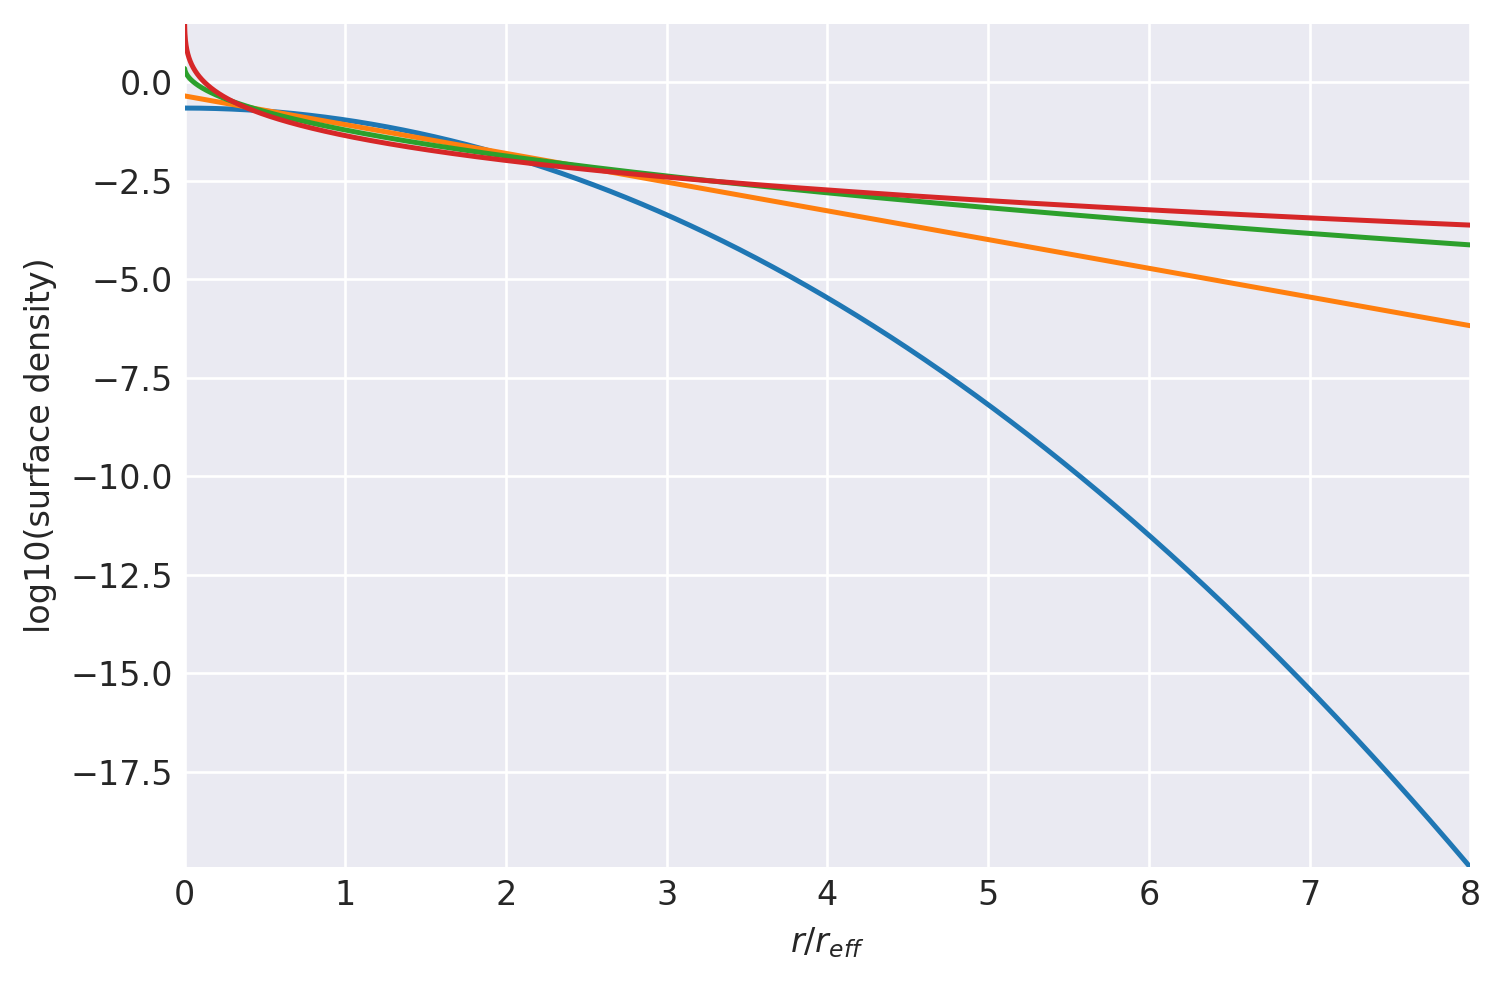

In [3]:
order = 8

nbinsperre = 1000
remin = 8
remid = 10
remax = 12
redge = np.linspace(0, remax, nbinsperre*remax+1)
rmid = (redge[1:] + redge[:-1])/2.
rsq = redge**2
areasq = np.pi*(rsq[1:] - rsq[:-1])

cuts = {
    'min': range(remin*nbinsperre),
    'mid': range(remid*nbinsperre),
    'max': range(remax*nbinsperre),
}

for n in [0.5, 1, 2, 4]:
    plt.plot(rmid[cuts['min']], np.log10(sersic(rmid[cuts['min']], n, 1)))
plt.tight_layout()
for axis in ['x','y']:
    plt.autoscale(enable=True, axis=axis, tight=True)
plt.xlabel('$r/r_{eff}$')
plt.ylabel('log10(surface density)')
plt.show()

weightssigmas = mpfobj.MultiGaussianApproximationProfile.weights['sersic'][order]

prev.  chisq = -8.370122099909805


         Current function value: -10.043945
         Iterations: 12
         Function evaluations: 592
         Gradient evaluations: 116
-10.043944757491563


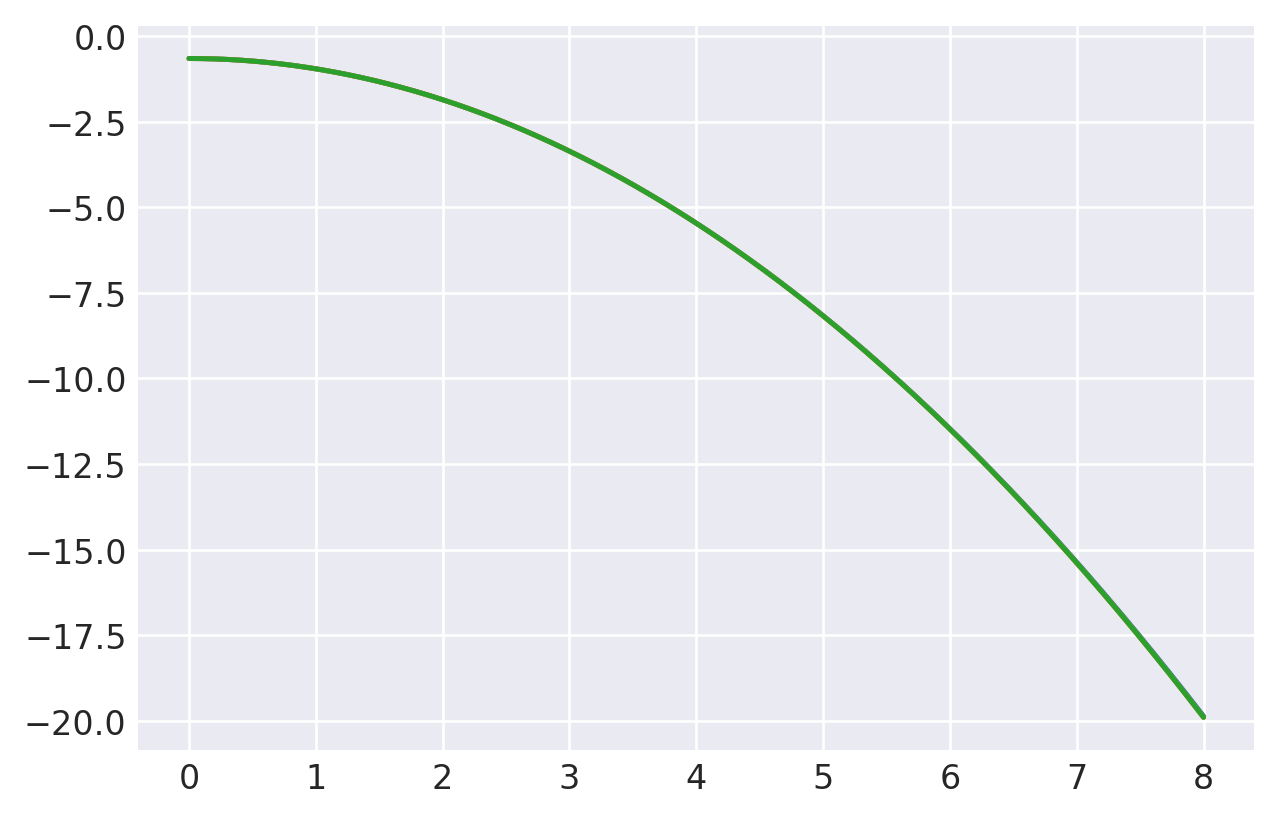

0.5005: (
    normalize(np.array([ 9.9871175186e-01, 1.2882481414e-03) ]),
    np.array([ 1.0005231705e+00, 6.7321516832e-01 ]),
),
prev.  chisq = -8.961765544574986


         Current function value: -10.049776
         Iterations: 9
         Function evaluations: 684
         Gradient evaluations: 96
-10.049775752050683


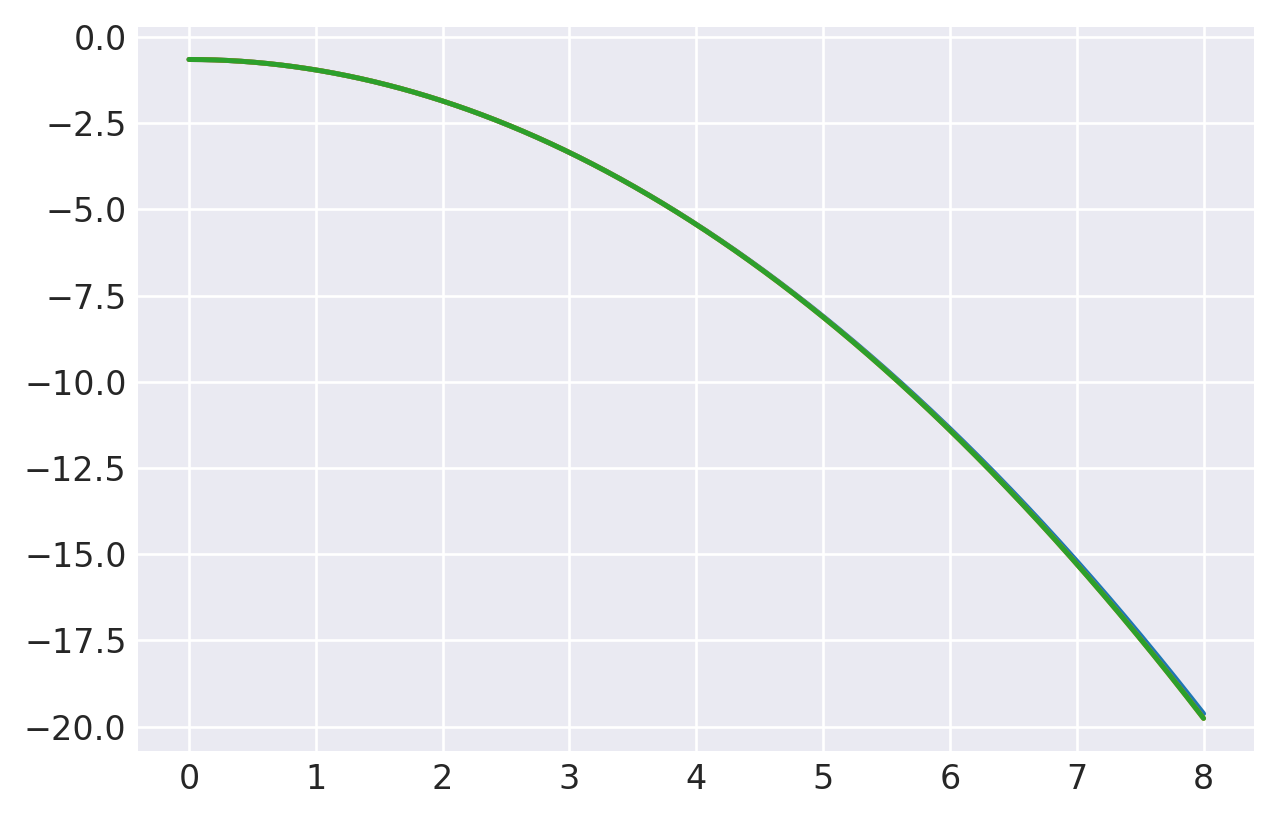

0.5028: (
    normalize(np.array([ 9.8270256947e-01, 1.7020106076e-02, 2.7732445383e-04) ]),
    np.array([ 1.0044281046e+00, 7.9218715234e-01, 3.6593937491e-01 ]),
),
prev.  chisq = -5.959584904351539


         Current function value: -10.044913
         Iterations: 49
         Function evaluations: 1425
         Gradient evaluations: 157
-10.044913484807148


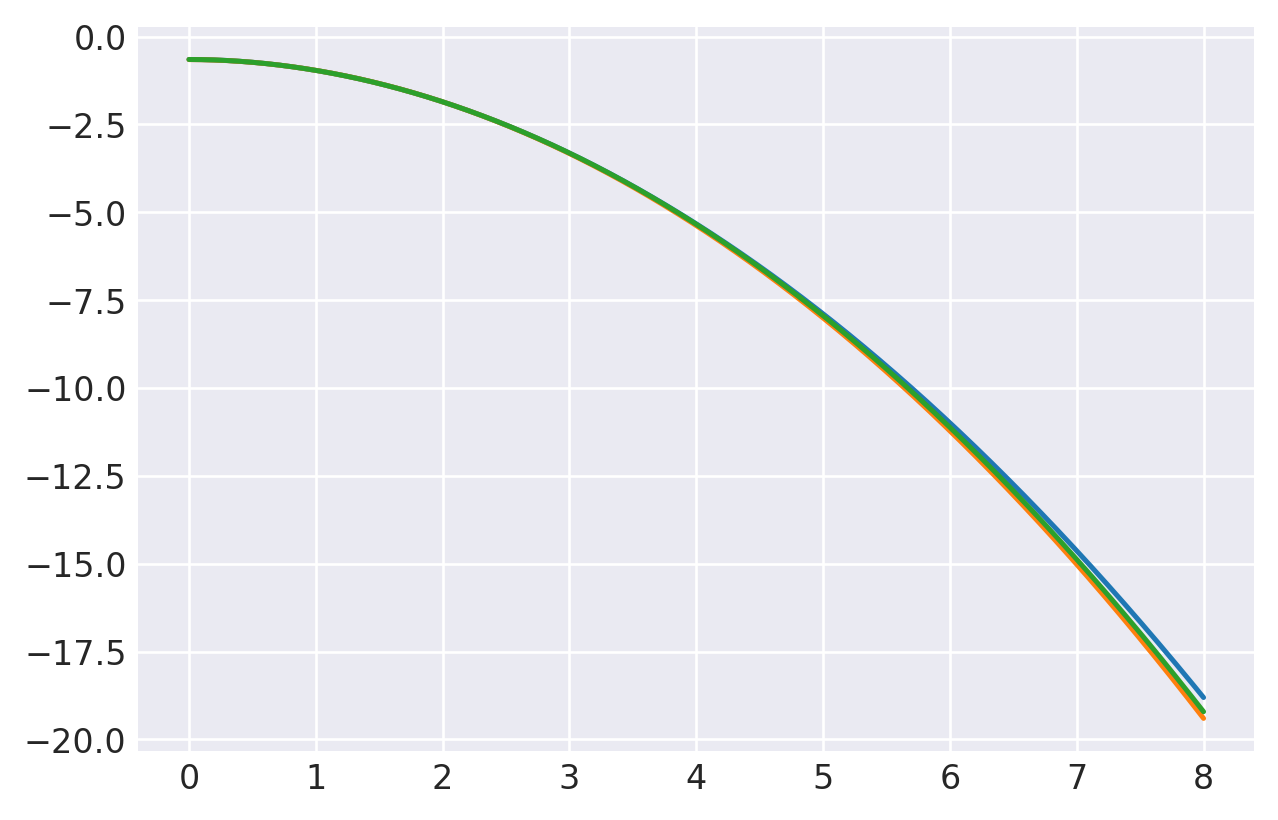

0.511: (
    normalize(np.array([ 9.0330097315e-01, 9.3436557426e-02, 3.1425474017e-03, 1.1992201809e-04) ]),
    np.array([ 1.0206604682e+00, 8.4567931172e-01, 4.9197887448e-01, 2.1734597888e-01 ]),
),
prev.  chisq = -4.034181731808588


         Current function value: -10.057740
         Iterations: 61
         Function evaluations: 2113
         Gradient evaluations: 191
-10.057739733973943


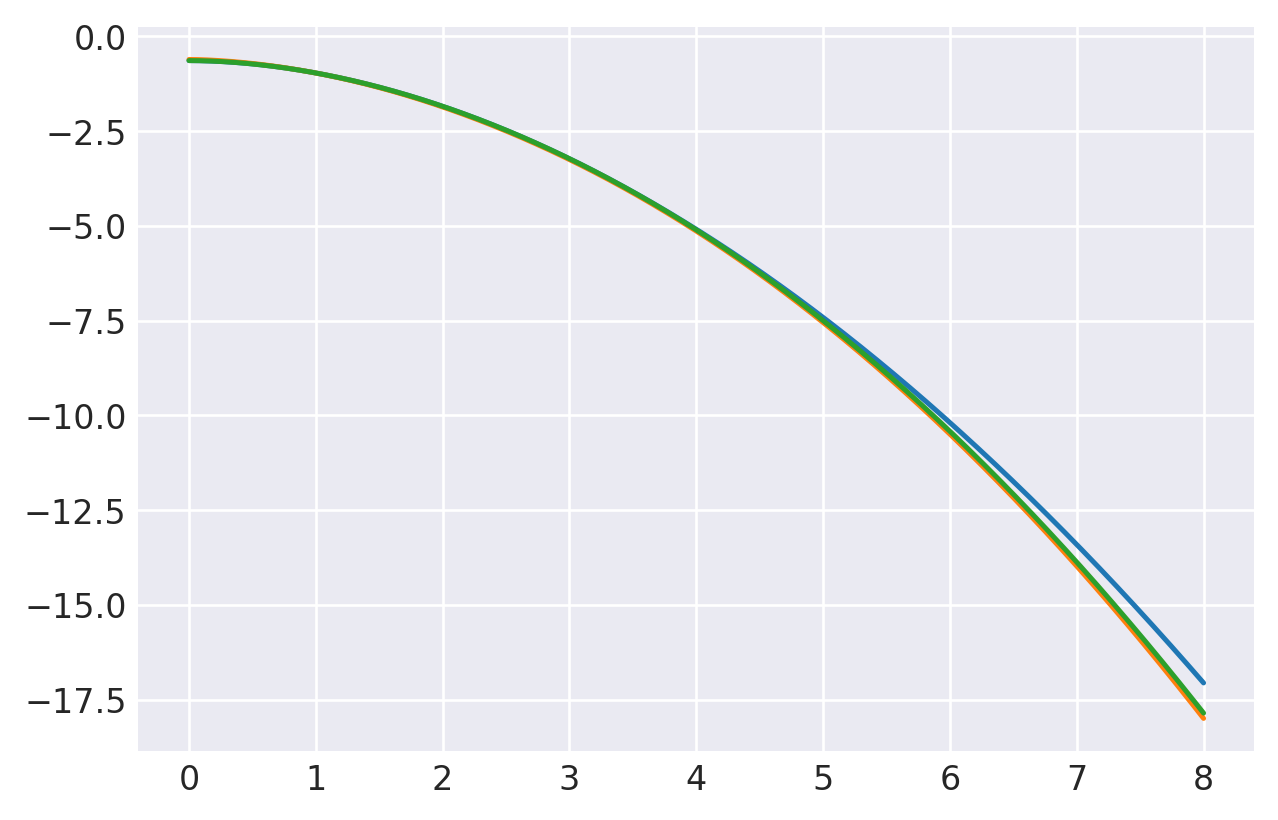

0.531: (
    normalize(np.array([ 7.0646412867e-01, 2.7247940220e-01, 1.9608916377e-02, 1.3787325848e-03, 6.8820166681e-05) ]),
    np.array([ 1.0646030793e+00, 8.9219454342e-01, 5.8990036552e-01, 3.2393980529e-01, 1.4133952436e-01 ]),
),
prev.  chisq = -5.542857463084591


         Current function value: -10.009428
         Iterations: 45
         Function evaluations: 1780
         Gradient evaluations: 136
-10.009428464944644


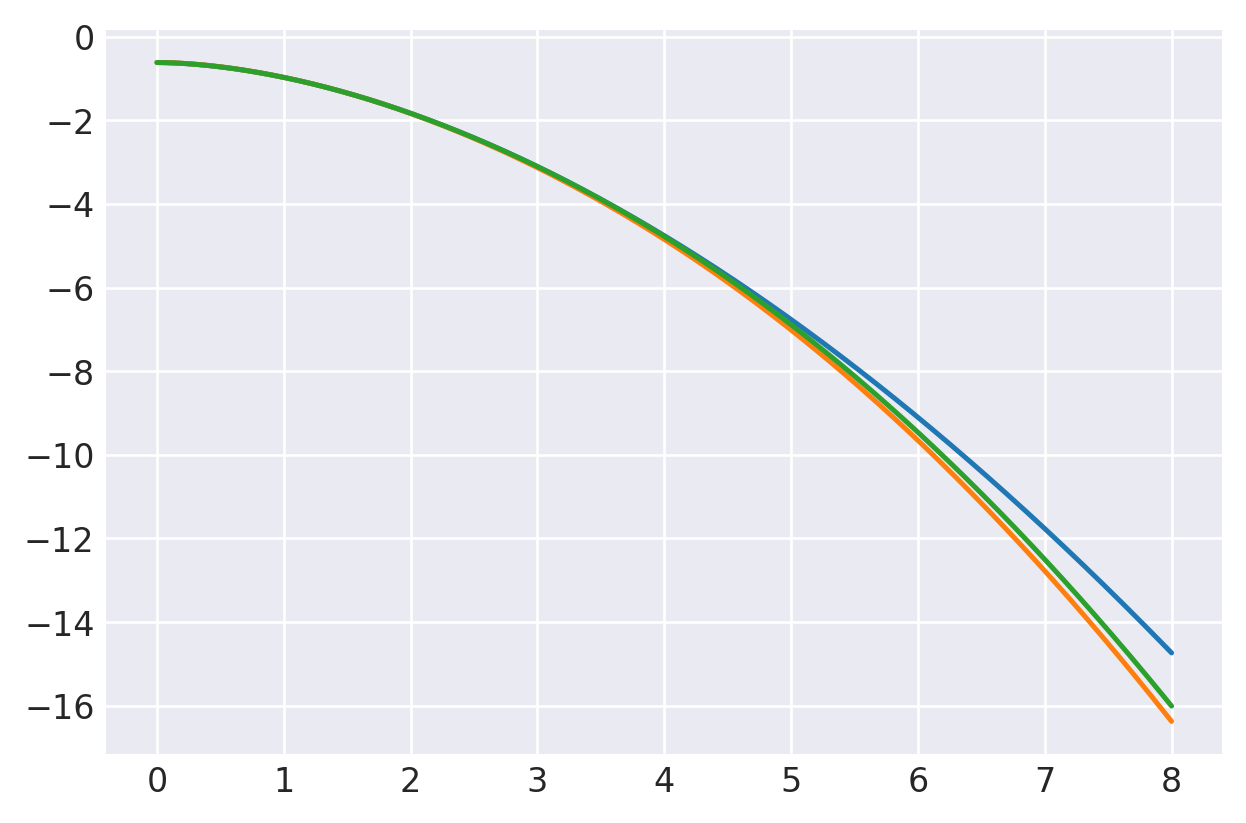

0.565: (
    normalize(np.array([ 5.2464629998e-01, 4.1300335711e-01, 5.6129846233e-02, 5.6647263546e-03, 5.2597950829e-04, 2.9790811417e-05) ]),
    np.array([ 1.1347495014e+00, 9.2444742235e-01, 6.3685014753e-01, 3.8272757637e-01, 2.0451531046e-01, 8.7609279094e-02 ]),
),
prev.  chisq = -4.629531886398454


         Current function value: -10.076845
         Iterations: 96
         Function evaluations: 2862
         Gradient evaluations: 190
-10.076844974728699


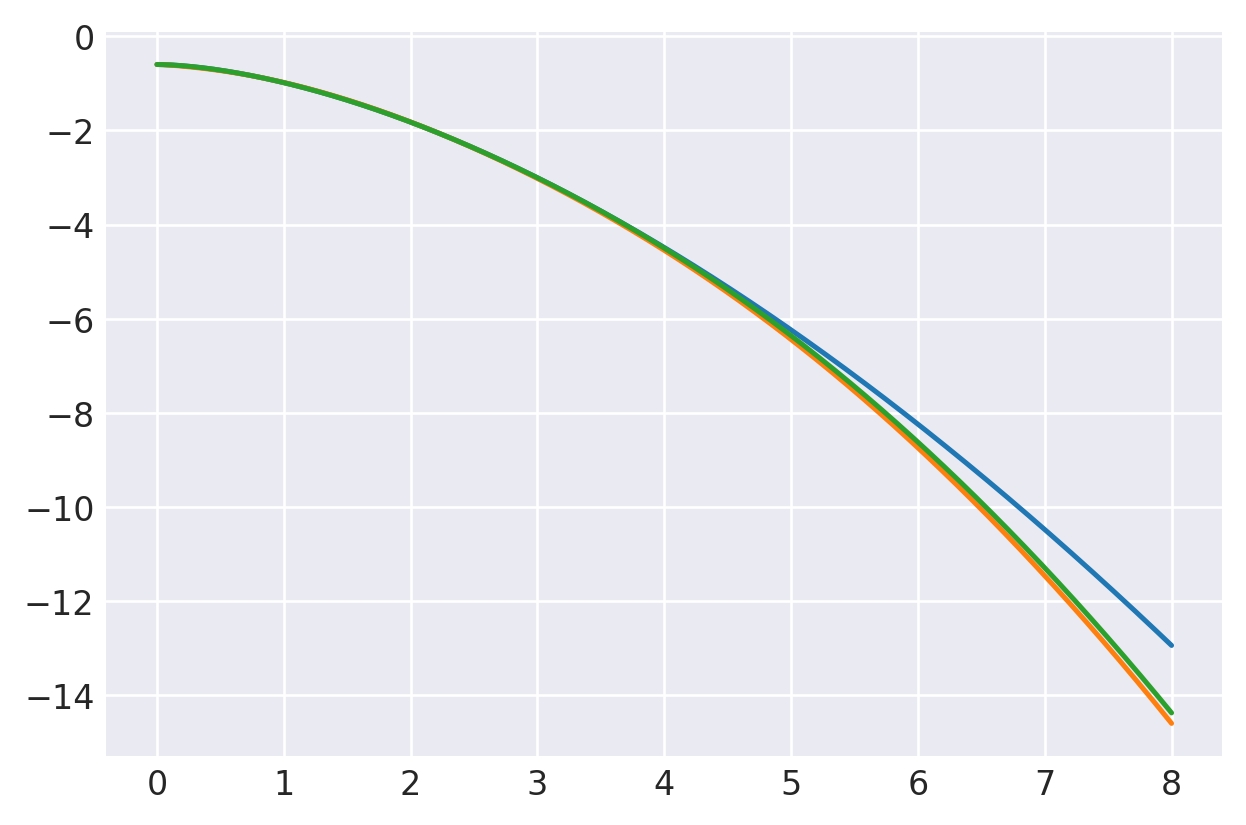

0.6: (
    normalize(np.array([ 3.9407708877e-01, 4.8296130046e-01, 1.0642939715e-01, 1.4480371404e-02, 1.8449691480e-03, 1.9502433610e-04, 1.1848730340e-05) ]),
    np.array([ 1.2105298619e+00, 9.6681604434e-01, 6.8229540886e-01, 4.3289218231e-01, 2.5376774083e-01, 1.3364413181e-01, 5.6330199940e-02 ]),
),
prev.  chisq = -5.54338466245488


         Current function value: -10.077646
         Iterations: 75
         Function evaluations: 2987
         Gradient evaluations: 175
-10.077645591838975


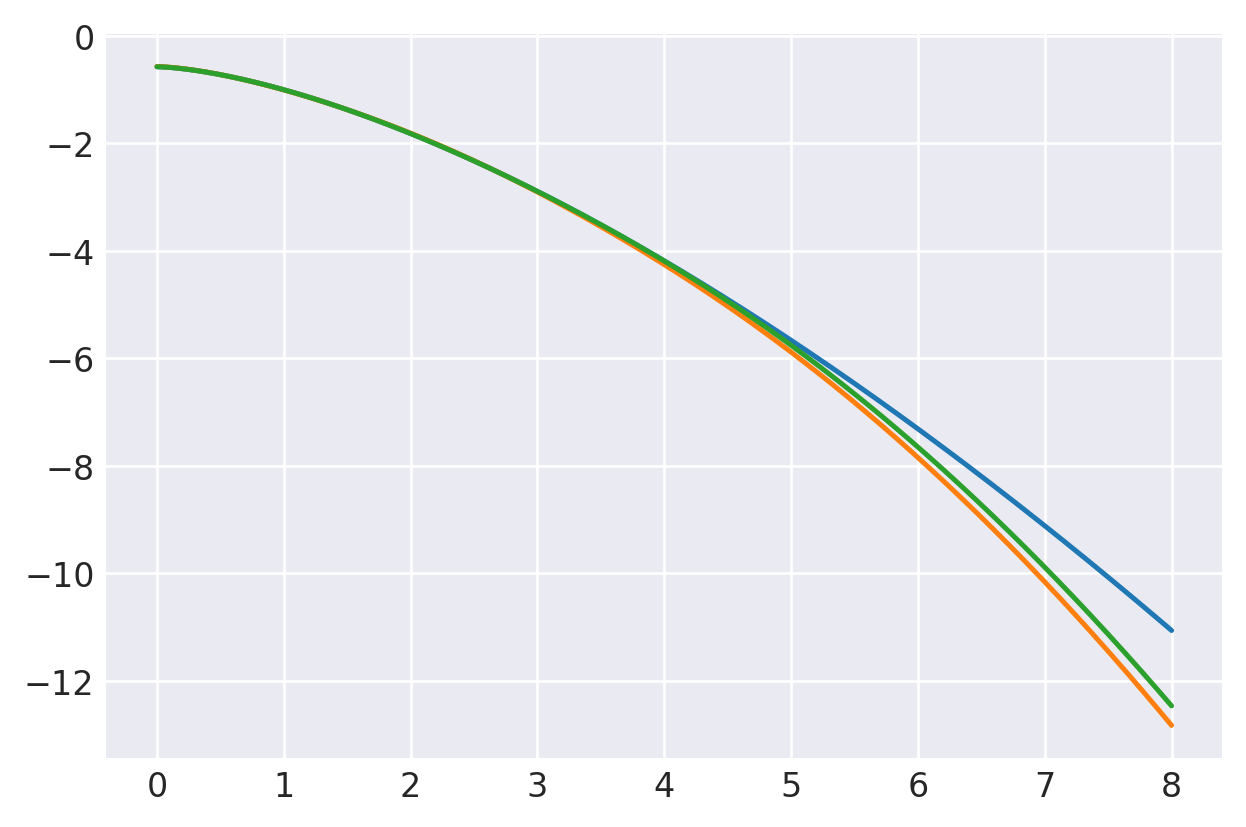

0.65: (
    normalize(np.array([ 2.7644879355e-01, 5.0462678830e-01, 1.7857882264e-01, 3.3883248674e-02, 5.5436240936e-03, 8.1826149710e-04, 9.4415992069e-05, 6.0452472996e-06) ]),
    np.array([ 1.3225167915e+00, 1.0303813107e+00, 7.3537412895e-01, 4.8379705734e-01, 2.9958136394e-01, 1.7344129641e-01, 9.0074210836e-02, 3.7136066936e-02 ]),
),
prev.  chisq = -5.54338466245488


         Current function value: -10.077646
         Iterations: 75
         Function evaluations: 2987
         Gradient evaluations: 175
-10.077645591838975


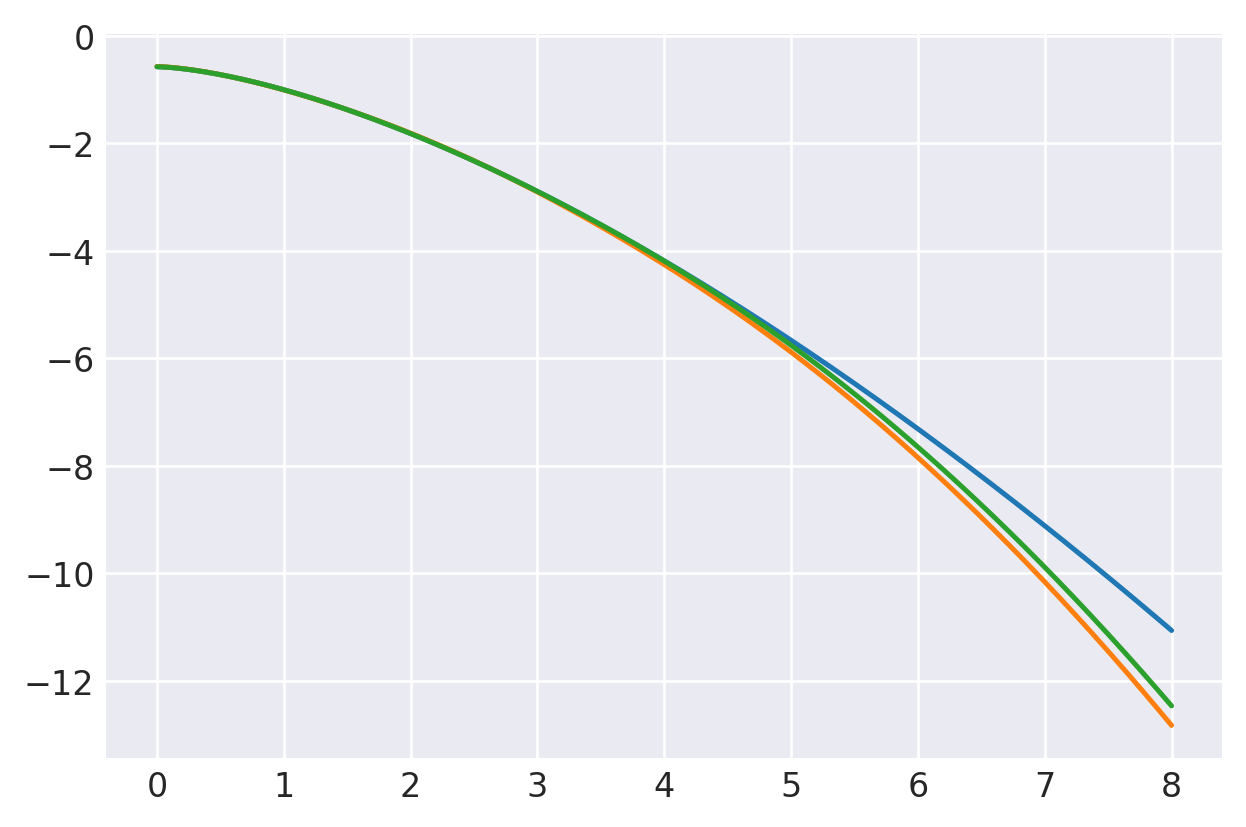

0.65: (
    normalize(np.array([ 2.7644879355e-01, 5.0462678830e-01, 1.7857882264e-01, 3.3883248674e-02, 5.5436240936e-03, 8.1826149710e-04, 9.4415992069e-05, 6.0452472996e-06) ]),
    np.array([ 1.3225167915e+00, 1.0303813107e+00, 7.3537412895e-01, 4.8379705734e-01, 2.9958136394e-01, 1.7344129641e-01, 9.0074210836e-02, 3.7136066936e-02 ]),
),
prev.  chisq = -4.1055976166619175


         Current function value: -9.701699
         Iterations: 149
         Function evaluations: 4568
         Gradient evaluations: 268
-9.70169877353604


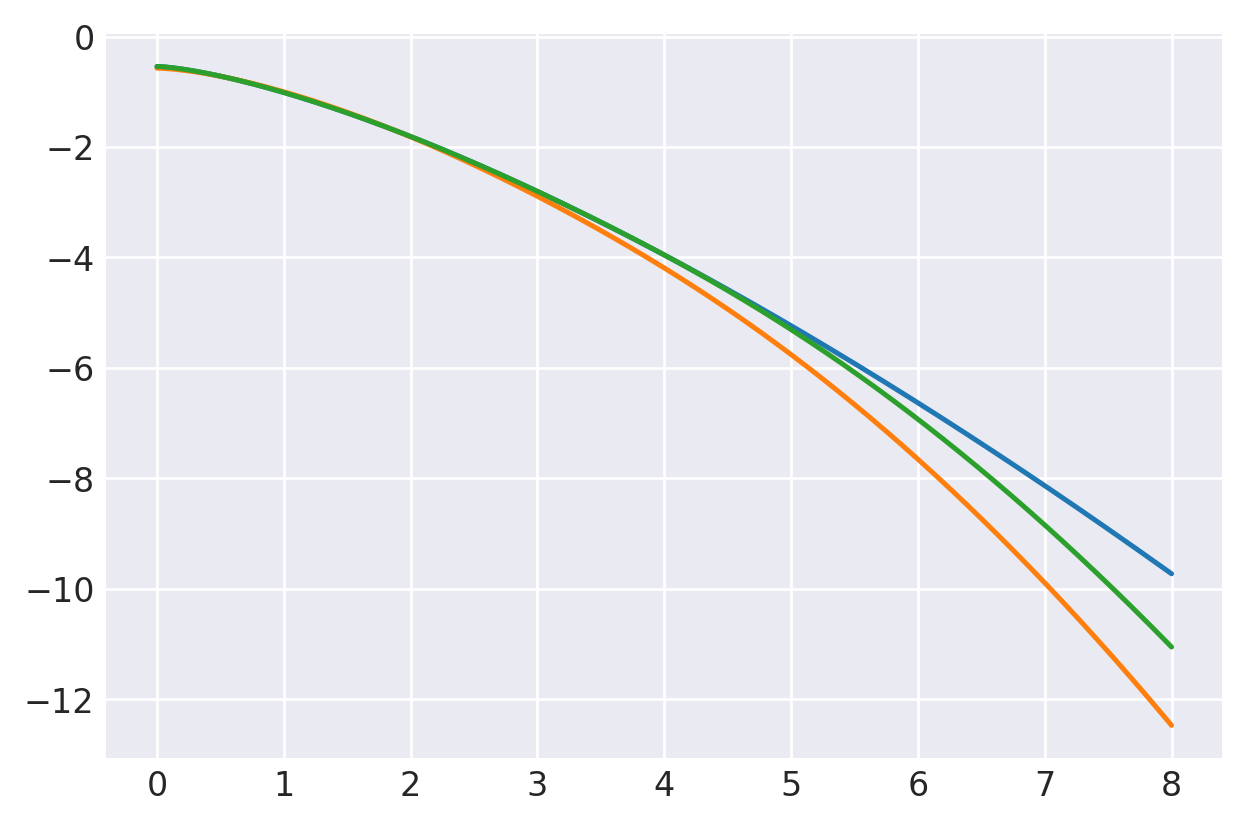

0.7: (
    normalize(np.array([ 2.1913524761e-01, 4.9061322757e-01, 2.2633481392e-01, 5.2650323786e-02, 9.5887014589e-03, 1.4888283964e-03, 1.7714117052e-04, 1.1716094895e-05) ]),
    np.array([ 1.4295033668e+00, 1.0823193970e+00, 7.6400463606e-01, 5.0215514298e-01, 3.1001601719e-01, 1.7798862821e-01, 9.1251418345e-02, 3.6960762932e-02 ]),
),
prev.  chisq = -4.132603100970631


         Current function value: -9.324302
         Iterations: 118
         Function evaluations: 4075
         Gradient evaluations: 239
-9.324302255573526


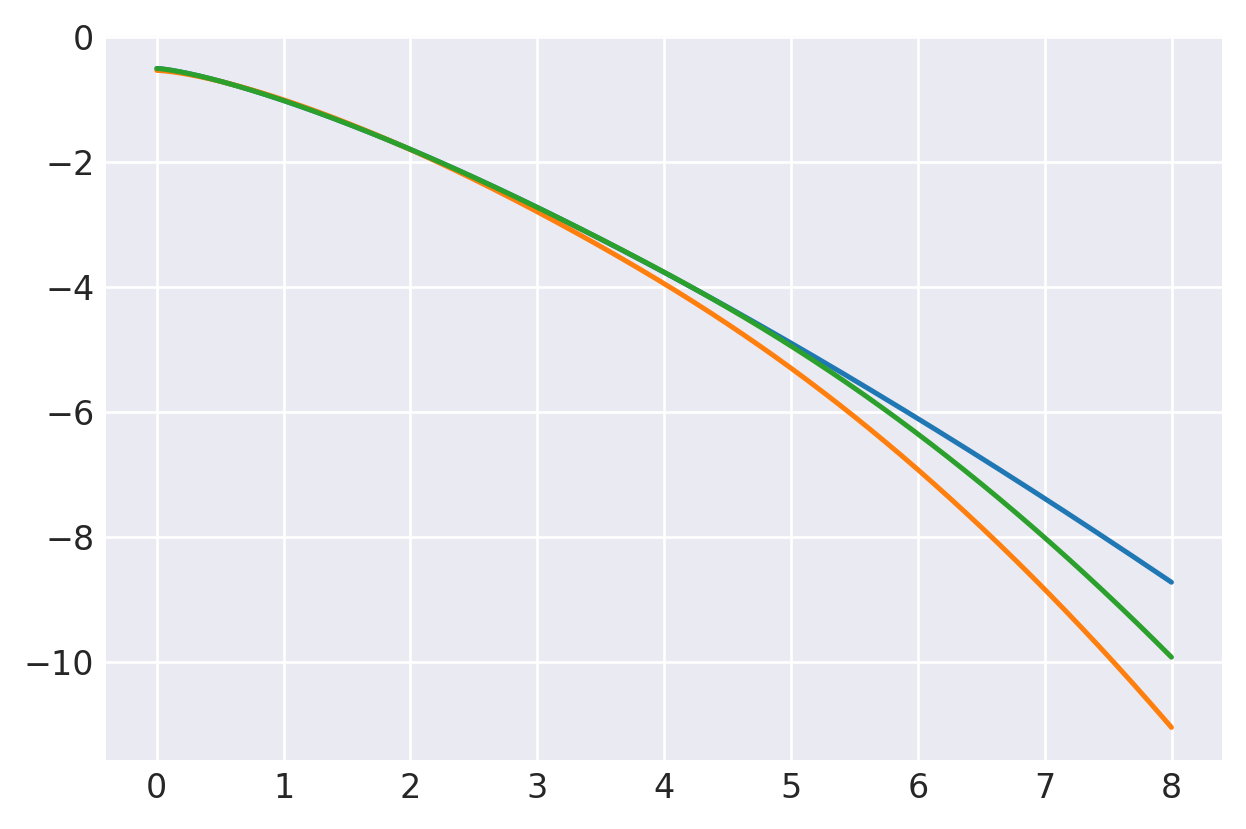

0.75: (
    normalize(np.array([ 1.8301185980e-01, 4.6875271952e-01, 2.6043113688e-01, 7.0988049797e-02, 1.4200518979e-02, 2.3135032807e-03, 2.8301925921e-04, 1.9192488236e-05) ]),
    np.array([ 1.5361855788e+00, 1.1324232947e+00, 7.8818653776e-01, 5.1478319329e-01, 3.1582869745e-01, 1.7964804795e-01, 9.0909435872e-02, 3.6108284232e-02 ]),
),
prev.  chisq = -4.15603454278871


         Current function value: -8.968498
         Iterations: 116
         Function evaluations: 3735
         Gradient evaluations: 219
-8.9684982083917


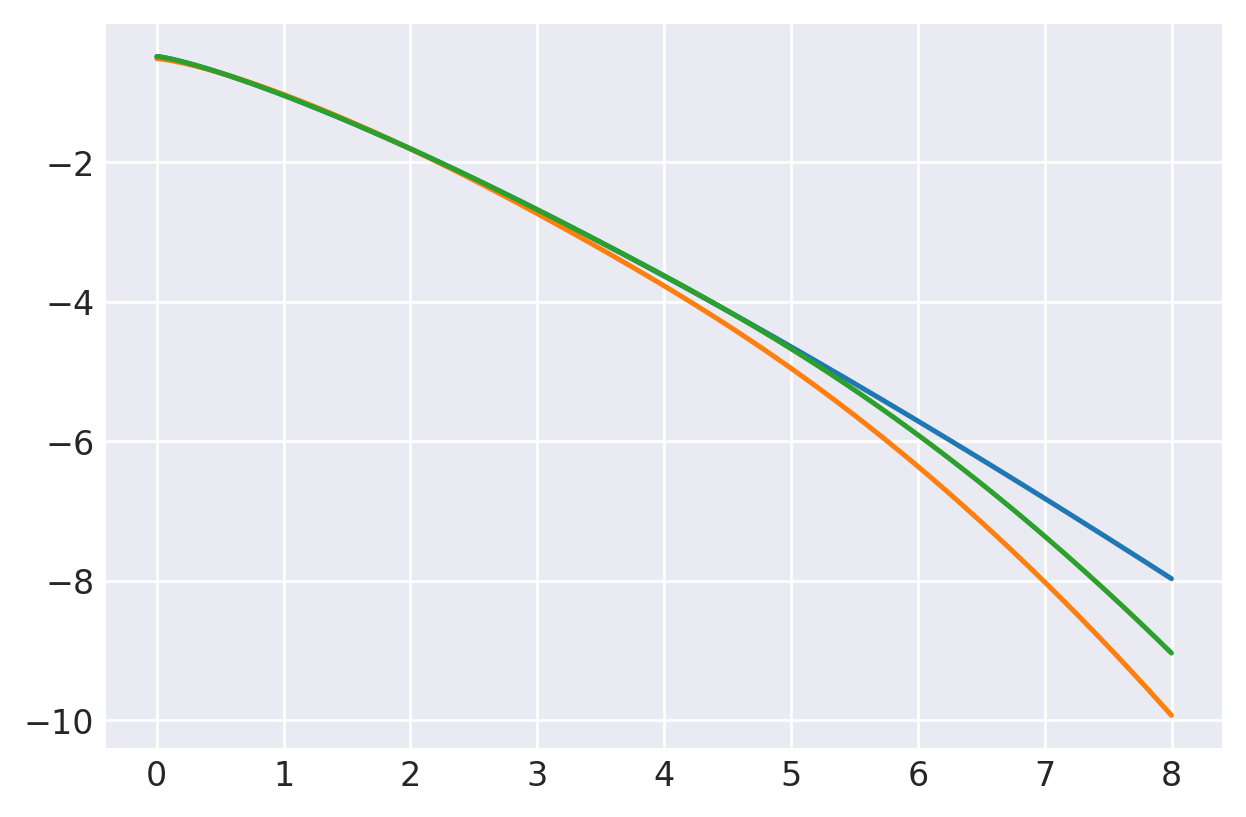

0.8: (
    normalize(np.array([ 1.6007109305e-01, 4.4613662047e-01, 2.8329587707e-01, 8.7699161810e-02, 1.9094981011e-02, 3.2628814132e-03, 4.1078431491e-04, 2.8600864999e-05) ]),
    np.array([ 1.6409713492e+00, 1.1794102555e+00, 8.0870675305e-01, 5.2379135872e-01, 3.1899865673e-01, 1.7976843908e-01, 8.9878043418e-02, 3.5112187379e-02 ]),
),
prev.  chisq = -4.17628935412788


         Current function value: -8.644292
         Iterations: 93
         Function evaluations: 3514
         Gradient evaluations: 206
-8.644292261015313


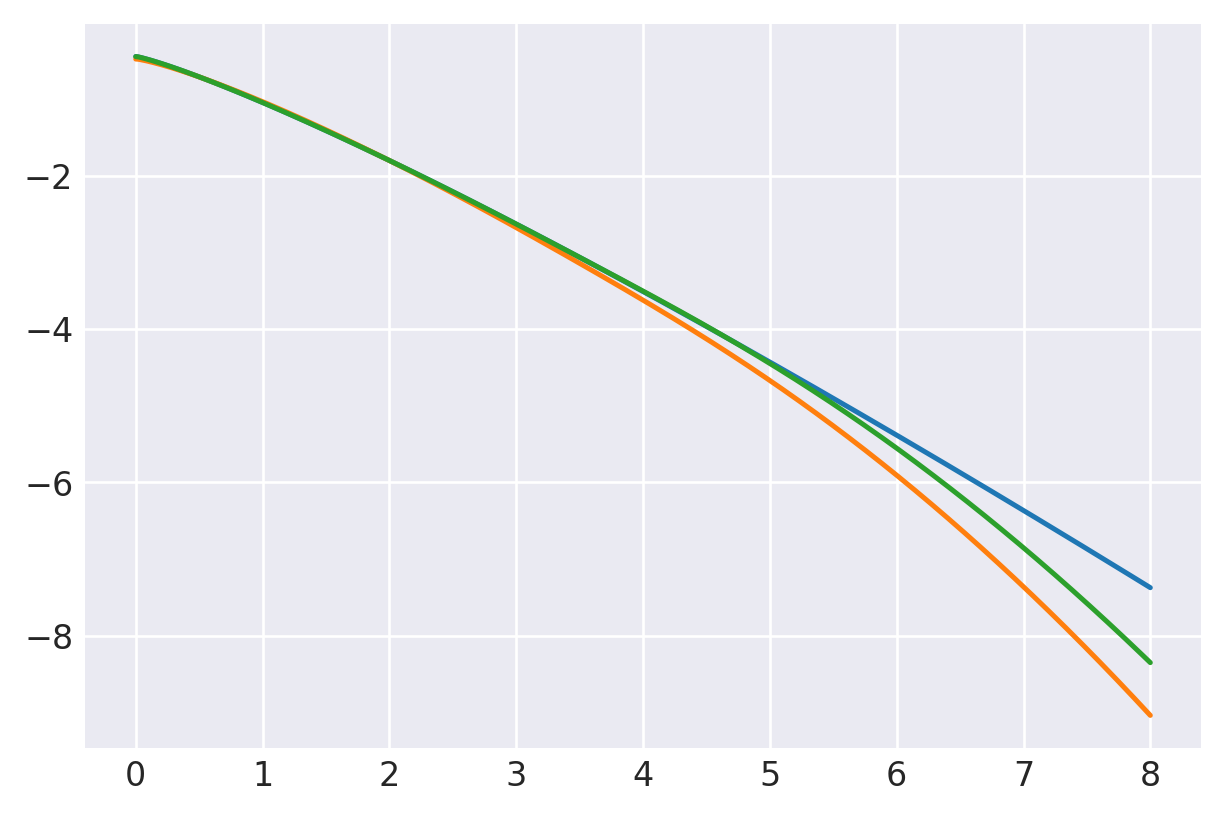

0.85: (
    normalize(np.array([ 1.4983125801e-01, 4.2915577983e-01, 2.9408635117e-01, 9.9212989192e-02, 2.3043392169e-02, 4.1016832156e-03, 5.3066585159e-04, 3.7880561194e-05) ]),
    np.array([ 1.7365111034e+00, 1.2153911167e+00, 8.1863344627e-01, 5.2389206546e-01, 3.1590136290e-01, 1.7621315342e-01, 8.7066322929e-02, 3.3482800793e-02 ]),
),
prev.  chisq = -4.193870062675914


         Current function value: -8.358349
         Iterations: 94
         Function evaluations: 2493
         Gradient evaluations: 146
-8.35834876928252


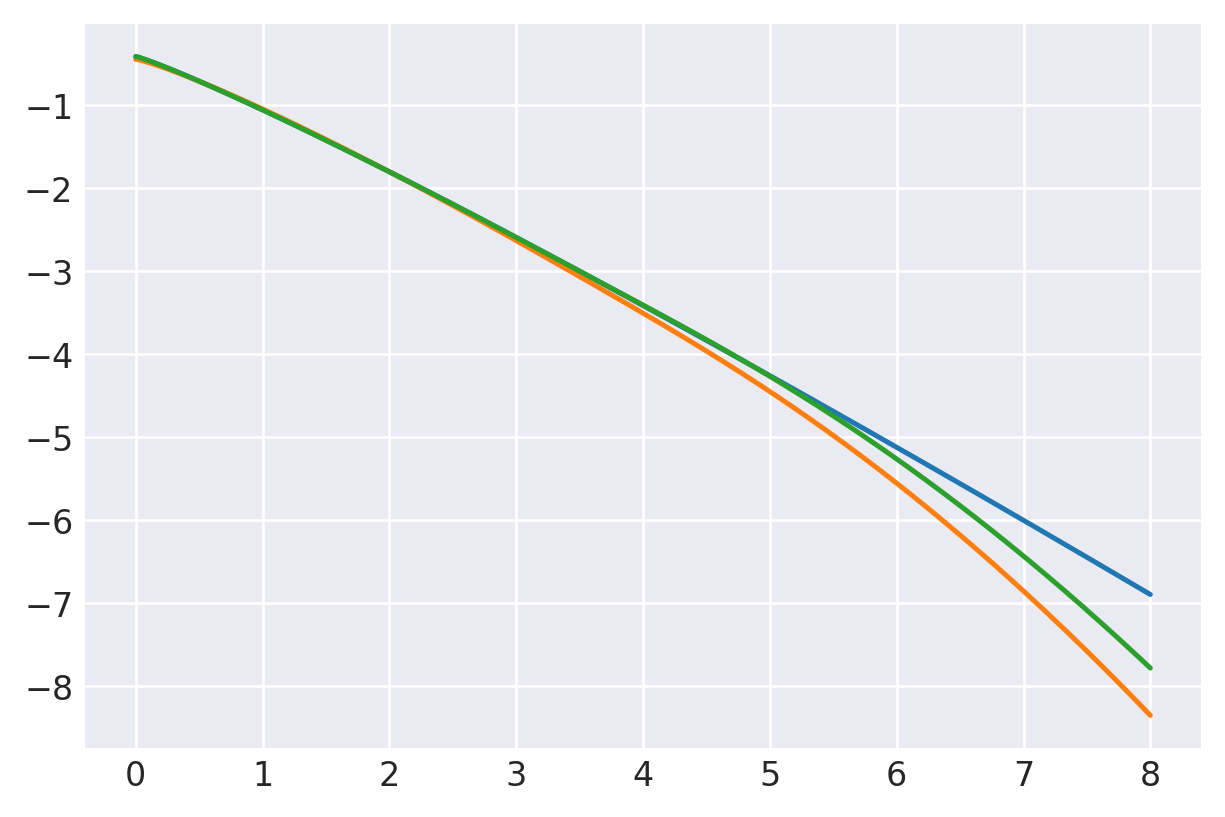

0.9: (
    normalize(np.array([ 1.4281515977e-01, 4.1537607783e-01, 3.0104105297e-01, 1.0855492865e-01, 2.6602063685e-02, 4.9112416485e-03, 6.5186723676e-04, 4.7608201833e-05) ]),
    np.array([ 1.8300744982e+00, 1.2486614142e+00, 8.2612606033e-01, 5.2192304646e-01, 3.1138823786e-01, 1.7190477112e-01, 8.3968914838e-02, 3.1817771621e-02 ]),
),
prev.  chisq = -4.2090732453618225


         Current function value: -8.103381
         Iterations: 87
         Function evaluations: 3259
         Gradient evaluations: 191
-8.103380595712292


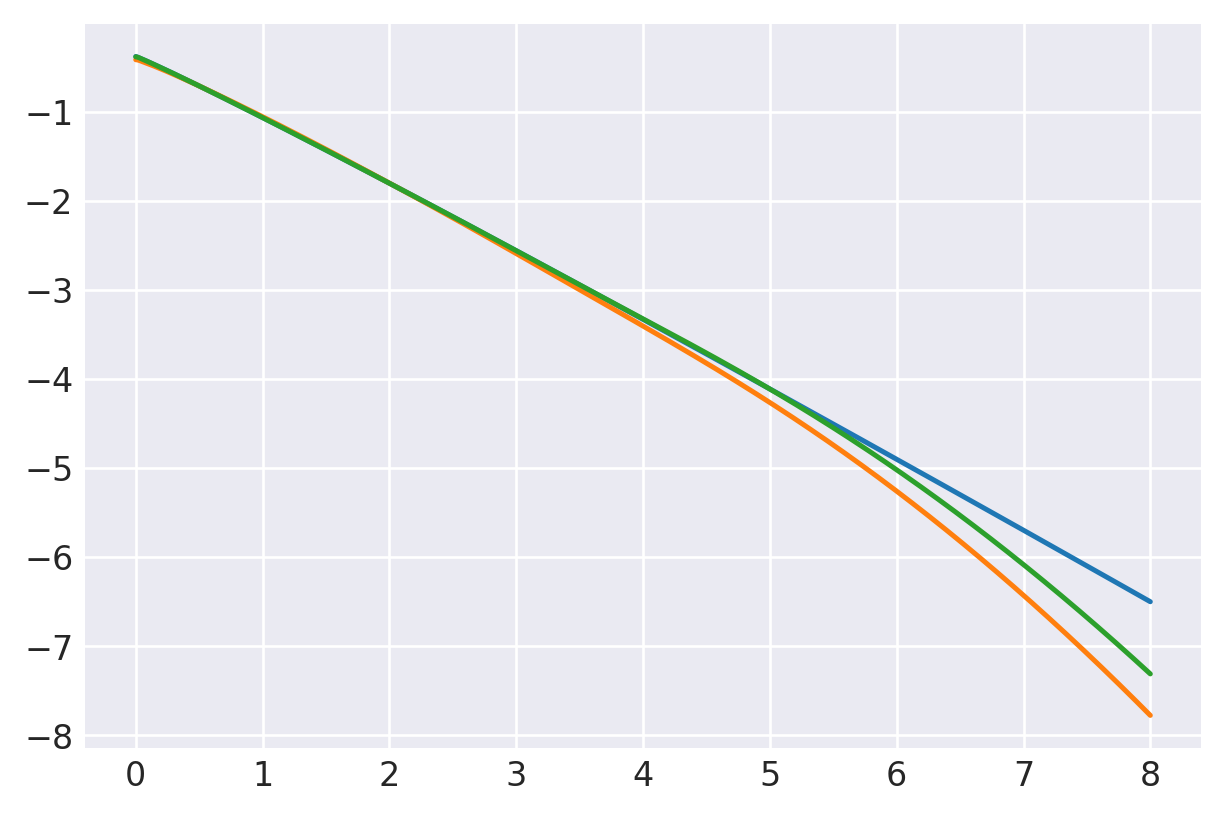

0.95: (
    normalize(np.array([ 1.3951138367e-01, 4.0427405944e-01, 3.0427487387e-01, 1.1571864827e-01, 2.9715241024e-02, 5.6762314310e-03, 7.7195959056e-04, 5.7602707981e-05) ]),
    np.array([ 1.9182788436e+00, 1.2770276092e+00, 8.3043970443e-01, 5.1808234202e-01, 3.0589408234e-01, 1.6718495837e-01, 8.0764481990e-02, 3.0177397537e-02 ]),
),
prev.  chisq = -4.222204313650473


         Current function value: -7.874244
         Iterations: 47
         Function evaluations: 2375
         Gradient evaluations: 139
-7.874244161350316


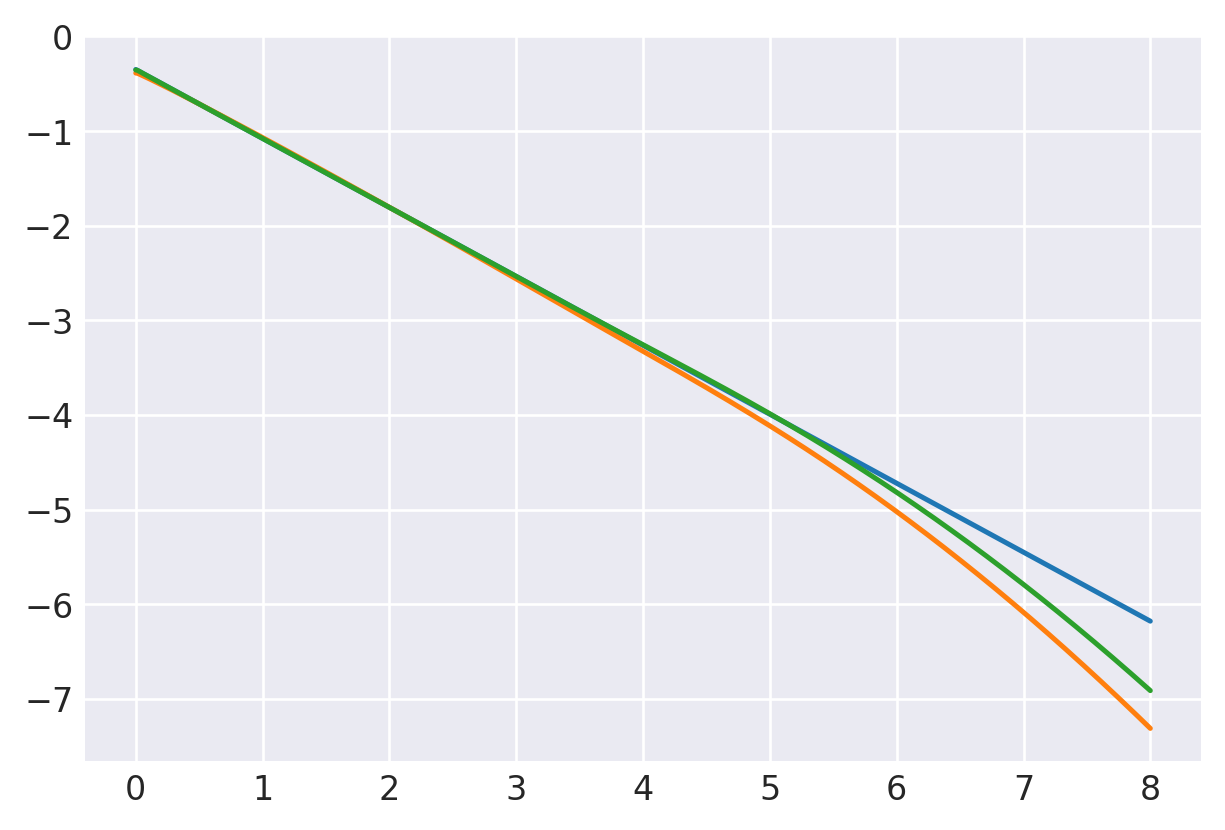

1.0: (
    normalize(np.array([ 1.3690689179e-01, 3.9460865185e-01, 3.0650093753e-01, 1.2196285410e-01, 3.2629627568e-02, 6.4288331405e-03, 8.9418477376e-04, 6.8019252669e-05) ]),
    np.array([ 2.0056078299e+00, 1.3045129968e+00, 8.3448218895e-01, 5.1419721377e-01, 3.0045697594e-01, 1.6257972270e-01, 7.7690601585e-02, 2.8636084563e-02 ]),
),
prev.  chisq = -4.233477670911353


         Current function value: -7.666442
         Iterations: 54
         Function evaluations: 2408
         Gradient evaluations: 141
-7.6664422791158096


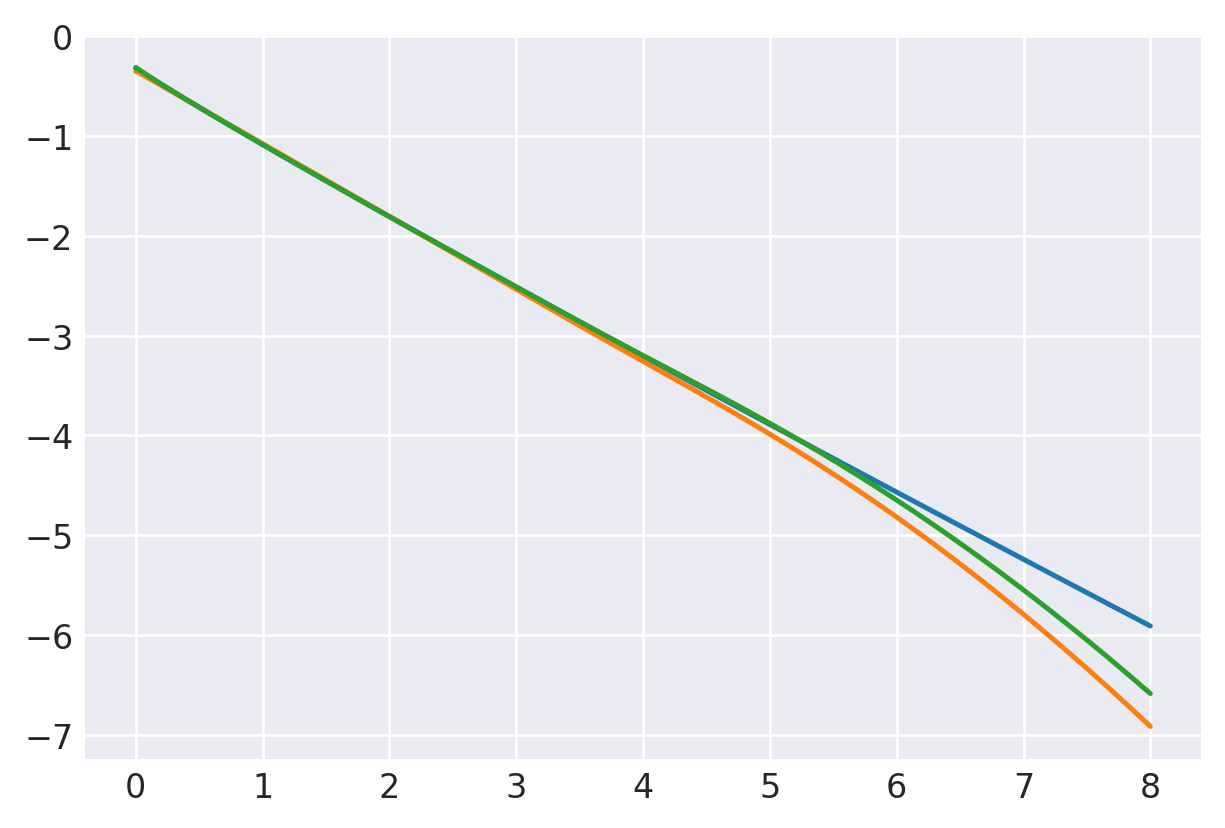

1.05: (
    normalize(np.array([ 1.3709630298e-01, 3.8754523486e-01, 3.0626670428e-01, 1.2606165949e-01, 3.4884816940e-02, 7.0635062893e-03, 1.0038782682e-03, 7.7896896326e-05) ]),
    np.array([ 2.0861061998e+00, 1.3260040591e+00, 8.3448149479e-01, 5.0784100513e-01, 2.9365592565e-01, 1.5735320132e-01, 7.4429029035e-02, 2.7091198274e-02 ]),
),
prev.  chisq = -4.243120381587872


         Current function value: -7.476805
         Iterations: 59
         Function evaluations: 2426
         Gradient evaluations: 142
-7.47680543379551


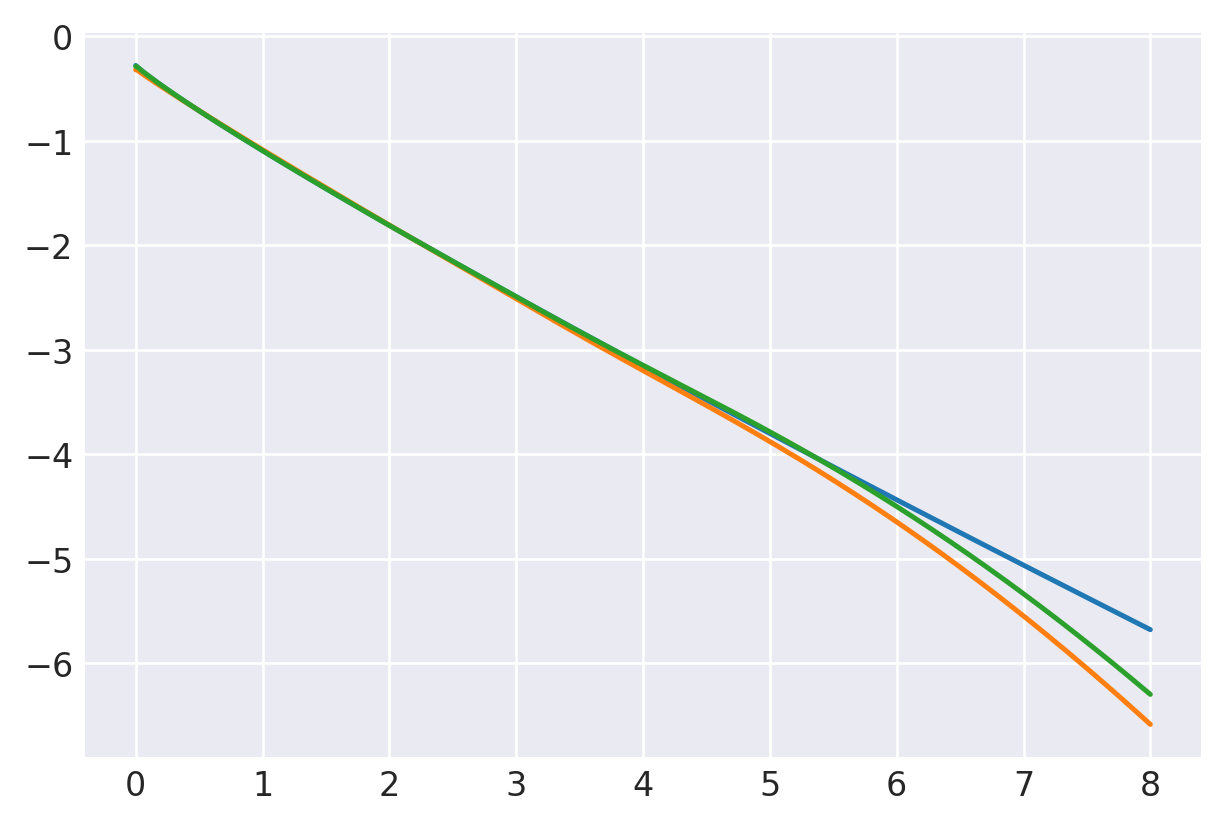

1.1: (
    normalize(np.array([ 1.3743983167e-01, 3.8123589573e-01, 3.0579513664e-01, 1.2966528355e-01, 3.6984275300e-02, 7.6785668299e-03, 1.1130899456e-03, 8.7920327175e-05) ]),
    np.array([ 2.1653593267e+00, 1.3466726893e+00, 8.3445808404e-01, 5.0176289278e-01, 2.8718612143e-01, 1.5240911033e-01, 7.1365358174e-02, 2.5658950943e-02 ]),
),
prev.  chisq = -4.25127263655565


         Current function value: -7.302639
         Iterations: 52
         Function evaluations: 1984
         Gradient evaluations: 116
-7.302639416750153


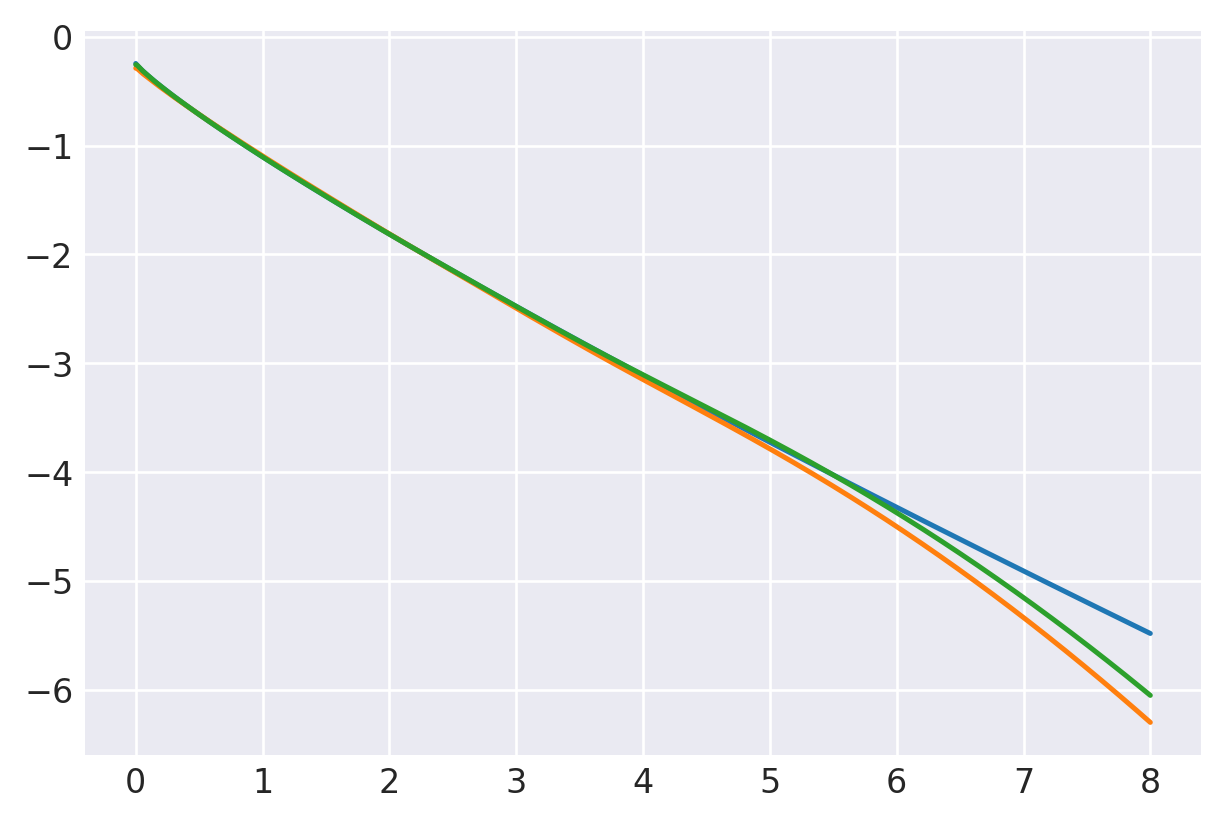

1.15: (
    normalize(np.array([ 1.3849050471e-01, 3.7594926852e-01, 3.0472696301e-01, 1.3247403415e-01, 3.8802811760e-02, 8.2417101884e-03, 1.2169664870e-03, 9.7741164545e-05) ]),
    np.array([ 2.2415976927e+00, 1.3650395044e+00, 8.3330130881e-01, 4.9523979835e-01, 2.8062015732e-01, 1.4752312761e-01, 6.8401071005e-02, 2.4303751951e-02 ]),
),
prev.  chisq = -4.258083176011634


         Current function value: -7.141812
         Iterations: 47
         Function evaluations: 1882
         Gradient evaluations: 110
-7.141811571825926


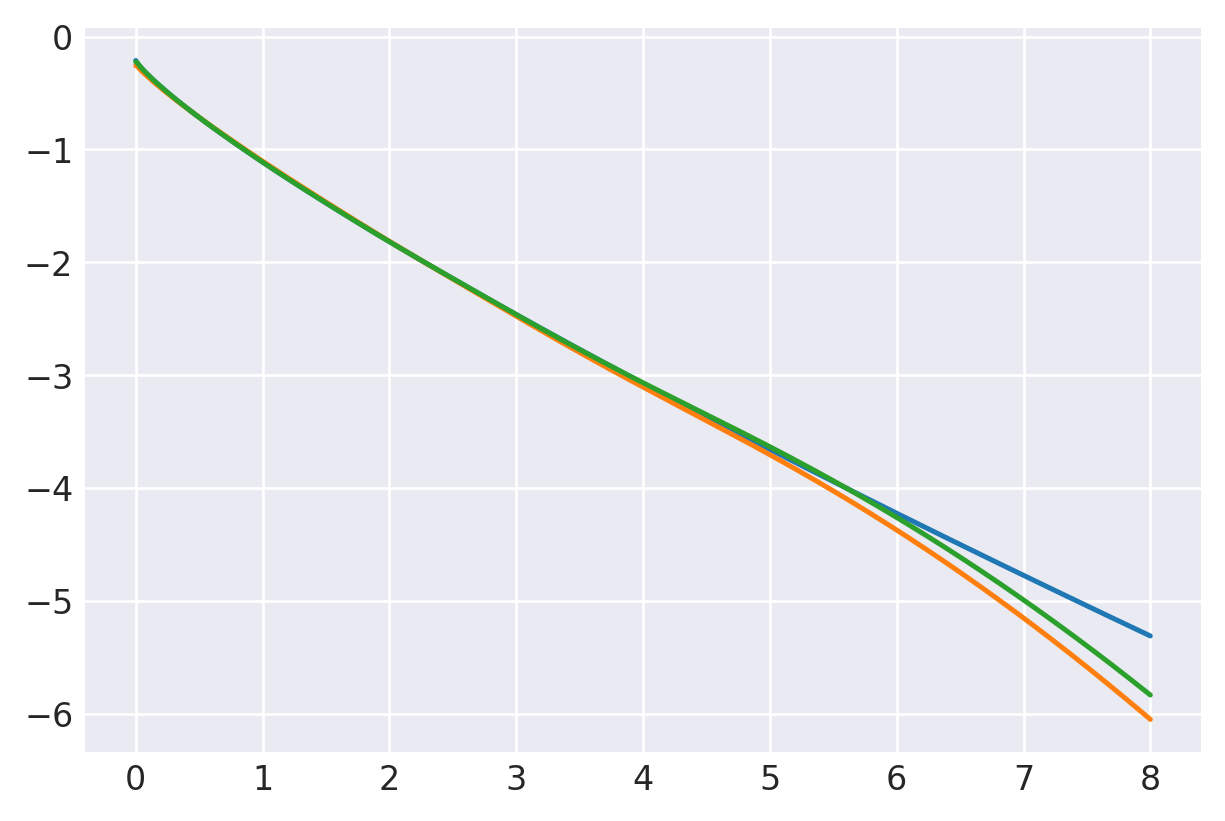

1.2: (
    normalize(np.array([ 1.4009589733e-01, 3.7149773667e-01, 3.0324275718e-01, 1.3462373094e-01, 4.0365057596e-02, 8.7527374456e-03, 1.3148157512e-03, 1.0726709375e-04) ]),
    np.array([ 2.3148716728e+00, 1.3812547496e+00, 8.3112936953e-01, 4.8834988301e-01, 2.7400295078e-01, 1.4271481377e-01, 6.5539781991e-02, 2.3022402726e-02 ]),
),
prev.  chisq = -4.26366691047452


         Current function value: -6.992568
         Iterations: 47
         Function evaluations: 2239
         Gradient evaluations: 131
-6.9925679009620385


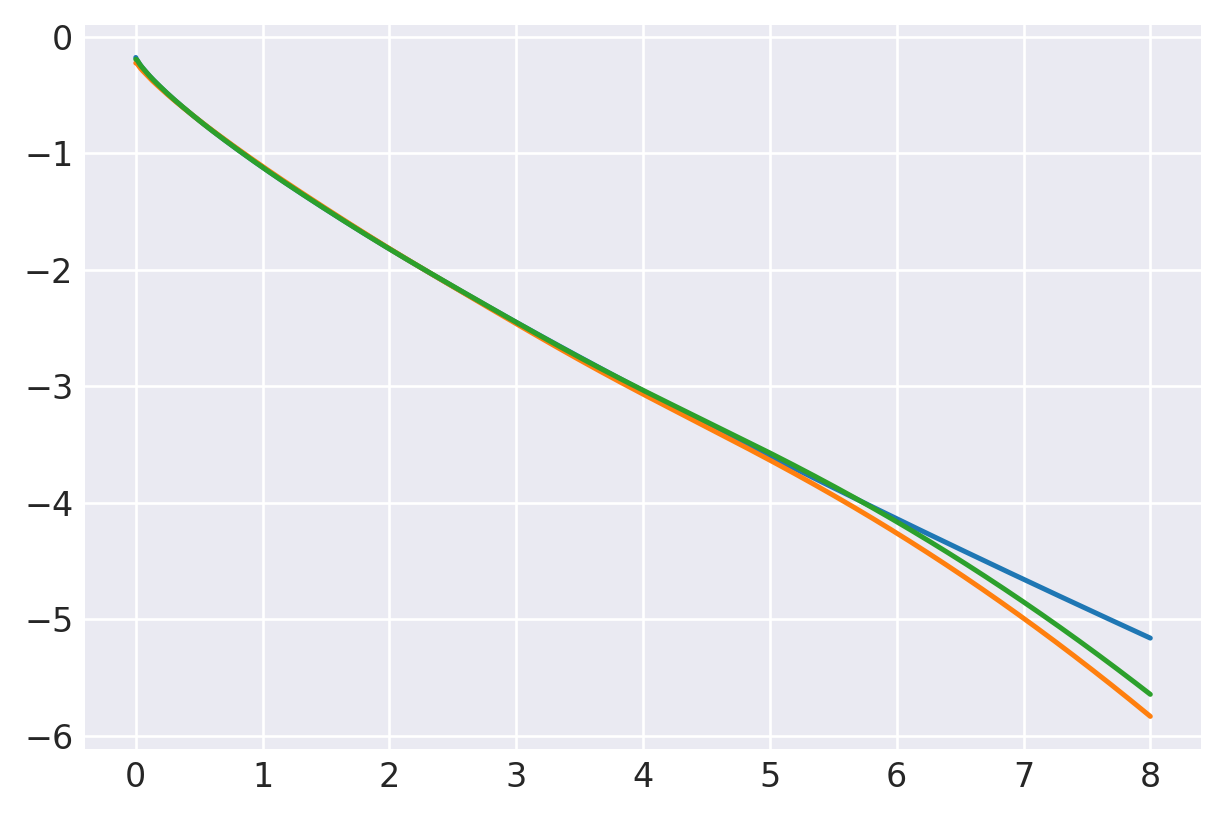

1.25: (
    normalize(np.array([ 1.4217205339e-01, 3.6773580762e-01, 3.0144979957e-01, 1.3621525356e-01, 4.1692498175e-02, 9.2120991012e-03, 1.4060751321e-03, 1.1641344756e-04) ]),
    np.array([ 2.3851285147e+00, 1.3953887270e+00, 8.2801339669e-01, 4.8114303348e-01, 2.6736359893e-01, 1.3799515258e-01, 6.2781139975e-02, 2.1810745498e-02 ]),
),
prev.  chisq = -4.268121445780699


         Current function value: -6.853446
         Iterations: 48
         Function evaluations: 2187
         Gradient evaluations: 128
-6.853446297114409


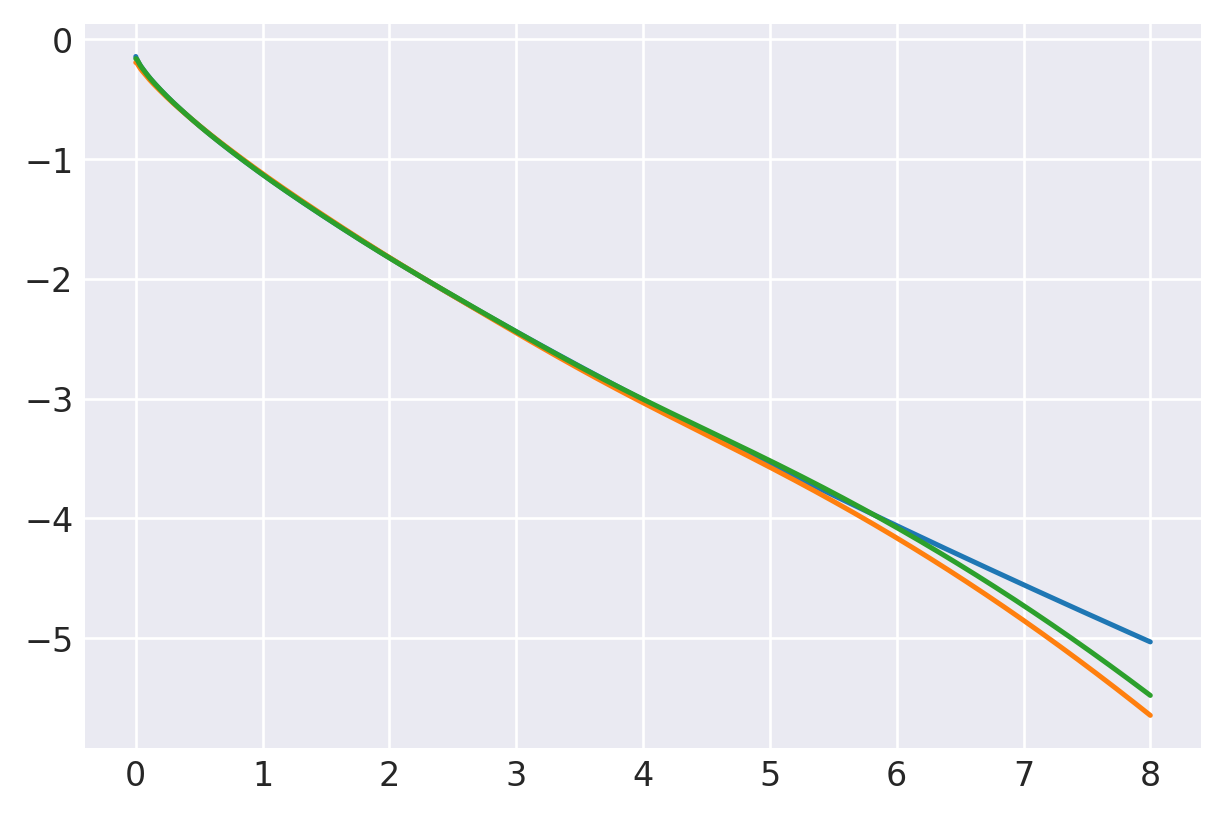

1.3: (
    normalize(np.array([ 1.4462732459e-01, 3.6454268875e-01, 2.9943929388e-01, 1.3734214248e-01, 4.2810457939e-02, 9.6223001640e-03, 1.4906561065e-03, 1.2513608993e-04) ]),
    np.array([ 2.4524352834e+00, 1.4075794134e+00, 8.2405307308e-01, 4.7368398549e-01, 2.6073844880e-01, 1.3338008277e-01, 6.0128280843e-02, 2.0666121114e-02 ]),
),
prev.  chisq = -4.2715290608969285


         Current function value: -6.723215
         Iterations: 40
         Function evaluations: 1524
         Gradient evaluations: 89
-6.723215383827492


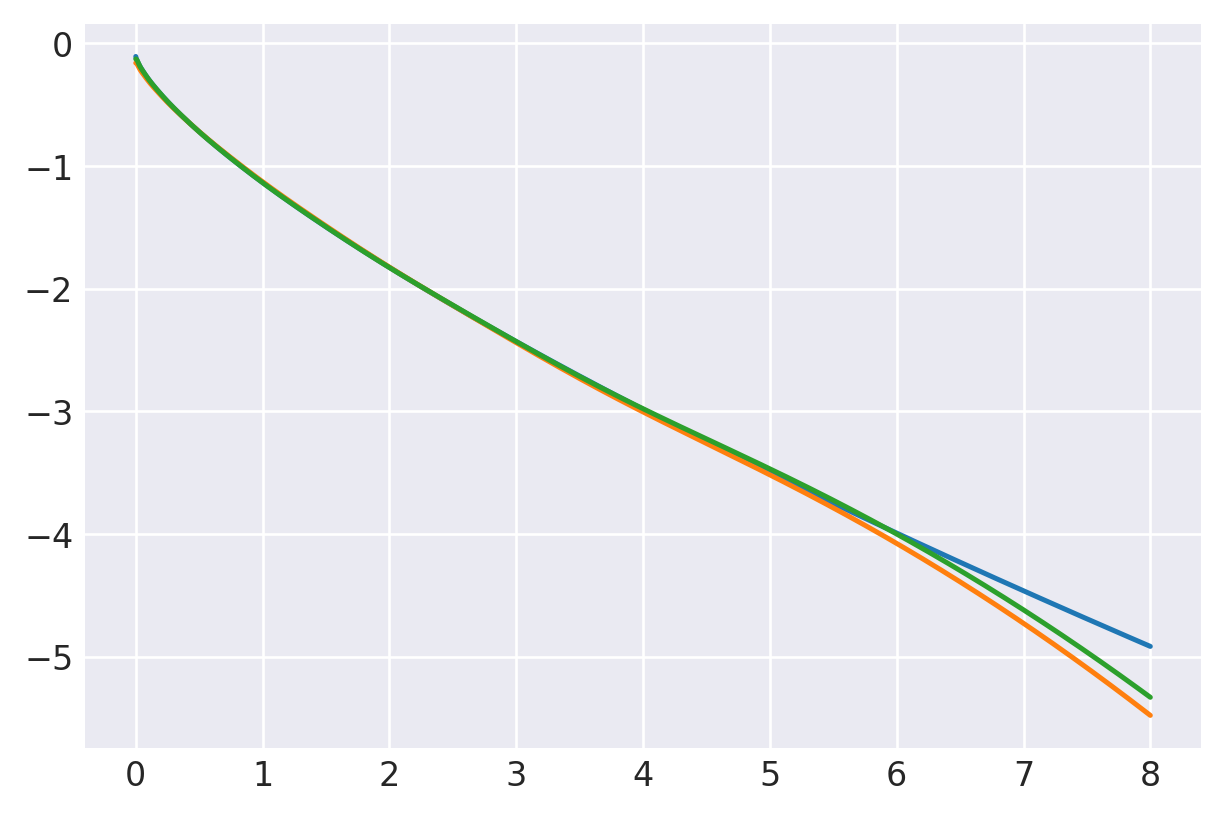

1.35: (
    normalize(np.array([ 1.4740403388e-01, 3.6180274350e-01, 2.9727137681e-01, 1.3808959080e-01, 4.3744213085e-02, 9.9861502797e-03, 1.5684906785e-03, 1.3340096798e-04) ]),
    np.array([ 2.5167911330e+00, 1.4179433680e+00, 8.1935346823e-01, 4.6603877146e-01, 2.5415734651e-01, 1.2887880812e-01, 5.7580757063e-02, 1.9585365668e-02 ]),
),
prev.  chisq = -4.2739554536899895


         Current function value: -6.600832
         Iterations: 41
         Function evaluations: 2256
         Gradient evaluations: 132
-6.6008315851121715


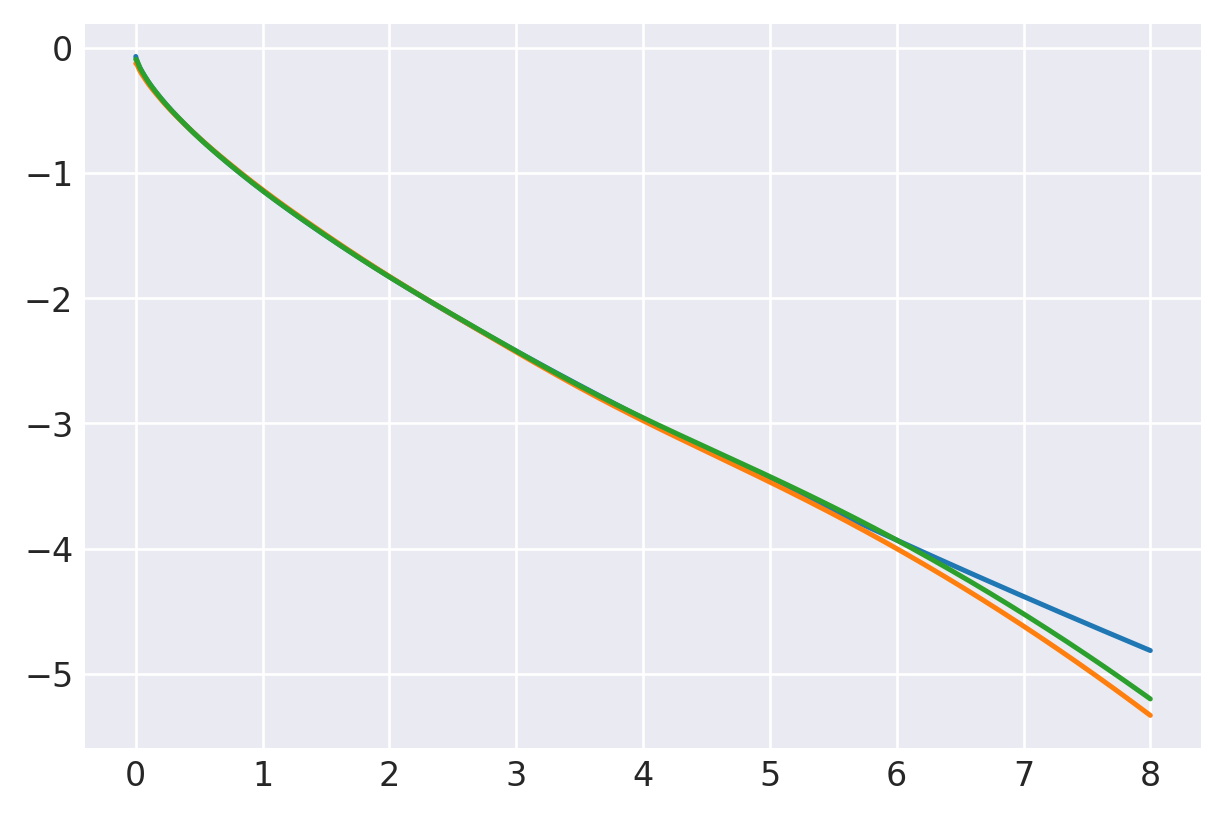

1.4: (
    normalize(np.array([ 1.5044168718e-01, 3.5948092489e-01, 2.9500095594e-01, 1.3848748313e-01, 4.4502579391e-02, 1.0305438155e-02, 1.6397593630e-03, 1.4117196178e-04) ]),
    np.array([ 2.5783347275e+00, 1.4265653404e+00, 8.1391996488e-01, 4.5819475132e-01, 2.4762308233e-01, 1.2449566761e-01, 5.5137669503e-02, 1.8564199068e-02 ]),
),
prev.  chisq = -4.275467082082592


         Current function value: -6.485407
         Iterations: 41
         Function evaluations: 1881
         Gradient evaluations: 110
-6.485407311916186


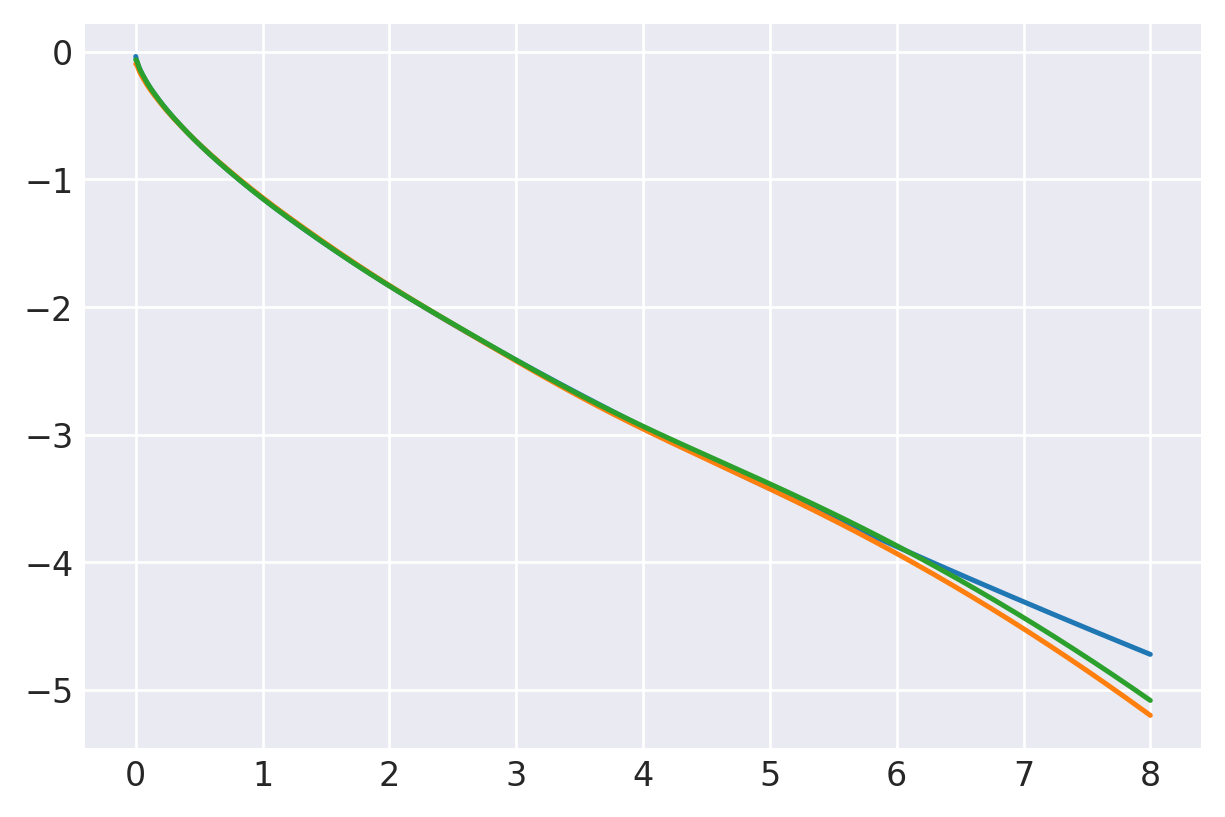

1.45: (
    normalize(np.array([ 1.5375733370e-01, 3.5748985738e-01, 2.9261691584e-01, 1.3859478373e-01, 4.5107587233e-02, 1.0581372171e-02, 1.7037643436e-03, 1.4838560551e-04) ]),
    np.array([ 2.6367899264e+00, 1.4334185398e+00, 8.0780299530e-01, 4.5020328575e-01, 2.4114613075e-01, 1.2021965103e-01, 5.2787284171e-02, 1.7598291132e-02 ]),
),
prev.  chisq = -4.276100266765711


         Current function value: -6.376186
         Iterations: 39
         Function evaluations: 2103
         Gradient evaluations: 123
-6.37618551379477


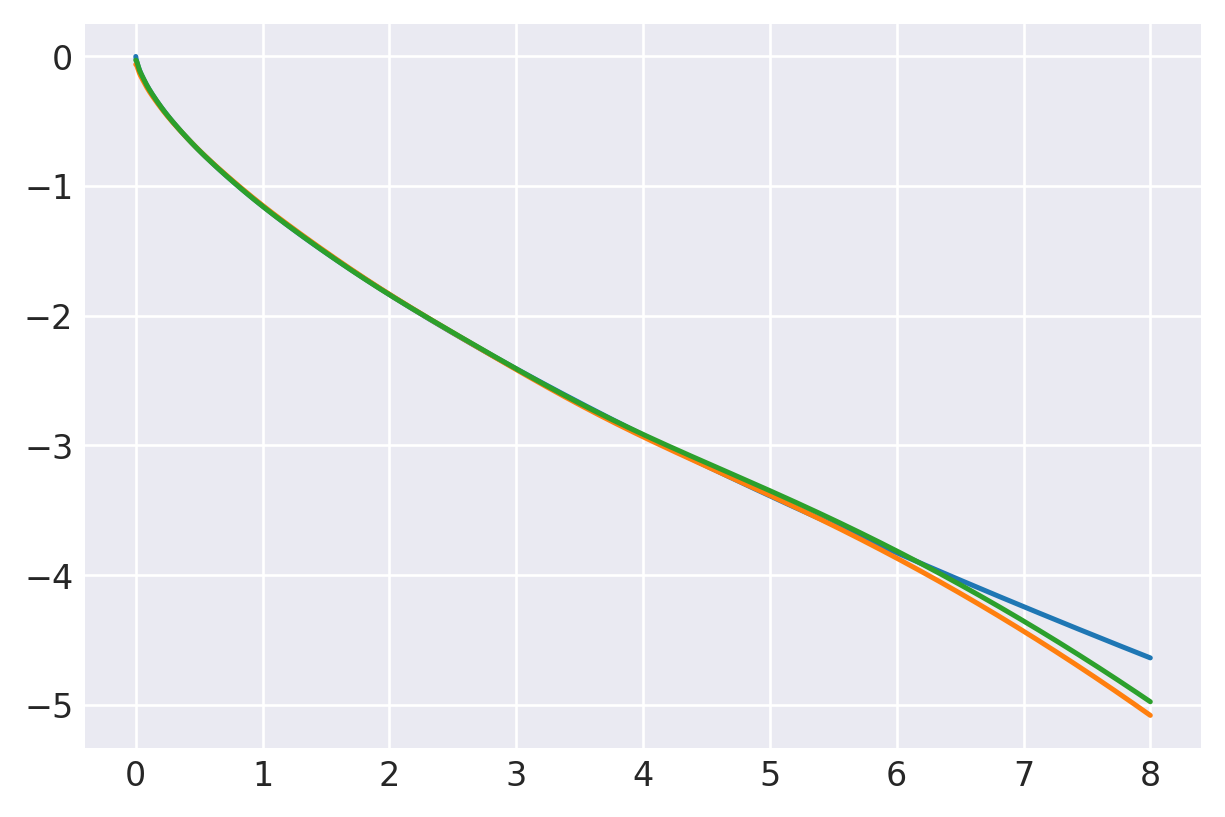

1.5: (
    normalize(np.array([ 1.5725192210e-01, 3.5575521917e-01, 2.9019539578e-01, 1.3847799770e-01, 4.5582669663e-02, 1.0819992568e-02, 1.7616978372e-03, 1.5510518339e-04) ]),
    np.array([ 2.6925321126e+00, 1.4387905675e+00, 8.0116104168e-01, 4.4213591344e-01, 2.3476512752e-01, 1.1607425174e-01, 5.0539516126e-02, 1.6686817425e-02 ]),
),
prev.  chisq = -4.275904421089239


         Current function value: -6.272518
         Iterations: 40
         Function evaluations: 2307
         Gradient evaluations: 135
-6.27251815061023


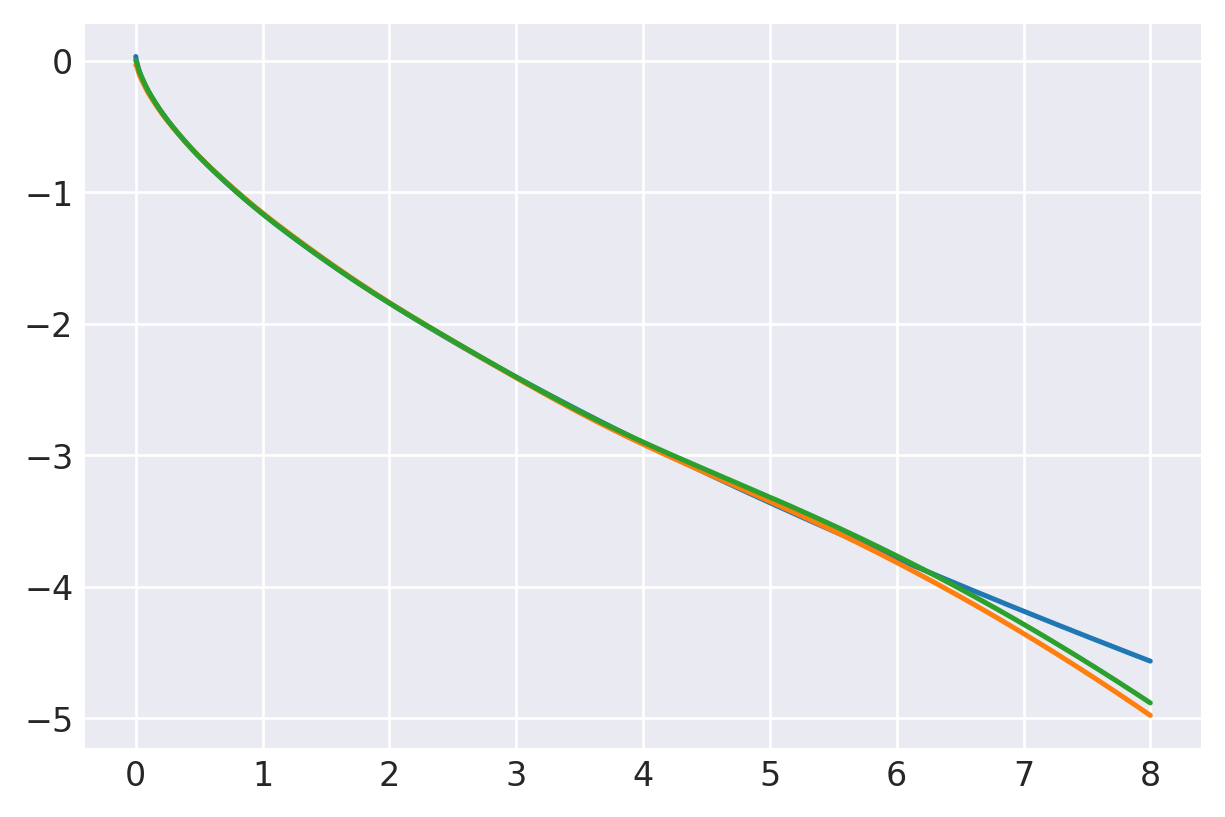

1.55: (
    normalize(np.array([ 1.6092021991e-01, 3.5424621756e-01, 2.8773880831e-01, 1.3815908731e-01, 4.5937895980e-02, 1.1023043946e-02, 1.8134282210e-03, 1.6129875519e-04) ]),
    np.array([ 2.7455159472e+00, 1.4427005768e+00, 7.9400579555e-01, 4.3399691360e-01, 2.2847897620e-01, 1.1205233111e-01, 4.8386645760e-02, 1.5825610525e-02 ]),
),
prev.  chisq = -4.2749066034862215


         Current function value: -6.173849
         Iterations: 35
         Function evaluations: 2018
         Gradient evaluations: 118
-6.173849216412006


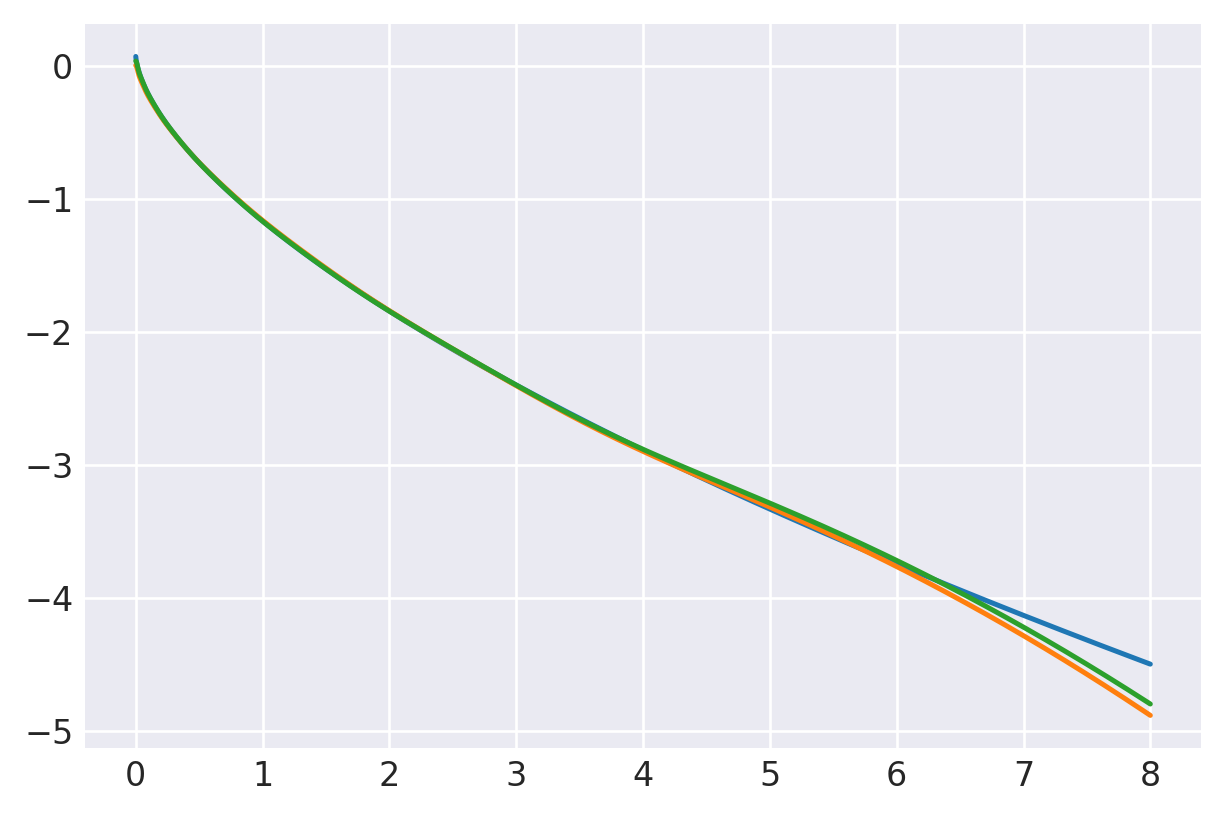

1.6: (
    normalize(np.array([ 1.6472751862e-01, 3.5291720773e-01, 2.8526838324e-01, 1.3767644255e-01, 4.6190121772e-02, 1.1193930942e-02, 1.8594080552e-03, 1.6698709876e-04) ]),
    np.array([ 2.7958587998e+00, 1.4452798413e+00, 7.8641787789e-01, 4.2582771818e-01, 2.2230308018e-01, 1.0815726951e-01, 4.6327242881e-02, 1.5012397064e-02 ]),
),
prev.  chisq = -4.273131188012584


         Current function value: -6.079700
         Iterations: 37
         Function evaluations: 2120
         Gradient evaluations: 124
-6.079699733844062


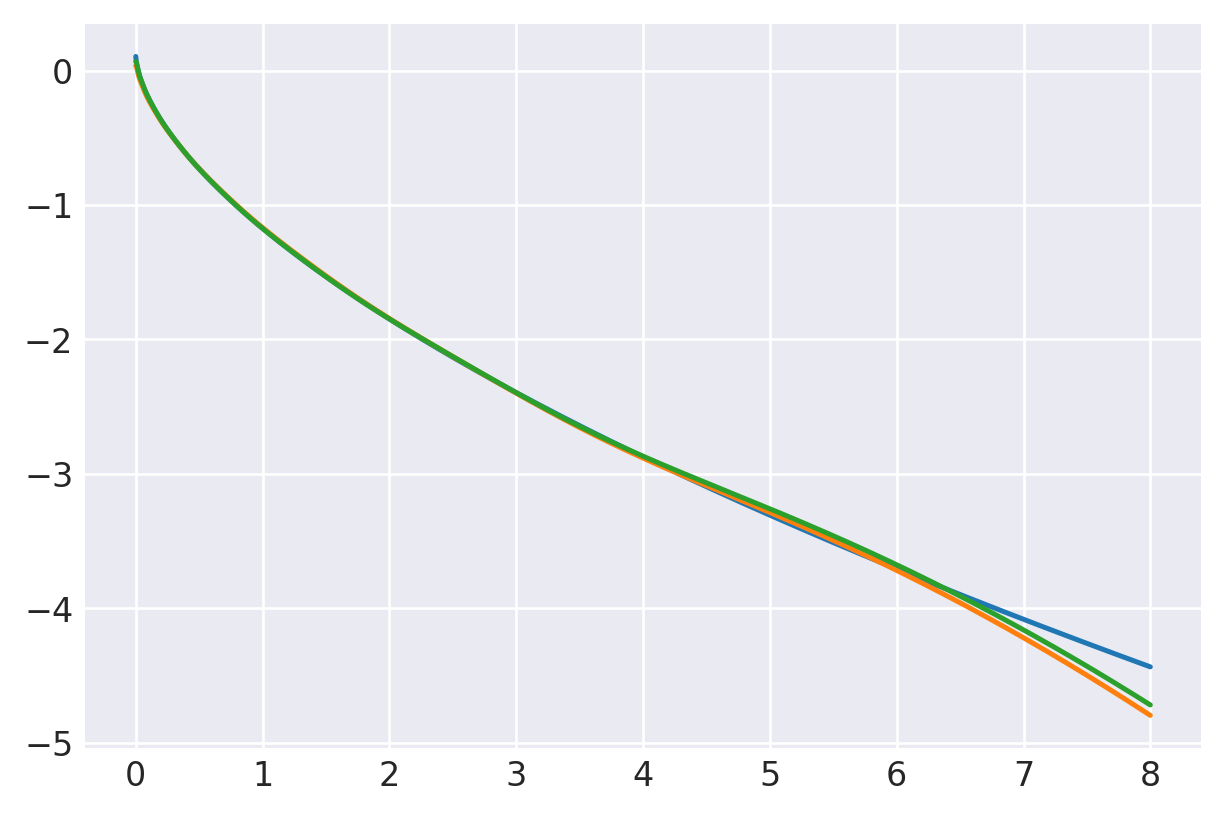

1.65: (
    normalize(np.array([ 1.6865761265e-01, 3.5175248371e-01, 2.8278724459e-01, 1.3704852129e-01, 4.6347963341e-02, 1.1334304402e-02, 1.8997104981e-03, 1.7215952634e-04) ]),
    np.array([ 2.8436280951e+00, 1.4465852482e+00, 7.7841942401e-01, 4.1763567469e-01, 2.1623555424e-01, 1.0438329972e-01, 4.4355478119e-02, 1.4243771341e-02 ]),
),
prev.  chisq = -4.270600047000087


         Current function value: -5.989655
         Iterations: 35
         Function evaluations: 902
         Gradient evaluations: 53
-5.989655442440195


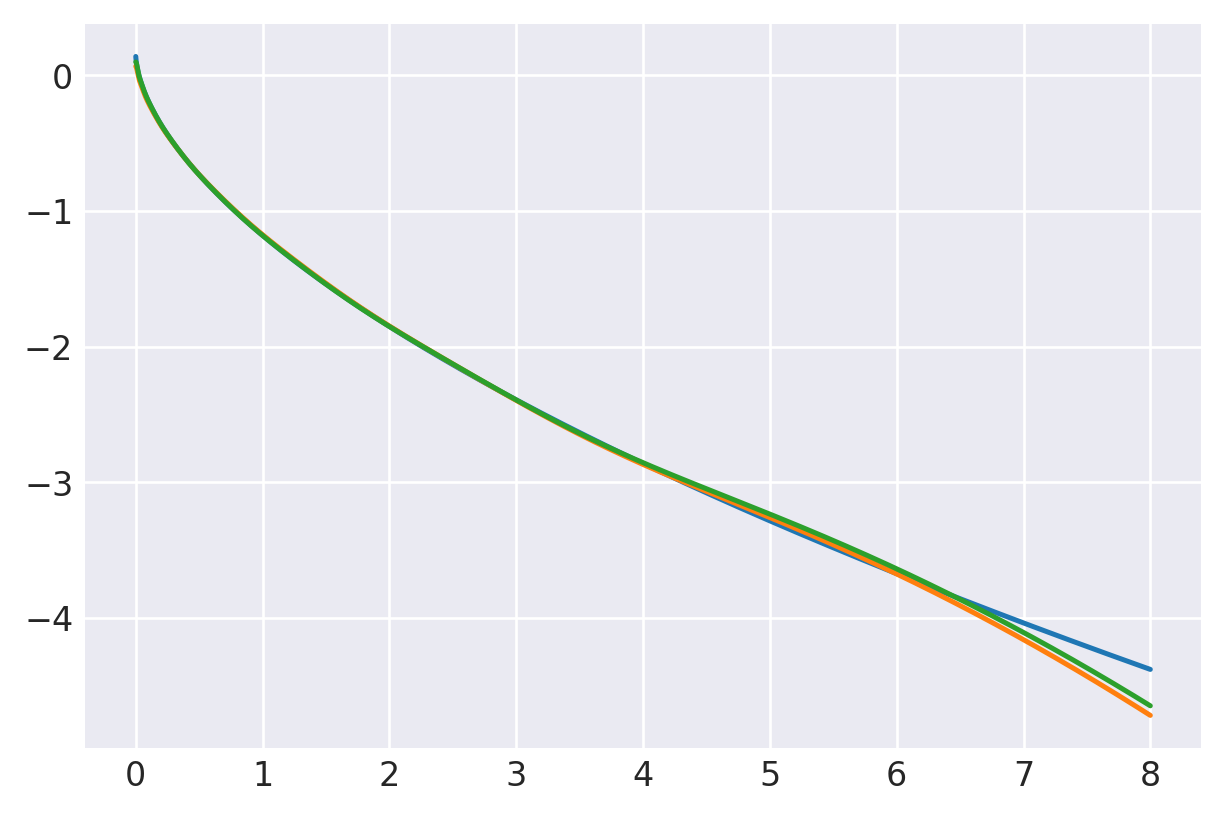

1.7: (
    normalize(np.array([ 1.7268705820e-01, 3.5071087509e-01, 2.8031239368e-01, 1.3630466369e-01, 4.6425424642e-02, 1.1447851747e-02, 1.9348835115e-03, 1.7684943721e-04) ]),
    np.array([ 2.8889186734e+00, 1.4467357236e+00, 7.7008666703e-01, 4.0945625969e-01, 2.1029081175e-01, 1.0073405930e-01, 4.2470615376e-02, 1.3517674998e-02 ]),
),
prev.  chisq = -4.267328743899716


         Current function value: -5.903356
         Iterations: 34
         Function evaluations: 1712
         Gradient evaluations: 100
-5.903356273943155


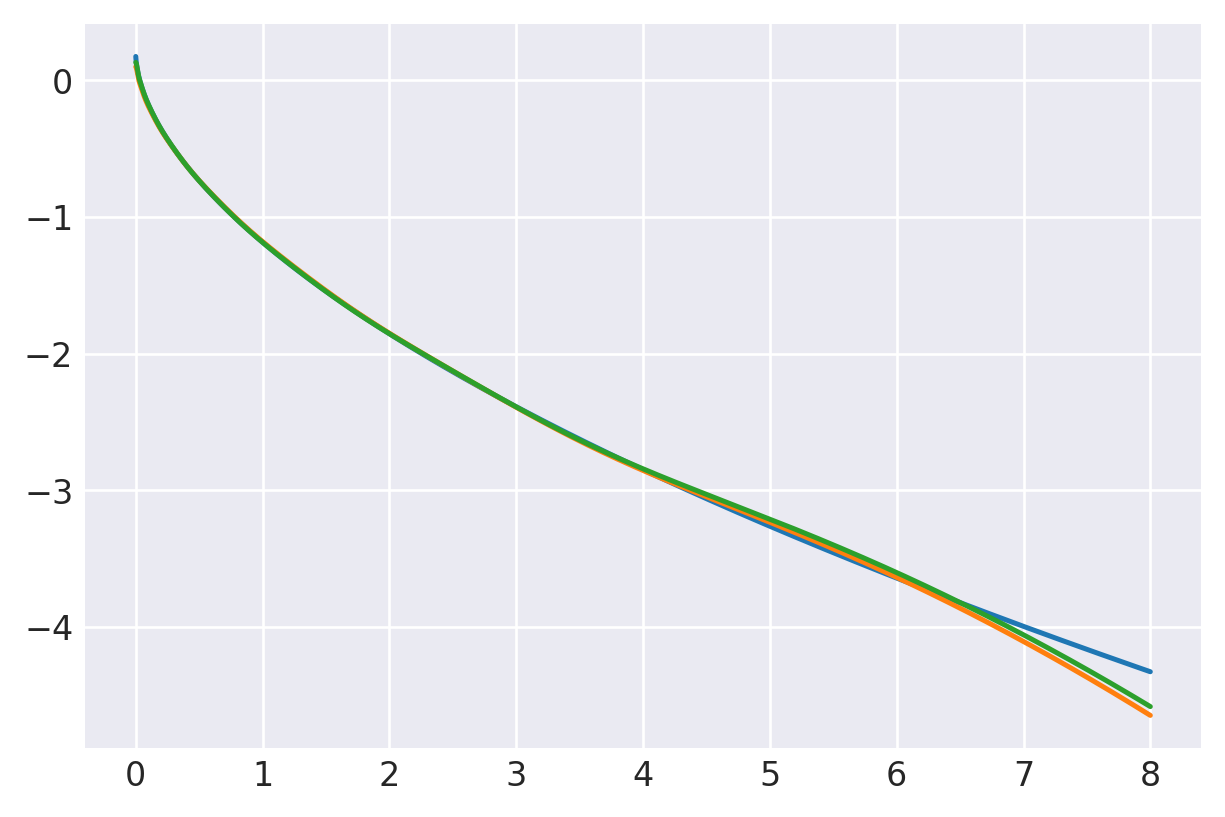

1.75: (
    normalize(np.array([ 1.7680056649e-01, 3.4977533823e-01, 2.7784827840e-01, 1.3546179167e-01, 4.6431156454e-02, 1.1536629730e-02, 1.9651724783e-03, 1.8106654858e-04) ]),
    np.array([ 2.9318162535e+00, 1.4458055015e+00, 7.6145552404e-01, 4.0130323518e-01, 2.0447030335e-01, 9.7206071429e-02, 4.0668434024e-02, 1.2831455759e-02 ]),
),
prev.  chisq = -4.263329364904401


         Current function value: -5.820488
         Iterations: 33
         Function evaluations: 1727
         Gradient evaluations: 101
-5.820487706095754


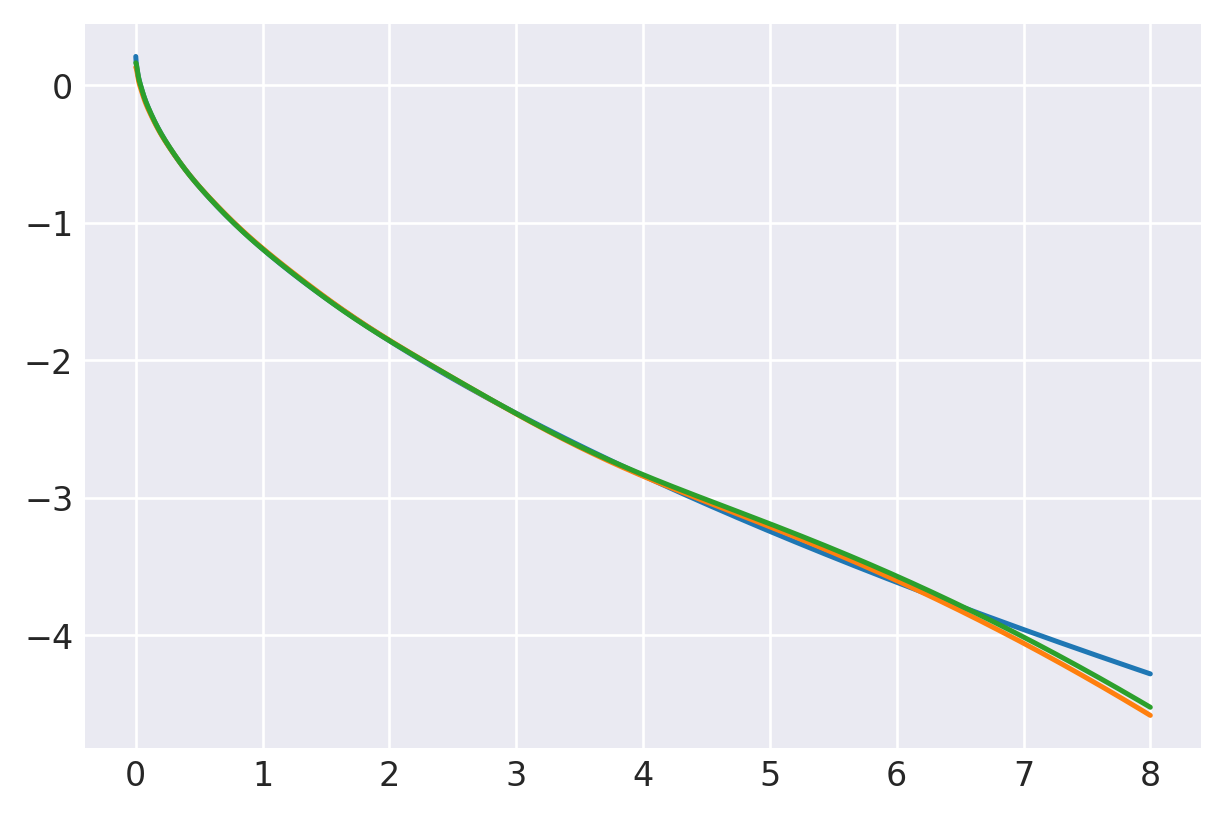

1.8: (
    normalize(np.array([ 1.8098266031e-01, 3.4892902928e-01, 2.7540046948e-01, 1.3453568086e-01, 4.6373623562e-02, 1.1602834016e-02, 1.9908752644e-03, 1.8482722077e-04) ]),
    np.array([ 2.9724159386e+00, 1.4438748567e+00, 7.5256568805e-01, 3.9319190759e-01, 1.9877679270e-01, 9.3796807353e-02, 3.8945432190e-02, 1.2182736396e-02 ]),
),
prev.  chisq = -4.258610661723472


         Current function value: -5.740774
         Iterations: 32
         Function evaluations: 2222
         Gradient evaluations: 130
-5.740773558268081


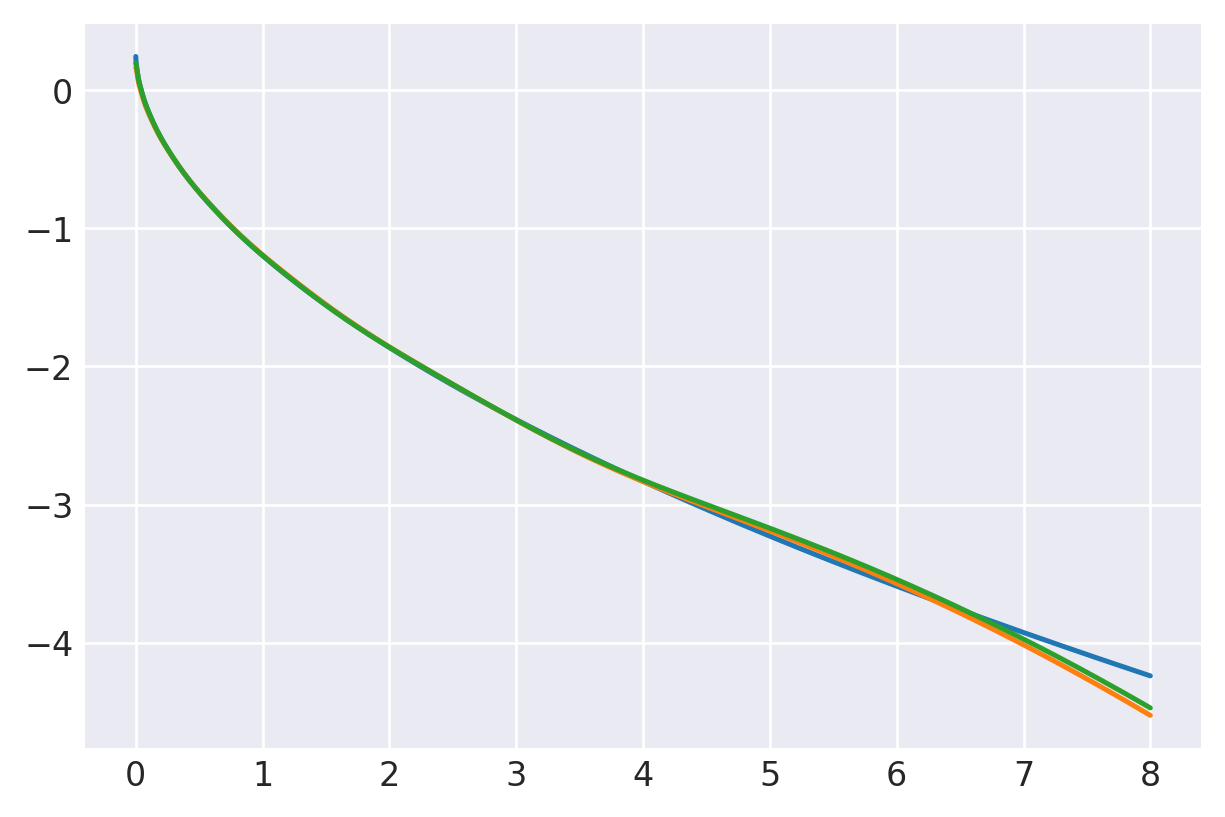

1.85: (
    normalize(np.array([ 1.8522258343e-01, 3.4815633705e-01, 2.7297176201e-01, 1.3353986677e-01, 4.6260386577e-02, 1.1648584439e-02, 2.0123267053e-03, 1.8815301237e-04) ]),
    np.array([ 3.0107946886e+00, 1.4410127014e+00, 7.4345293582e-01, 3.8513612382e-01, 1.9321259670e-01, 9.0504041659e-02, 3.7298553253e-02, 1.1569375698e-02 ]),
),
prev.  chisq = -4.253177878052807


         Current function value: -5.663970
         Iterations: 31
         Function evaluations: 1966
         Gradient evaluations: 115
-5.663970056489034


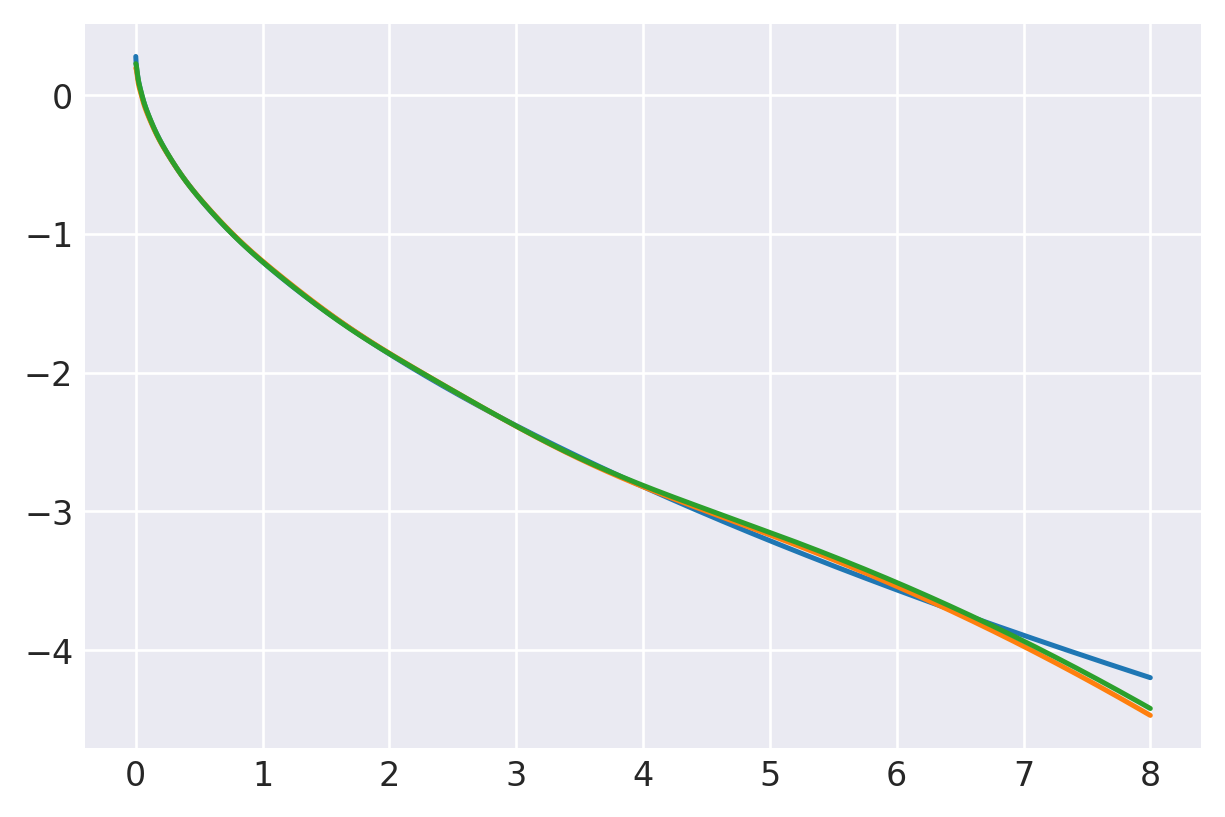

1.9: (
    normalize(np.array([ 1.8950971057e-01, 3.4744481331e-01, 2.7056523366e-01, 1.3248576859e-01, 4.6097960656e-02, 1.1675670879e-02, 2.0297838637e-03, 1.9105846906e-04) ]),
    np.array([ 3.0470361822e+00, 1.4372870329e+00, 7.3414972010e-01, 3.7714682204e-01, 1.8777815448e-01, 8.7324364690e-02, 3.5724182261e-02, 1.0989138517e-02 ]),
),
prev.  chisq = -4.247037048477298


         Current function value: -5.589861
         Iterations: 29
         Function evaluations: 1610
         Gradient evaluations: 94
-5.589860956453506


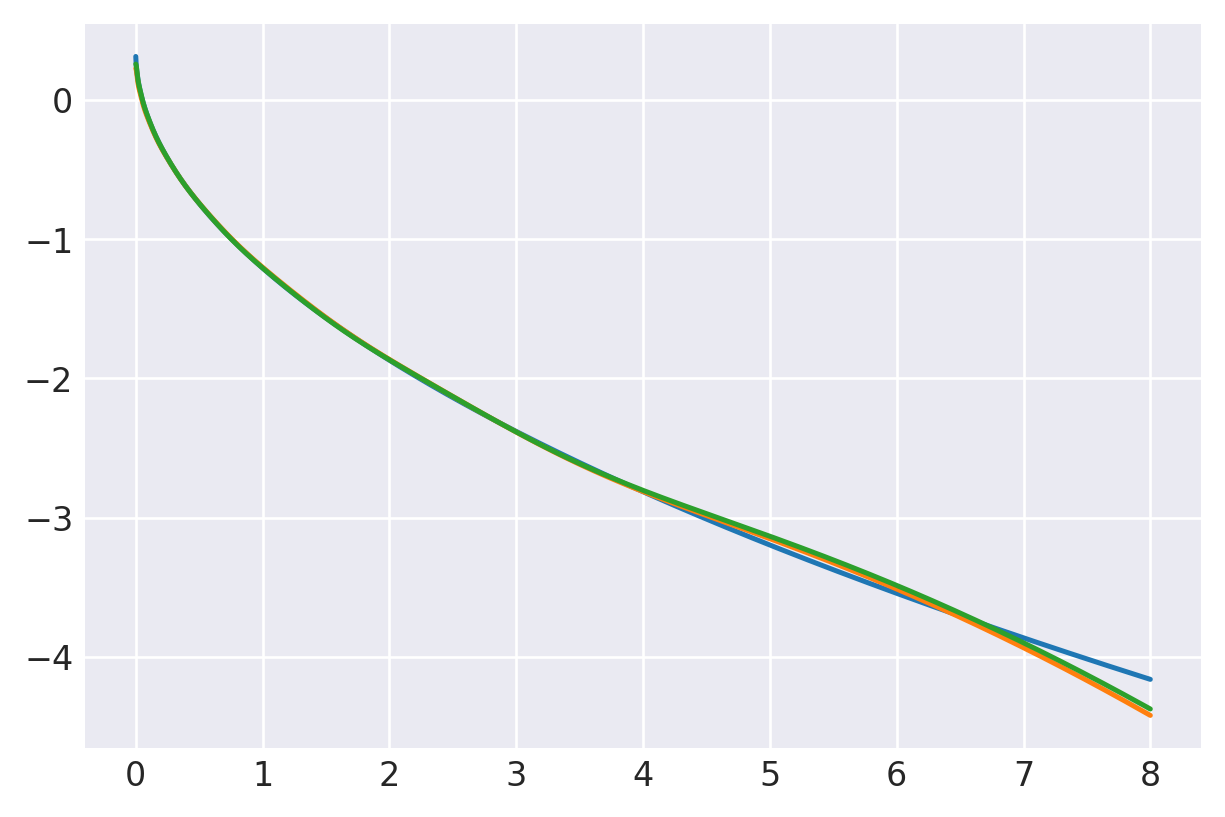

1.95: (
    normalize(np.array([ 1.9383556720e-01, 3.4678433327e-01, 2.6818228405e-01, 1.3138284445e-01, 4.5892048758e-02, 1.1685817791e-02, 2.0435373395e-03, 1.9356713656e-04) ]),
    np.array([ 3.0812166081e+00, 1.4327583697e+00, 7.2468435389e-01, 3.6923334148e-01, 1.8247368167e-01, 8.4254868801e-02, 3.4219267629e-02, 1.0440244755e-02 ]),
),
prev.  chisq = -4.240188251408961


         Current function value: -5.518254
         Iterations: 31
         Function evaluations: 1950
         Gradient evaluations: 114
-5.5182535372977775


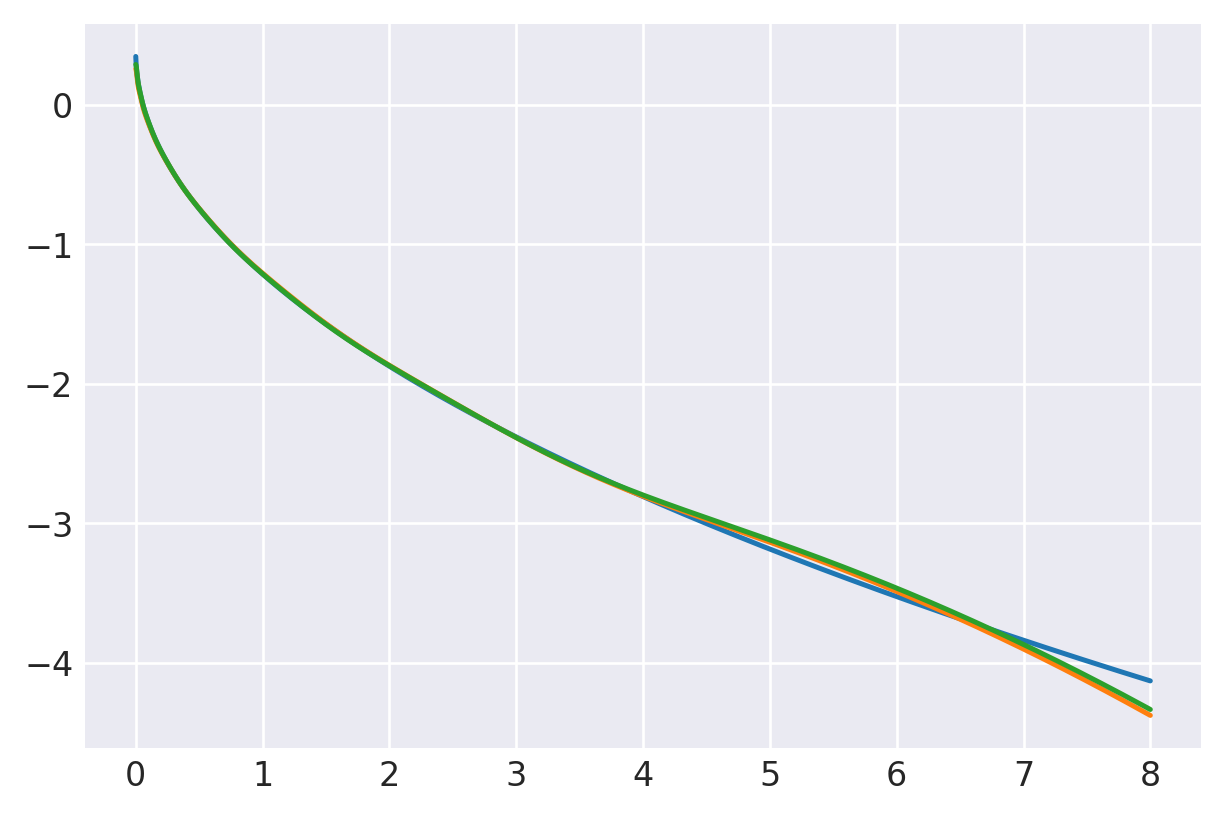

2.0: (
    normalize(np.array([ 1.9819445790e-01, 3.4616632310e-01, 2.6582315113e-01, 1.3023848560e-01, 4.5647583353e-02, 1.1680490332e-02, 2.0538172735e-03, 1.9569131623e-04) ]),
    np.array([ 3.1133995025e+00, 1.4274775617e+00, 7.1508006584e-01, 3.6140250217e-01, 1.7729816439e-01, 8.1291857346e-02, 3.2780402060e-02, 9.9206032077e-03 ]),
),
prev.  chisq = -4.231939712709011


         Current function value: -5.439583
         Iterations: 29
         Function evaluations: 2137
         Gradient evaluations: 125
-5.439583483825132


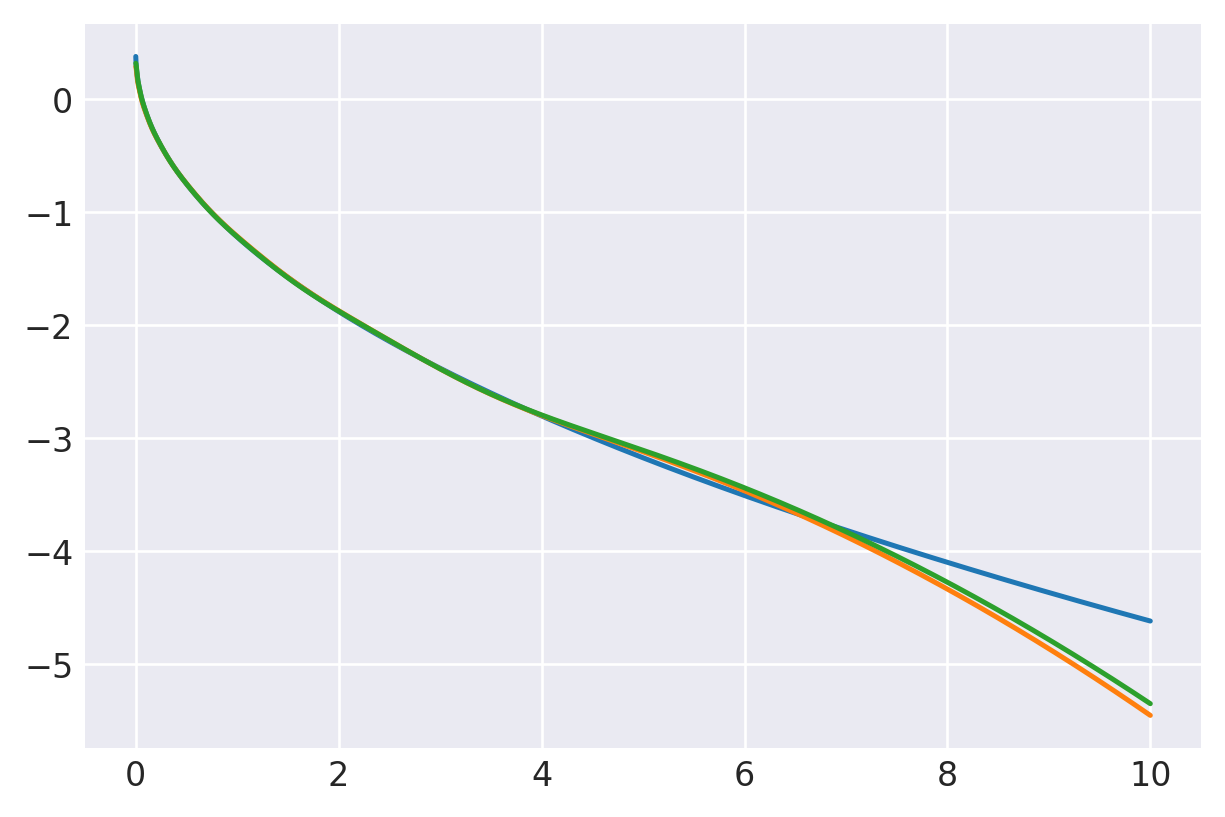

2.05: (
    normalize(np.array([ 1.9841639842e-01, 3.4552850257e-01, 2.6547667345e-01, 1.3049530201e-01, 4.5963295608e-02, 1.1827549903e-02, 2.0917735253e-03, 2.0050451445e-04) ]),
    np.array([ 3.1754954144e+00, 1.4351000951e+00, 7.1133487007e-01, 3.5640066063e-01, 1.7350408555e-01, 7.8977718682e-02, 3.1615889036e-02, 9.4905311872e-03 ]),
),
prev.  chisq = -4.223720791843406


         Current function value: -5.372714
         Iterations: 28
         Function evaluations: 1576
         Gradient evaluations: 92
-5.3727144411241525


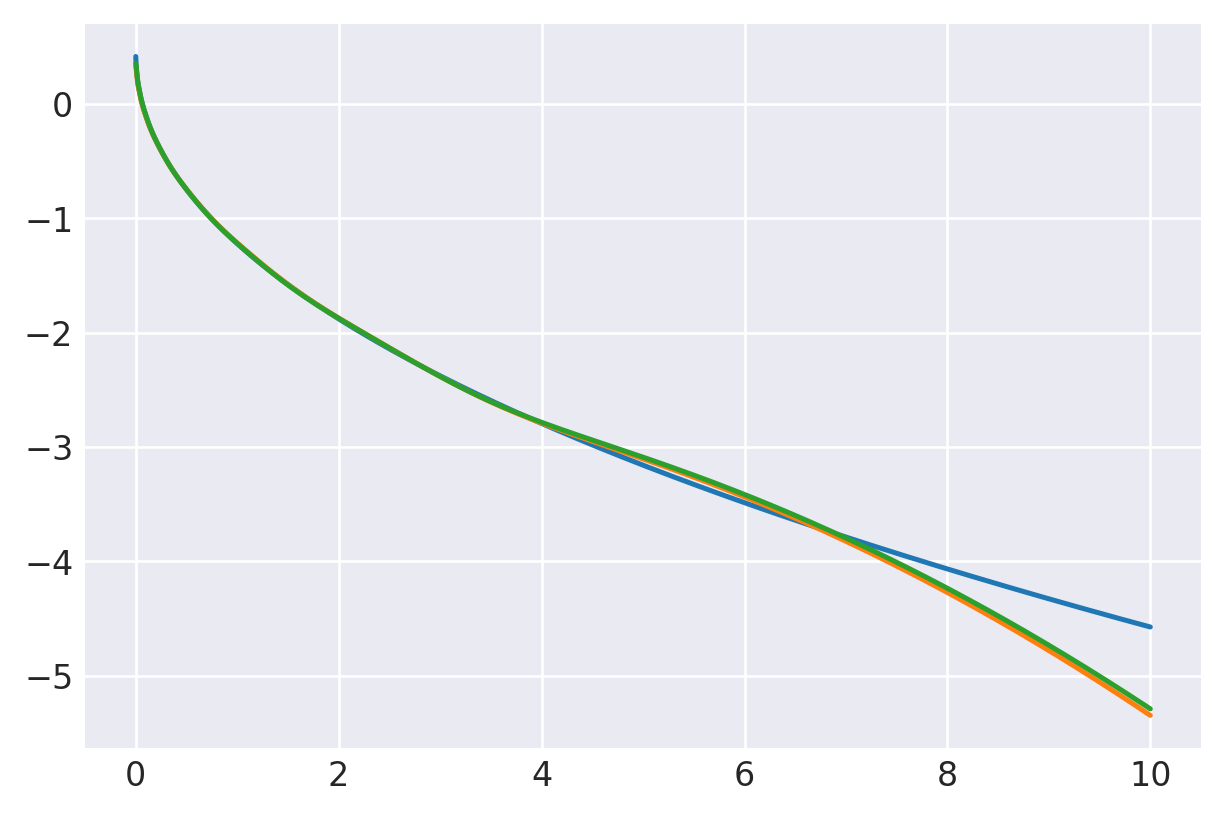

2.1: (
    normalize(np.array([ 2.0268907011e-01, 3.4504543687e-01, 2.6320514184e-01, 1.2930289058e-01, 4.5661139744e-02, 1.1797867544e-02, 2.0964537453e-03, 2.0199956974e-04) ]),
    np.array([ 3.2056650982e+00, 1.4289278568e+00, 7.0163831706e-01, 3.4877966705e-01, 1.6858385430e-01, 7.6213736661e-02, 3.0297052150e-02, 9.0229979139e-03 ]),
),
prev.  chisq = -4.214699479892549


         Current function value: -5.307903
         Iterations: 26
         Function evaluations: 1848
         Gradient evaluations: 108
-5.307902942043199


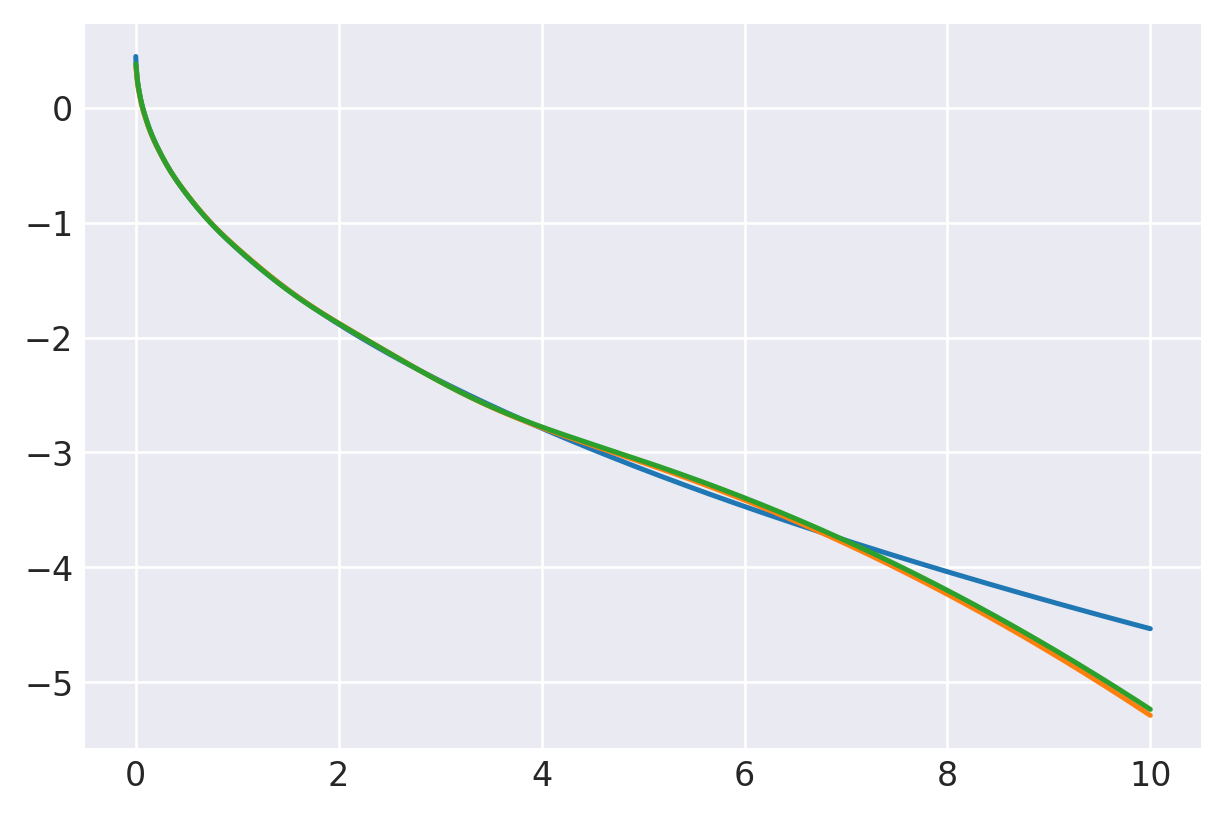

2.15: (
    normalize(np.array([ 2.0699941245e-01, 3.4458653604e-01, 2.6094800959e-01, 1.2807982902e-01, 4.5329287109e-02, 1.1755617034e-02, 2.0981598049e-03, 2.0314896346e-04) ]),
    np.array([ 3.2338917092e+00, 1.4220733890e+00, 6.9183262619e-01, 3.4124348586e-01, 1.6378207301e-01, 7.3543652634e-02, 2.9034571257e-02, 8.5796768381e-03 ]),
),
prev.  chisq = -4.204972299631006


         Current function value: -5.245015
         Iterations: 30
         Function evaluations: 1746
         Gradient evaluations: 102
-5.2450150841765115


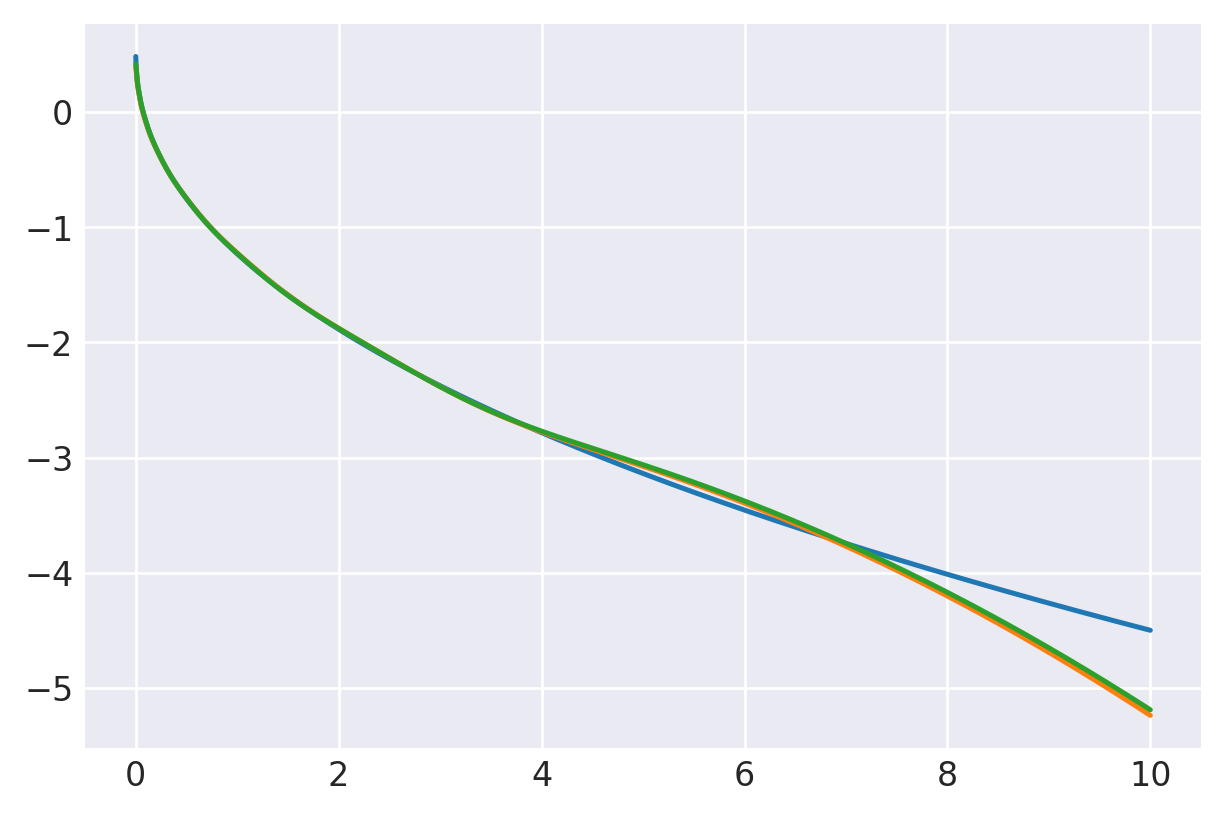

2.2: (
    normalize(np.array([ 2.1134588764e-01, 3.4414657478e-01, 2.5870473892e-01, 1.2682968533e-01, 4.4970324671e-02, 1.1701760454e-02, 2.0970667805e-03, 2.0396142059e-04) ]),
    np.array([ 3.2602089709e+00, 1.4145697215e+00, 6.8193175827e-01, 3.3379386746e-01, 1.5909609525e-01, 7.0963835163e-02, 2.7825649093e-02, 8.1590363116e-03 ]),
),
prev.  chisq = -4.1945491090510885


         Current function value: -5.183930
         Iterations: 31
         Function evaluations: 1559
         Gradient evaluations: 91
-5.1839301612186715


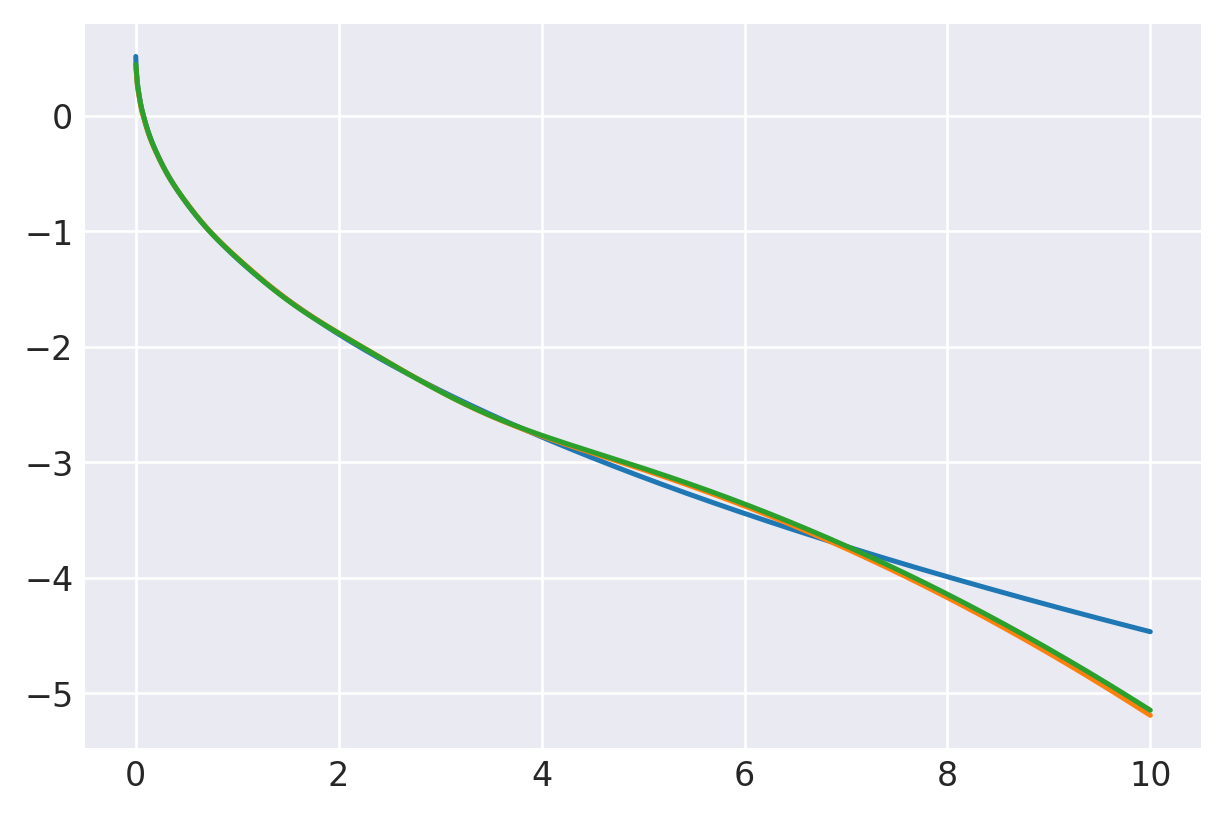

2.25: (
    normalize(np.array([ 2.1572257902e-01, 3.4372053532e-01, 2.5647605244e-01, 1.2555772486e-01, 4.4587805915e-02, 1.1637436303e-02, 2.0934043196e-03, 2.0446183005e-04) ]),
    np.array([ 3.2846870547e+00, 1.4064645896e+00, 6.7195657294e-01, 3.2643731029e-01, 1.5452546426e-01, 6.8471913697e-02, 2.6668143489e-02, 7.7599078382e-03 ]),
),
prev.  chisq = -4.183431297950389


         Current function value: -5.124539
         Iterations: 27
         Function evaluations: 1746
         Gradient evaluations: 102
-5.1245392784738035


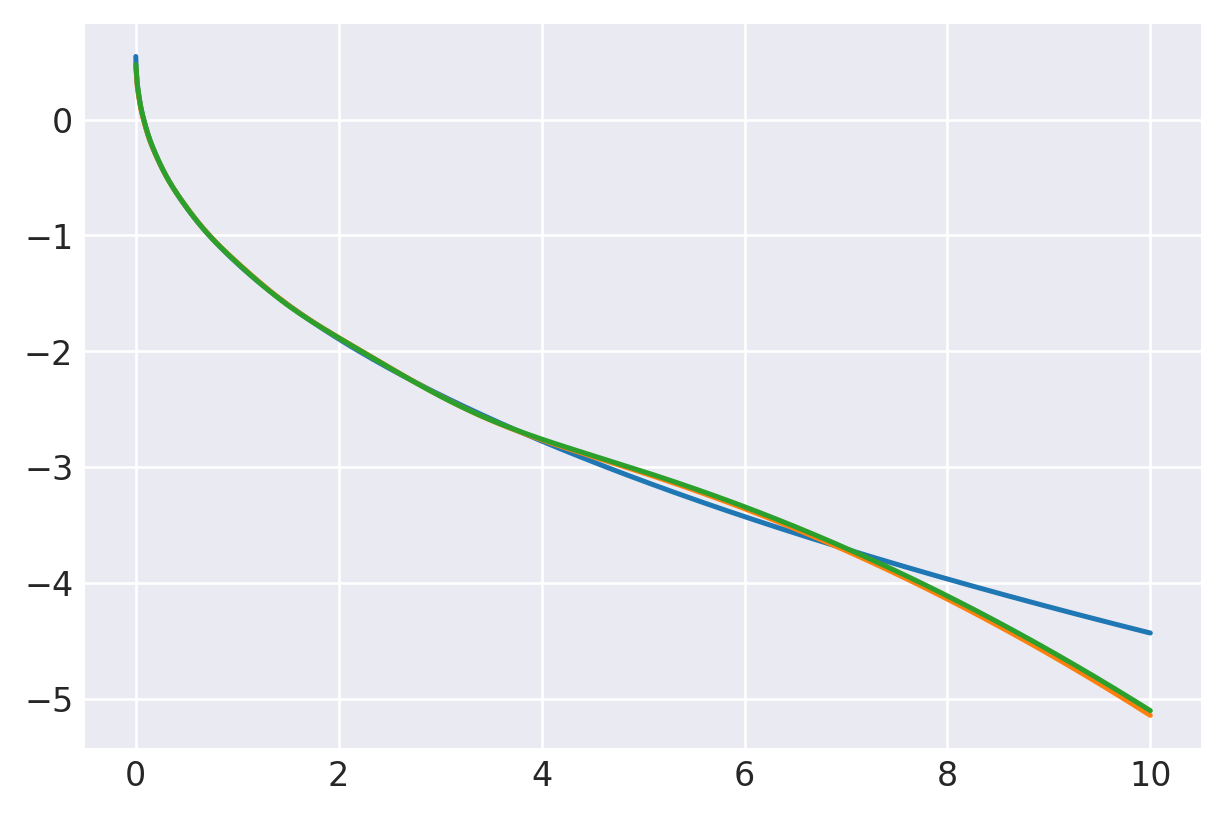

2.3: (
    normalize(np.array([ 2.2012684040e-01, 3.4330418016e-01, 2.5426168977e-01, 1.2426730894e-01, 4.4184361666e-02, 1.1563606949e-02, 2.0873473113e-03, 2.0466480581e-04) ]),
    np.array([ 3.3073691211e+00, 1.3977942685e+00, 6.6192194384e-01, 3.1917700756e-01, 1.5006851237e-01, 6.6064935023e-02, 2.5559651152e-02, 7.3810508698e-03 ]),
),
prev.  chisq = -4.171625351536326


         Current function value: -5.066744
         Iterations: 28
         Function evaluations: 2018
         Gradient evaluations: 118
-5.066744159528947


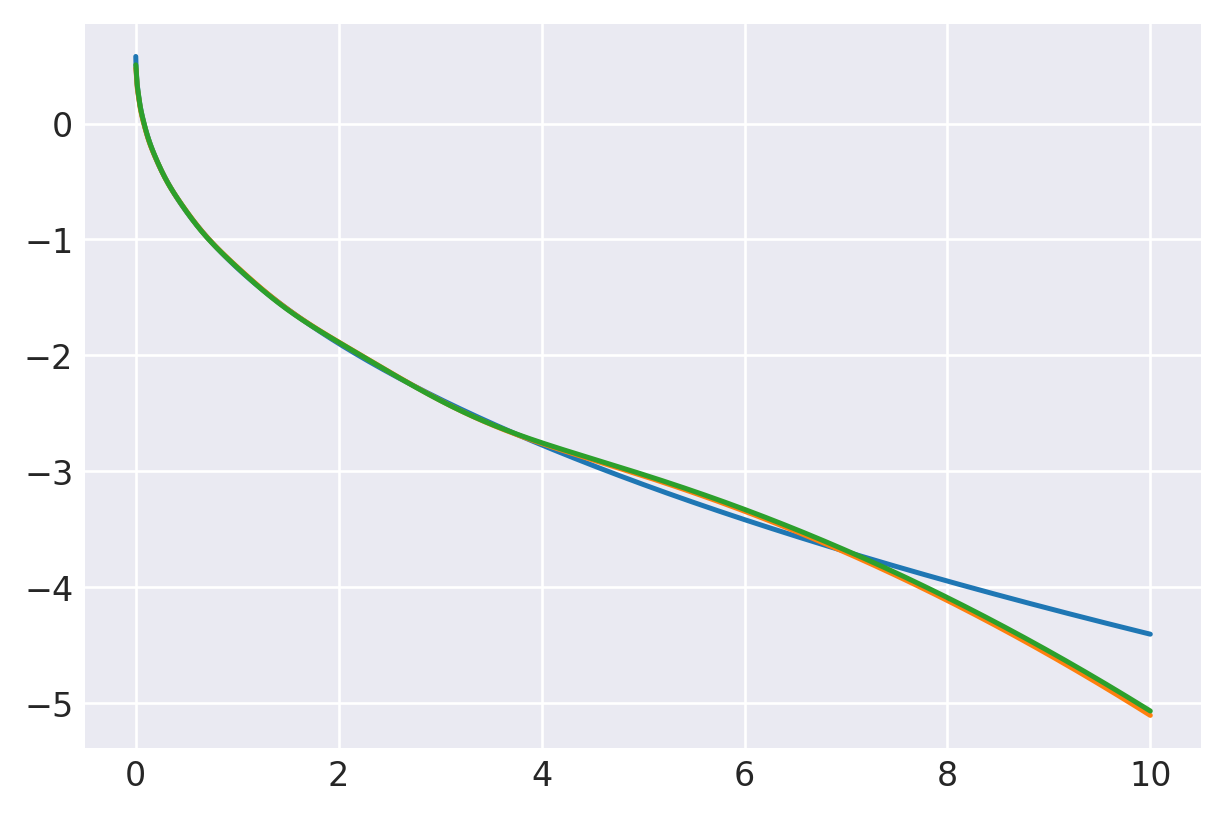

2.35: (
    normalize(np.array([ 2.2455552189e-01, 3.4289382308e-01, 2.5206161623e-01, 1.2296186334e-01, 4.3762390024e-02, 1.1481121651e-02, 2.0790762328e-03, 2.0458755482e-04) ]),
    np.array([ 3.3283069651e+00, 1.3885952088e+00, 6.5184304309e-01, 3.1201600916e-01, 1.4572339363e-01, 6.3740092995e-02, 2.4498004043e-02, 7.0213427774e-03 ]),
),
prev.  chisq = -4.159138199385988


         Current function value: -5.010456
         Iterations: 25
         Function evaluations: 1779
         Gradient evaluations: 104
-5.010456113717302


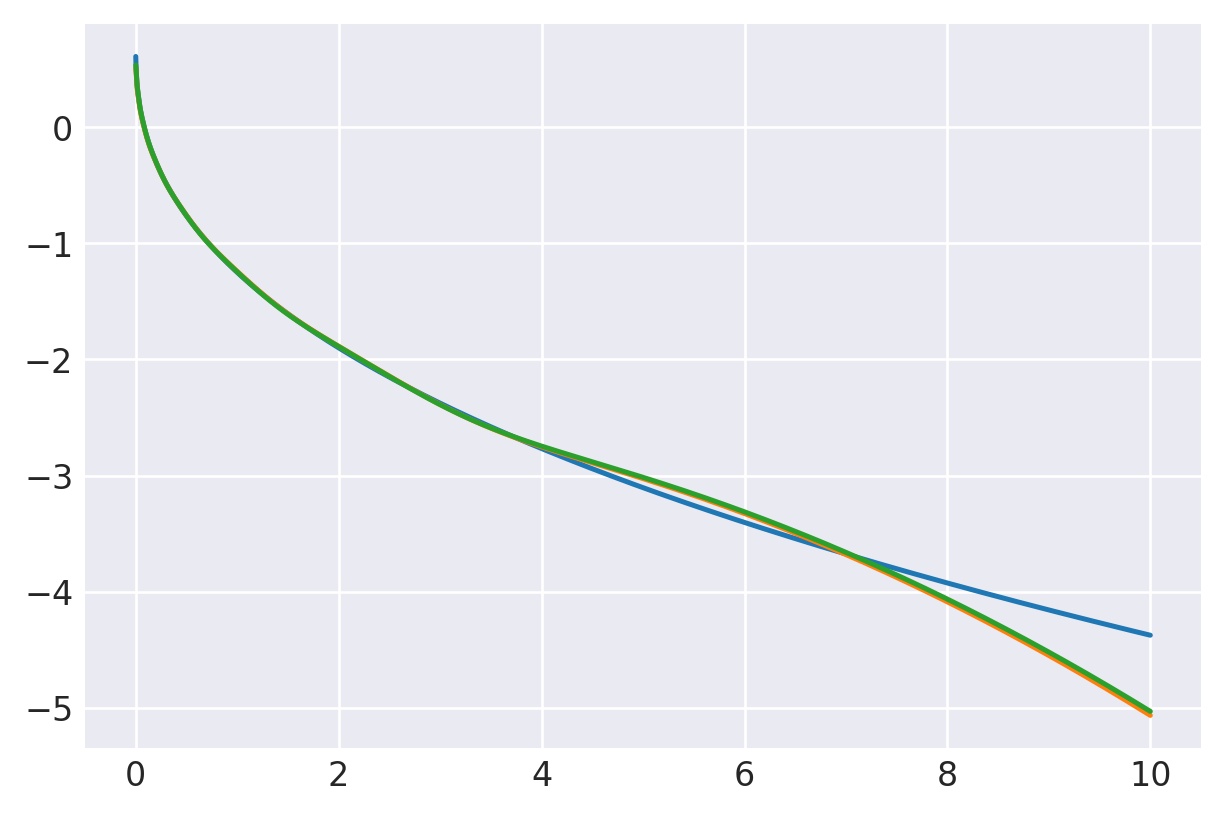

2.4: (
    normalize(np.array([ 2.2900586985e-01, 3.4248595494e-01, 2.4987575278e-01, 1.2164437015e-01, 4.3324236931e-02, 1.1390822691e-02, 2.0687496422e-03, 2.0424300720e-04) ]),
    np.array([ 3.3475475595e+00, 1.3789025838e+00, 6.4173411573e-01, 3.0495739399e-01, 1.4148850404e-01, 6.1494669880e-02, 2.3481025095e-02, 6.6796663859e-03 ]),
),
prev.  chisq = -4.145977925979901


         Current function value: -4.955595
         Iterations: 26
         Function evaluations: 1423
         Gradient evaluations: 83
-4.9555951423513624


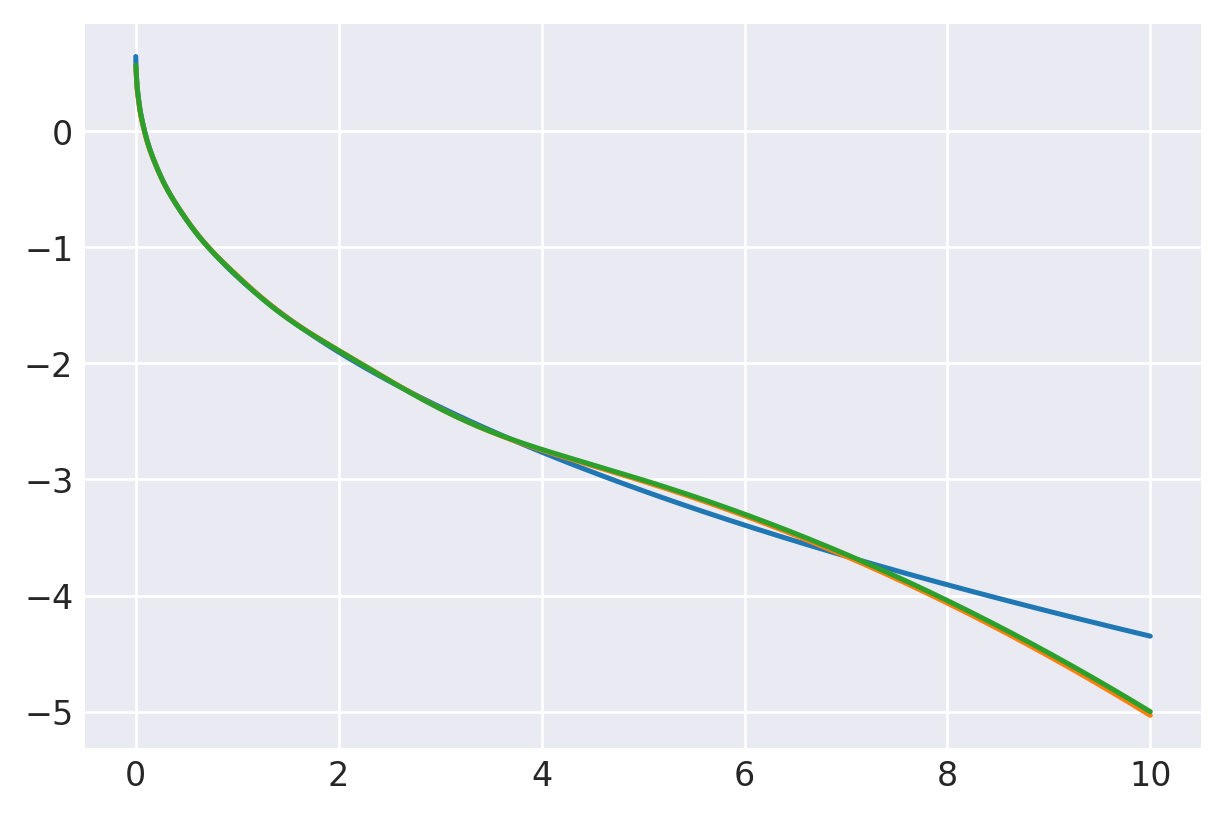

2.45: (
    normalize(np.array([ 2.3347496578e-01, 3.4207855055e-01, 2.4770412764e-01, 1.2031716963e-01, 4.2871629393e-02, 1.1293387754e-02, 2.0565218844e-03, 2.0364736830e-04) ]),
    np.array([ 3.3651455515e+00, 1.3687496985e+00, 6.3160691384e-01, 2.9800243567e-01, 1.3736151103e-01, 5.9325874523e-02, 2.2506744581e-02, 6.3550516071e-03 ]),
),
prev.  chisq = -4.1321564326364175


         Current function value: -4.902089
         Iterations: 25
         Function evaluations: 1712
         Gradient evaluations: 100
-4.902089165926589


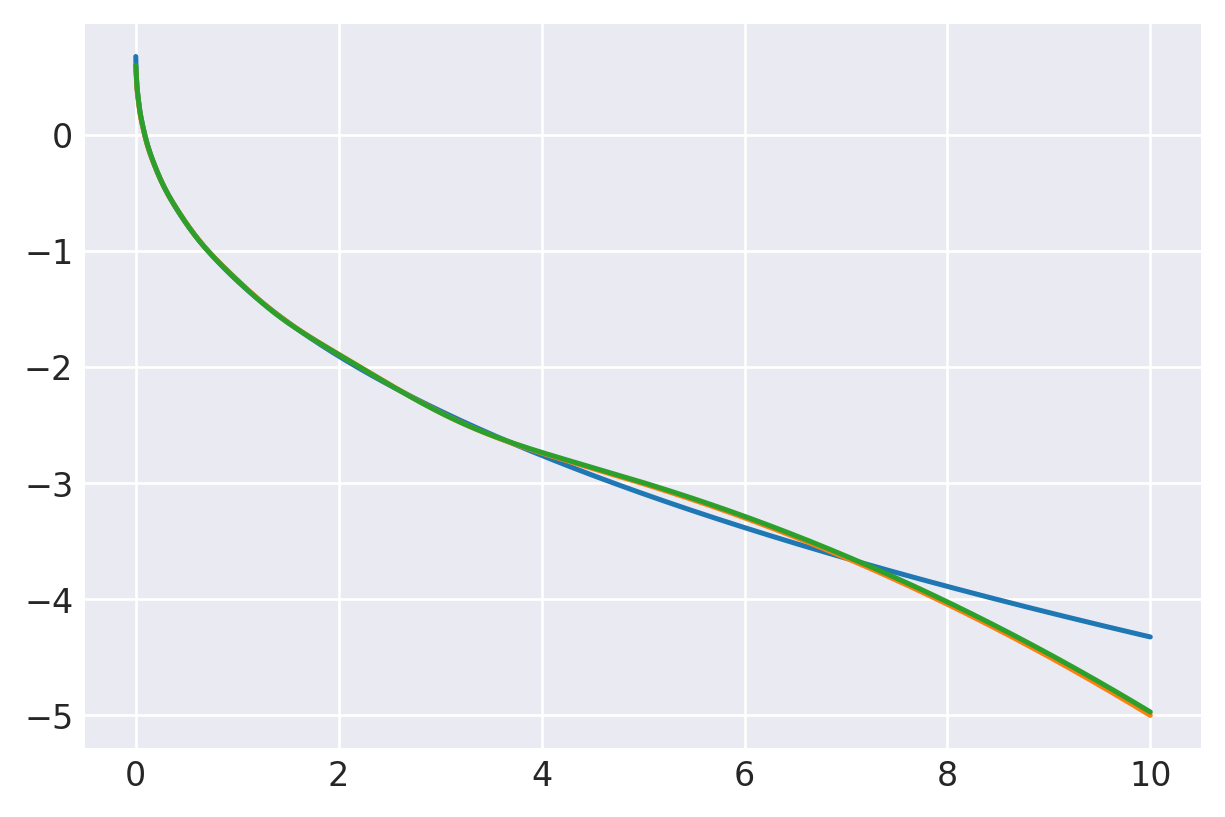

2.5: (
    normalize(np.array([ 2.3796102595e-01, 3.4166843601e-01, 2.4554623701e-01, 1.1898275274e-01, 4.2406617244e-02, 1.1189568399e-02, 2.0425465014e-03, 2.0281614100e-04) ]),
    np.array([ 3.3811415596e+00, 1.3581670278e+00, 6.2147412524e-01, 2.9115387618e-01, 1.3334087895e-01, 5.7231305378e-02, 2.1573263420e-02, 6.0465663102e-03 ]),
),
prev.  chisq = -4.117686890321223


         Current function value: -4.849873
         Iterations: 23
         Function evaluations: 1763
         Gradient evaluations: 103
-4.849873353092421


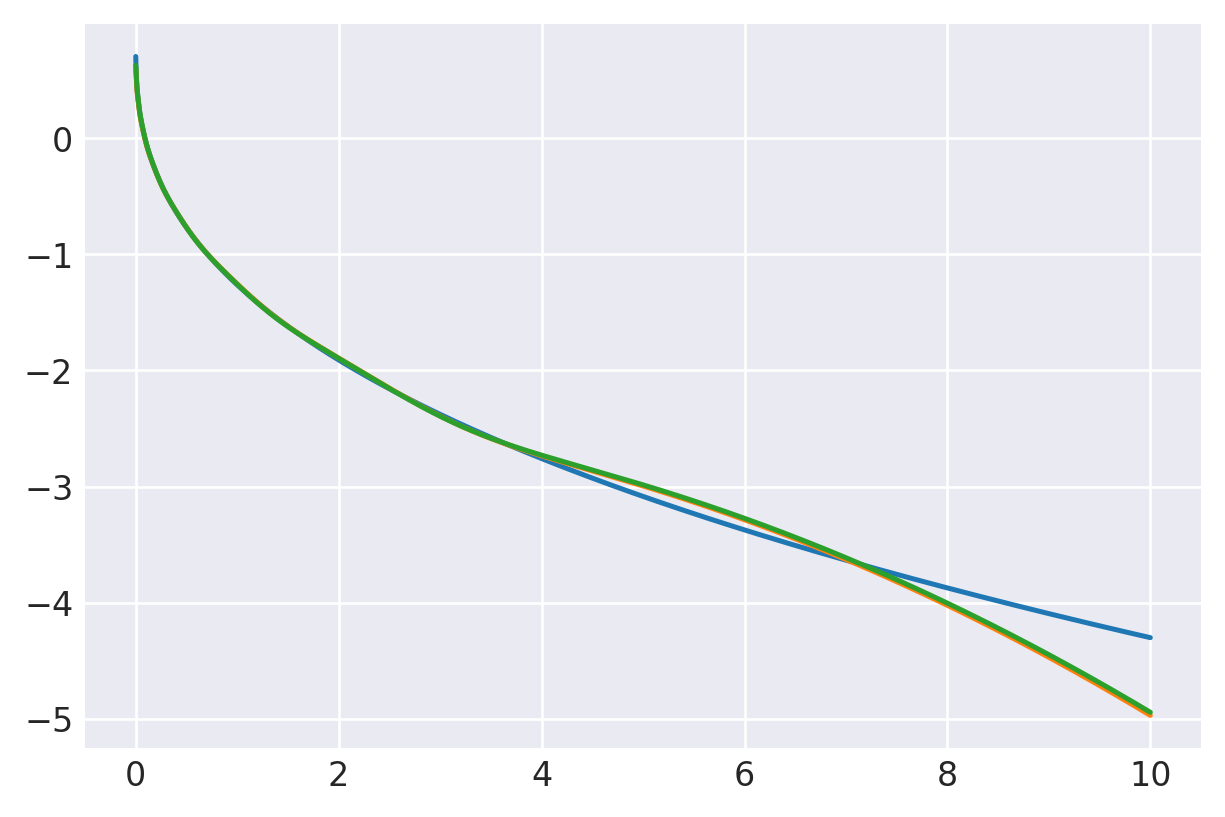

2.55: (
    normalize(np.array([ 2.4246162101e-01, 3.4125370515e-01, 2.4340200229e-01, 1.1764313836e-01, 4.1930824374e-02, 1.1079993358e-02, 2.0269530637e-03, 2.0176239935e-04) ]),
    np.array([ 3.3955834126e+00, 1.3471854599e+00, 6.1134672427e-01, 2.8441312355e-01, 1.2942456929e-01, 5.5208377732e-02, 2.0678734587e-02, 5.7533138198e-03 ]),
),
prev.  chisq = -4.102586259098327


         Current function value: -4.798890
         Iterations: 24
         Function evaluations: 1491
         Gradient evaluations: 87
-4.798889538509089


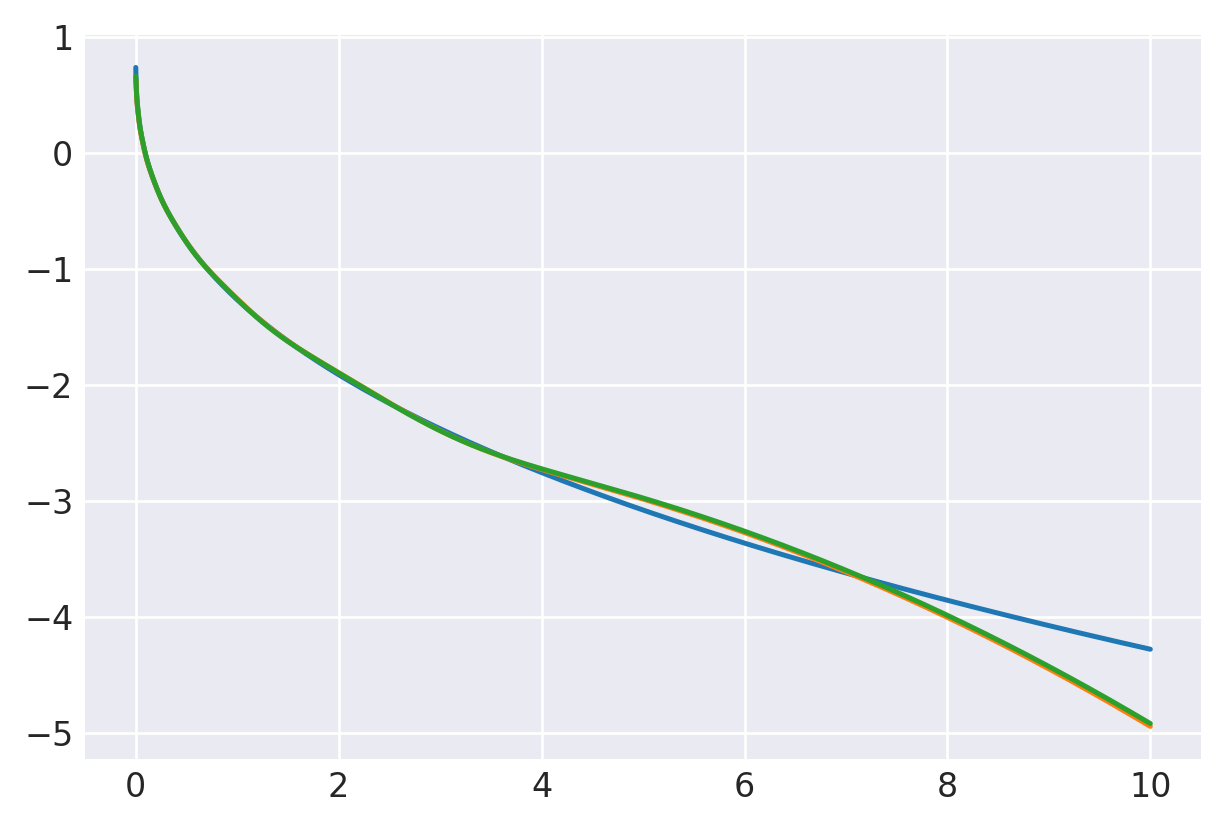

2.6: (
    normalize(np.array([ 2.4697537071e-01, 3.4083271342e-01, 2.4127118800e-01, 1.1629974565e-01, 4.1445439657e-02, 1.0965165935e-02, 2.0098765696e-03, 2.0050006168e-04) ]),
    np.array([ 3.4085183023e+00, 1.3358308262e+00, 6.0123337322e-01, 2.7778036797e-01, 1.2561005526e-01, 5.3254586917e-02, 1.9821446037e-02, 5.4744904933e-03 ]),
),
prev.  chisq = -4.086869498396264


         Current function value: -4.749086
         Iterations: 24
         Function evaluations: 1338
         Gradient evaluations: 78
-4.7490857162908044


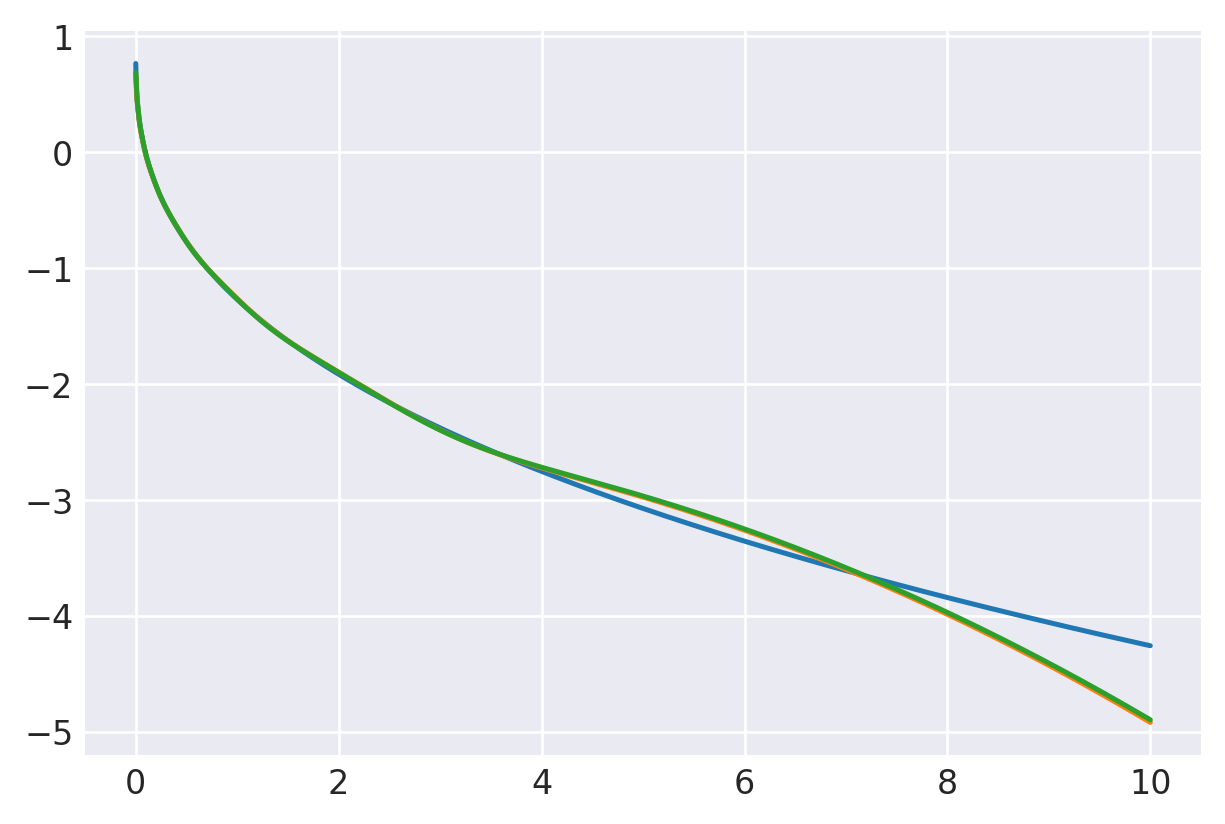

2.65: (
    normalize(np.array([ 2.5150125502e-01, 3.4040354206e-01, 2.3915297336e-01, 1.1495416750e-01, 4.0951947441e-02, 1.0845652581e-02, 1.9914213914e-03, 1.9904063796e-04) ]),
    np.array([ 3.4199785411e+00, 1.3241283309e+00, 5.9114319803e-01, 2.7125683019e-01, 1.2189545594e-01, 5.1367508504e-02, 1.8999679545e-02, 5.2092882024e-03 ]),
),
prev.  chisq = -4.07056072477082


         Current function value: -4.700416
         Iterations: 22
         Function evaluations: 1576
         Gradient evaluations: 92
-4.7004155977728725


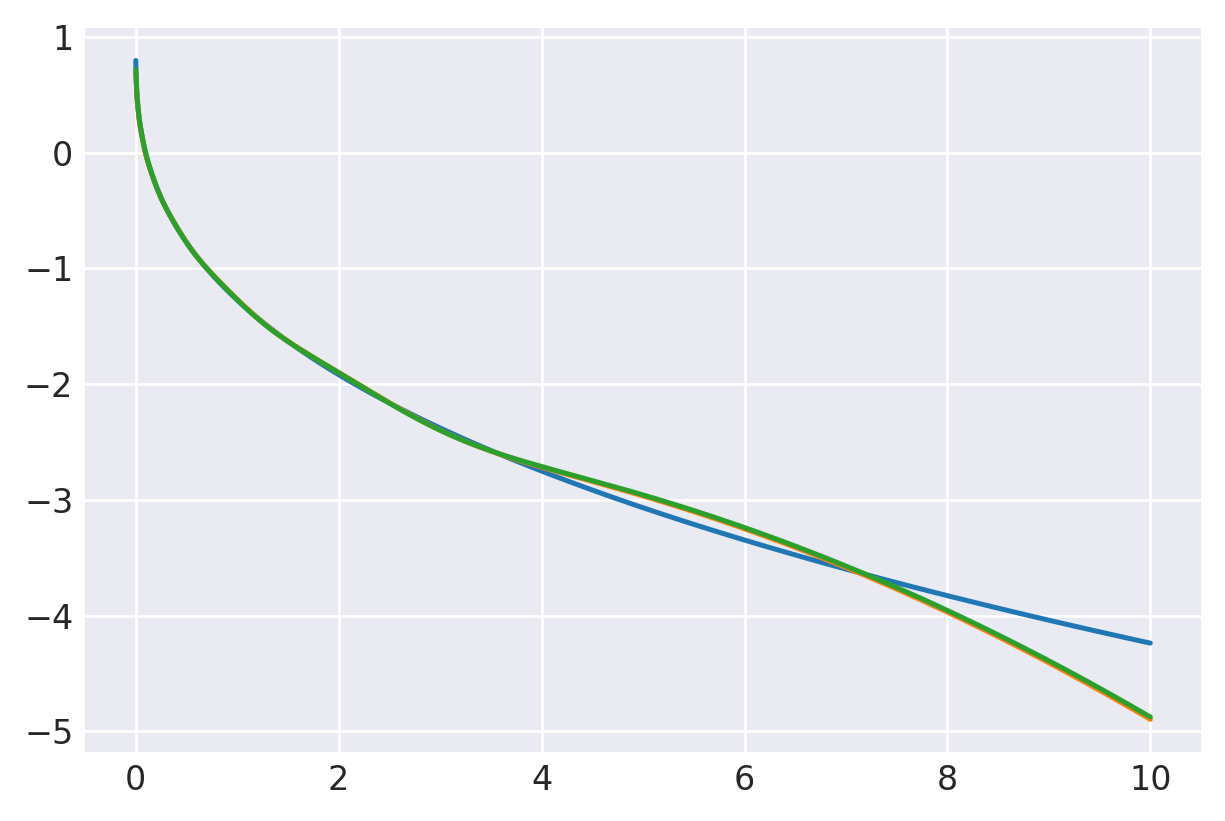

2.7: (
    normalize(np.array([ 2.5603635787e-01, 3.3996473964e-01, 2.3704770402e-01, 1.1360829009e-01, 4.0451772215e-02, 1.0722014901e-02, 1.9717219976e-03, 1.9739926358e-04) ]),
    np.array([ 3.4300215256e+00, 1.3121081912e+00, 5.8108687115e-01, 2.6484406904e-01, 1.1827914408e-01, 4.9545087625e-02, 1.8211968285e-02, 4.9570196098e-03 ]),
),
prev.  chisq = -4.053683531958642


         Current function value: -4.652838
         Iterations: 22
         Function evaluations: 1847
         Gradient evaluations: 108
-4.6528382225310585


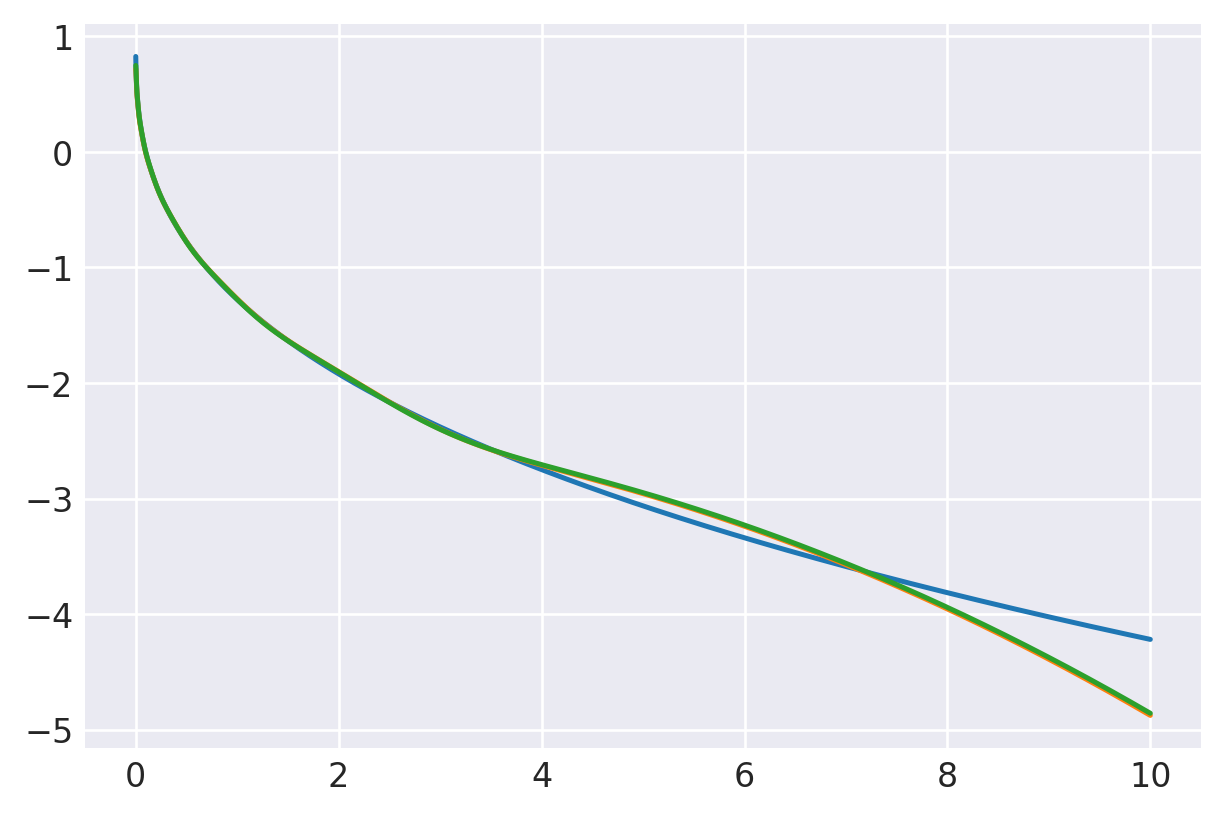

2.75: (
    normalize(np.array([ 2.6058055622e-01, 3.3951550822e-01, 2.3495502141e-01, 1.1226246312e-01, 3.9945453604e-02, 1.0594555244e-02, 1.9508583723e-03, 1.9558381619e-04) ]),
    np.array([ 3.4386754546e+00, 1.2997893723e+00, 5.7106903224e-01, 2.5854037843e-01, 1.1475797813e-01, 4.7784746611e-02, 1.7456677796e-02, 4.7169510444e-03 ]),
),
prev.  chisq = -4.036261144691387


         Current function value: -4.606318
         Iterations: 22
         Function evaluations: 1678
         Gradient evaluations: 98
-4.606317617329515


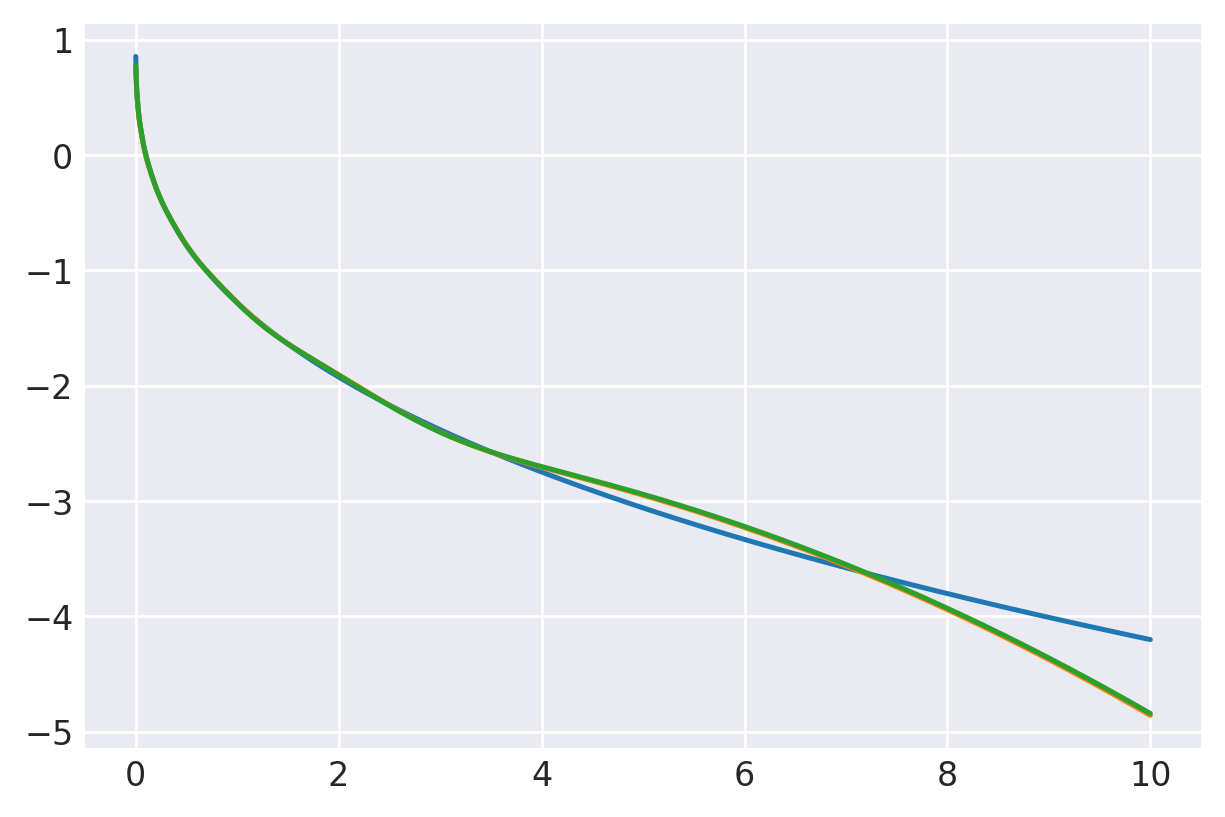

2.8: (
    normalize(np.array([ 2.6513259999e-01, 3.3905467563e-01, 2.3287400379e-01, 1.1091802298e-01, 3.9434331333e-02, 1.0463808431e-02, 1.9289483895e-03, 1.9360945295e-04) ]),
    np.array([ 3.4459842336e+00, 1.2871949902e+00, 5.6109772902e-01, 2.5234703294e-01, 1.1133059246e-01, 4.6084604163e-02, 1.6732497591e-02, 4.4884902517e-03 ]),
),
prev.  chisq = -4.018327617648564


         Current function value: -4.560822
         Iterations: 22
         Function evaluations: 1456
         Gradient evaluations: 85
-4.560822491305398


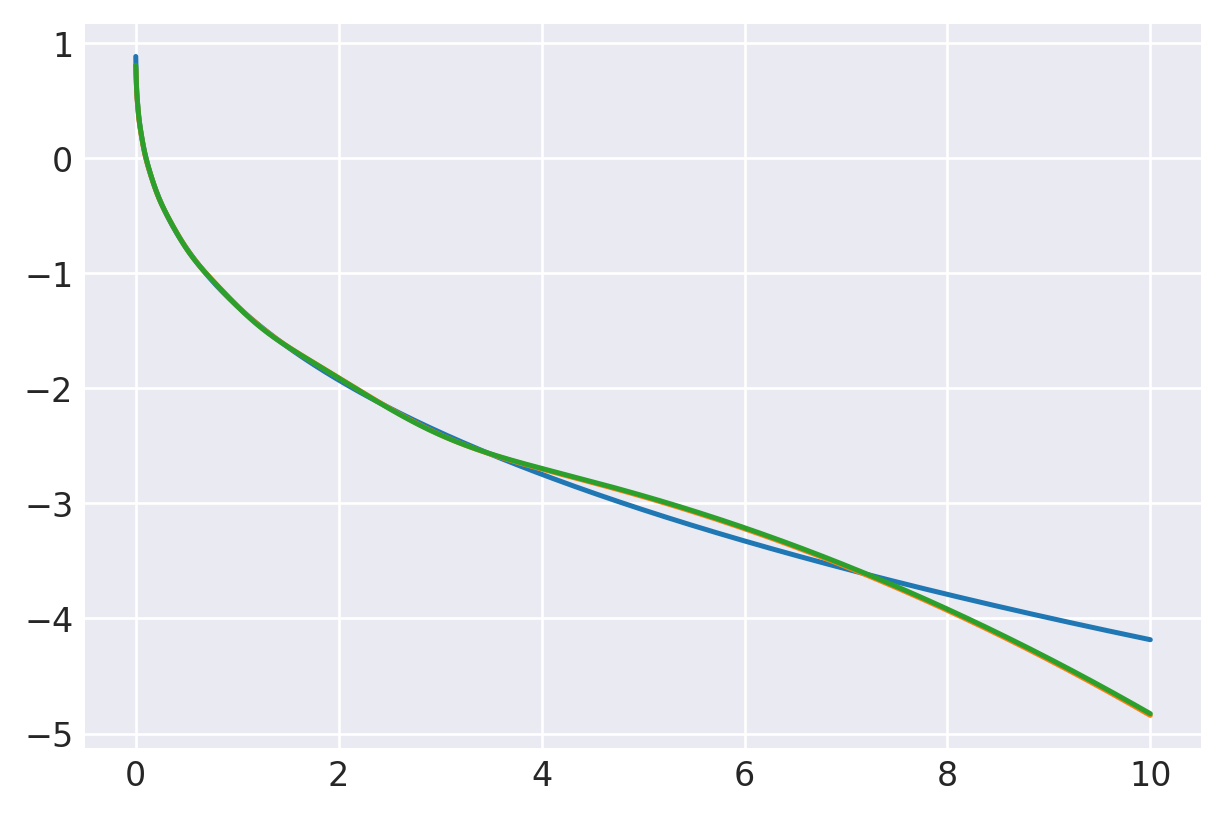

2.85: (
    normalize(np.array([ 2.6969046164e-01, 3.3858074462e-01, 2.3080519717e-01, 1.0957651282e-01, 3.8919361991e-02, 1.0330146194e-02, 1.9060890486e-03, 1.9148651317e-04) ]),
    np.array([ 3.4519932590e+00, 1.2743508483e+00, 5.5118171368e-01, 2.4626456036e-01, 1.0799489041e-01, 4.4442595960e-02, 1.6038068356e-02, 4.2710211735e-03 ]),
),
prev.  chisq = -3.999911692075918


         Current function value: -4.516326
         Iterations: 22
         Function evaluations: 1644
         Gradient evaluations: 96
-4.516325962520119


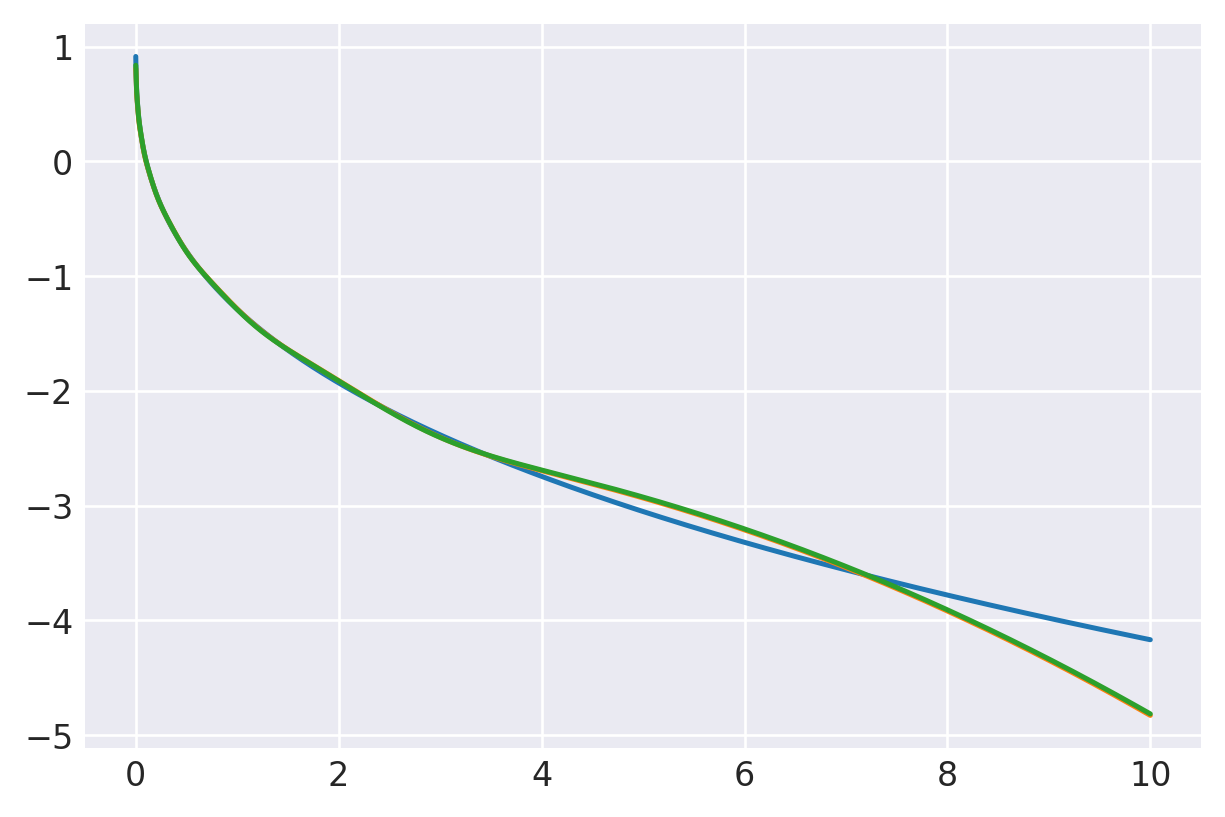

2.9: (
    normalize(np.array([ 2.7425455973e-01, 3.3809311678e-01, 2.2874775179e-01, 1.0823794027e-01, 3.8401141195e-02, 1.0193901728e-02, 1.8823625847e-03, 1.8922592838e-04) ]),
    np.array([ 3.4567293994e+00, 1.2612722805e+00, 5.4132427926e-01, 2.4029157350e-01, 1.0474854495e-01, 4.2856681852e-02, 1.5372096187e-02, 4.0639904491e-03 ]),
),
prev.  chisq = -3.981047594609176


         Current function value: -4.472805
         Iterations: 20
         Function evaluations: 1438
         Gradient evaluations: 84
-4.4728053095995435


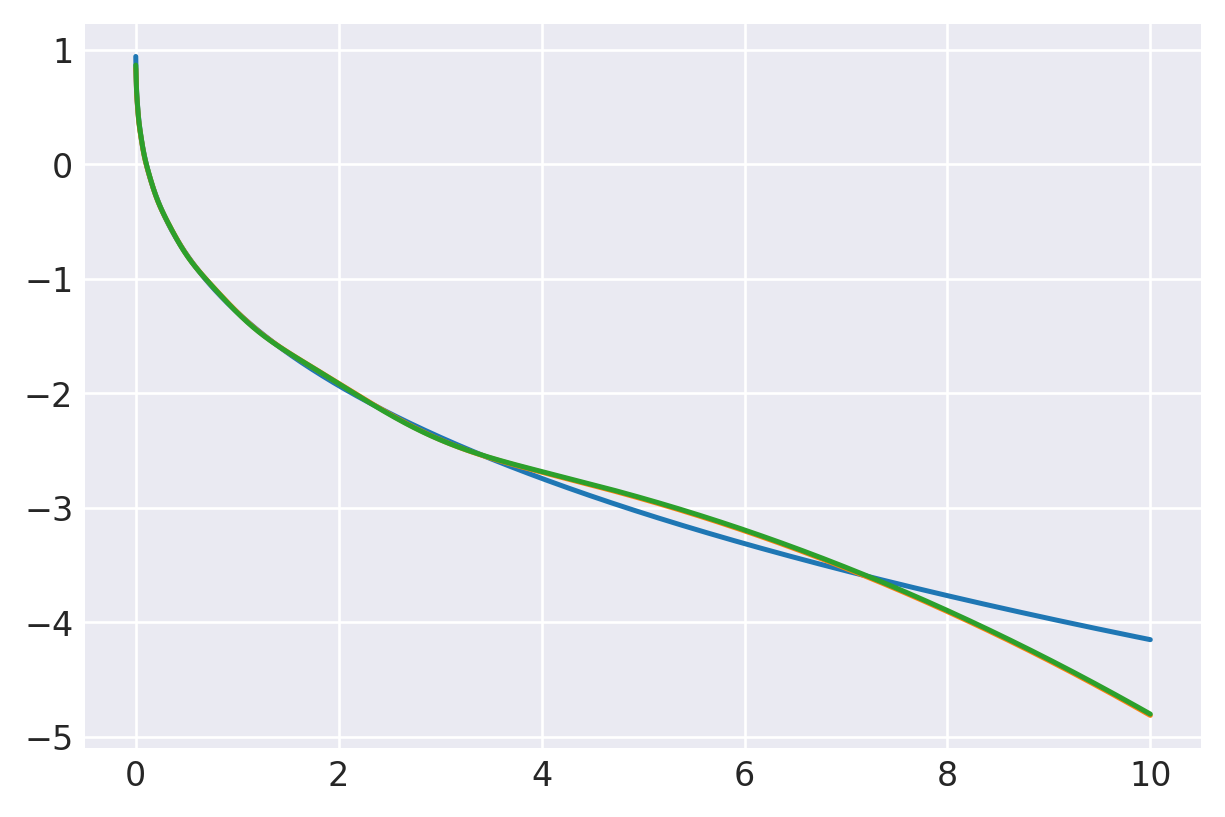

2.95: (
    normalize(np.array([ 2.7882402022e-01, 3.3759113938e-01, 2.2670098911e-01, 1.0690329594e-01, 3.7880462638e-02, 1.0055397780e-02, 1.8578536876e-03, 1.8684125728e-04) ]),
    np.array([ 3.4602294597e+00, 1.2479783179e+00, 5.3153132819e-01, 2.3442807269e-01, 1.0158953793e-01, 4.1324927816e-02, 1.4733392817e-02, 3.8668974085e-03 ]),
),
prev.  chisq = -3.961773130045222


         Current function value: -4.430242
         Iterations: 19
         Function evaluations: 1474
         Gradient evaluations: 86
-4.430241740849662


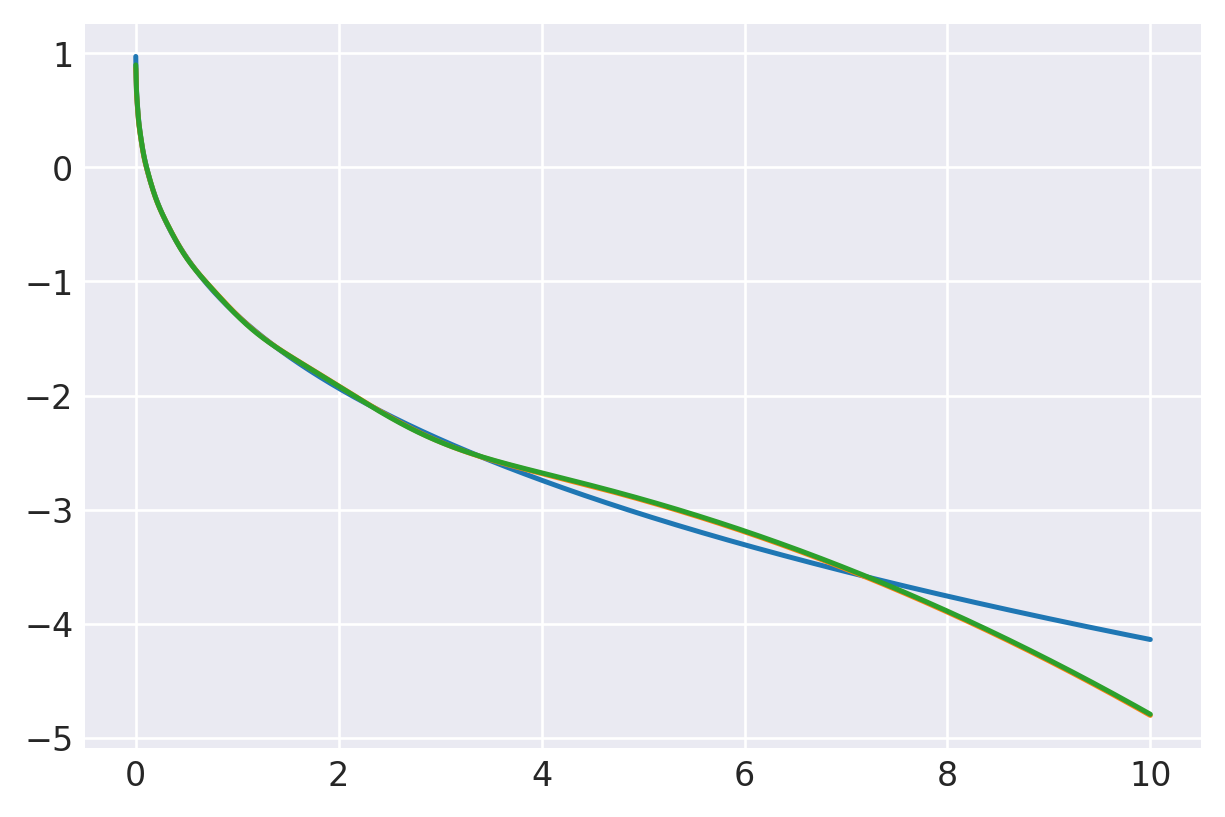

3.0: (
    normalize(np.array([ 2.8339586721e-01, 3.3707382683e-01, 2.2466590244e-01, 1.0557395714e-01, 3.7358355307e-02, 9.9150750079e-03, 1.8326728491e-03, 1.8434322082e-04) ]),
    np.array([ 3.4625470418e+00, 1.2344960814e+00, 5.2181161501e-01, 2.2867507595e-01, 9.8516567191e-02, 3.9845824782e-02, 1.4120896453e-02, 3.6792477108e-03 ]),
),
prev.  chisq = -3.942126941341873


Optimization terminated successfully.
         Current function value: -4.388620
         Iterations: 22
         Function evaluations: 561
         Gradient evaluations: 33
-4.388620174355584


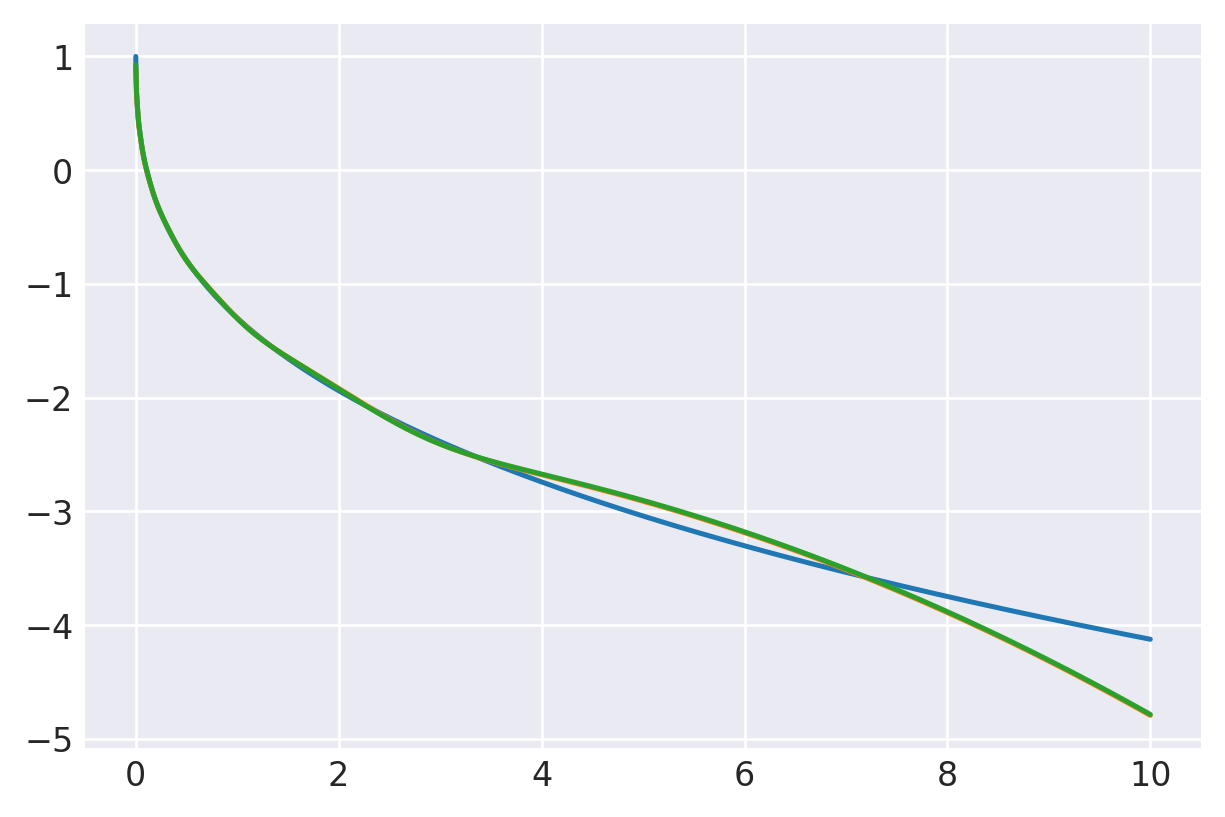

3.05: (
    normalize(np.array([ 2.8797063610e-01, 3.3654056068e-01, 2.2264153368e-01, 1.0425014388e-01, 3.6835314290e-02, 9.7731843407e-03, 1.8068849854e-03, 1.8174203946e-04) ]),
    np.array([ 3.4637074366e+00, 1.2208387762e+00, 5.1216816120e-01, 2.2303139862e-01, 9.5527424557e-02, 3.8417492098e-02, 1.3533470346e-02, 3.5005785419e-03 ]),
),
prev.  chisq = -3.9221497906132408


Optimization terminated successfully.
         Current function value: -4.347929
         Iterations: 22
         Function evaluations: 527
         Gradient evaluations: 31
-4.347929024470523


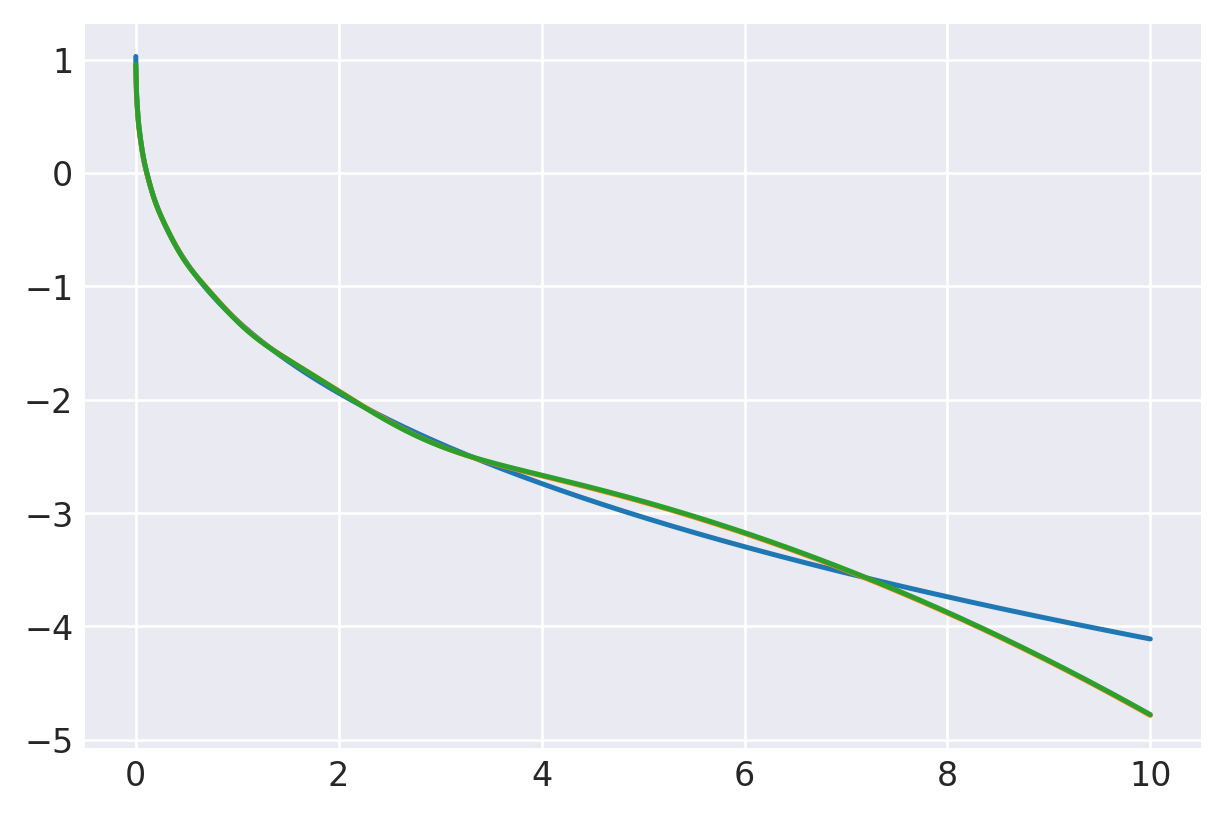

3.1: (
    normalize(np.array([ 2.9254661174e-01, 3.3599065900e-01, 2.2062808534e-01, 1.0293280440e-01, 3.6312121142e-02, 9.6300781164e-03, 1.7805879374e-03, 1.7905231576e-04) ]),
    np.array([ 3.4637534498e+00, 1.2070273071e+00, 5.0260725098e-01, 2.1749729115e-01, 9.2620612345e-02, 3.7038463129e-02, 1.2970191150e-02, 3.3304985702e-03 ]),
),
prev.  chisq = -3.9018848769307715


         Current function value: -4.308160
         Iterations: 22
         Function evaluations: 1168
         Gradient evaluations: 68
-4.308159984984764


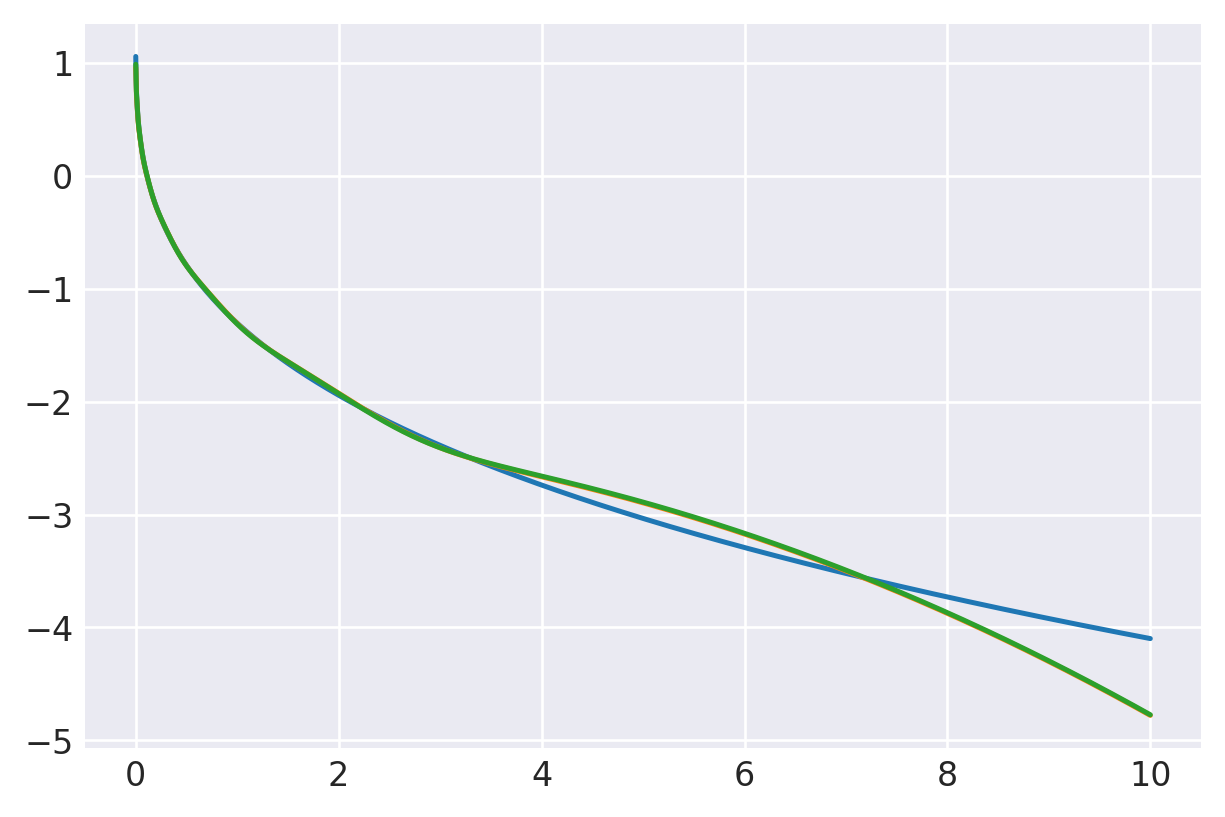

3.15: (
    normalize(np.array([ 2.9712233820e-01, 3.3542361376e-01, 2.1862559335e-01, 1.0162270438e-01, 3.5789497541e-02, 9.4860955330e-03, 1.7538706286e-03, 1.7628660147e-04) ]),
    np.array([ 3.4627258999e+00, 1.1930808223e+00, 4.9313434752e-01, 2.1207278131e-01, 8.9794646307e-02, 3.5707295904e-02, 1.2430139604e-02, 3.1686214374e-03 ]),
),
prev.  chisq = -3.8813774900282696


         Current function value: -4.269308
         Iterations: 23
         Function evaluations: 1371
         Gradient evaluations: 80
-4.269307802380549


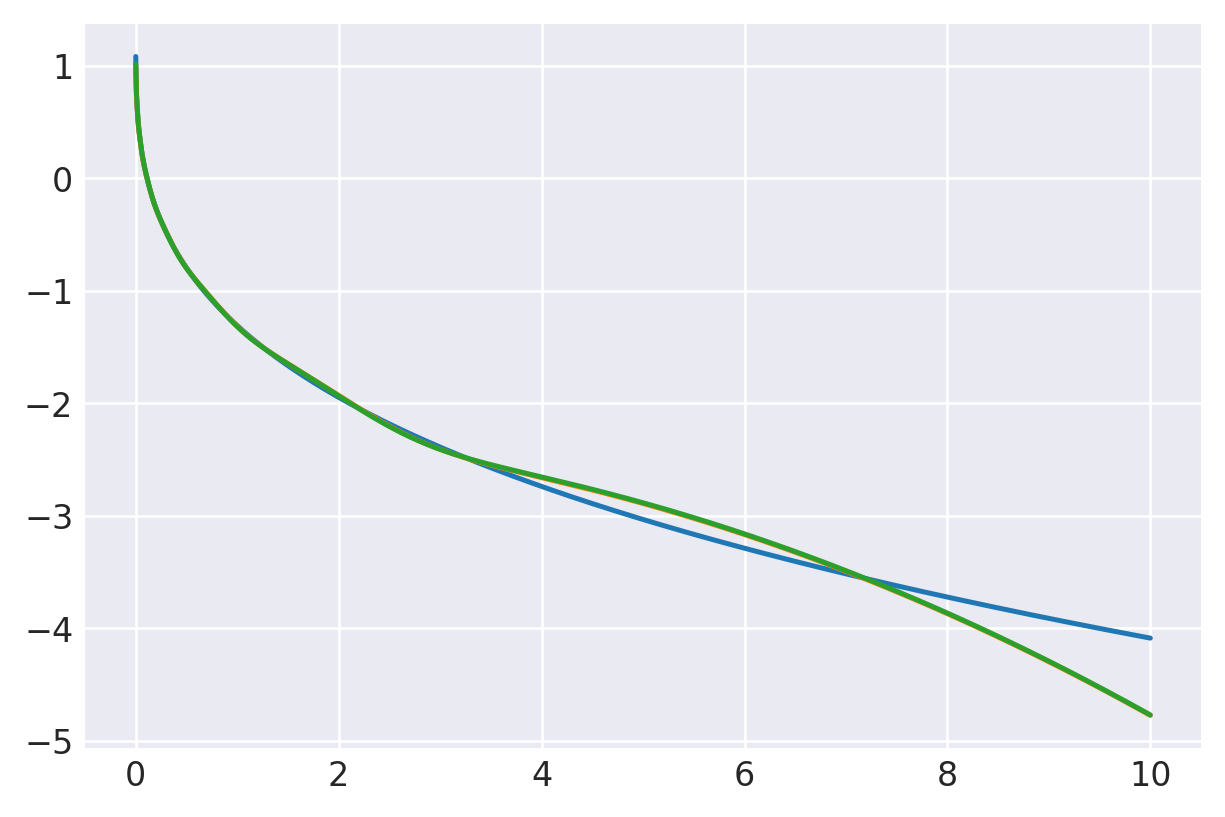

3.2: (
    normalize(np.array([ 3.0169688519e-01, 3.3483854653e-01, 2.1663410979e-01, 1.0032063193e-01, 3.5268055238e-02, 9.3414963734e-03, 1.7268165388e-03, 1.7345841133e-04) ]),
    np.array([ 3.4606597606e+00, 1.1790168374e+00, 4.8375446703e-01, 2.0675761340e-01, 8.7047836659e-02, 3.4422521140e-02, 1.1912453076e-02, 3.0145954913e-03 ]),
),
prev.  chisq = -3.860672744076516


         Current function value: -4.231370
         Iterations: 21
         Function evaluations: 1627
         Gradient evaluations: 95
-4.231370029700525


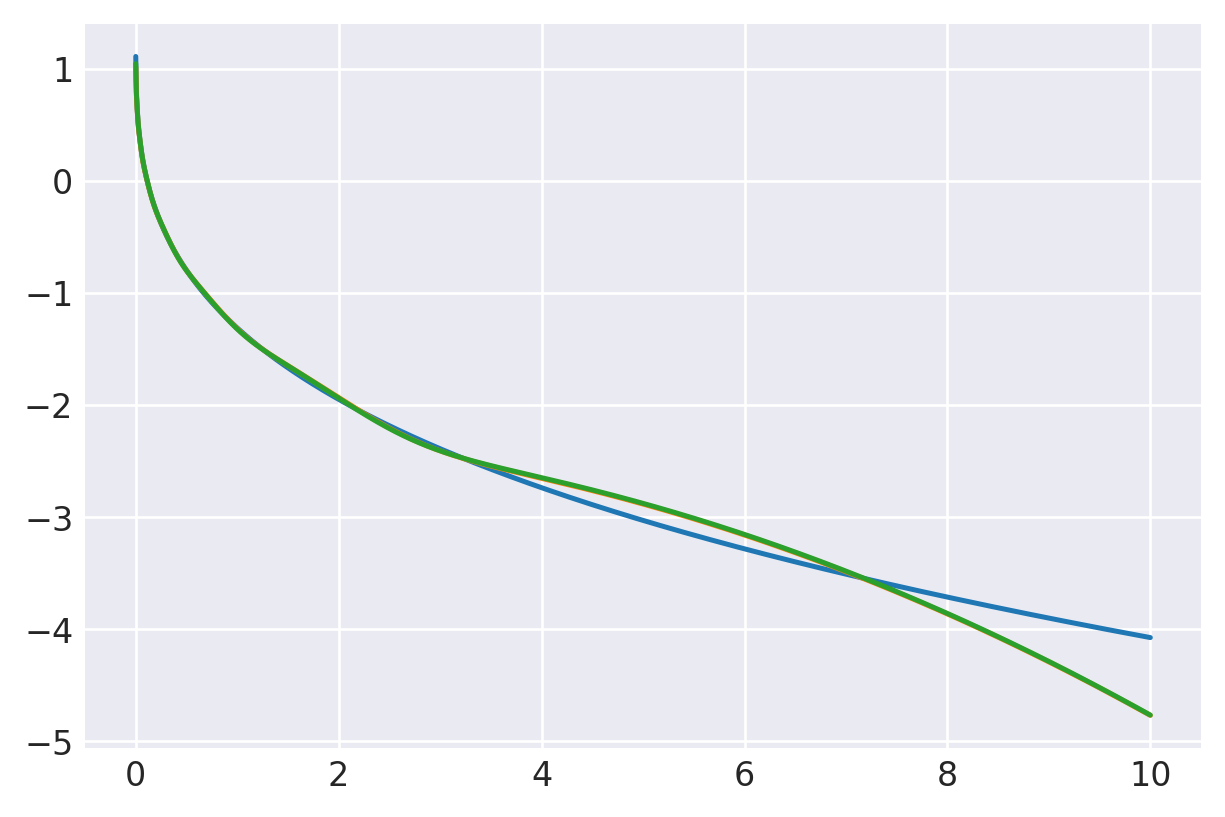

3.25: (
    normalize(np.array([ 3.0626809208e-01, 3.3423508706e-01, 2.1465388918e-01, 9.9027498301e-02, 3.4748633509e-02, 9.1966873502e-03, 1.6995290573e-03, 1.7058345629e-04) ]),
    np.array([ 3.4576014755e+00, 1.1648556893e+00, 4.7447369015e-01, 2.0155241315e-01, 8.4379213809e-02, 3.3183020985e-02, 1.1416381727e-02, 2.8681095080e-03 ]),
),
prev.  chisq = -3.8398198901312903


         Current function value: -4.194347
         Iterations: 23
         Function evaluations: 1661
         Gradient evaluations: 97
-4.194346749788016


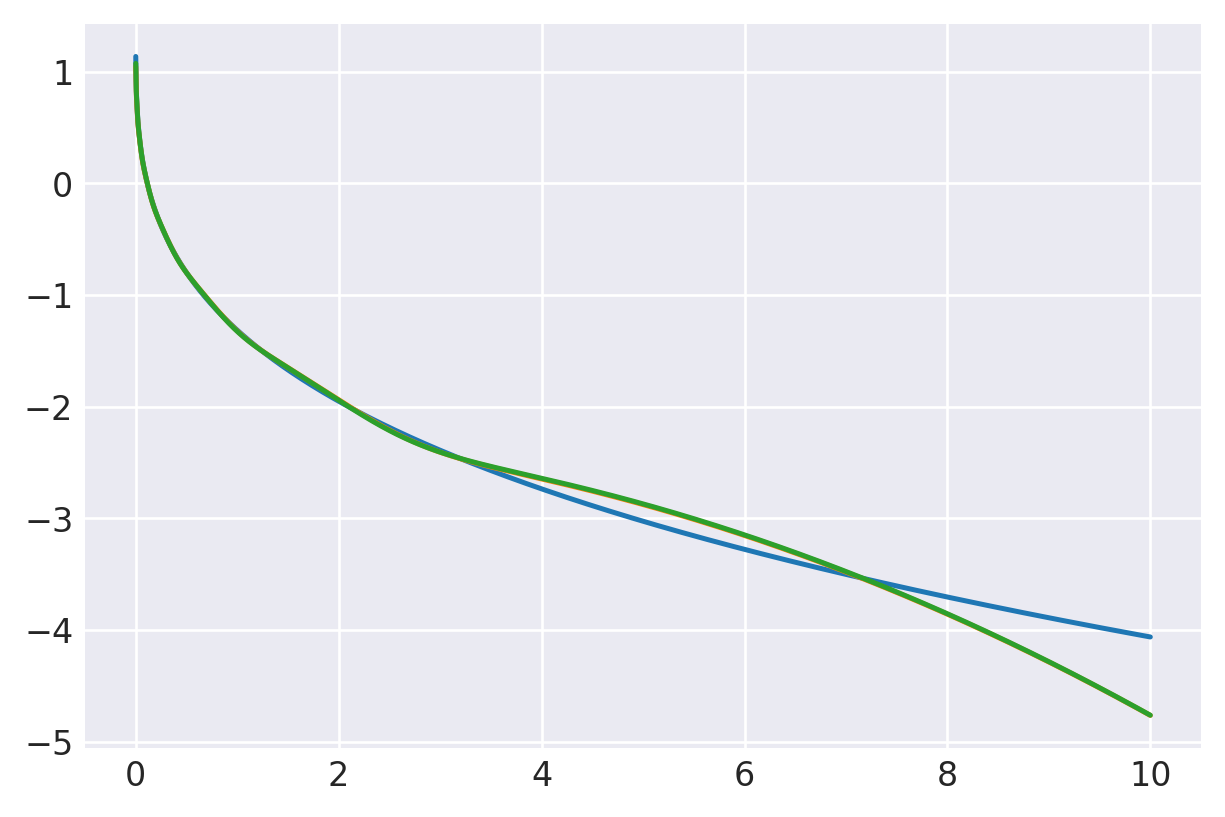

3.3: (
    normalize(np.array([ 3.1083369328e-01, 3.3361255518e-01, 2.1268550711e-01, 9.7744401689e-02, 3.4232034639e-02, 9.0520192779e-03, 1.6721108692e-03, 1.6767796469e-04) ]),
    np.array([ 3.4535970392e+00, 1.1506182300e+00, 4.6529842354e-01, 1.9645779603e-01, 8.1787703962e-02, 3.1987680634e-02, 1.0941226986e-02, 2.7288760233e-03 ]),
),
prev.  chisq = -3.8188666498961226


Optimization terminated successfully.
         Current function value: -4.158240
         Iterations: 20
         Function evaluations: 544
         Gradient evaluations: 32
-4.158240255963594


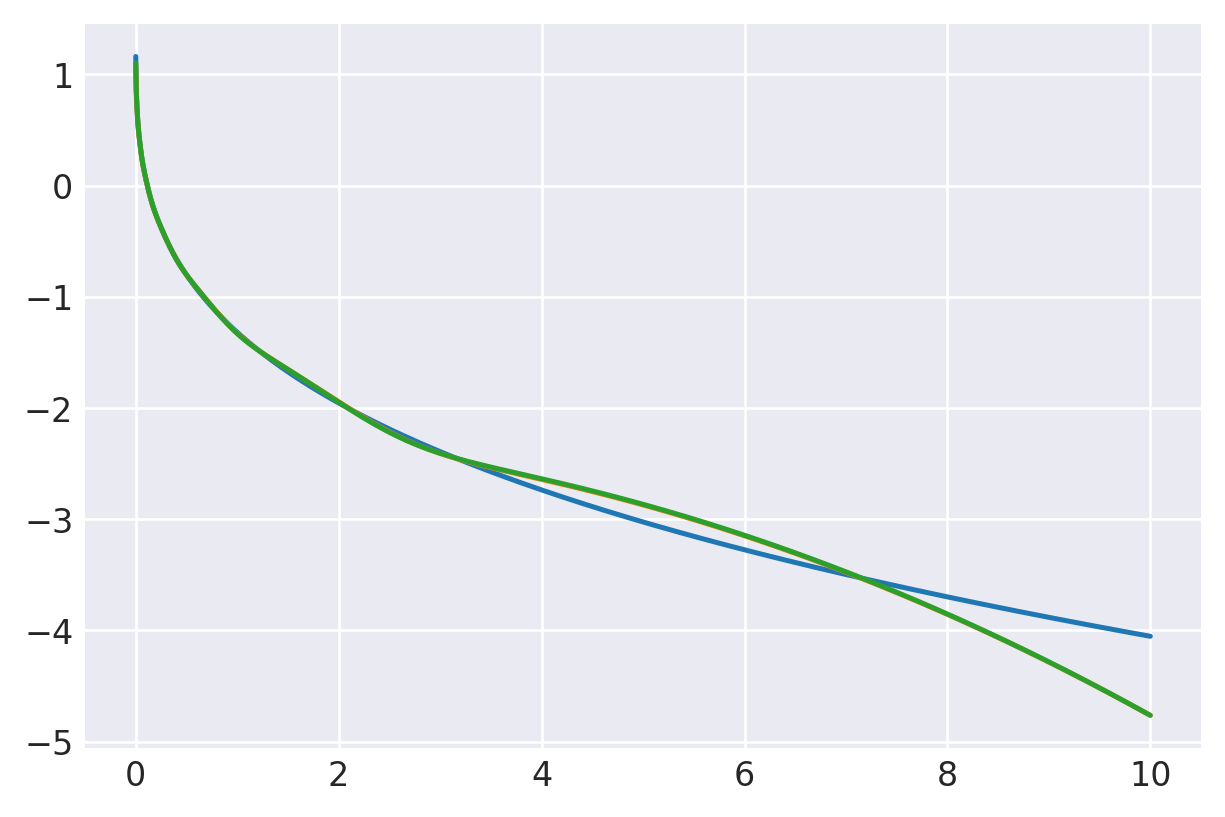

3.35: (
    normalize(np.array([ 3.1539152937e-01, 3.3297050294e-01, 2.1072934020e-01, 9.6472317744e-02, 3.3719031752e-02, 8.9078501192e-03, 1.6446670823e-03, 1.6476078473e-04) ]),
    np.array([ 3.4486916592e+00, 1.1363238854e+00, 4.5623443735e-01, 1.9147427636e-01, 7.9272312479e-02, 3.0835471314e-02, 1.0486356649e-02, 2.5966476063e-03 ]),
),
prev.  chisq = -3.7978625169036104


Optimization terminated successfully.
         Current function value: -4.123055
         Iterations: 20
         Function evaluations: 544
         Gradient evaluations: 32
-4.123054676073429


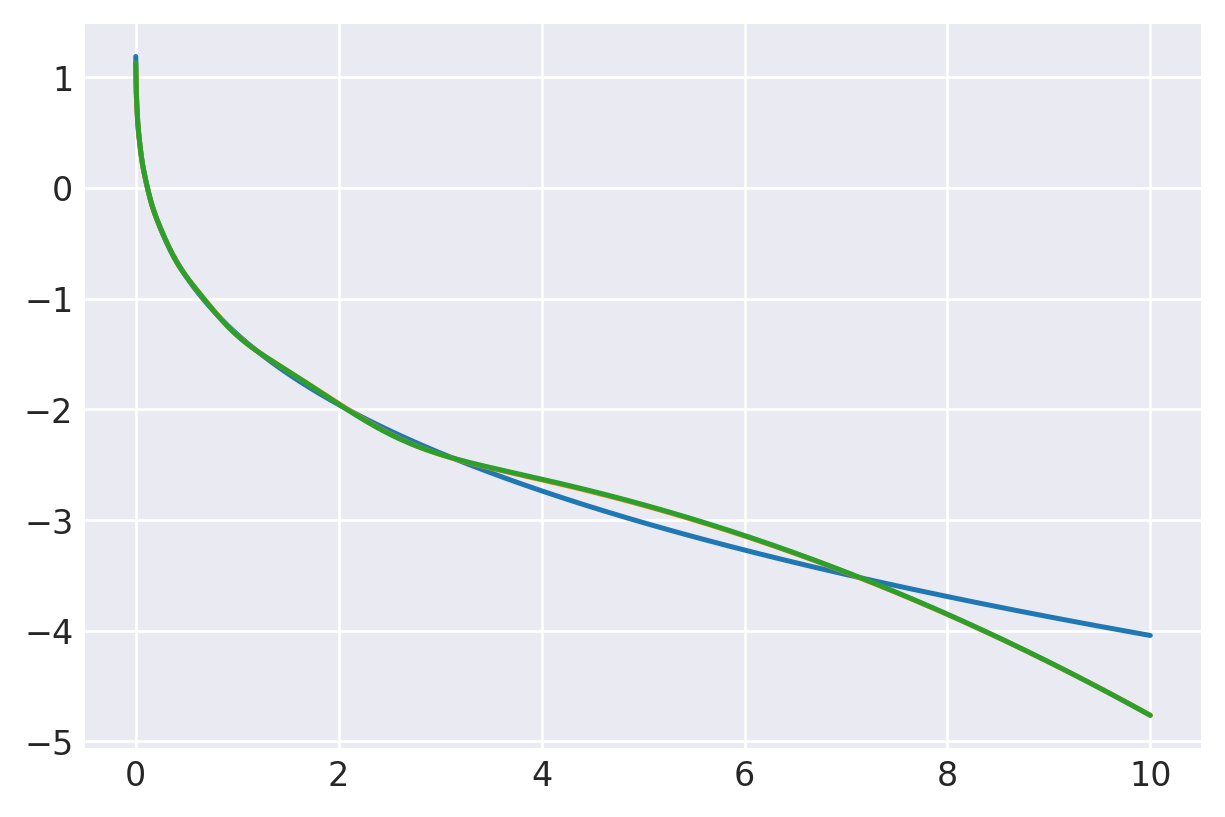

3.4: (
    normalize(np.array([ 3.1993790035e-01, 3.3230824011e-01, 2.0878655222e-01, 9.5212806365e-02, 3.3210685259e-02, 8.7646371599e-03, 1.6173264381e-03, 1.6185210731e-04) ]),
    np.array([ 3.4429426970e+00, 1.1219974658e+00, 4.4729000854e-01, 1.8660354880e-01, 7.6832626561e-02, 2.9725640501e-02, 1.0051240666e-02, 2.4712002682e-03 ]),
),
prev.  chisq = -3.776856521600912


Optimization terminated successfully.
         Current function value: -4.088796
         Iterations: 21
         Function evaluations: 561
         Gradient evaluations: 33
-4.088795523835778


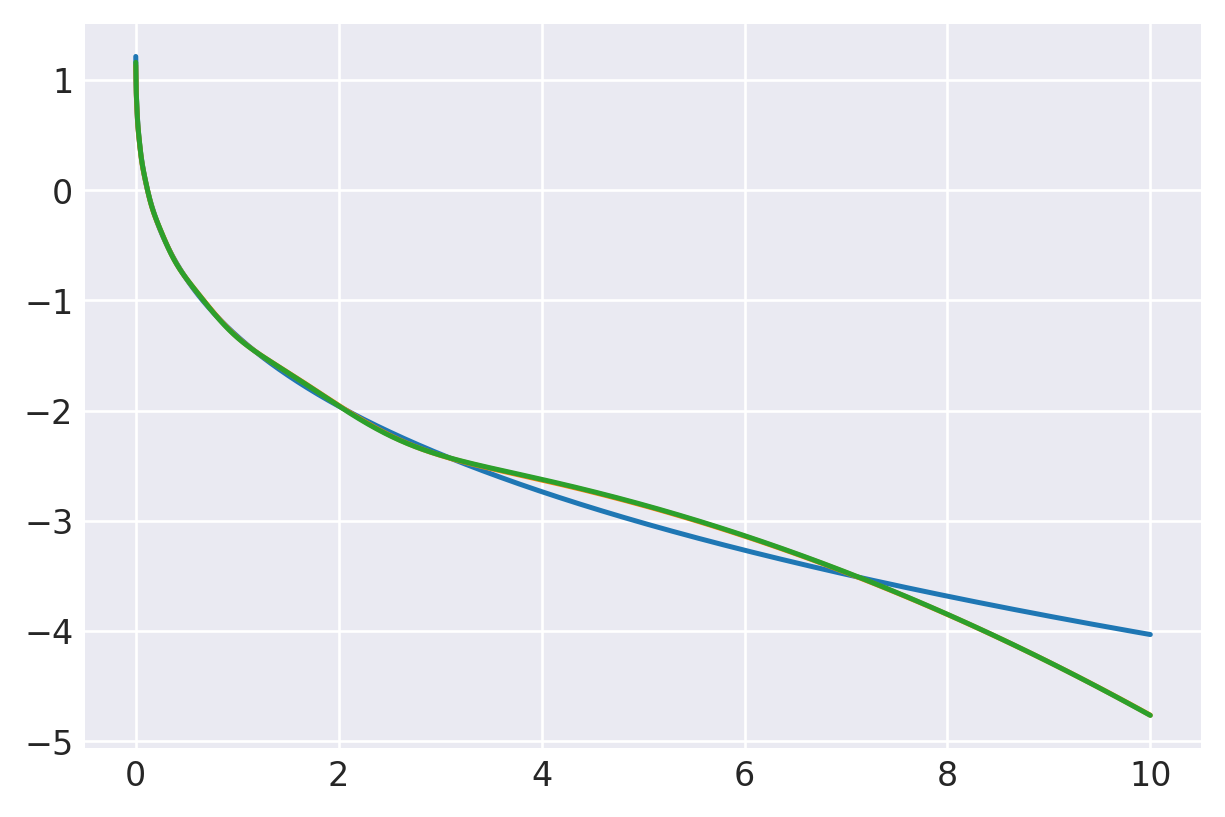

3.45: (
    normalize(np.array([ 3.2446913177e-01, 3.3162520838e-01, 2.0685820980e-01, 9.3967380474e-02, 3.2708034927e-02, 8.6228375957e-03, 1.5902218076e-03, 1.5897524344e-04) ]),
    np.array([ 3.4364072342e+00, 1.1076627941e+00, 4.3847298558e-01, 1.8184722461e-01, 7.4468267882e-02, 2.8657498875e-02, 9.6354114276e-03, 2.3523476800e-03 ]),
),
prev.  chisq = -3.755897950999403


         Current function value: -4.055469
         Iterations: 19
         Function evaluations: 1525
         Gradient evaluations: 89
-4.05546916215971


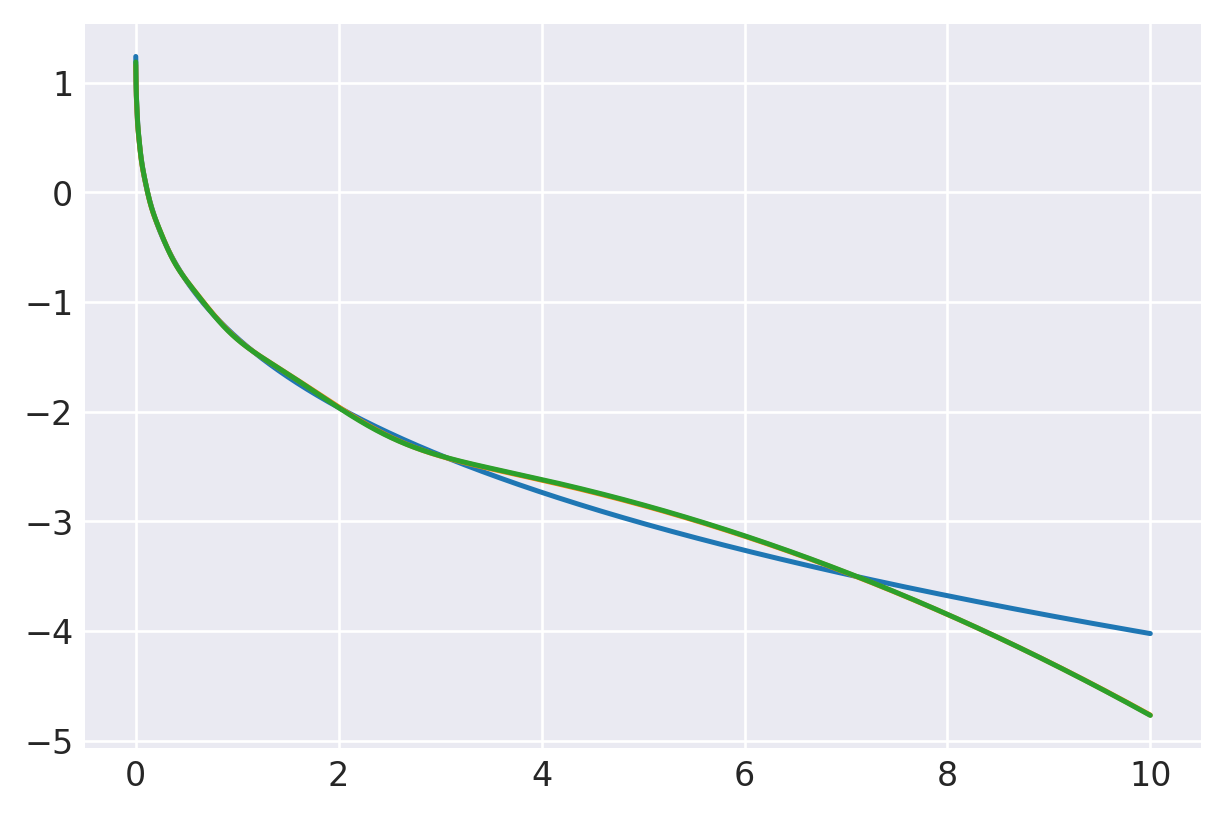

3.5: (
    normalize(np.array([ 3.2897898167e-01, 3.3092065750e-01, 2.0494647255e-01, 9.2738506027e-02, 3.2212614535e-02, 8.4830824226e-03, 1.5635269541e-03, 1.5615834308e-04) ]),
    np.array([ 3.4291635398e+00, 1.0933524055e+00, 4.2979524057e-01, 1.7720884649e-01, 7.2179782437e-02, 2.7630769251e-02, 9.2385605793e-03, 2.2399485348e-03 ]),
),
prev.  chisq = -3.735033416606564


         Current function value: -4.023082
         Iterations: 19
         Function evaluations: 1627
         Gradient evaluations: 95
-4.0230821622638855


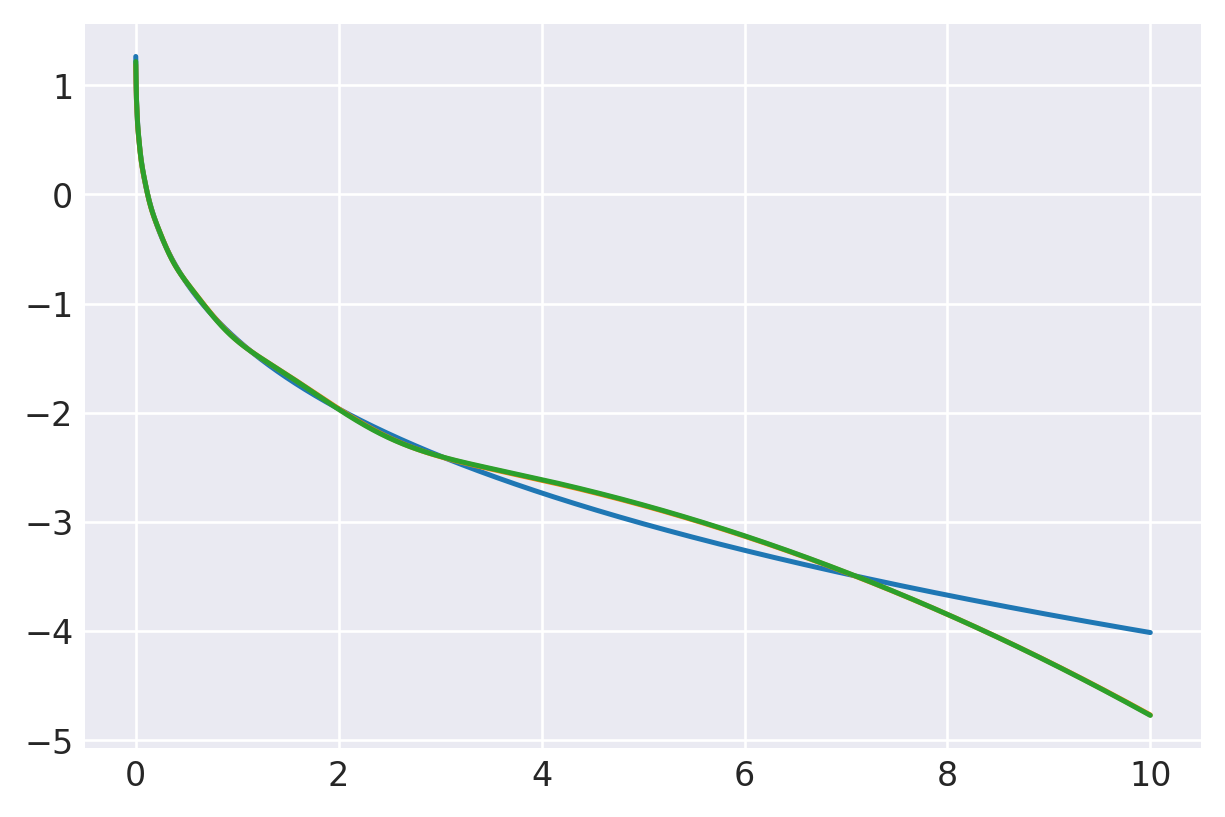

3.55: (
    normalize(np.array([ 3.3346455664e-01, 3.3019466828e-01, 2.0305212012e-01, 9.1527079847e-02, 3.1725084518e-02, 8.3457088335e-03, 1.5373565788e-03, 1.5342518552e-04) ]),
    np.array([ 3.4212616720e+00, 1.0790849831e+00, 4.2126159976e-01, 1.7268853712e-01, 6.9966194963e-02, 2.6644595947e-02, 8.8602087189e-03, 2.1338343965e-03 ]),
),
prev.  chisq = -3.7143132661218226


Optimization terminated successfully.
         Current function value: -3.991641
         Iterations: 20
         Function evaluations: 544
         Gradient evaluations: 32
-3.9916405492720393


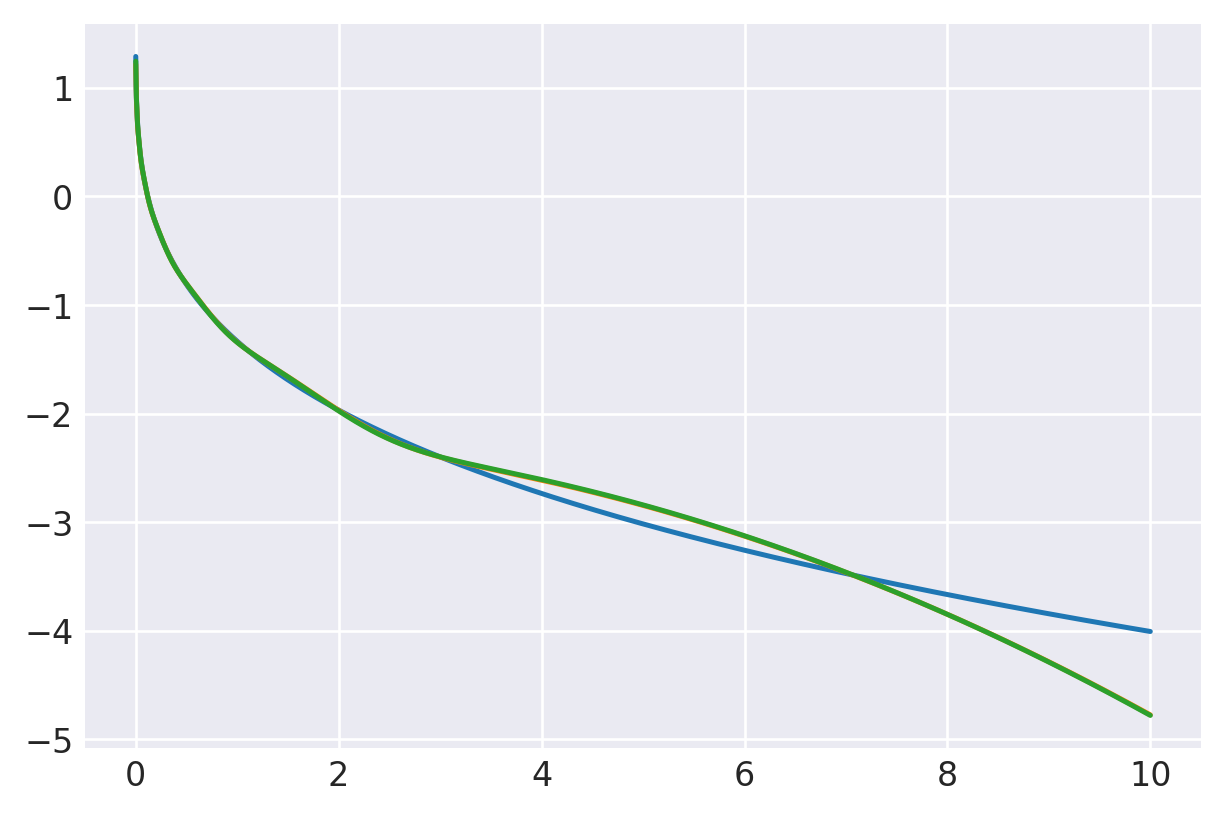

3.6: (
    normalize(np.array([ 3.3791916511e-01, 3.2944621157e-01, 2.0117732665e-01, 9.0335880830e-02, 3.1247229483e-02, 8.2114550705e-03, 1.5119182160e-03, 1.5081308021e-04) ]),
    np.array([ 3.4127827944e+00, 1.0648933420e+00, 4.1288477372e-01, 1.6829063272e-01, 6.7828585347e-02, 2.5699027864e-02, 8.5002230849e-03, 2.0339426497e-03 ]),
),
prev.  chisq = -3.69378177528946


Optimization terminated successfully.
         Current function value: -3.961149
         Iterations: 21
         Function evaluations: 527
         Gradient evaluations: 31
-3.9611489280490884


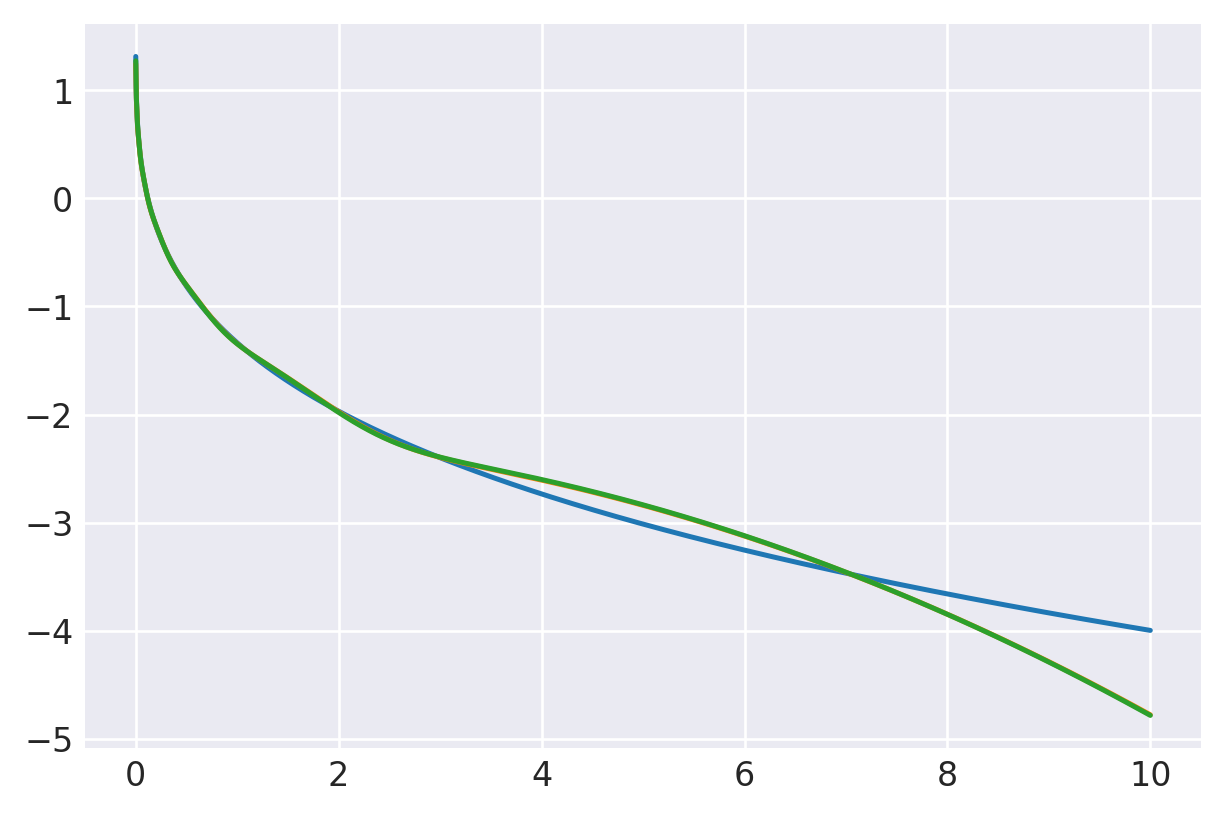

3.65: (
    normalize(np.array([ 3.4233201243e-01, 3.2867494041e-01, 1.9932622408e-01, 8.9168683477e-02, 3.0781168129e-02, 8.0811677358e-03, 1.4874443643e-03, 1.4835937968e-04) ]),
    np.array([ 3.4038426761e+00, 1.0508231816e+00, 4.0468172283e-01, 1.6402086922e-01, 6.5768548938e-02, 2.4794288628e-02, 8.1585174926e-03, 1.9402023601e-03 ]),
),
prev.  chisq = -3.6734781215266685


Optimization terminated successfully.
         Current function value: -3.931609
         Iterations: 22
         Function evaluations: 544
         Gradient evaluations: 32
-3.931609498486689


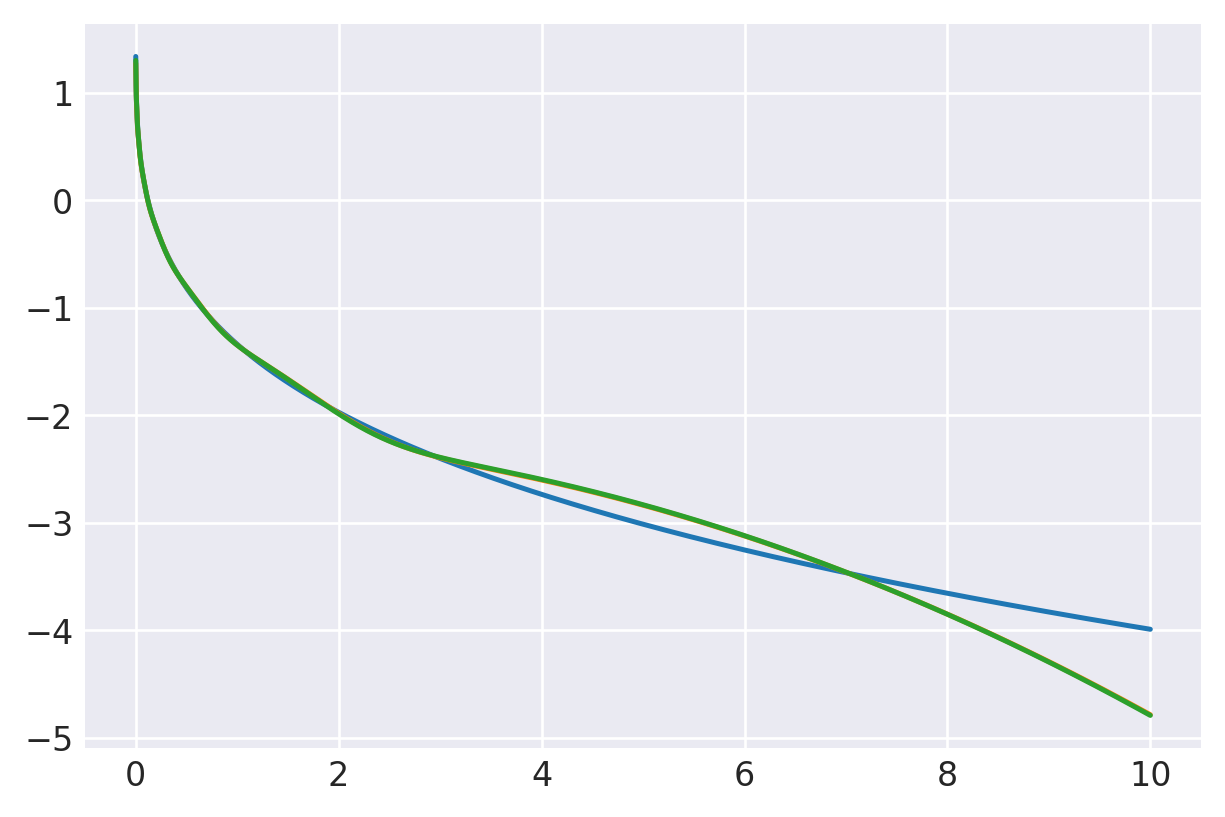

3.7: (
    normalize(np.array([ 3.4669490956e-01, 3.2788067414e-01, 1.9750165380e-01, 8.8028330369e-02, 3.0328612134e-02, 7.9555671697e-03, 1.4641483893e-03, 1.4610443941e-04) ]),
    np.array([ 3.3945350753e+00, 1.0369093815e+00, 3.9666490684e-01, 1.5988316528e-01, 6.3786966962e-02, 2.3930384487e-02, 7.8349720517e-03, 1.8525606413e-03 ]),
),
prev.  chisq = -3.6534415756133978


Optimization terminated successfully.
         Current function value: -3.903021
         Iterations: 21
         Function evaluations: 527
         Gradient evaluations: 31
-3.903020983346675


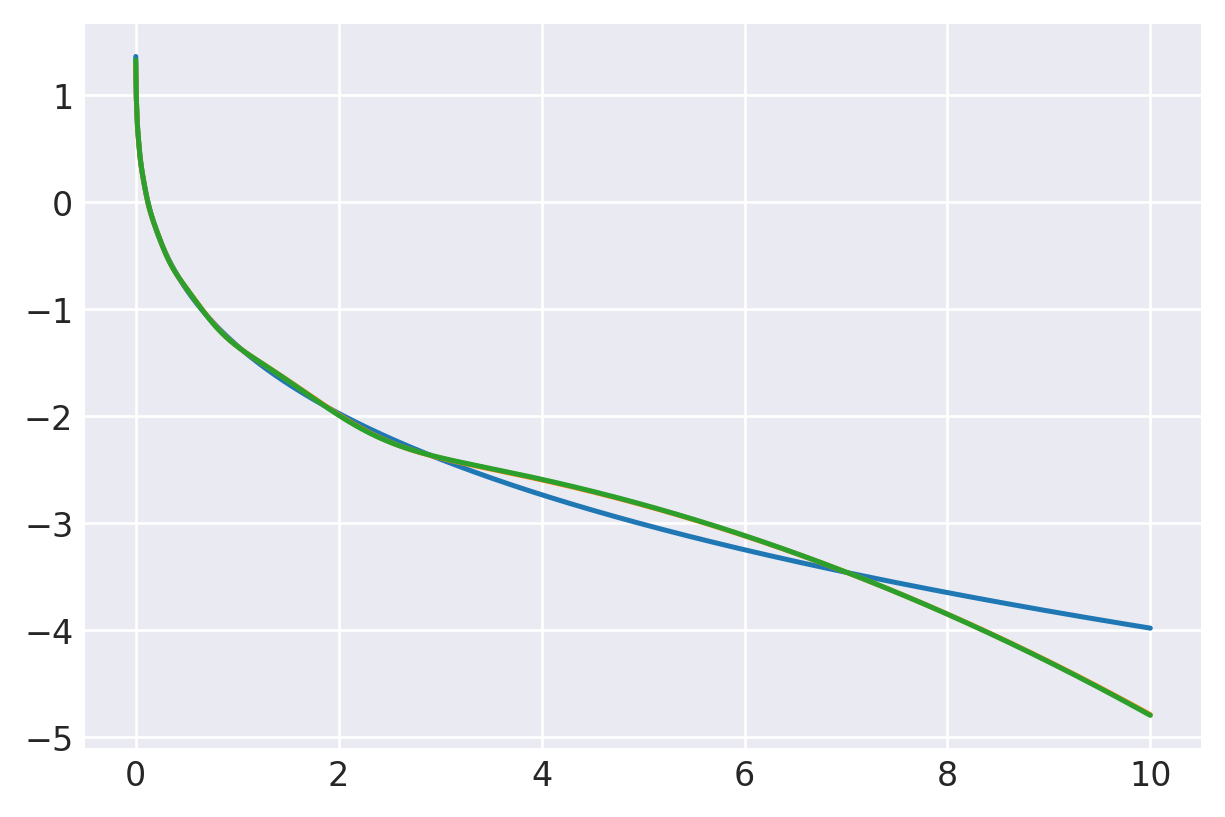

3.75: (
    normalize(np.array([ 3.5099770418e-01, 3.2706323245e-01, 1.9570729508e-01, 8.6918317000e-02, 2.9891597014e-02, 7.8354892928e-03, 1.4422719503e-03, 1.4409303061e-04) ]),
    np.array([ 3.3849696881e+00, 1.0231928001e+00, 3.8884931451e-01, 1.5588257316e-01, 6.1885234812e-02, 2.3107536326e-02, 7.5295462986e-03, 1.7709835829e-03 ]),
),
prev.  chisq = -3.6337057394385166


Optimization terminated successfully.
         Current function value: -3.875378
         Iterations: 19
         Function evaluations: 527
         Gradient evaluations: 31
-3.875377507834759


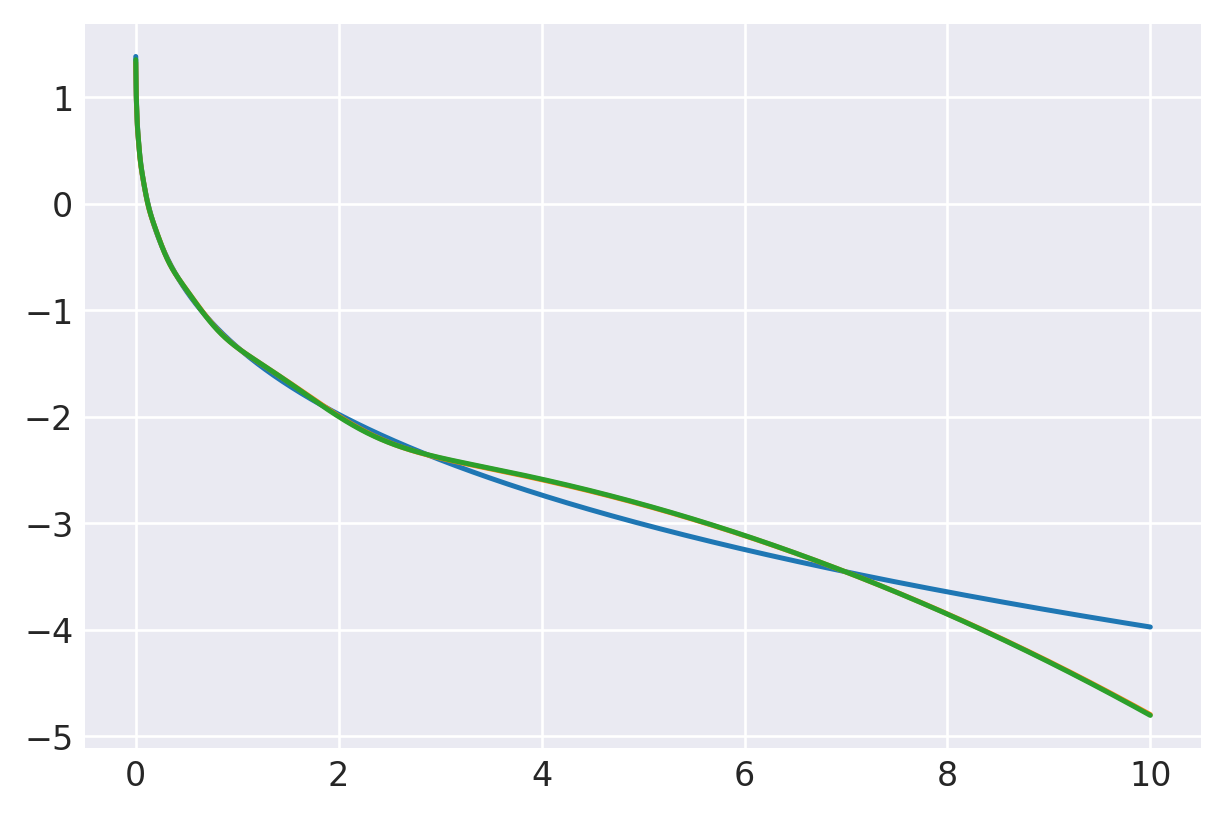

3.8: (
    normalize(np.array([ 3.5522825591e-01, 3.2622265288e-01, 1.9394757035e-01, 8.5842740683e-02, 2.9472448599e-02, 7.7218756822e-03, 1.4220818016e-03, 1.4237409853e-04) ]),
    np.array([ 3.3752733799e+00, 1.0097197129e+00, 3.8125211412e-01, 1.5202509730e-01, 6.0065170871e-02, 2.2326137079e-02, 7.2422591887e-03, 1.6954485777e-03 ]),
),
prev.  chisq = -3.614298046157289


Optimization terminated successfully.
         Current function value: -3.848667
         Iterations: 20
         Function evaluations: 527
         Gradient evaluations: 31
-3.8486674916591213


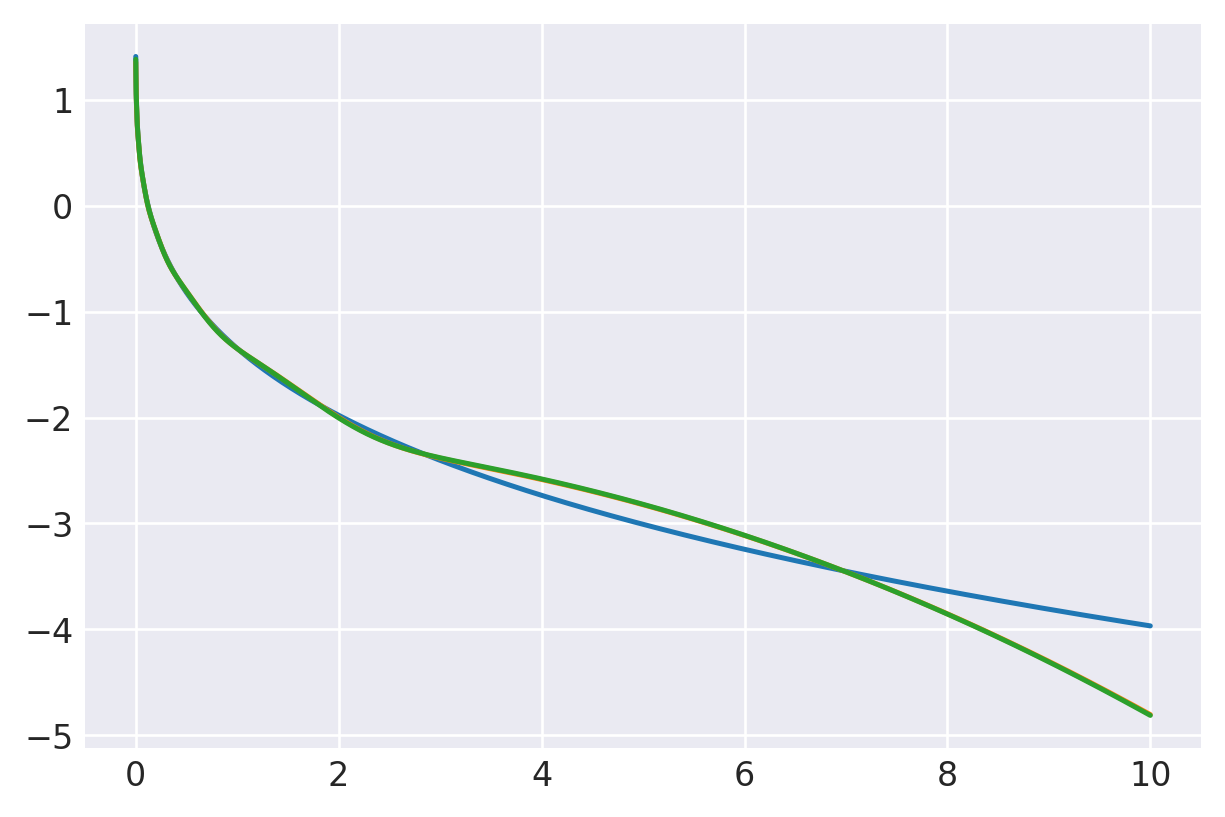

3.85: (
    normalize(np.array([ 3.5937430835e-01, 3.2535928773e-01, 1.9222699088e-01, 8.4805551036e-02, 2.9073391524e-02, 7.6156299085e-03, 1.4038423123e-03, 1.4099826224e-04) ]),
    np.array([ 3.3655733854e+00, 9.9653518196e-01, 3.7388948928e-01, 1.4831617823e-01, 5.8328320983e-02, 2.1586478077e-02, 6.9731005594e-03, 1.6259233162e-03 ]),
),
prev.  chisq = -3.5952399762700824


Optimization terminated successfully.
         Current function value: -3.822873
         Iterations: 19
         Function evaluations: 561
         Gradient evaluations: 33
-3.8228726575945506


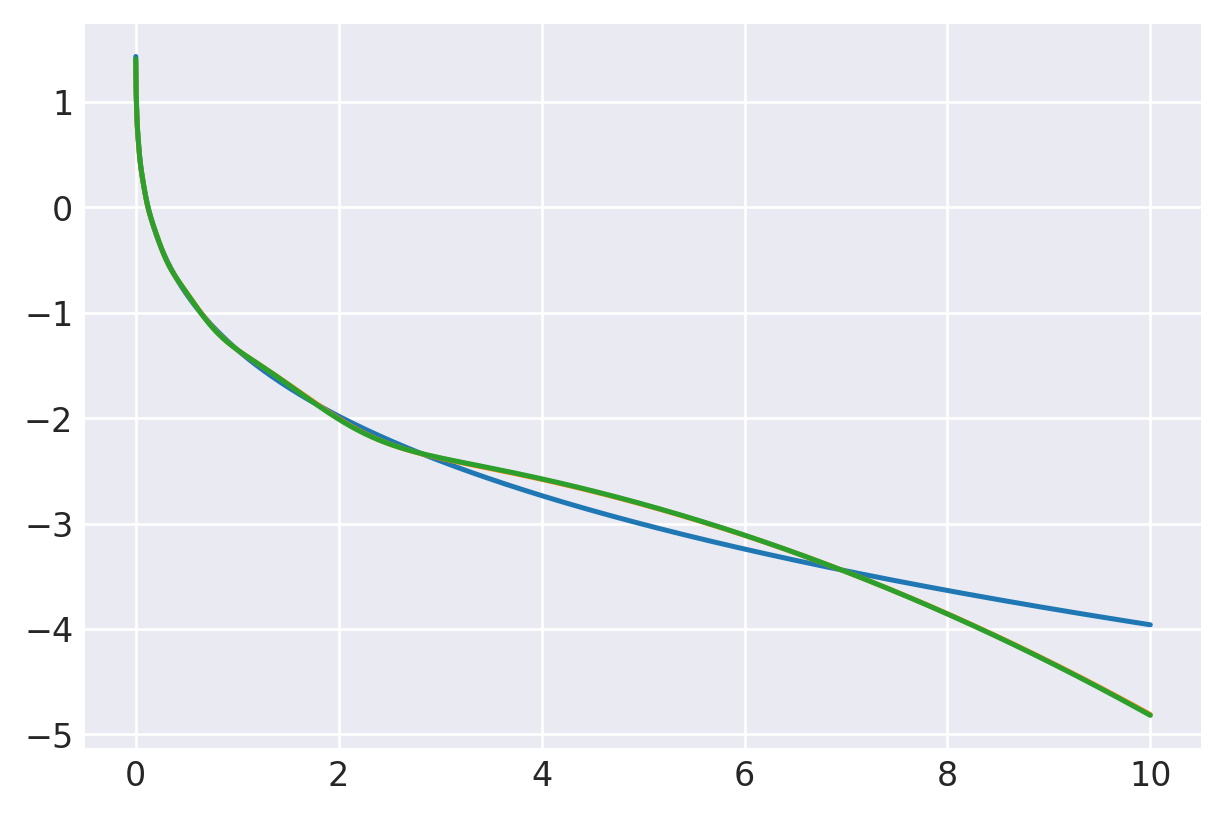

3.9: (
    normalize(np.array([ 3.6342255989e-01, 3.2447381326e-01, 1.9055045360e-01, 8.3810924591e-02, 2.8696727620e-02, 7.5176794132e-03, 1.3878235118e-03, 1.4001811405e-04) ]),
    np.array([ 3.3560062995e+00, 9.8368622030e-01, 3.6677812385e-01, 1.4476137118e-01, 5.6676245235e-02, 2.0888838472e-02, 6.7220467970e-03, 1.5623622847e-03 ]),
),
prev.  chisq = -3.57654523998508


         Current function value: -3.797967
         Iterations: 19
         Function evaluations: 1201
         Gradient evaluations: 70
-3.797967345536465


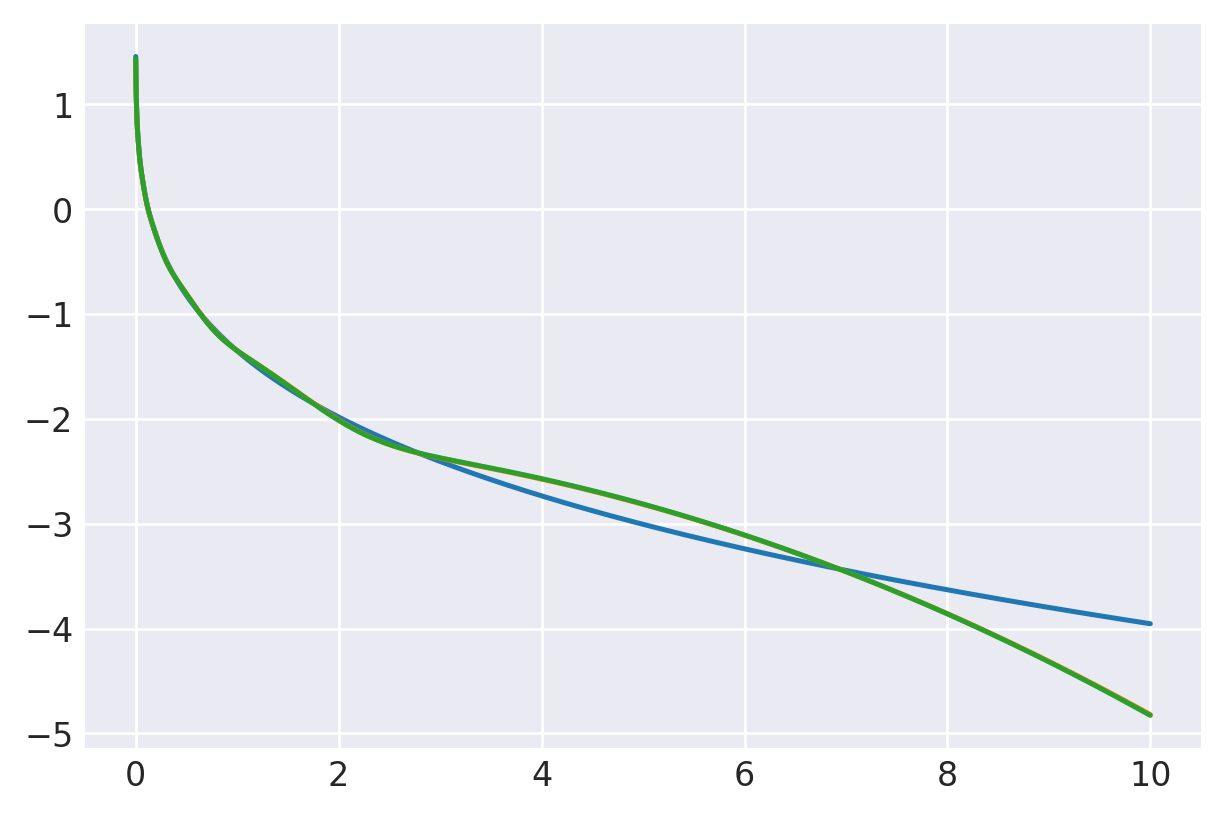

3.95: (
    normalize(np.array([ 3.6736029485e-01, 3.2356716781e-01, 1.8892258858e-01, 8.2862731665e-02, 2.8344577300e-02, 7.4288794429e-03, 1.3742759798e-03, 1.3948435813e-04) ]),
    np.array([ 3.3467036633e+00, 9.7121640498e-01, 3.5993291645e-01, 1.4136533674e-01, 5.5110058718e-02, 2.0233281490e-02, 6.4889755692e-03, 1.5046793325e-03 ]),
),
prev.  chisq = -3.5569070808983763


Optimization terminated successfully.
         Current function value: -3.771759
         Iterations: 20
         Function evaluations: 544
         Gradient evaluations: 32
-3.771758583282101


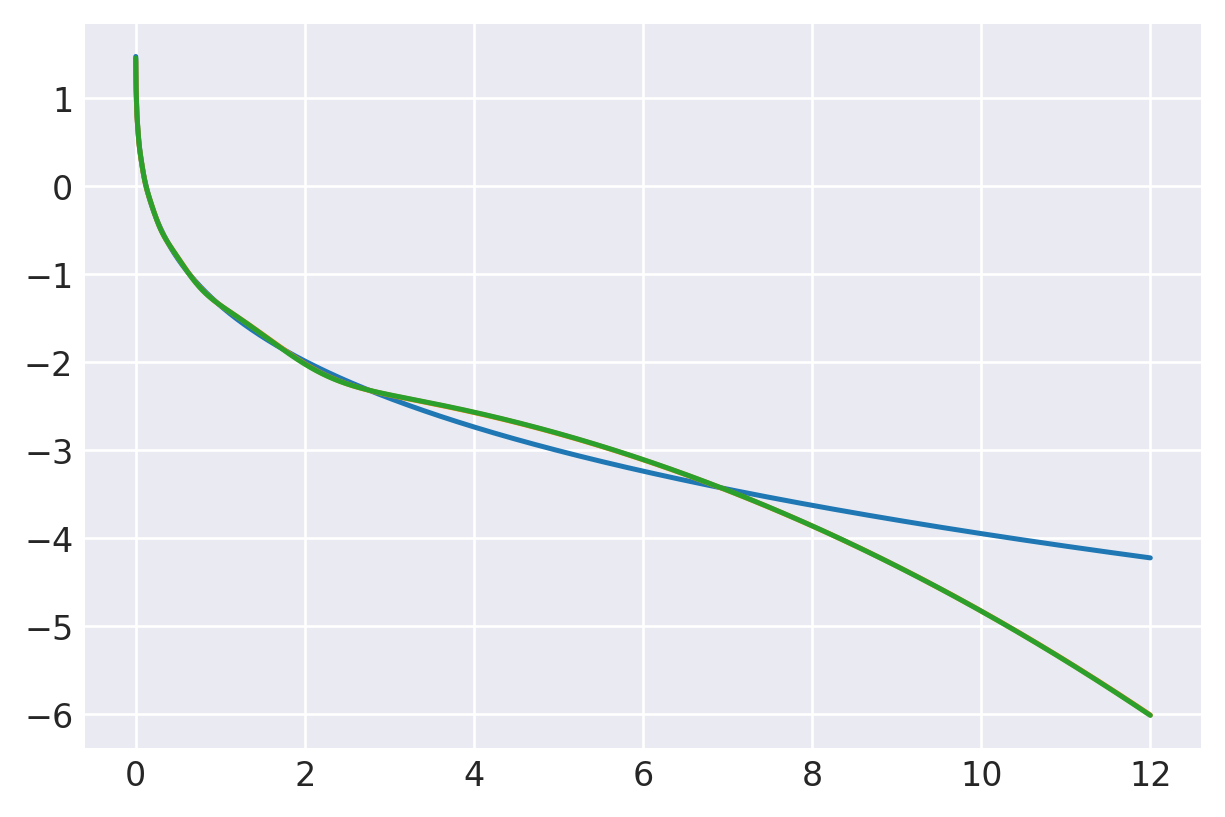

4.0: (
    normalize(np.array([ 3.7075114139e-01, 3.2280409587e-01, 1.8749664618e-01, 8.2039906106e-02, 2.8046425671e-02, 7.3574230960e-03, 1.3647898365e-03, 1.3957184585e-04) ]),
    np.array([ 3.3427245912e+00, 9.6027387847e-01, 3.5369147053e-01, 1.3824007297e-01, 5.3667520574e-02, 1.9631772487e-02, 6.2770878073e-03, 1.4533998846e-03 ]),
),
prev.  chisq = -3.5389536557201926


Optimization terminated successfully.
         Current function value: -3.748562
         Iterations: 19
         Function evaluations: 493
         Gradient evaluations: 29
-3.7485618534227343


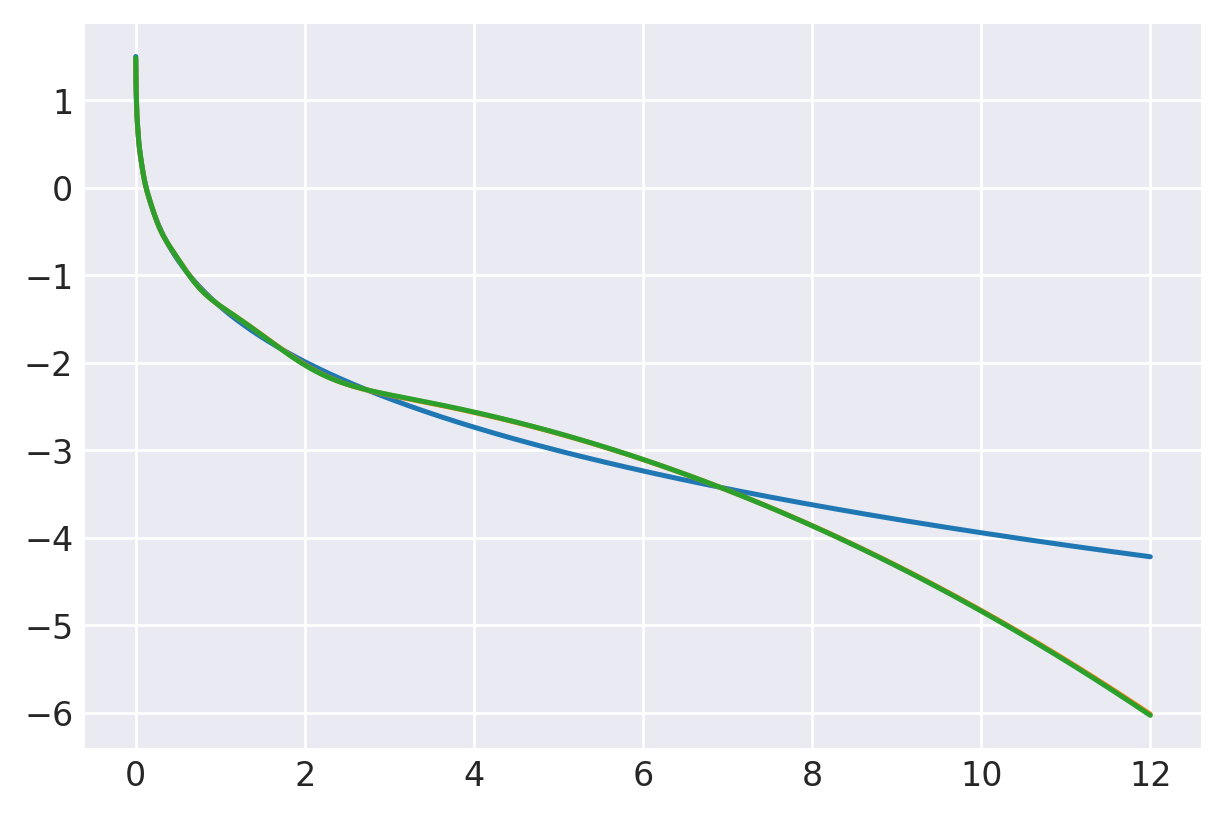

4.05: (
    normalize(np.array([ 3.7445656938e-01, 3.2185515841e-01, 1.8596950419e-01, 8.1188165971e-02, 2.7745794188e-02, 7.2881537358e-03, 1.3566151457e-03, 1.4003898138e-04) ]),
    np.array([ 3.3340911908e+00, 9.4860150163e-01, 3.4738628815e-01, 1.3515952073e-01, 5.2269461596e-02, 1.9057612065e-02, 6.0784498327e-03, 1.4068235113e-03 ]),
),
prev.  chisq = -3.521365752970814


         Current function value: -3.726136
         Iterations: 18
         Function evaluations: 1354
         Gradient evaluations: 79
-3.726135978981308


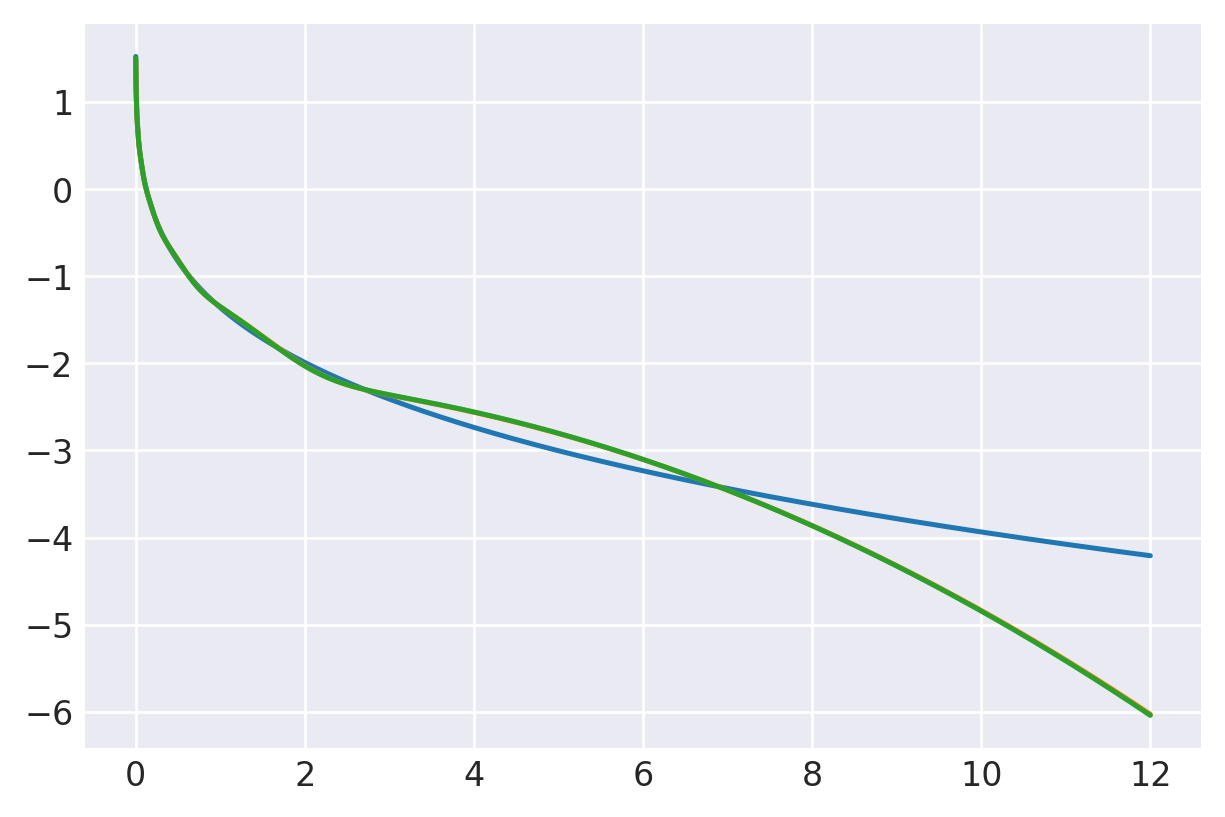

4.1: (
    normalize(np.array([ 3.7802592729e-01, 3.2089117424e-01, 1.8450011362e-01, 8.0388655955e-02, 2.7472586278e-02, 7.2292097384e-03, 1.3512866907e-03, 1.4104619596e-04) ]),
    np.array([ 3.3260165390e+00, 9.3738701203e-01, 3.4136515179e-01, 1.3223822233e-01, 5.0954065117e-02, 1.8522671022e-02, 5.8961119905e-03, 1.3653822077e-03 ]),
),
prev.  chisq = -3.5041286176045214


Optimization terminated successfully.
         Current function value: -3.704434
         Iterations: 19
         Function evaluations: 527
         Gradient evaluations: 31
-3.704433886939302


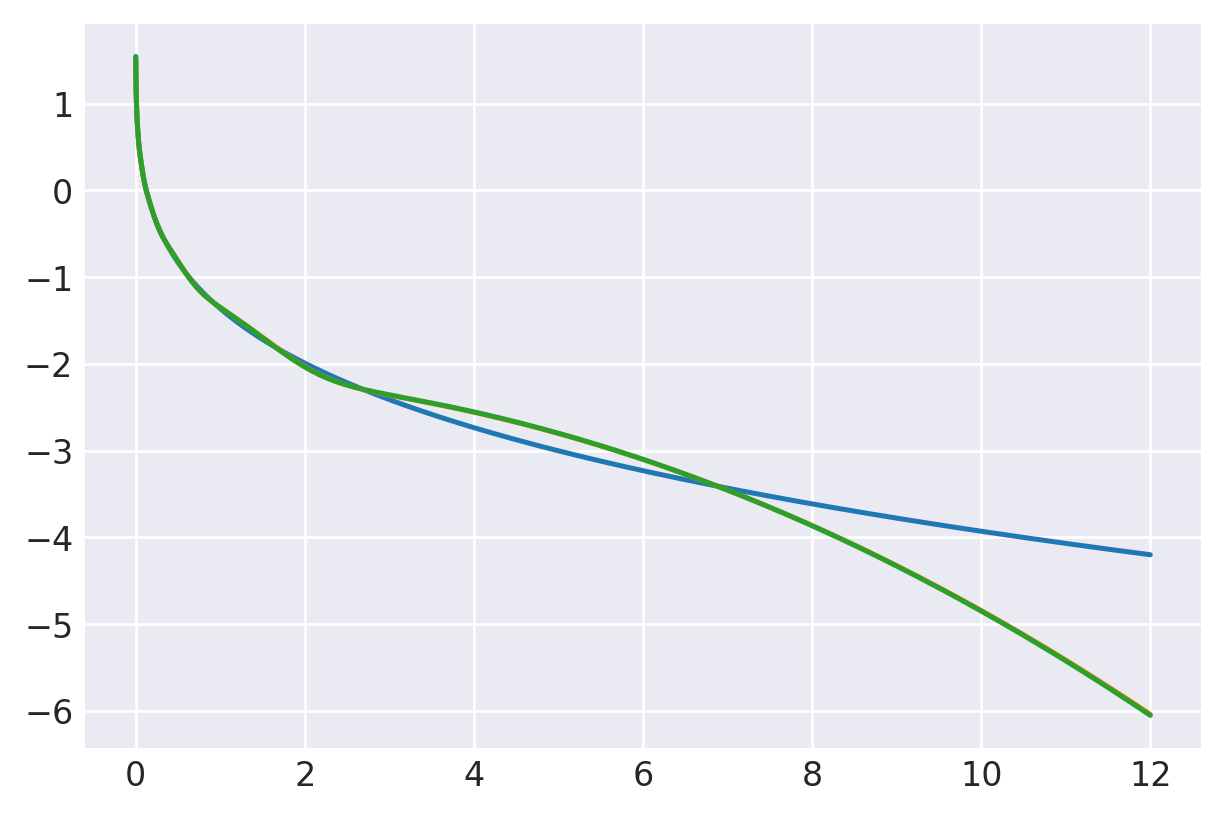

4.15: (
    normalize(np.array([ 3.8146107852e-01, 3.1991426850e-01, 1.8308742205e-01, 7.9639818025e-02, 2.7225849910e-02, 7.1802485153e-03, 1.3487238185e-03, 1.4259066387e-04) ]),
    np.array([ 3.3185057170e+00, 9.2662087928e-01, 3.3561848988e-01, 1.2946923058e-01, 4.9716990139e-02, 1.8024537543e-02, 5.7289047034e-03, 1.3286242672e-03 ]),
),
prev.  chisq = -3.487228199339723


Optimization terminated successfully.
         Current function value: -3.683408
         Iterations: 18
         Function evaluations: 510
         Gradient evaluations: 30
-3.6834084580680213


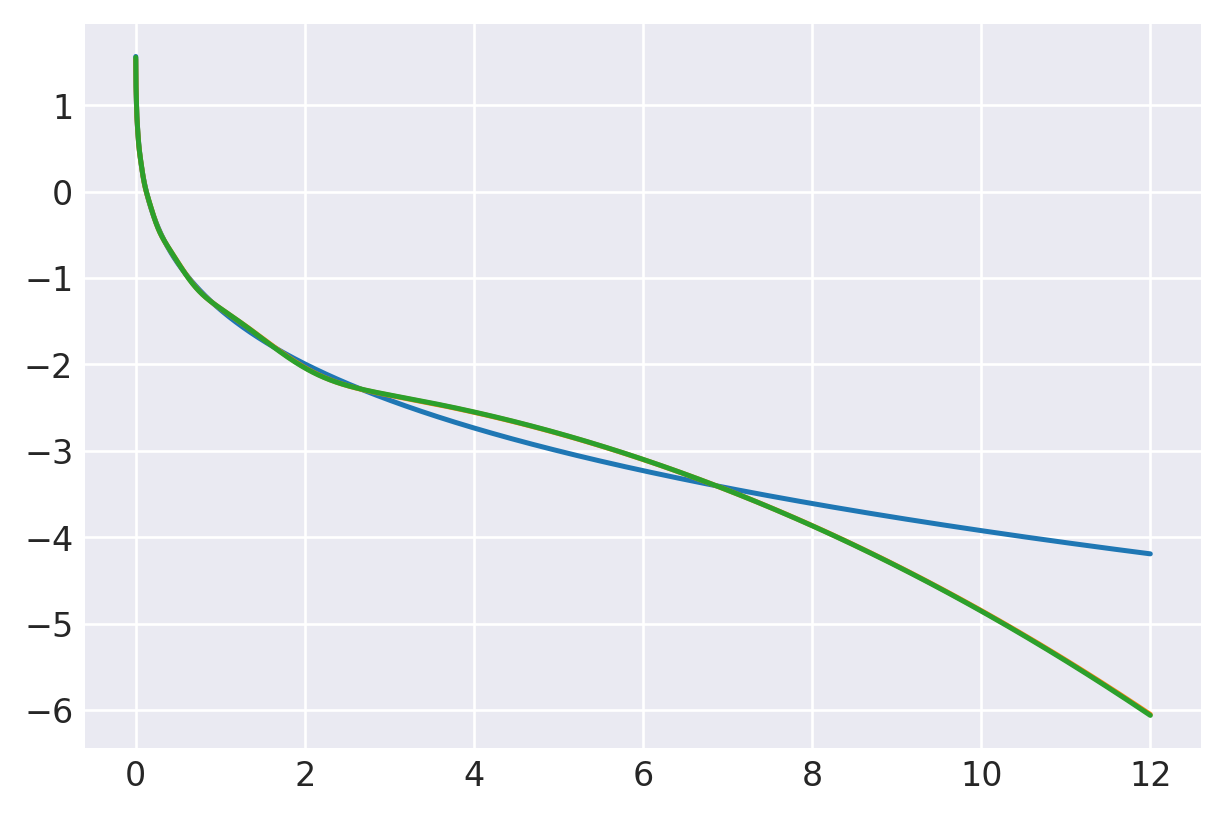

4.2: (
    normalize(np.array([ 3.8476547025e-01, 3.1892754804e-01, 1.8172989388e-01, 7.8939062572e-02, 2.7003975112e-02, 7.1406270139e-03, 1.3487690640e-03, 1.4465407426e-04) ]),
    np.array([ 3.3115559160e+00, 9.1628649545e-01, 3.3013247502e-01, 1.2684337291e-01, 4.8552819987e-02, 1.7560337379e-02, 5.5754788497e-03, 1.2960401204e-03 ]),
),
prev.  chisq = -3.4706490468041


Optimization terminated successfully.
         Current function value: -3.663015
         Iterations: 20
         Function evaluations: 544
         Gradient evaluations: 32
-3.663014527705821


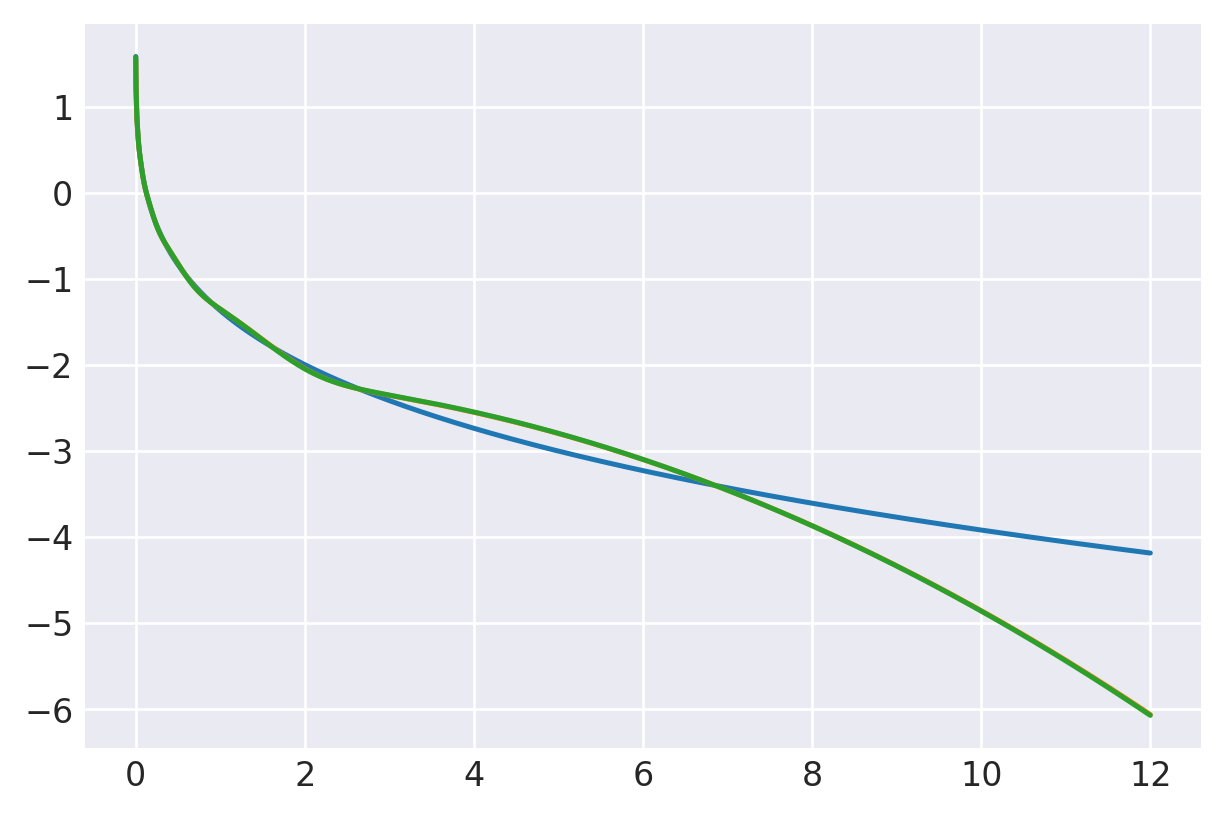

4.25: (
    normalize(np.array([ 3.8794716721e-01, 3.1793327020e-01, 1.8042410506e-01, 7.8282639651e-02, 2.6804858949e-02, 7.1095416425e-03, 1.3512083625e-03, 1.4720892203e-04) ]),
    np.array([ 3.3051189305e+00, 9.0635360468e-01, 3.2488857731e-01, 1.2434984074e-01, 4.7455586727e-02, 1.7126987973e-02, 5.4344109230e-03, 1.2671098940e-03 ]),
),
prev.  chisq = -3.4543763665048655


Optimization terminated successfully.
         Current function value: -3.643210
         Iterations: 16
         Function evaluations: 476
         Gradient evaluations: 28
-3.6432101681406928


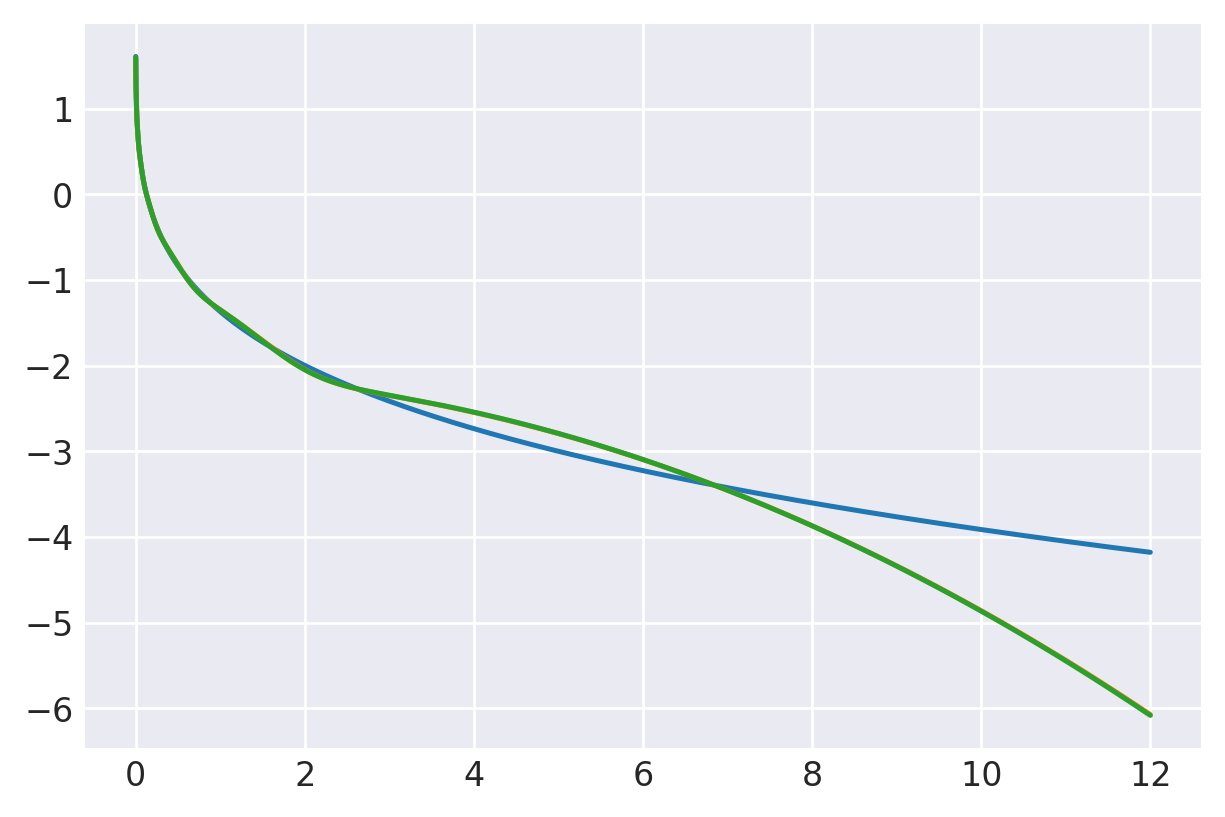

4.3: (
    normalize(np.array([ 3.9101493188e-01, 3.1693396059e-01, 1.7916636663e-01, 7.7666442608e-02, 2.6626172110e-02, 7.0860969423e-03, 1.3558065184e-03, 1.5022271389e-04) ]),
    np.array([ 3.2991418353e+00, 8.9678928304e-01, 3.1986700304e-01, 1.2197733459e-01, 4.6419184463e-02, 1.6721413433e-02, 5.3043092772e-03, 1.2413351321e-03 ]),
),
prev.  chisq = -3.4383965340622566


Optimization terminated successfully.
         Current function value: -3.623957
         Iterations: 17
         Function evaluations: 476
         Gradient evaluations: 28
-3.6239572835887905


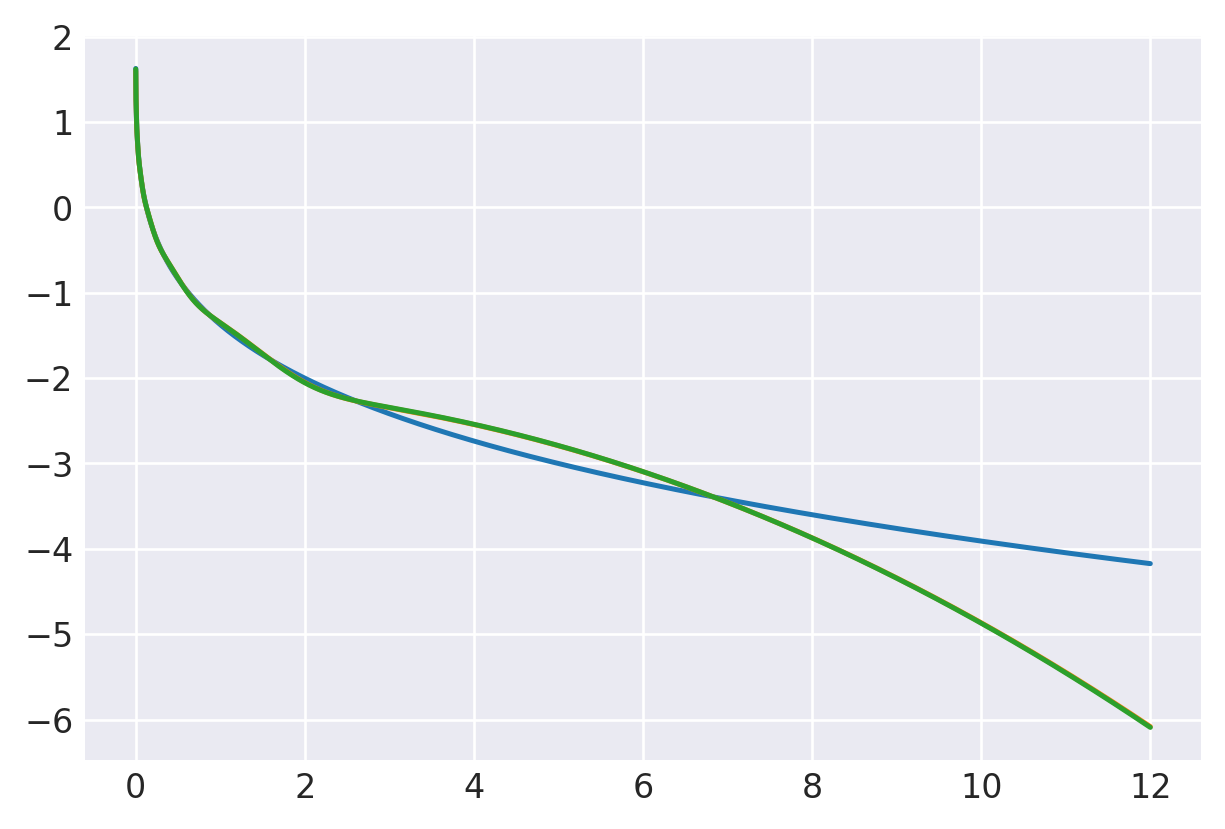

4.35: (
    normalize(np.array([ 3.9397806244e-01, 3.1593052636e-01, 1.7795337071e-01, 7.7086986132e-02, 2.6465687627e-02, 7.0693711477e-03, 1.3623322775e-03, 1.5366331616e-04) ]),
    np.array([ 3.2935633710e+00, 8.8756212976e-01, 3.1504997640e-01, 1.1971538462e-01, 4.5437768511e-02, 1.6340699753e-02, 5.1838956773e-03, 1.2182668432e-03 ]),
),
prev.  chisq = -3.4226964822876793


Optimization terminated successfully.
         Current function value: -3.605222
         Iterations: 18
         Function evaluations: 493
         Gradient evaluations: 29
-3.6052216981171217


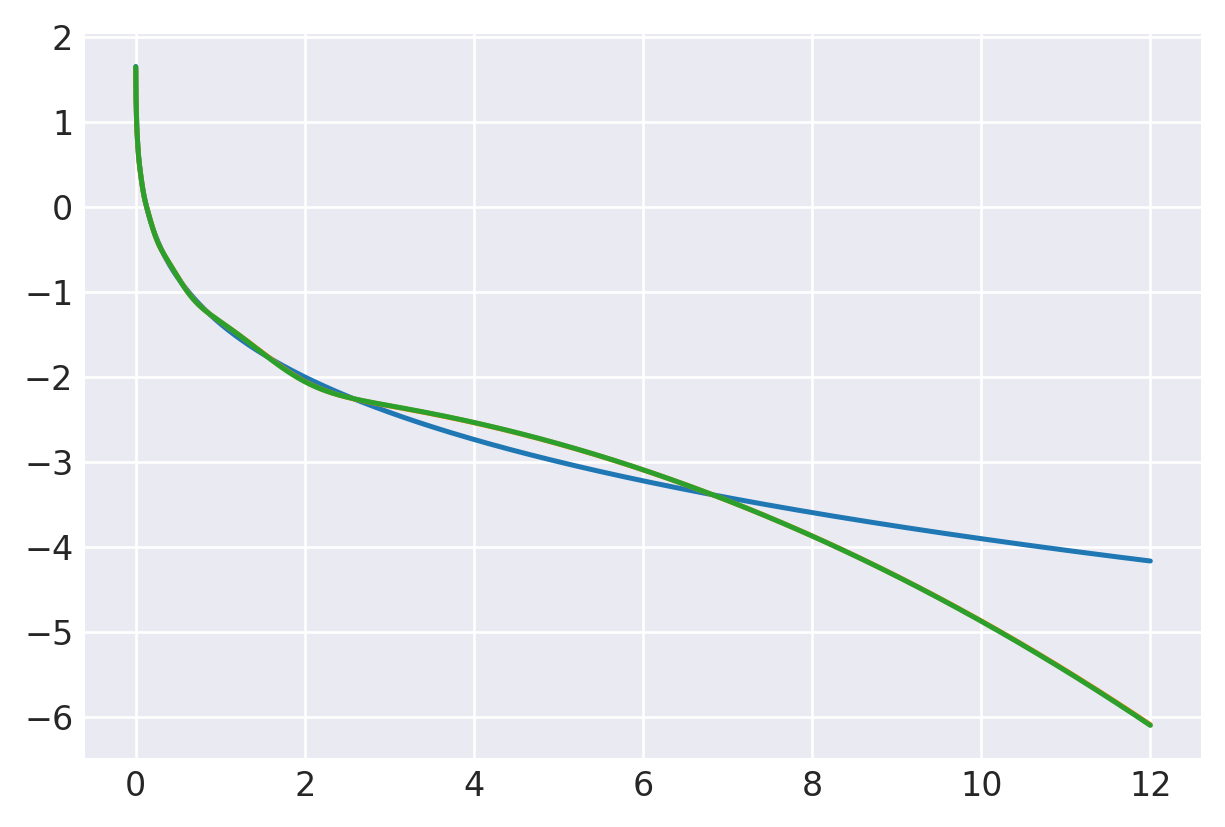

4.4: (
    normalize(np.array([ 3.9684417484e-01, 3.1492718945e-01, 1.7678097581e-01, 7.6539687754e-02, 2.6321269336e-02, 7.0586298714e-03, 1.3705725737e-03, 1.5750036370e-04) ]),
    np.array([ 3.2883414951e+00, 8.7863995573e-01, 3.1041754727e-01, 1.1755362406e-01, 4.4506241607e-02, 1.5982328795e-02, 5.0720241243e-03, 1.1975106587e-03 ]),
),
prev.  chisq = -3.407265179188586


         Current function value: -3.586973
         Iterations: 18
         Function evaluations: 996
         Gradient evaluations: 58
-3.5869729381810562


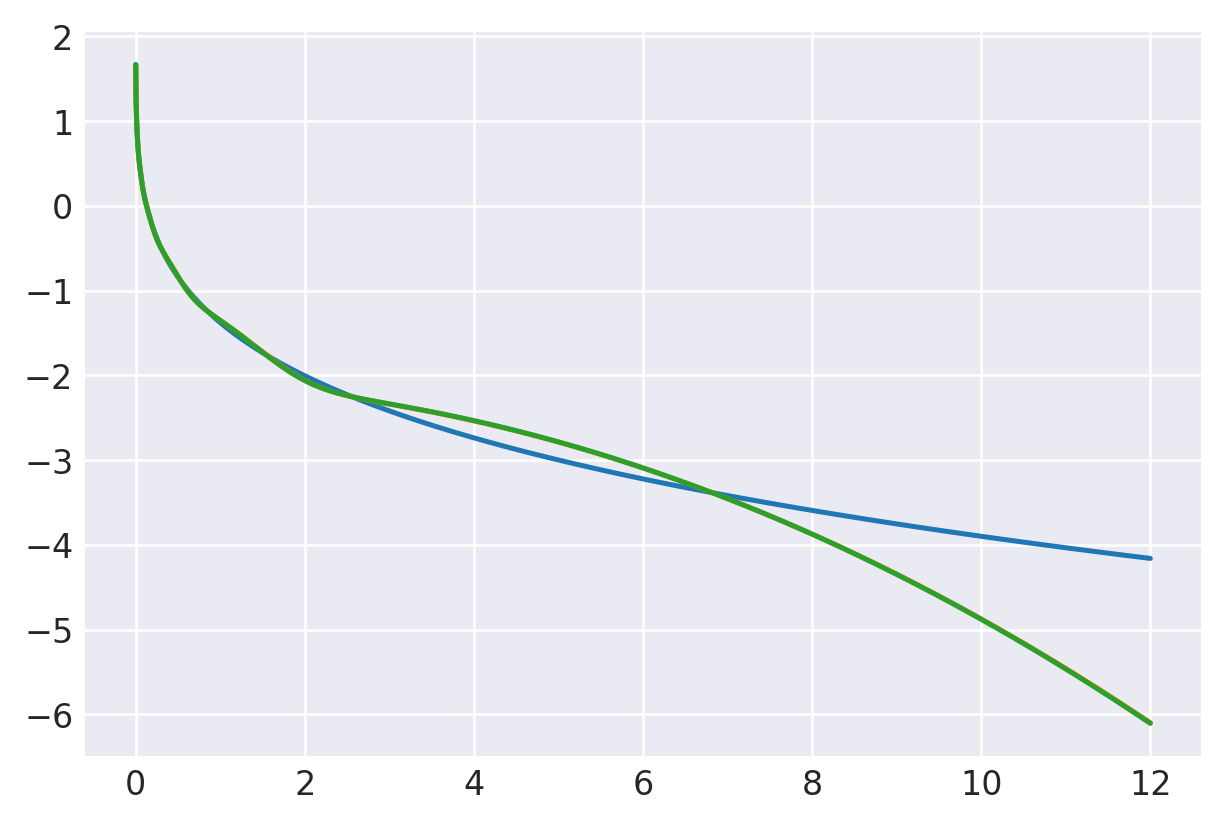

4.45: (
    normalize(np.array([ 3.9962258474e-01, 3.1392307184e-01, 1.7564621739e-01, 7.6021878220e-02, 2.6191091680e-02, 7.0531094489e-03, 1.3803388523e-03, 1.6170782157e-04) ]),
    np.array([ 3.2834096464e+00, 8.6999488367e-01, 3.0595543938e-01, 1.1548362187e-01, 4.3619867362e-02, 1.5643984387e-02, 4.9677058892e-03, 1.1787324253e-03 ]),
),
prev.  chisq = -3.3920922940962095


Optimization terminated successfully.
         Current function value: -3.569184
         Iterations: 18
         Function evaluations: 493
         Gradient evaluations: 29
-3.569183868518656


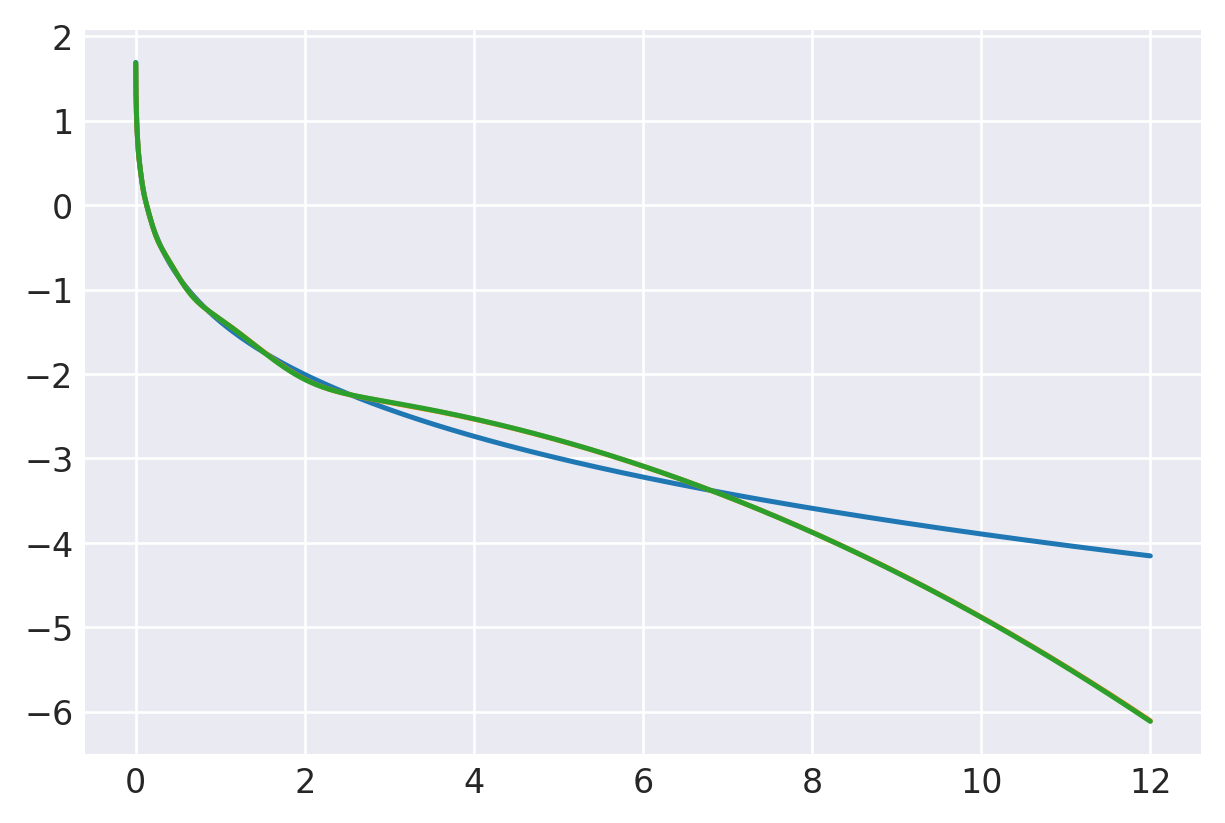

4.5: (
    normalize(np.array([ 4.0231986224e-01, 3.1292007635e-01, 1.7454611713e-01, 7.5530467351e-02, 2.6073542188e-02, 7.0522035487e-03, 1.3914677993e-03, 1.6626338847e-04) ]),
    np.array([ 3.2787295207e+00, 8.6160274983e-01, 3.0164928471e-01, 1.1349756469e-01, 4.2774618904e-02, 1.5323703481e-02, 4.8700875728e-03, 1.1616500244e-03 ]),
),
prev.  chisq = -3.3771688559975557


Optimization terminated successfully.
         Current function value: -3.551830
         Iterations: 18
         Function evaluations: 493
         Gradient evaluations: 29
-3.551830282797335


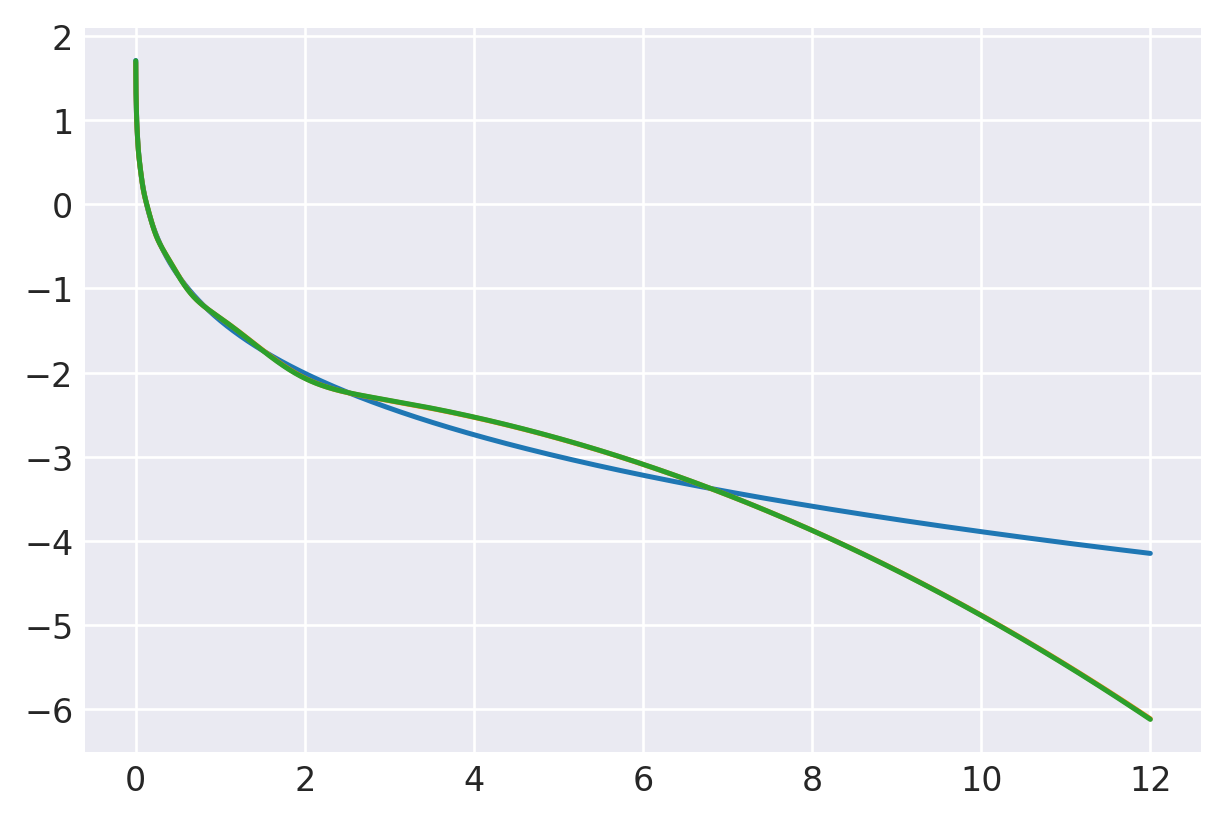

4.55: (
    normalize(np.array([ 4.0494230072e-01, 3.1191903425e-01, 1.7347809896e-01, 7.5062962127e-02, 2.5967248837e-02, 7.0553846121e-03, 1.4038216149e-03, 1.7114887897e-04) ]),
    np.array([ 3.2742624213e+00, 8.5344238085e-01, 2.9748701573e-01, 1.1158876484e-01, 4.1966984017e-02, 1.5019786520e-02, 4.7784437807e-03, 1.1460284653e-03 ]),
),
prev.  chisq = -3.3624864151316594


Optimization terminated successfully.
         Current function value: -3.534891
         Iterations: 18
         Function evaluations: 493
         Gradient evaluations: 29
-3.5348905059268736


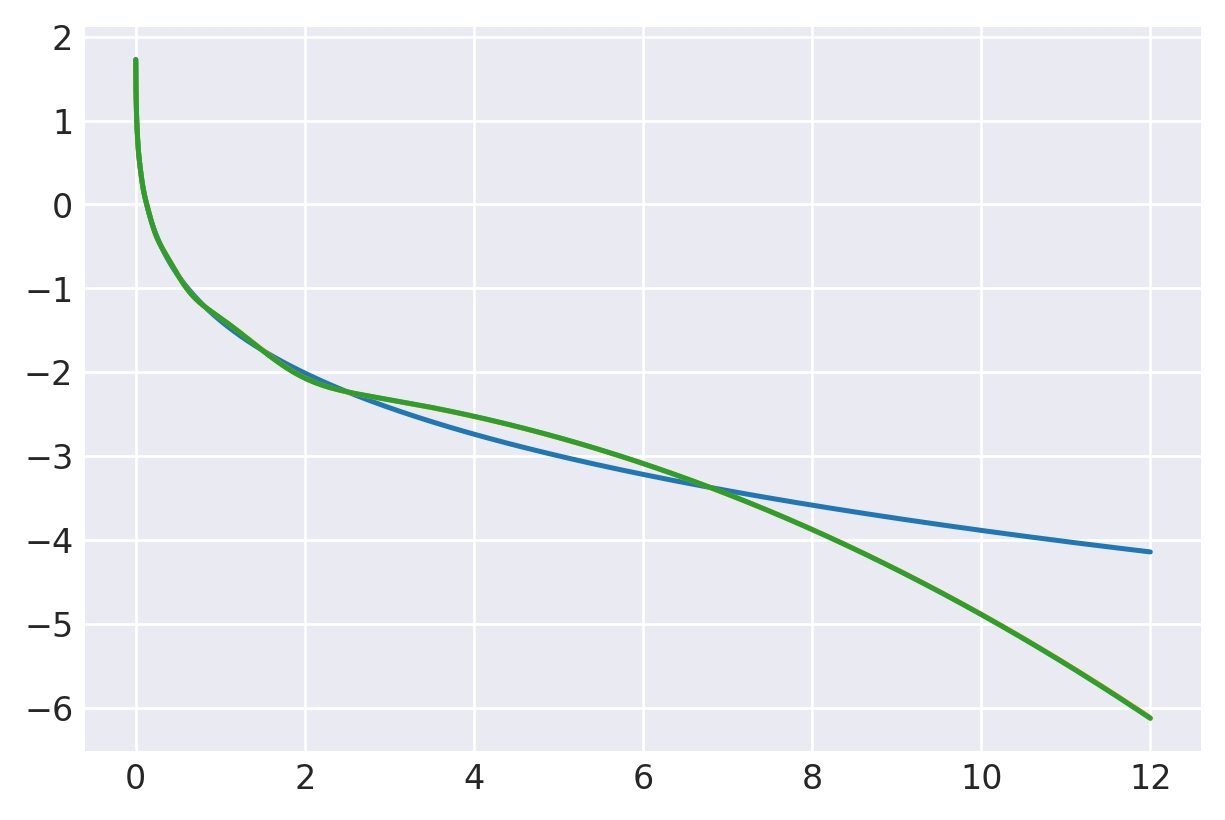

4.6: (
    normalize(np.array([ 4.0749525128e-01, 3.1092079594e-01, 1.7243991258e-01, 7.4617197764e-02, 2.5871023015e-02, 7.0621892530e-03, 1.4172810200e-03, 1.7634915273e-04) ]),
    np.array([ 3.2699771215e+00, 8.4549564095e-01, 2.9345804628e-01, 1.0975133191e-01, 4.1193866674e-02, 1.4730745770e-02, 4.6921498815e-03, 1.1316706830e-03 ]),
),
prev.  chisq = -3.348037618357111


         Current function value: -3.518345
         Iterations: 18
         Function evaluations: 1592
         Gradient evaluations: 93
-3.518345034419041


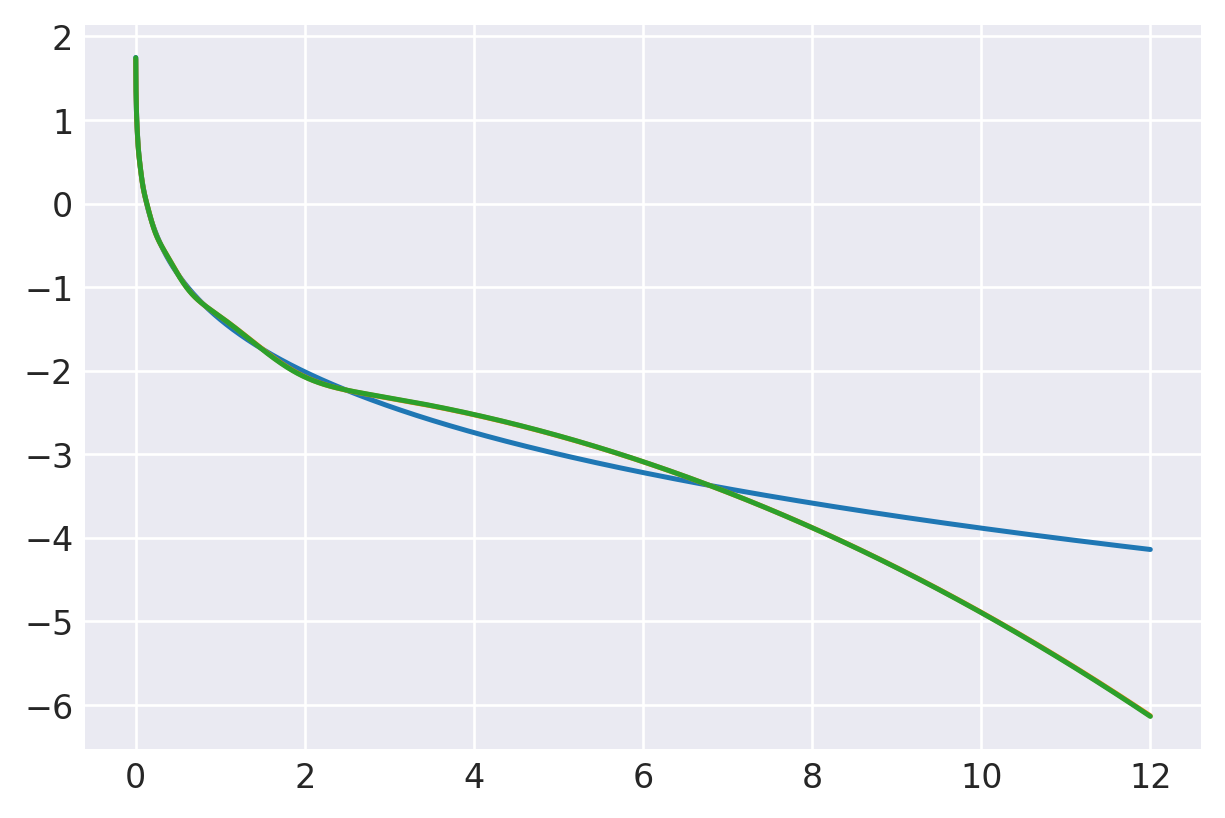

4.65: (
    normalize(np.array([ 4.0998295531e-01, 3.0992653818e-01, 1.7142966400e-01, 7.4191130115e-02, 2.5783825752e-02, 7.0722810542e-03, 1.4317523853e-03, 1.8185319614e-04) ]),
    np.array([ 3.2658522987e+00, 8.3774743388e-01, 2.8955294505e-01, 1.0798007588e-01, 4.0452685467e-02, 1.4455362928e-02, 4.6106856334e-03, 1.1184153297e-03 ]),
),
prev.  chisq = -3.3338152730601114


Optimization terminated successfully.
         Current function value: -3.502176
         Iterations: 19
         Function evaluations: 527
         Gradient evaluations: 31
-3.5021762234141334


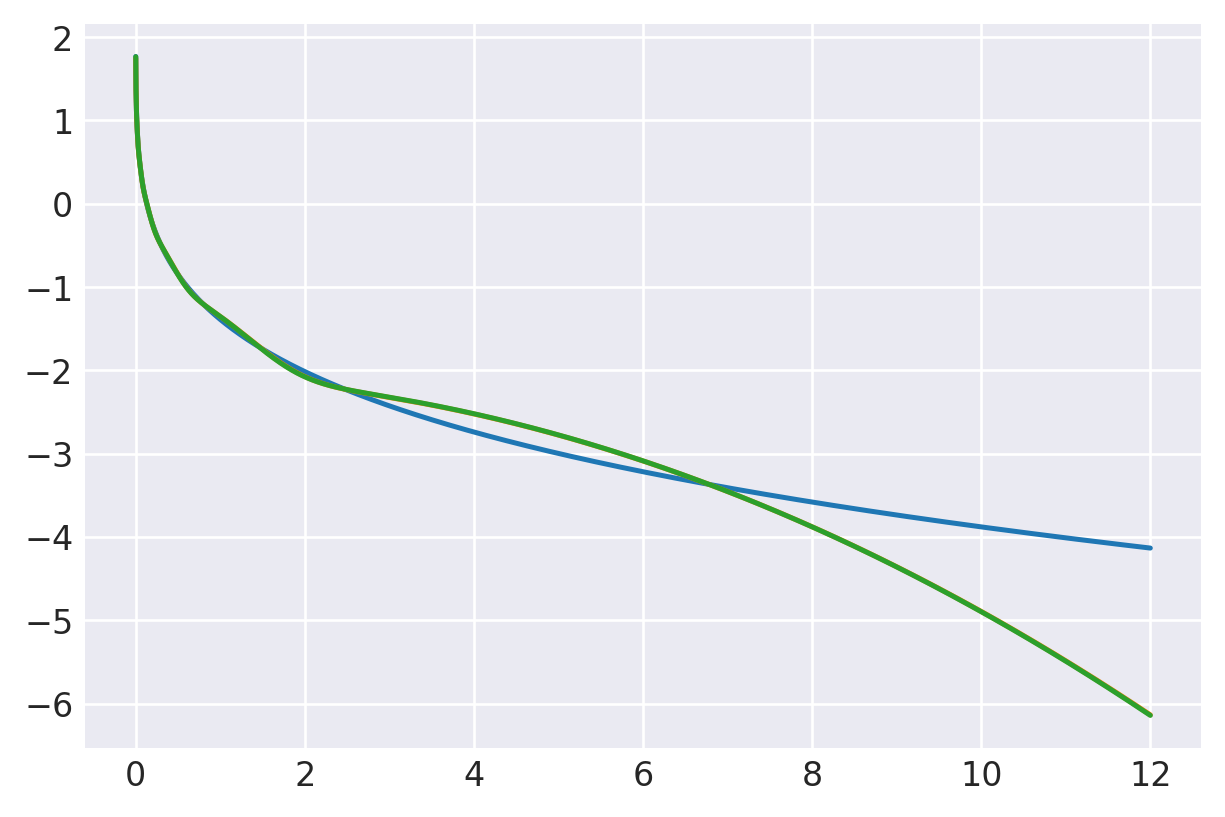

4.7: (
    normalize(np.array([ 4.1241012183e-01, 3.0893607548e-01, 1.7044551948e-01, 7.3783353506e-02, 2.5704839289e-02, 7.0852931781e-03, 1.4471464497e-03, 1.8765079478e-04) ]),
    np.array([ 3.2618589504e+00, 8.3018361341e-01, 2.8576403875e-01, 1.0627064420e-01, 3.9741037071e-02, 1.4192478295e-02, 4.5335841891e-03, 1.1061229455e-03 ]),
),
prev.  chisq = -3.319813450257898


Optimization terminated successfully.
         Current function value: -3.486368
         Iterations: 20
         Function evaluations: 561
         Gradient evaluations: 33
-3.4863680207853087


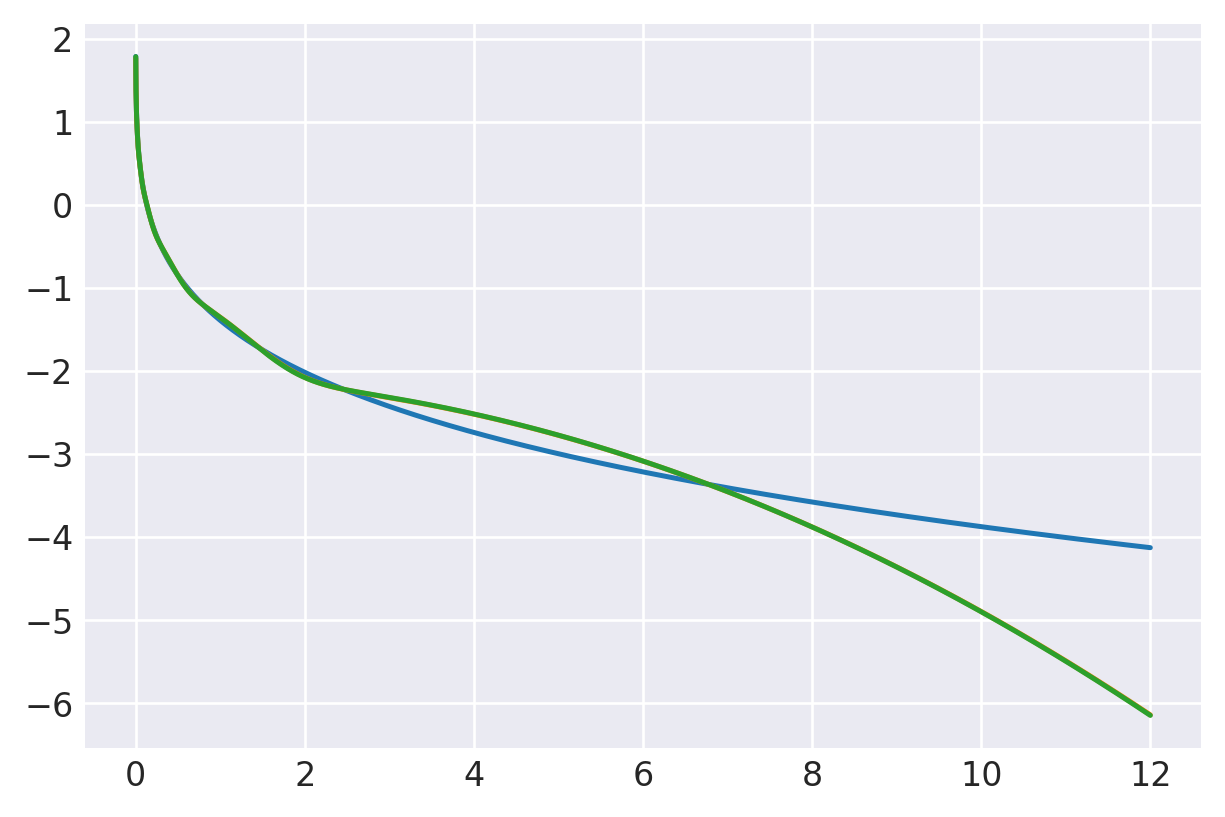

4.75: (
    normalize(np.array([ 4.1477981057e-01, 3.0795020055e-01, 1.6948614381e-01, 7.3392448934e-02, 2.5633303002e-02, 7.1009608176e-03, 1.4633970804e-03, 1.9373523881e-04) ]),
    np.array([ 3.2579843513e+00, 8.2279361504e-01, 2.8208437842e-01, 1.0461906769e-01, 3.9056890505e-02, 1.3941148500e-02, 4.4604607745e-03, 1.0946797670e-03 ]),
),
prev.  chisq = -3.306026082864157


Optimization terminated successfully.
         Current function value: -3.470906
         Iterations: 19
         Function evaluations: 493
         Gradient evaluations: 29
-3.4709057435222173


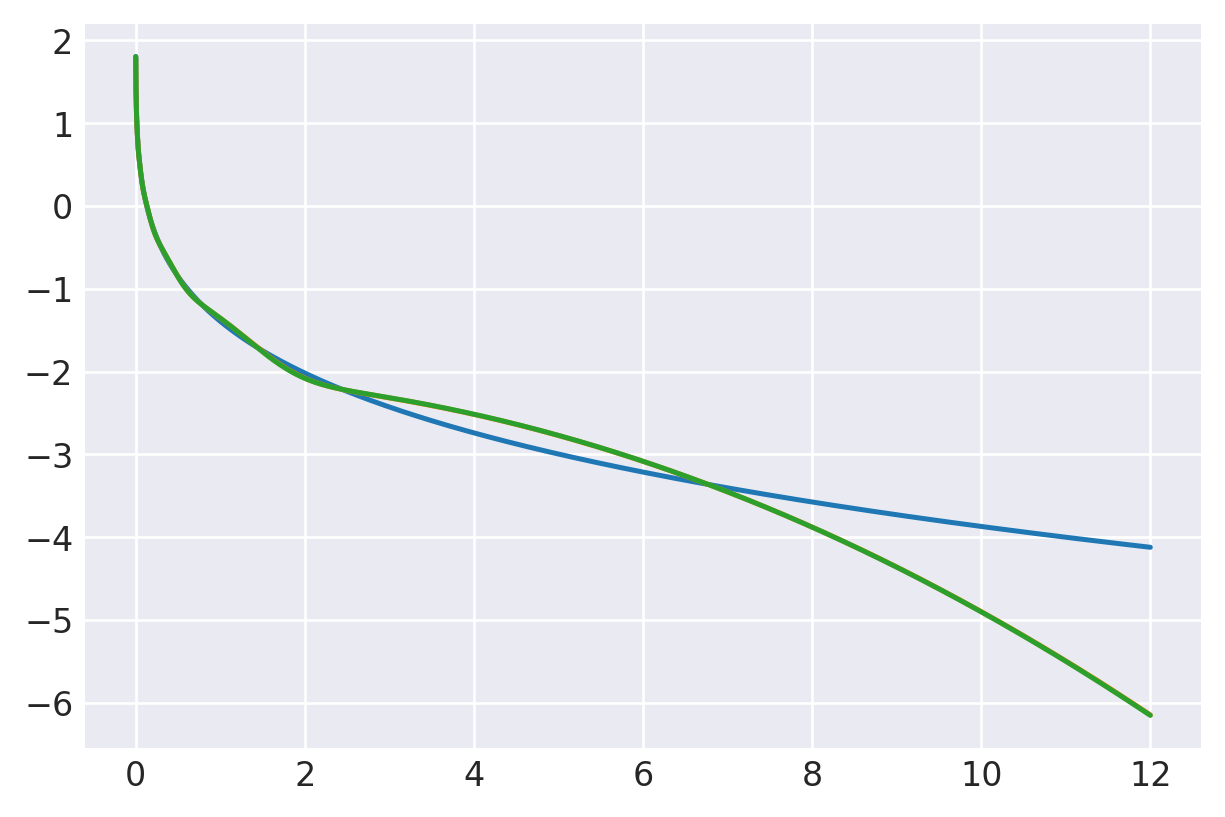

4.8: (
    normalize(np.array([ 4.1709520245e-01, 3.0696926415e-01, 1.6855014548e-01, 7.3017180477e-02, 2.5568605690e-02, 7.1190565858e-03, 1.4804440984e-03, 2.0010106694e-04) ]),
    np.array([ 3.2542128306e+00, 8.1556723415e-01, 2.7850774815e-01, 1.0302189417e-01, 3.8398464268e-02, 1.3700529797e-02, 4.3909736699e-03, 1.0839886711e-03 ]),
),
prev.  chisq = -3.2924477577783415


Optimization terminated successfully.
         Current function value: -3.455776
         Iterations: 19
         Function evaluations: 544
         Gradient evaluations: 32
-3.4557758910168093


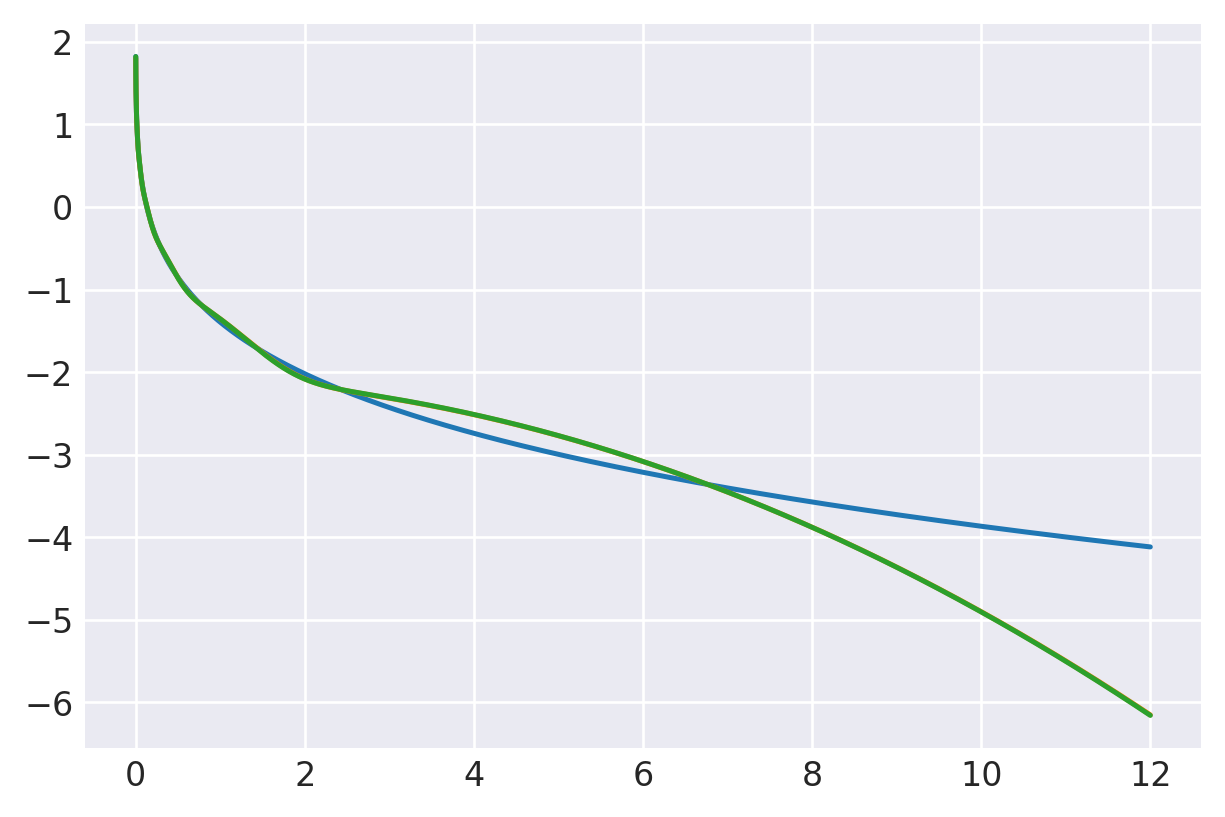

4.85: (
    normalize(np.array([ 4.1935897995e-01, 3.0599367950e-01, 1.6763632211e-01, 7.2656484050e-02, 2.5510178505e-02, 7.1393748794e-03, 1.4982367371e-03, 2.0674426867e-04) ]),
    np.array([ 3.2505330655e+00, 8.0849572955e-01, 2.7502860840e-01, 1.0147597883e-01, 3.7764130992e-02, 1.3469870328e-02, 4.3248255411e-03, 1.0739672151e-03 ]),
),
prev.  chisq = -3.279073187989771


         Current function value: -3.440966
         Iterations: 19
         Function evaluations: 1592
         Gradient evaluations: 93
-3.4409659893854503


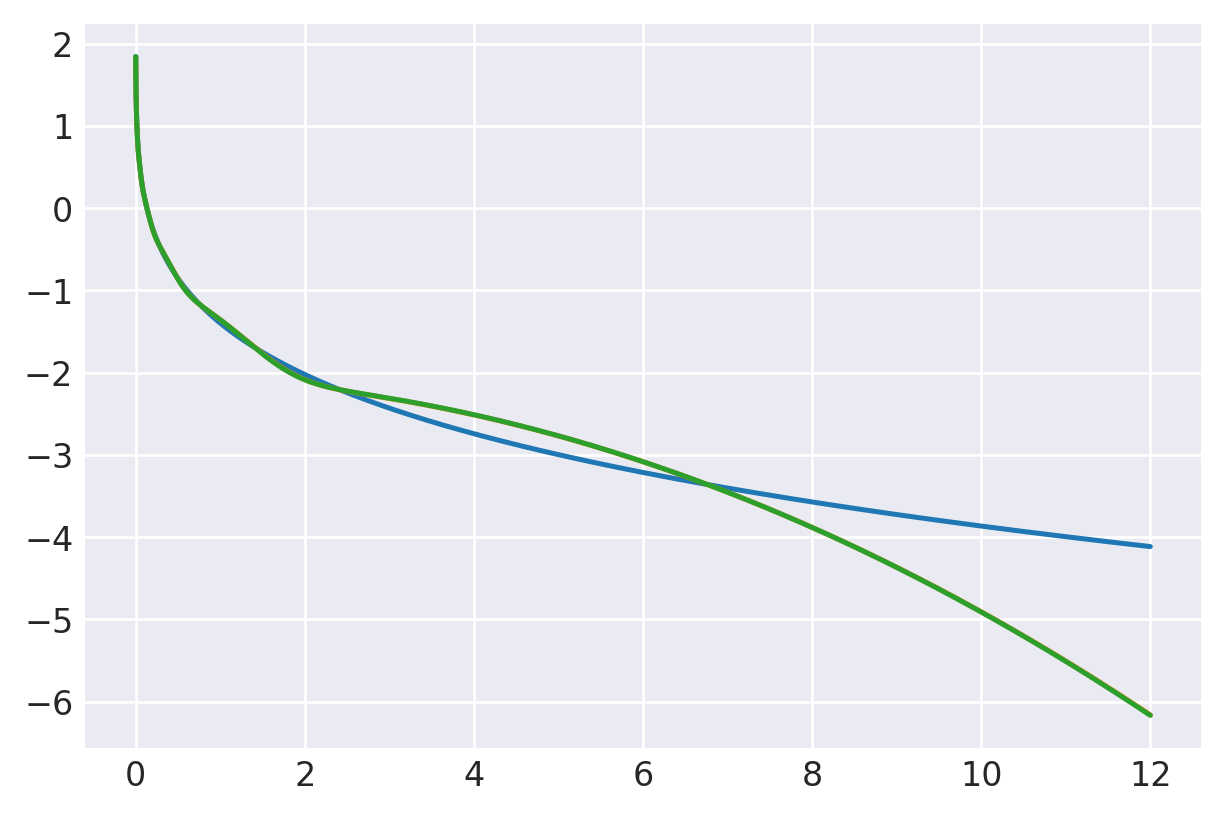

4.9: (
    normalize(np.array([ 4.2157352248e-01, 3.0502361475e-01, 1.6674370619e-01, 7.2309459585e-02, 2.5457559302e-02, 7.1617427232e-03, 1.5167330444e-03, 2.1366192404e-04) ]),
    np.array([ 3.2469361064e+00, 8.0157181113e-01, 2.7164222287e-01, 9.9978580591e-02, 3.7152463919e-02, 1.3248508200e-02, 4.2617568891e-03, 1.0645448001e-03 ]),
),
prev.  chisq = -3.265897093146173


         Current function value: -3.426464
         Iterations: 20
         Function evaluations: 1321
         Gradient evaluations: 77
-3.4264644615345365


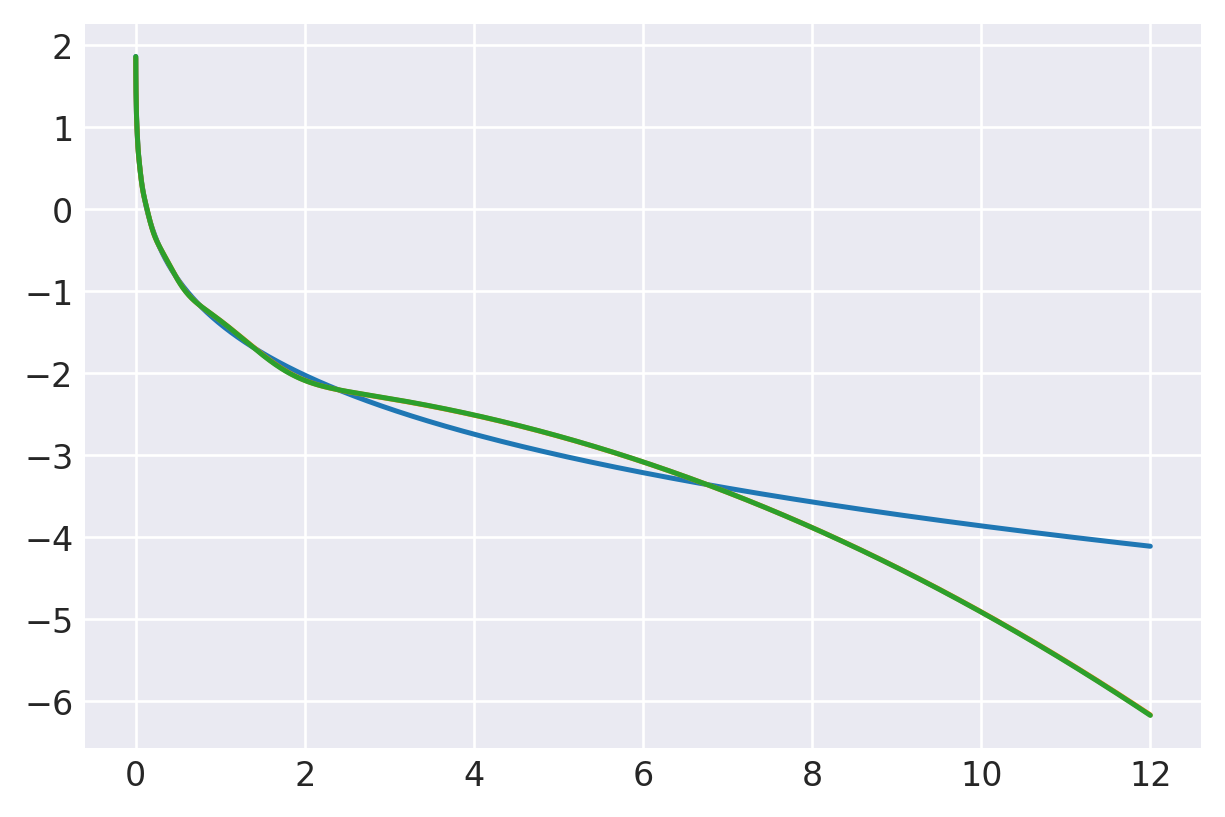

4.95: (
    normalize(np.array([ 4.2374097585e-01, 3.0405946201e-01, 1.6587119350e-01, 7.1975275539e-02, 2.5410335864e-02, 7.1860098280e-03, 1.5358947741e-03, 2.2085262795e-04) ]),
    np.array([ 3.2434122867e+00, 7.9478839103e-01, 2.6834406304e-01, 9.8527189357e-02, 3.6562166891e-02, 1.3035845398e-02, 4.2015374768e-03, 1.0556621305e-03 ]),
),
prev.  chisq = -3.2529158593324157


Optimization terminated successfully.
         Current function value: -3.412261
         Iterations: 18
         Function evaluations: 527
         Gradient evaluations: 31
-3.4122605184492674


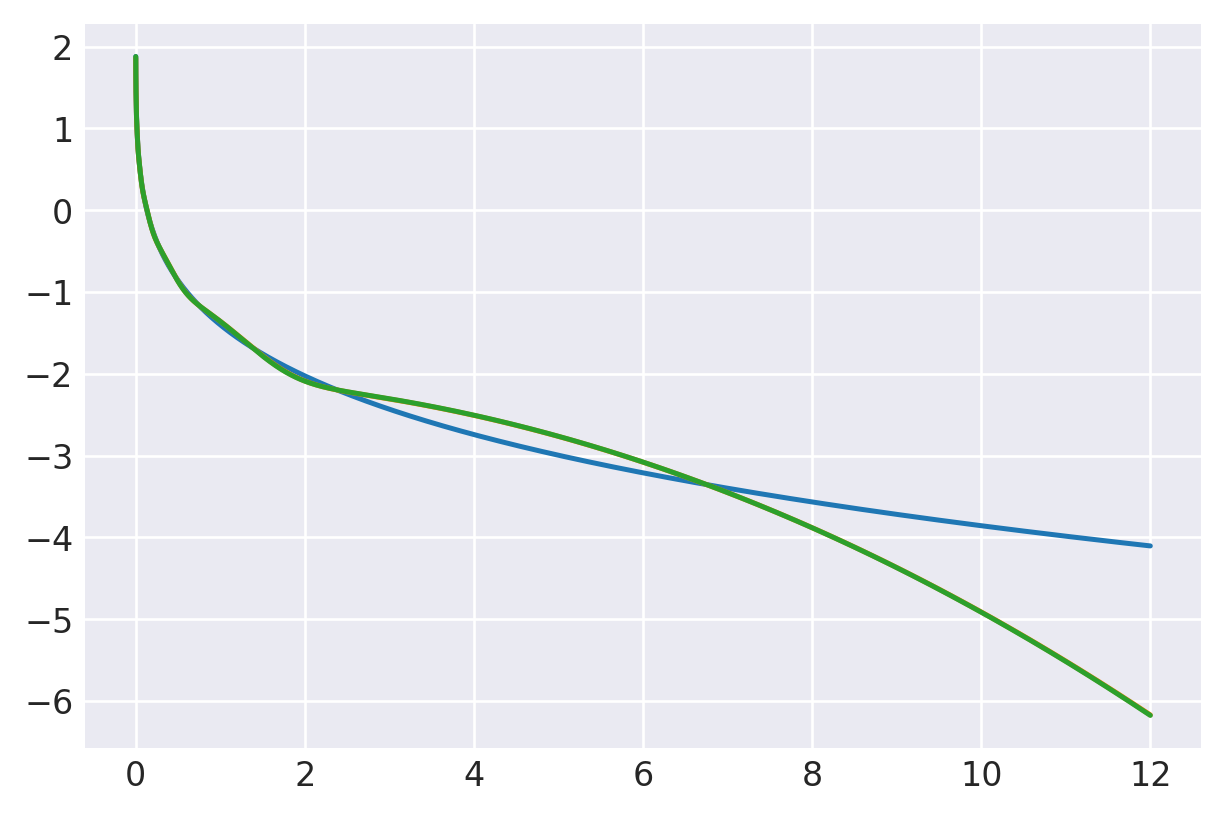

5.0: (
    normalize(np.array([ 4.2586355142e-01, 3.0310109739e-01, 1.6501806082e-01, 7.1653148647e-02, 2.5368102797e-02, 7.2120379290e-03, 1.5556865740e-03, 2.2831442319e-04) ]),
    np.array([ 3.2399533775e+00, 7.8813922787e-01, 2.6513007678e-01, 9.7119415910e-02, 3.5992029478e-02, 1.2831333426e-02, 4.1439553175e-03, 1.0472652441e-03 ]),
),
prev.  chisq = -3.2401251158369524


Optimization terminated successfully.
         Current function value: -3.398344
         Iterations: 19
         Function evaluations: 493
         Gradient evaluations: 29
-3.3983440679063133


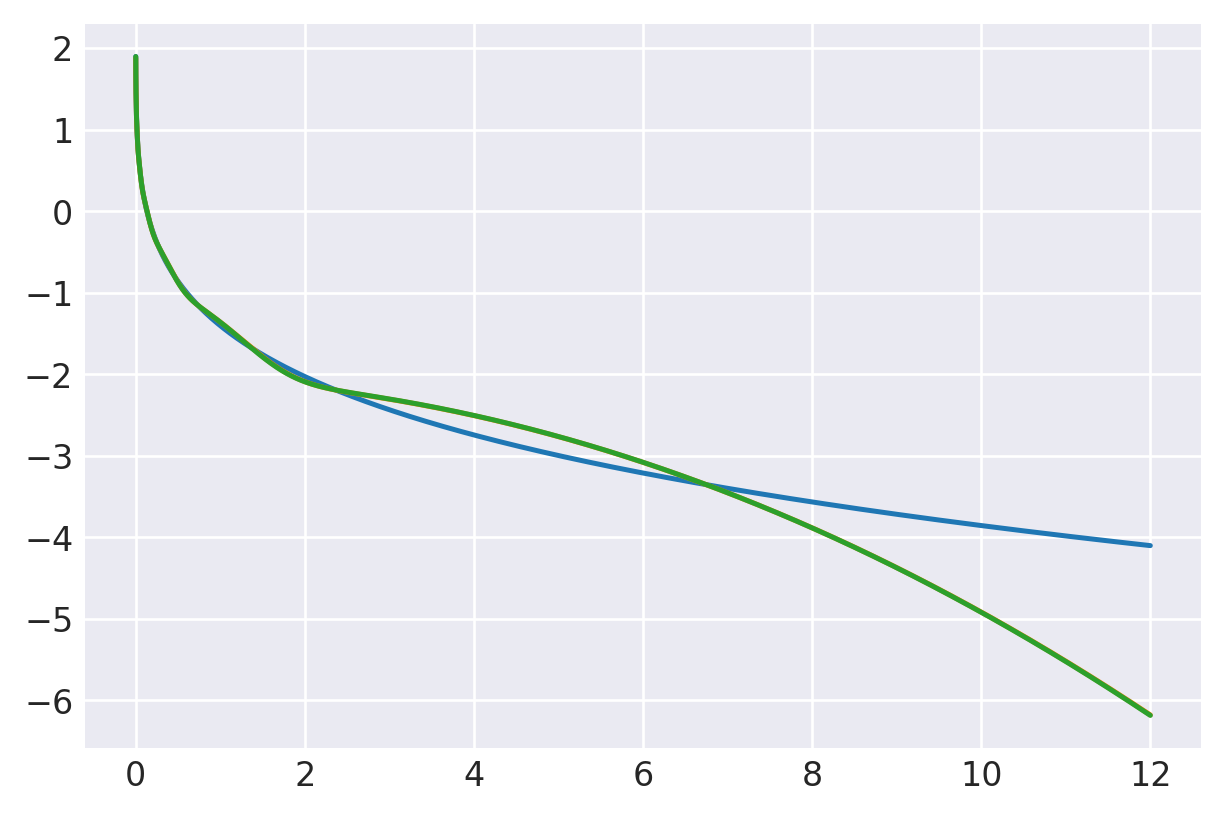

5.05: (
    normalize(np.array([ 4.2794219396e-01, 3.0214934928e-01, 1.6418365993e-01, 7.1342394290e-02, 2.5330544338e-02, 7.2397262941e-03, 1.5760846583e-03, 2.3604724746e-04) ]),
    np.array([ 3.2365627051e+00, 7.8162031669e-01, 2.6199671139e-01, 9.5753208340e-02, 3.5441025605e-02, 1.2634509834e-02, 4.0888341135e-03, 1.0393096572e-03 ]),
),
prev.  chisq = -3.2275196309446232


Optimization terminated successfully.
         Current function value: -3.384706
         Iterations: 20
         Function evaluations: 510
         Gradient evaluations: 30
-3.3847056374132065


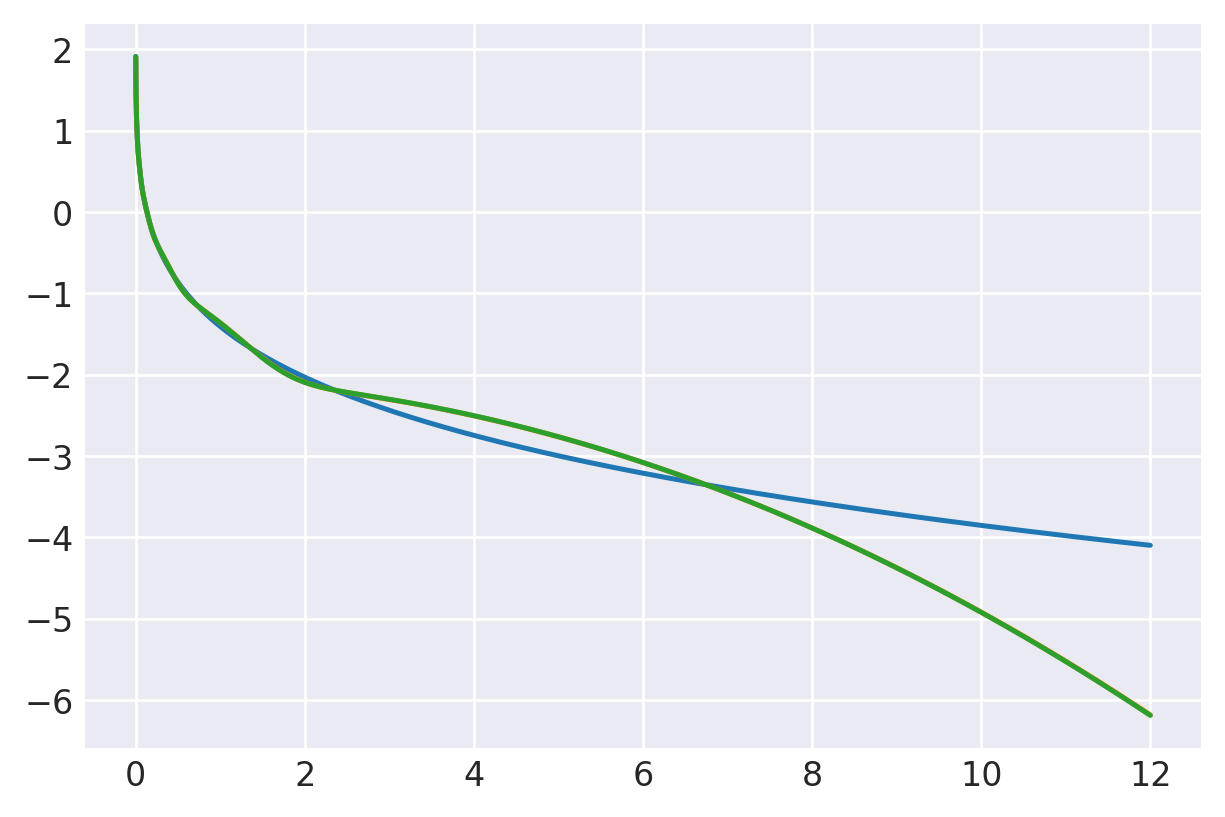

5.1: (
    normalize(np.array([ 4.2997947923e-01, 3.0120352127e-01, 1.6336701358e-01, 7.1042563475e-02, 2.5297374021e-02, 7.2689336404e-03, 1.5970630489e-03, 2.4405173186e-04) ]),
    np.array([ 3.2332250943e+00, 7.7522515218e-01, 2.5894071231e-01, 9.4426696793e-02, 3.4908109025e-02, 1.2444904417e-02, 4.0360108614e-03, 1.0317568416e-03 ]),
),
prev.  chisq = -3.215095615352454


Optimization terminated successfully.
         Current function value: -3.371336
         Iterations: 20
         Function evaluations: 527
         Gradient evaluations: 31
-3.371336308878293


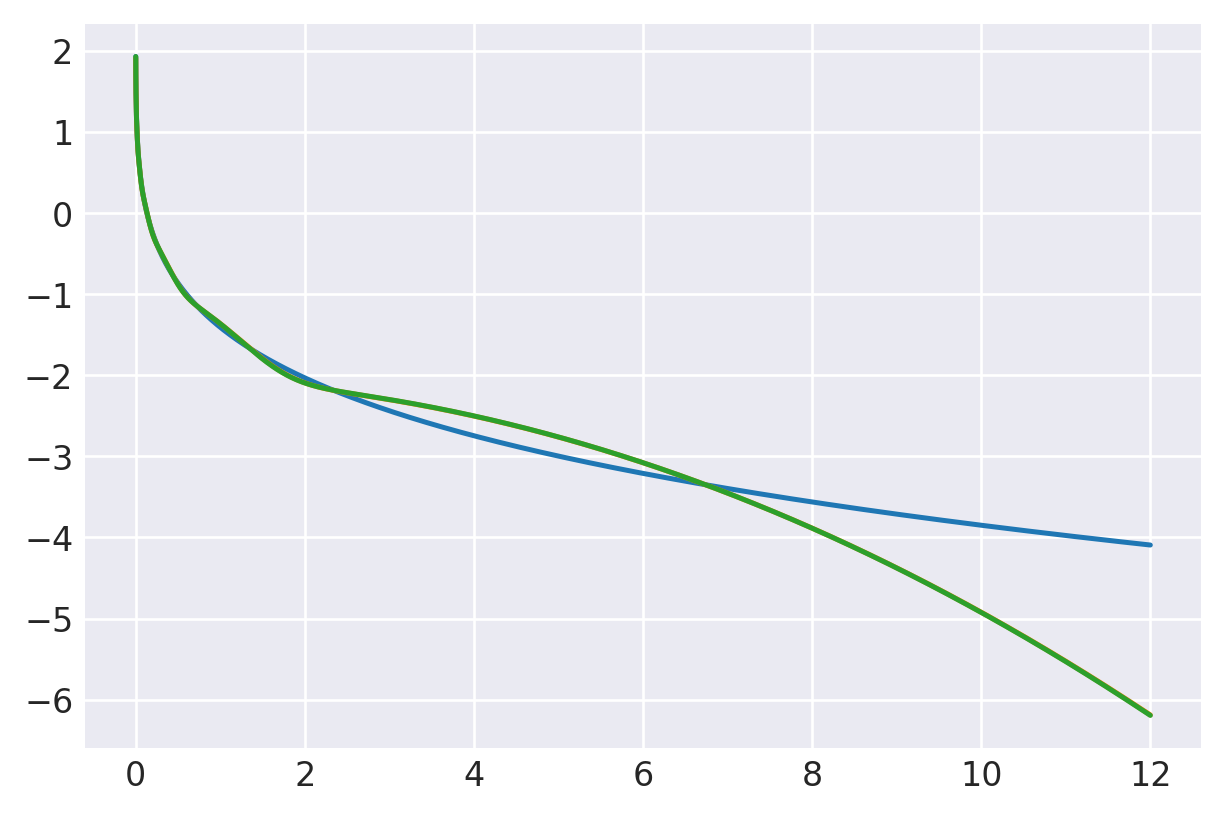

5.15: (
    normalize(np.array([ 4.3197625819e-01, 3.0026425872e-01, 1.6256758119e-01, 7.0753009998e-02, 2.5268352962e-02, 7.2996107490e-03, 1.6186002271e-03, 2.5232795617e-04) ]),
    np.array([ 3.2299434156e+00, 7.6895025264e-01, 2.5595896624e-01, 9.3138136628e-02, 3.4392464598e-02, 1.2262143270e-02, 3.9853345934e-03, 1.0245714271e-03 ]),
),
prev.  chisq = -3.20284947759992


Optimization terminated successfully.
         Current function value: -3.358228
         Iterations: 18
         Function evaluations: 510
         Gradient evaluations: 30
-3.358227662891719


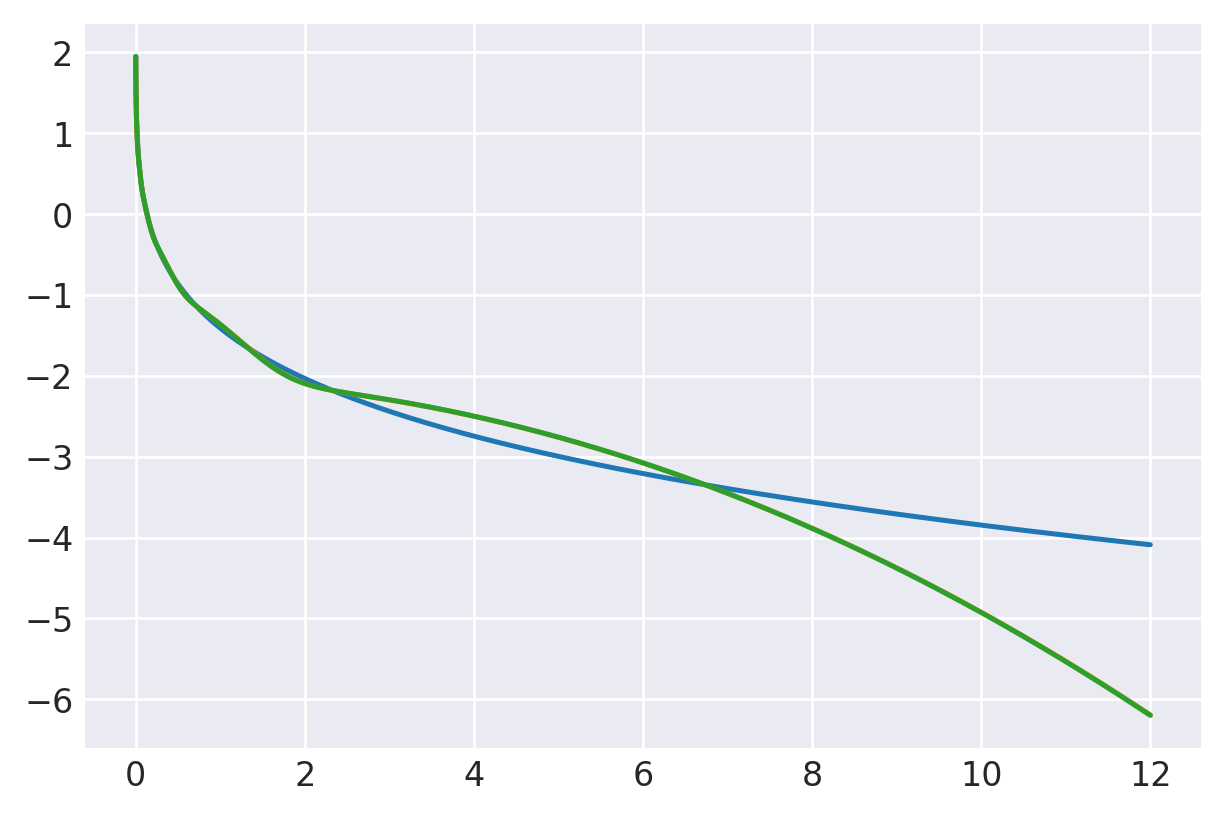

5.2: (
    normalize(np.array([ 4.3393388225e-01, 2.9933162961e-01, 1.6178478654e-01, 7.0473275859e-02, 2.5243216817e-02, 7.3316538192e-03, 1.6406779454e-03, 2.6087716085e-04) ]),
    np.array([ 3.2267147046e+00, 7.6279161154e-01, 2.5304864444e-01, 9.1885841345e-02, 3.3893211691e-02, 1.2085845940e-02, 3.9366738951e-03, 1.0177234634e-03 ]),
),
prev.  chisq = -3.1907773388857597


Optimization terminated successfully.
         Current function value: -3.345372
         Iterations: 18
         Function evaluations: 510
         Gradient evaluations: 30
-3.3453717309705846


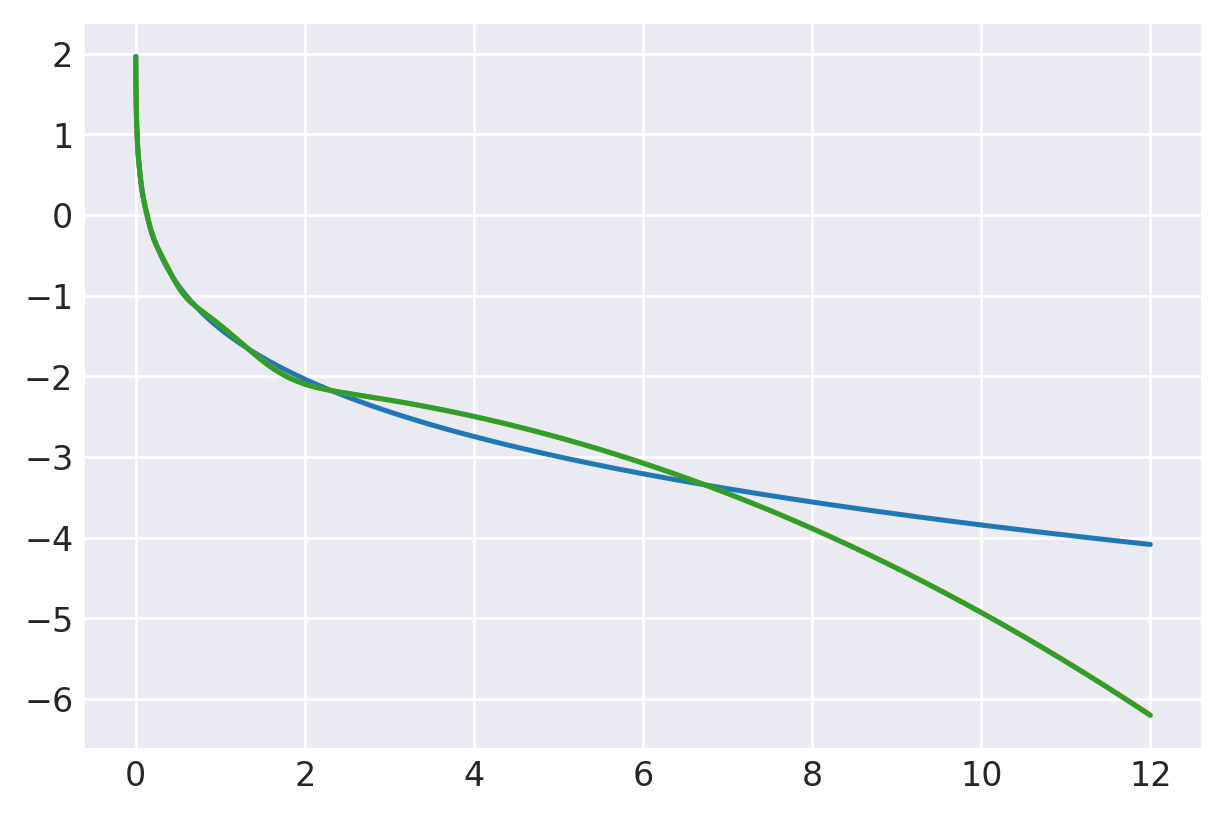

5.25: (
    normalize(np.array([ 4.3585381726e-01, 2.9840557642e-01, 1.6101798264e-01, 7.0202884907e-02, 2.5221764785e-02, 7.3649963434e-03, 1.6632772866e-03, 2.6970035075e-04) ]),
    np.array([ 3.2235342426e+00, 7.5674504676e-01, 2.5020703432e-01, 9.0668303637e-02, 3.3409598339e-02, 1.1915673555e-02, 3.8899039102e-03, 1.0111856743e-03 ]),
),
prev.  chisq = -3.1788755611071746


Optimization terminated successfully.
         Current function value: -3.332761
         Iterations: 18
         Function evaluations: 510
         Gradient evaluations: 30
-3.3327609543619983


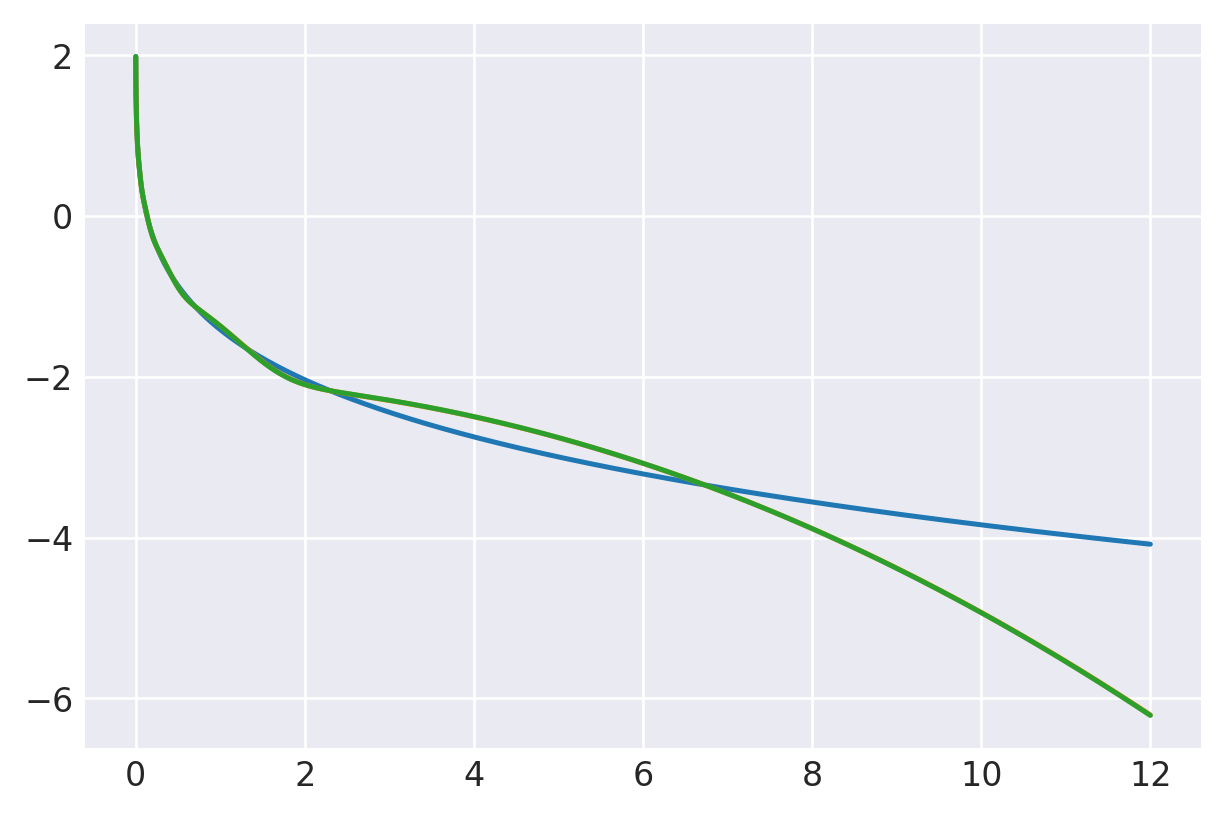

5.3: (
    normalize(np.array([ 4.3773710221e-01, 2.9748623321e-01, 1.6026667956e-01, 6.9941435195e-02, 2.5203798233e-02, 7.3995687465e-03, 1.6863837517e-03, 2.7879909051e-04) ]),
    np.array([ 3.2204013700e+00, 7.5080736041e-01, 2.4743170771e-01, 8.9484102186e-02, 3.2940904490e-02, 1.1751313304e-02, 3.8449145980e-03, 1.0049342780e-03 ]),
),
prev.  chisq = -3.1671406103985666


Optimization terminated successfully.
         Current function value: -3.320388
         Iterations: 19
         Function evaluations: 527
         Gradient evaluations: 31
-3.3203881483433997


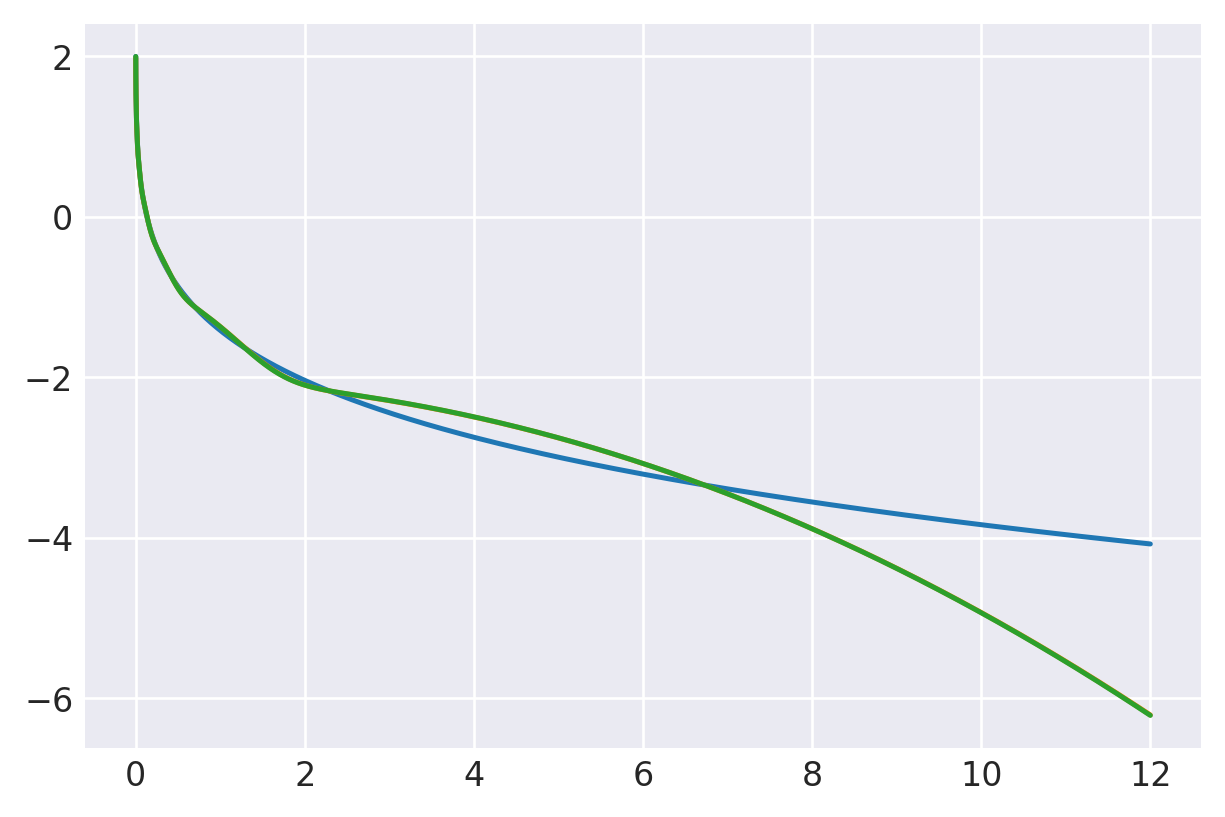

5.35: (
    normalize(np.array([ 4.3958502559e-01, 2.9657350944e-01, 1.5953028771e-01, 6.9688538360e-02, 2.5189163365e-02, 7.4353187401e-03, 1.7099819193e-03, 2.8817488130e-04) ]),
    np.array([ 3.2173122002e+00, 7.4497493055e-01, 2.4472033206e-01, 8.8331951315e-02, 3.2486487648e-02, 1.1592476590e-02, 3.8016017616e-03, 9.9894771730e-04 ]),
),
prev.  chisq = -3.155569097546383


Optimization terminated successfully.
         Current function value: -3.308246
         Iterations: 18
         Function evaluations: 527
         Gradient evaluations: 31
-3.3082464710650905


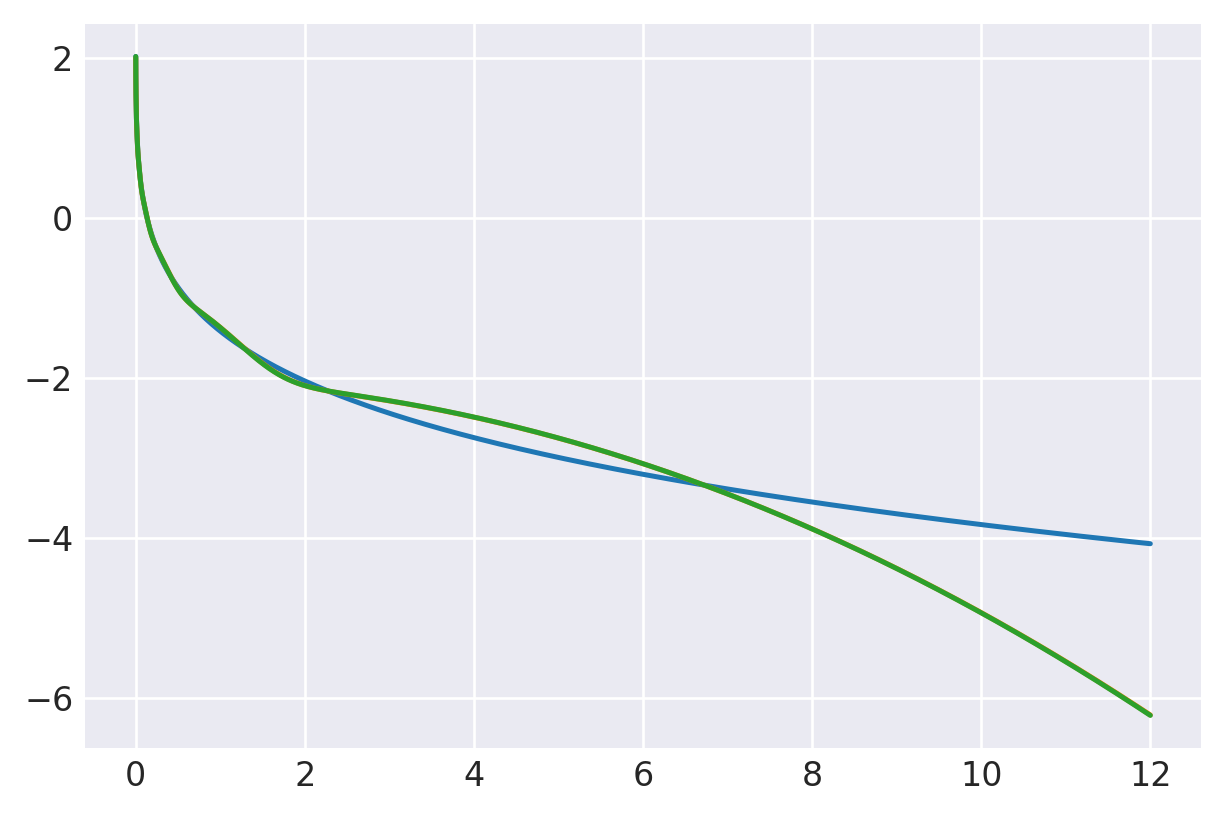

5.4: (
    normalize(np.array([ 4.4139797973e-01, 2.9566789288e-01, 1.5880859877e-01, 6.9443847055e-02, 2.5177622080e-02, 7.4721655747e-03, 1.7340636828e-03, 2.9783023104e-04) ]),
    np.array([ 3.2142724311e+00, 7.3924594159e-01, 2.4207075875e-01, 8.7210470162e-02, 3.2045654759e-02, 1.1438890212e-02, 3.7598786330e-03, 9.9320778609e-04 ]),
),
prev.  chisq = -3.144157696929696


Optimization terminated successfully.
         Current function value: -3.296329
         Iterations: 19
         Function evaluations: 510
         Gradient evaluations: 30
-3.2963293963165174


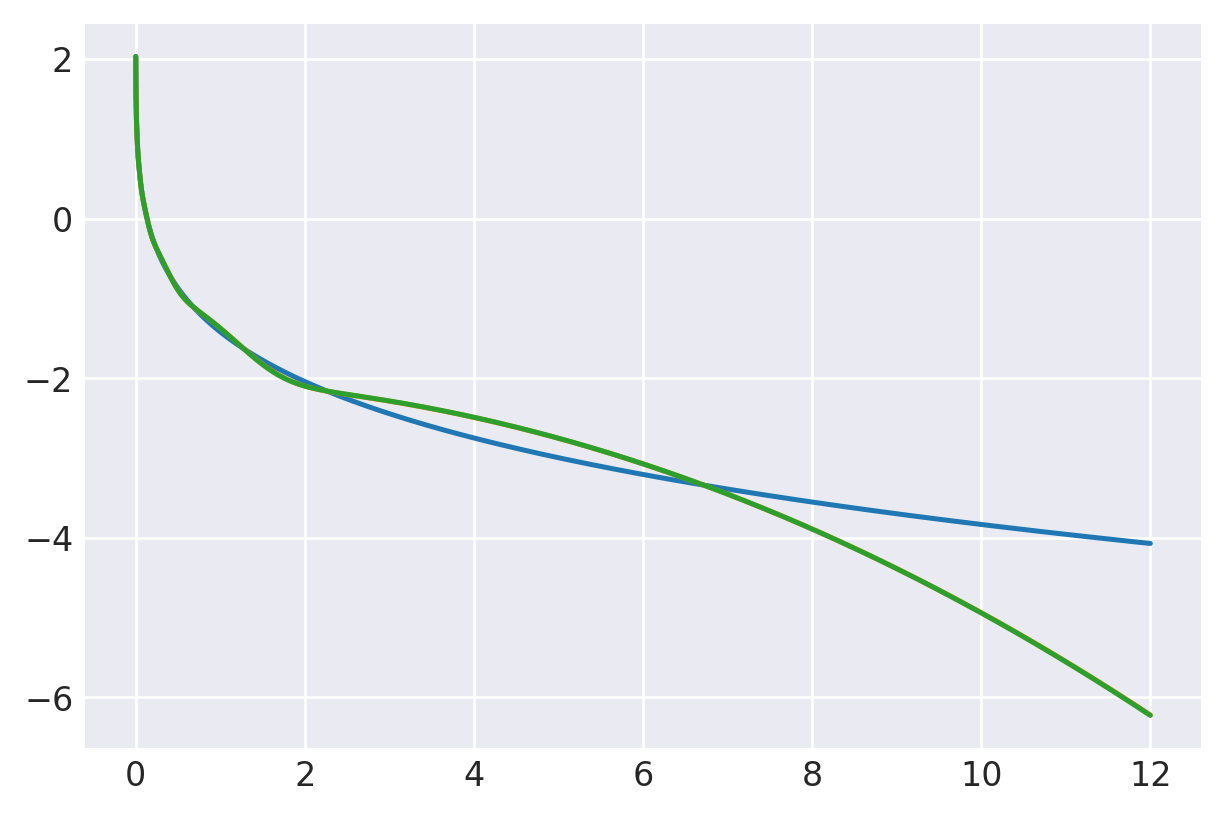

5.45: (
    normalize(np.array([ 4.4317775771e-01, 2.9476884305e-01, 1.5810081378e-01, 6.9207001832e-02, 2.5169115761e-02, 7.5100901992e-03, 1.7586113763e-03, 3.0776628486e-04) ]),
    np.array([ 3.2112717995e+00, 7.3361591769e-01, 2.3948084639e-01, 8.6118642096e-02, 3.1617910714e-02, 1.1290307547e-02, 3.7196498109e-03, 9.8769621717e-04 ]),
),
prev.  chisq = -3.132903258128082


Optimization terminated successfully.
         Current function value: -3.284631
         Iterations: 20
         Function evaluations: 510
         Gradient evaluations: 30
-3.2846306894217654


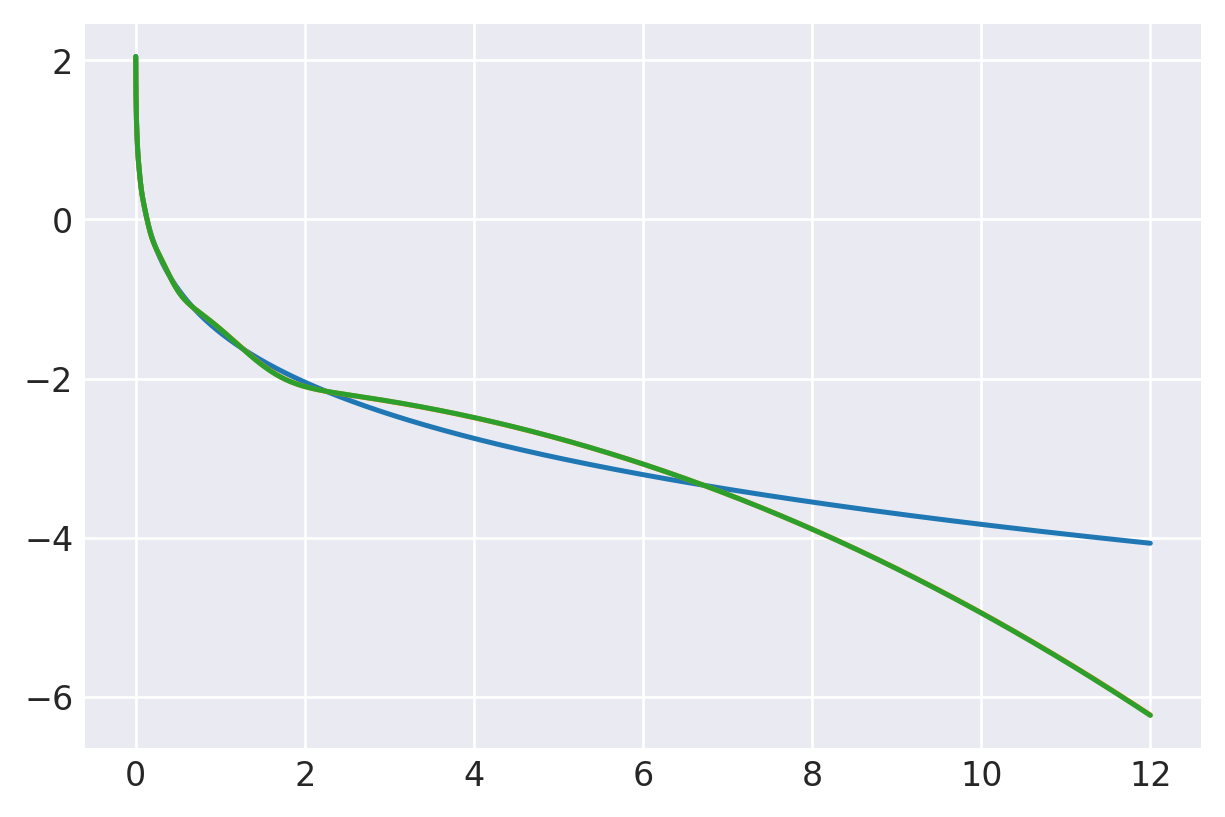

5.5: (
    normalize(np.array([ 4.4492444584e-01, 2.9387696581e-01, 1.5740684729e-01, 6.8977704806e-02, 2.5163414800e-02, 7.5490153499e-03, 1.7836202506e-03, 3.1798585650e-04) ]),
    np.array([ 3.2083185770e+00, 7.2808376575e-01, 2.3694870039e-01, 8.5055202016e-02, 3.1202624908e-02, 1.1146490901e-02, 3.6808437398e-03, 9.8239846511e-04 ]),
),
prev.  chisq = -3.1218026129798564


Optimization terminated successfully.
         Current function value: -3.273144
         Iterations: 19
         Function evaluations: 493
         Gradient evaluations: 29
-3.2731443860113445


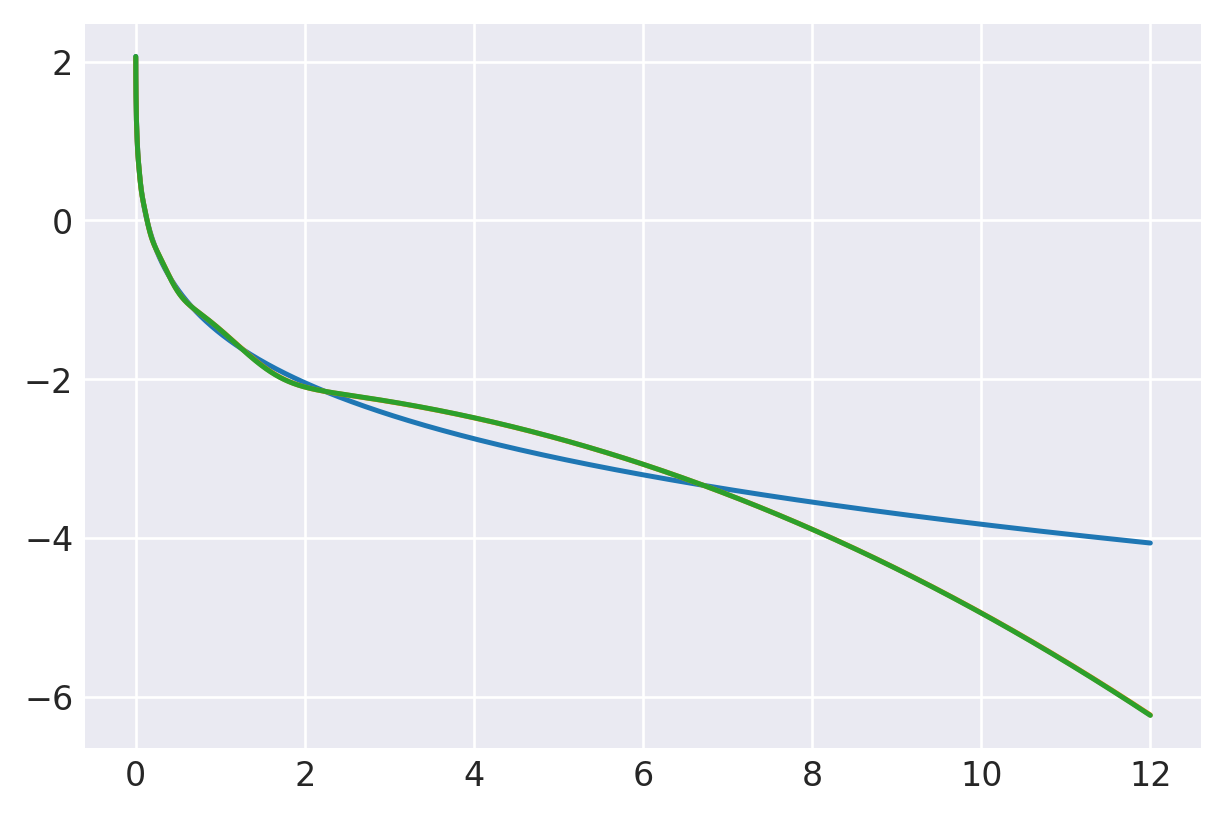

5.55: (
    normalize(np.array([ 4.4663960964e-01, 2.9299164903e-01, 1.5672603000e-01, 6.8755736363e-02, 2.5160484596e-02, 7.5889221333e-03, 1.8090772261e-03, 3.2849100362e-04) ]),
    np.array([ 3.2054040733e+00, 7.2264582163e-01, 2.3447263084e-01, 8.4019307998e-02, 3.0799361084e-02, 1.1007227875e-02, 3.6433826986e-03, 9.7730041700e-04 ]),
),
prev.  chisq = -3.110852643621724


Optimization terminated successfully.
         Current function value: -3.261865
         Iterations: 20
         Function evaluations: 493
         Gradient evaluations: 29
-3.2618647730248282


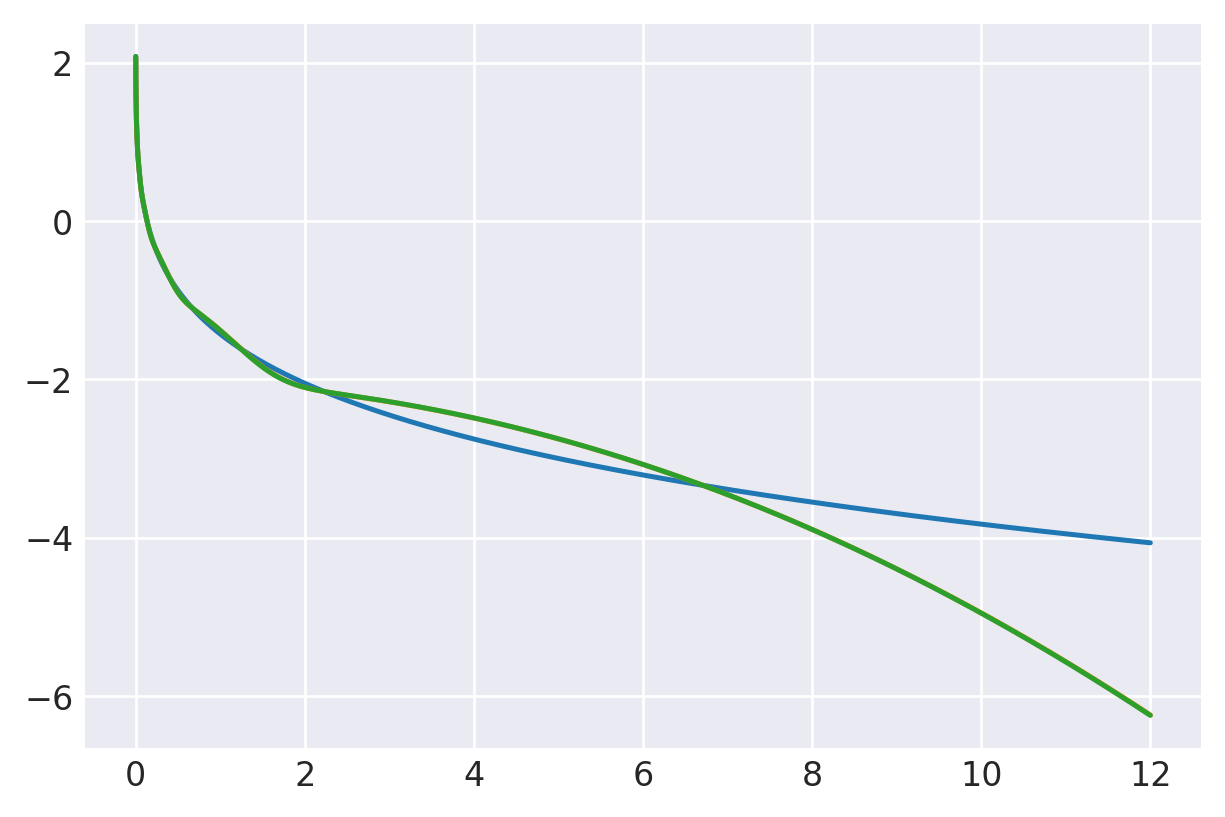

5.6: (
    normalize(np.array([ 4.4832341239e-01, 2.9211364569e-01, 1.5605820457e-01, 6.8540638409e-02, 2.5160087487e-02, 7.6297534515e-03, 1.8349743612e-03, 3.3928363298e-04) ]),
    np.array([ 3.2025355619e+00, 7.1730043022e-01, 2.3205046295e-01, 8.3009683395e-02, 3.0407556153e-02, 1.0872307172e-02, 3.6071982984e-03, 9.7238891612e-04 ]),
),
prev.  chisq = -3.100050744365568


Optimization terminated successfully.
         Current function value: -3.250786
         Iterations: 20
         Function evaluations: 493
         Gradient evaluations: 29
-3.250786371832719


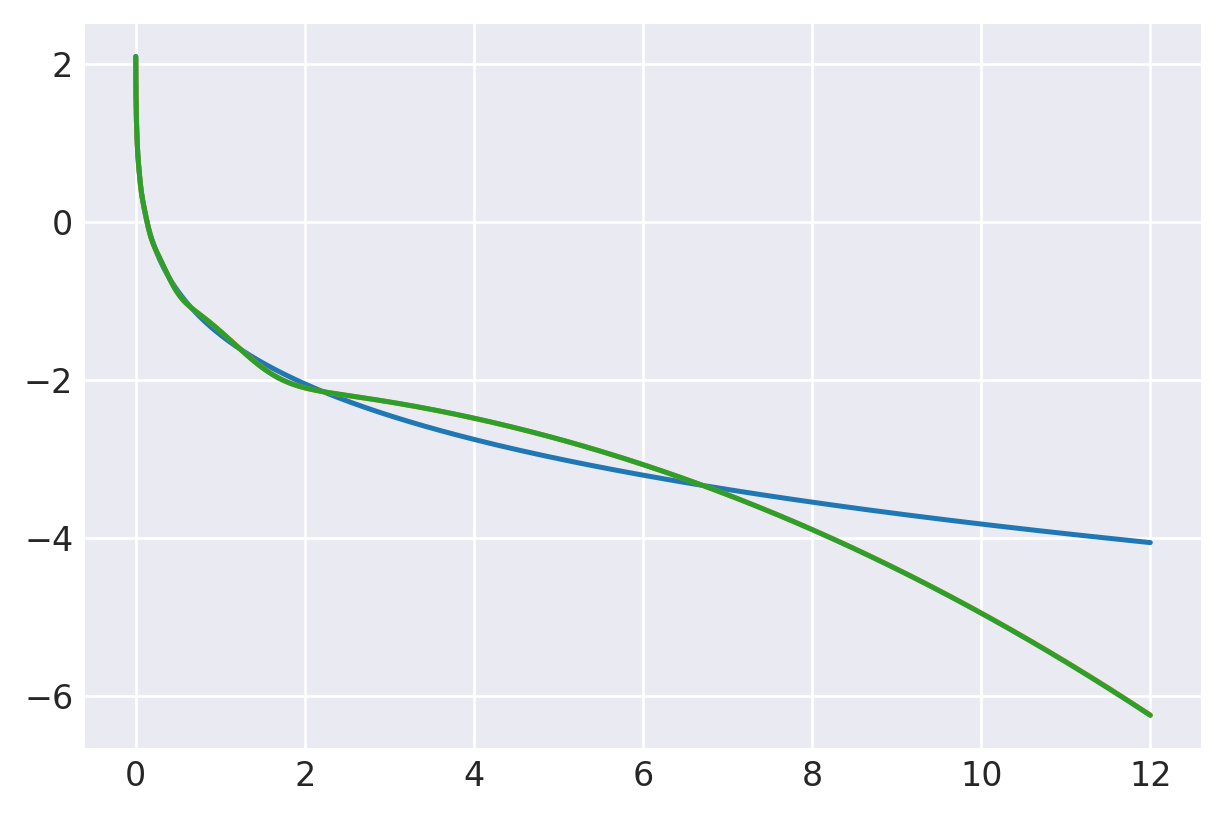

5.65: (
    normalize(np.array([ 4.4997710070e-01, 2.9124227405e-01, 1.5540293452e-01, 6.8332340719e-02, 2.5162197725e-02, 7.6714817041e-03, 1.8613038740e-03, 3.5036669888e-04) ]),
    np.array([ 3.1997068423e+00, 7.1204508297e-01, 2.2968099914e-01, 8.2025625450e-02, 3.0026808179e-02, 1.0741543376e-02, 3.5722291511e-03, 9.6765323943e-04 ]),
),
prev.  chisq = -3.0893936068958285


Optimization terminated successfully.
         Current function value: -3.239904
         Iterations: 19
         Function evaluations: 510
         Gradient evaluations: 30
-3.2399039229879496


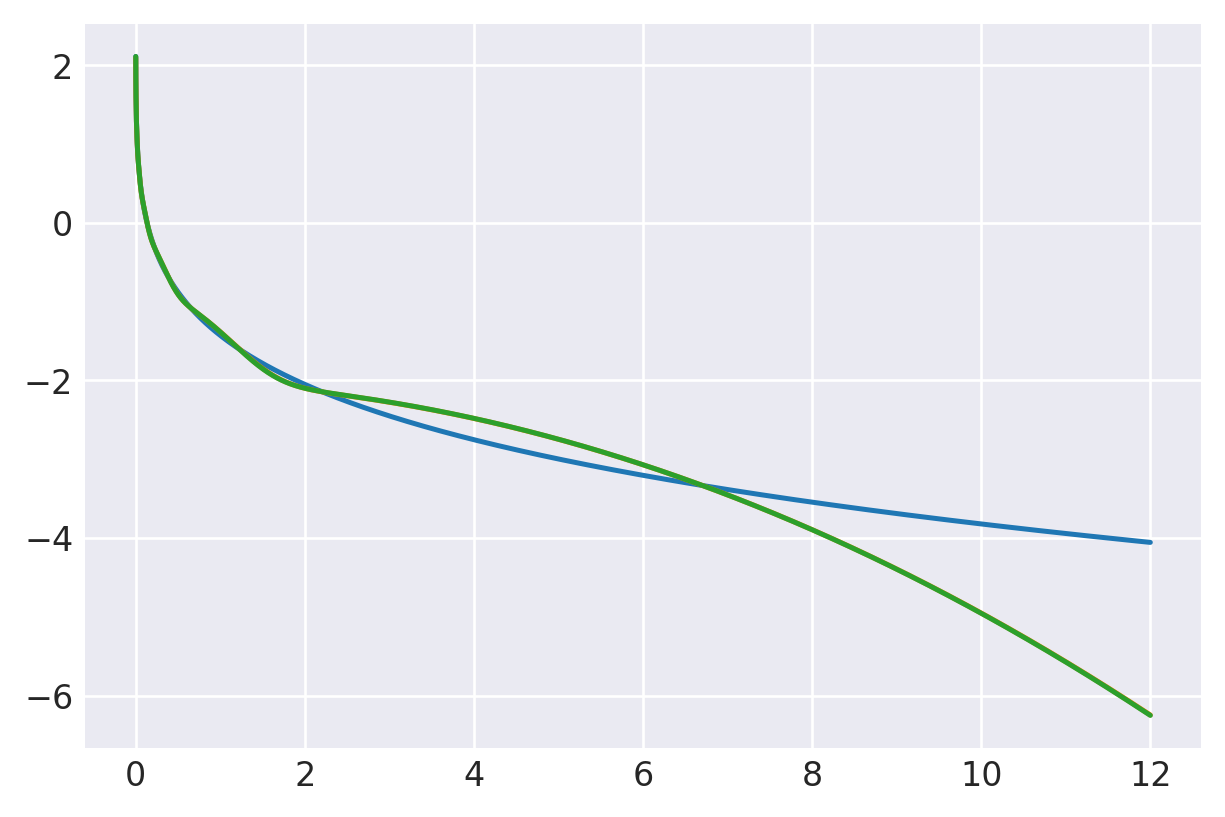

5.7: (
    normalize(np.array([ 4.5160133761e-01, 2.9037784689e-01, 1.5475972177e-01, 6.8130521005e-02, 2.5166702572e-02, 7.7140713511e-03, 1.8880566729e-03, 3.6174212875e-04) ]),
    np.array([ 3.1969189557e+00, 7.0687720177e-01, 2.2736238303e-01, 8.1066192081e-02, 2.9656678723e-02, 1.0614752632e-02, 3.5384136769e-03, 9.6308235068e-04 ]),
),
prev.  chisq = -3.0788785795470566


Optimization terminated successfully.
         Current function value: -3.229212
         Iterations: 19
         Function evaluations: 510
         Gradient evaluations: 30
-3.229212372535761


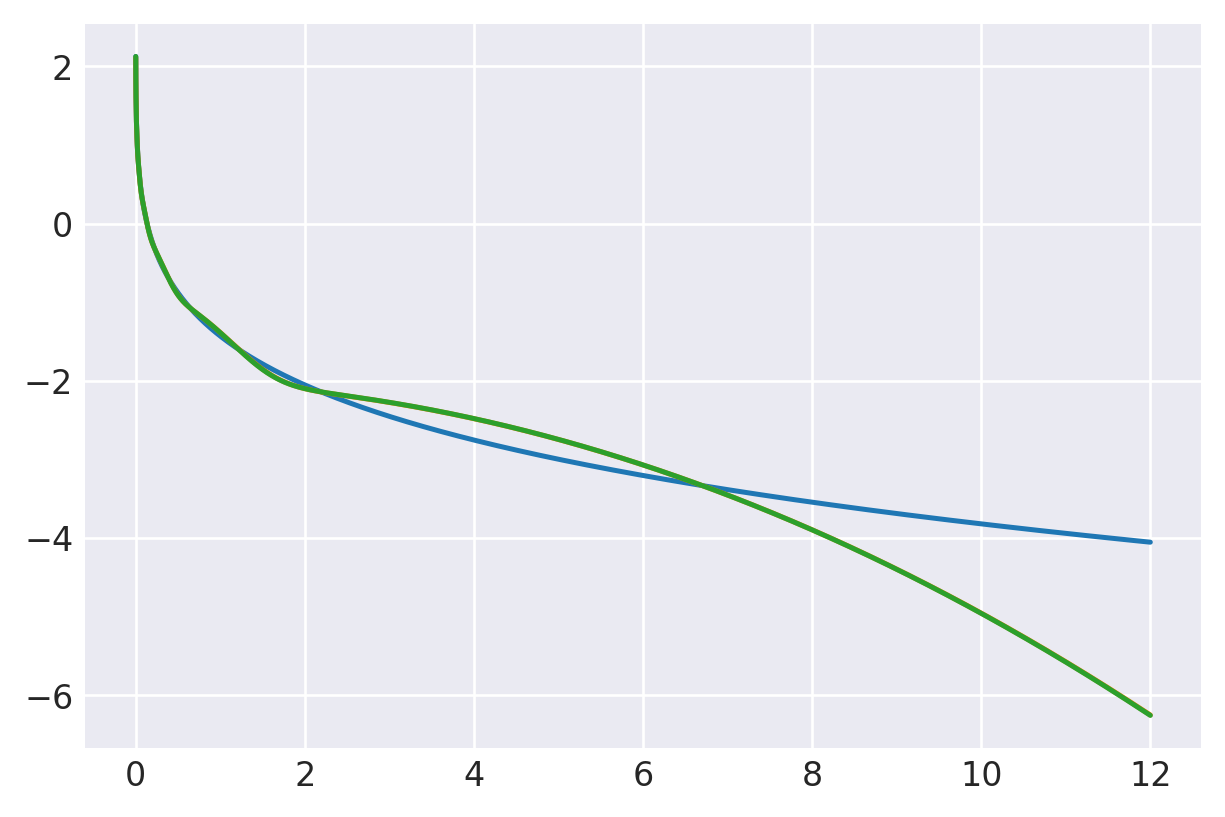

5.75: (
    normalize(np.array([ 4.5319665561e-01, 2.8952038556e-01, 1.5412843493e-01, 6.7934942846e-02, 2.5173461144e-02, 7.7574807646e-03, 1.9152267256e-03, 3.7341241360e-04) ]),
    np.array([ 3.1941735435e+00, 7.0179527586e-01, 2.2509313662e-01, 8.0130459928e-02, 2.9296727868e-02, 1.0491763383e-02, 3.5056979899e-03, 9.5866674385e-04 ]),
),
prev.  chisq = -3.068503091046383


Optimization terminated successfully.
         Current function value: -3.218707
         Iterations: 19
         Function evaluations: 510
         Gradient evaluations: 30
-3.2187068596069195


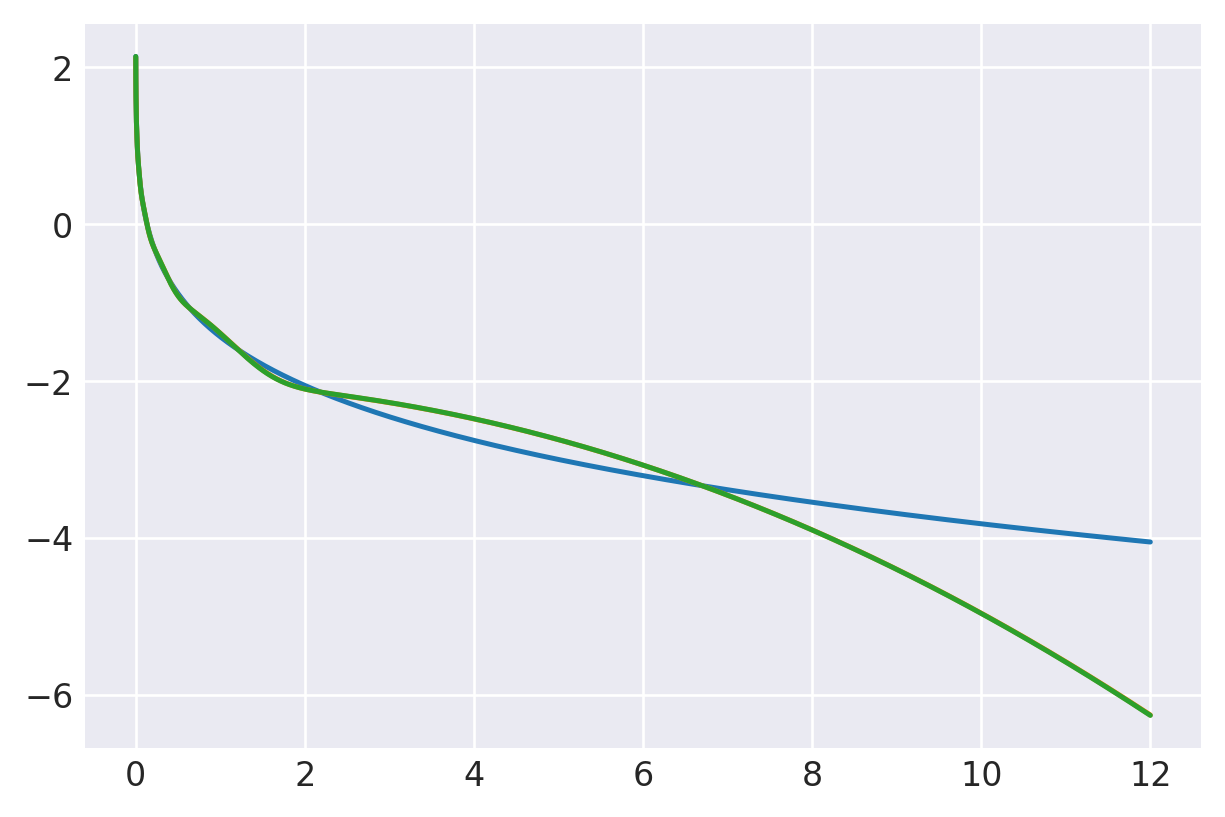

5.8: (
    normalize(np.array([ 4.5476387706e-01, 2.8866977456e-01, 1.5350867438e-01, 6.7745399970e-02, 2.5182402395e-02, 7.8016850377e-03, 1.9428066275e-03, 3.8537997809e-04) ]),
    np.array([ 3.1914688451e+00, 6.9679702927e-01, 2.2287182299e-01, 7.9217667252e-02, 2.8946585950e-02, 1.0372417673e-02, 3.4740299334e-03, 9.5439764886e-04 ]),
),
prev.  chisq = -3.058264413682462


Optimization terminated successfully.
         Current function value: -3.208383
         Iterations: 19
         Function evaluations: 476
         Gradient evaluations: 28
-3.2083827051287237


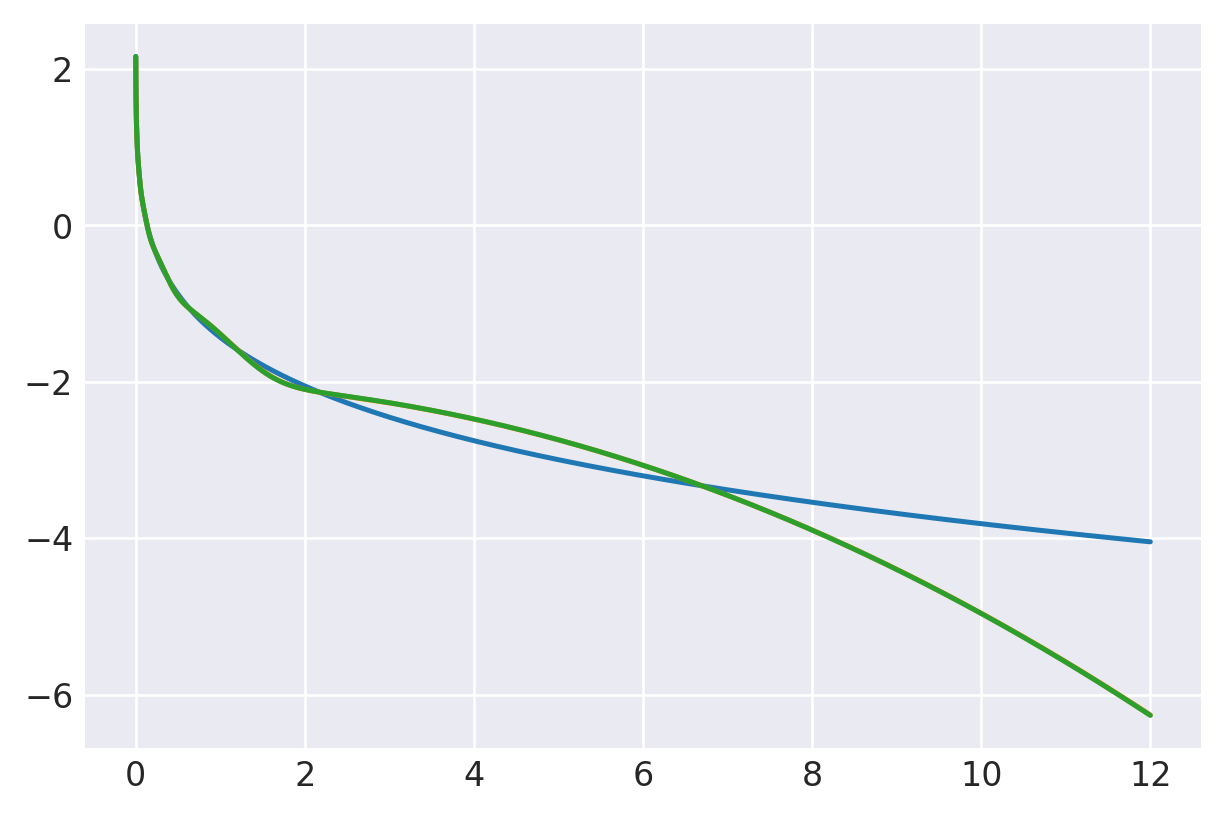

5.85: (
    normalize(np.array([ 4.5630386116e-01, 2.8782568389e-01, 1.5290016196e-01, 6.7561749202e-02, 2.5193454423e-02, 7.8466525439e-03, 1.9707896621e-03, 3.9764715636e-04) ]),
    np.array([ 3.1888019953e+00, 6.9188049858e-01, 2.2069721046e-01, 7.8327093061e-02, 2.8605887025e-02, 1.0256562450e-02, 3.4433608696e-03, 9.5026688141e-04 ]),
),
prev.  chisq = -3.048159948052707


         Current function value: -3.198235
         Iterations: 20
         Function evaluations: 928
         Gradient evaluations: 54
-3.1982354015523784


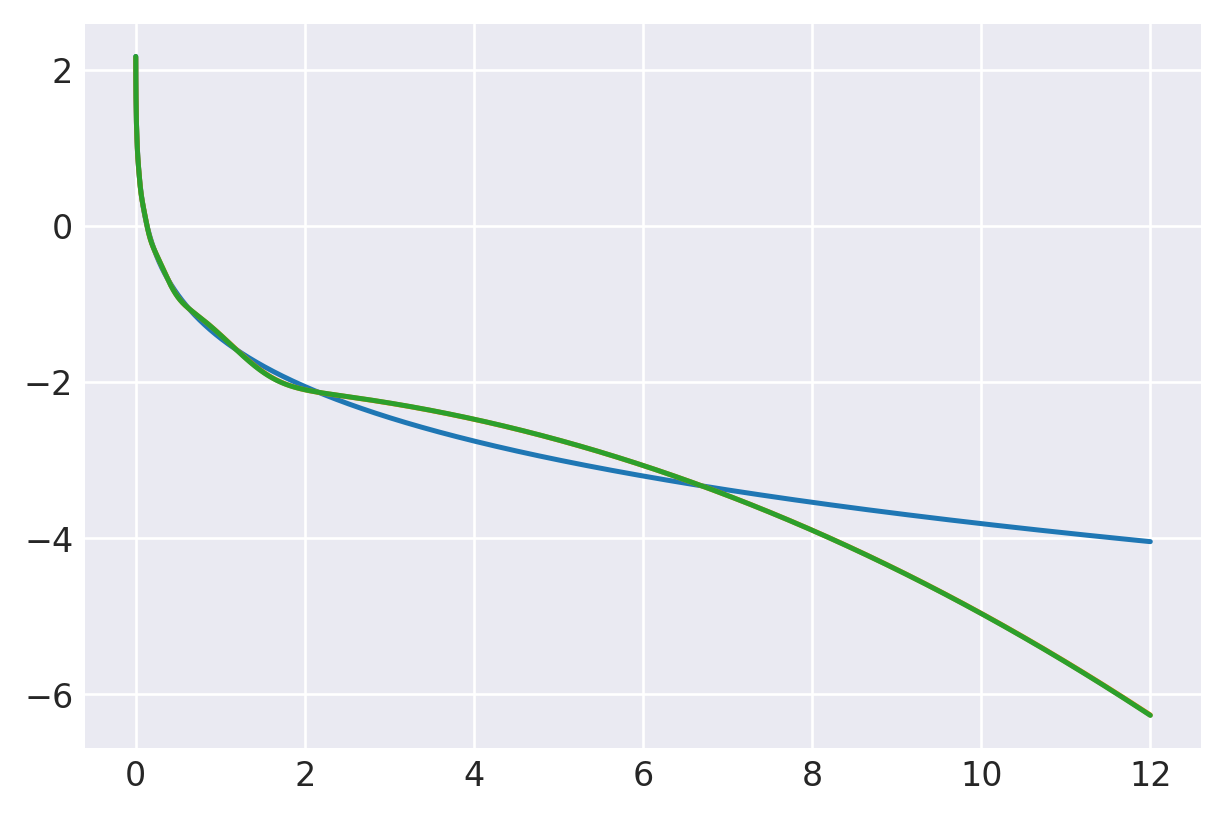

5.9: (
    normalize(np.array([ 4.5781649470e-01, 2.8698915567e-01, 1.5230255509e-01, 6.7383576533e-02, 2.5206468549e-02, 7.8923620204e-03, 1.9991706797e-03, 4.1021676668e-04) ]),
    np.array([ 3.1861828615e+00, 6.8704414356e-01, 2.1856743760e-01, 7.7457820431e-02, 2.8274266457e-02, 1.0144061717e-02, 3.4136469265e-03, 9.4626744406e-04 ]),
),
prev.  chisq = -3.0381869945999767


Optimization terminated successfully.
         Current function value: -3.188261
         Iterations: 19
         Function evaluations: 493
         Gradient evaluations: 29
-3.1882606034160994


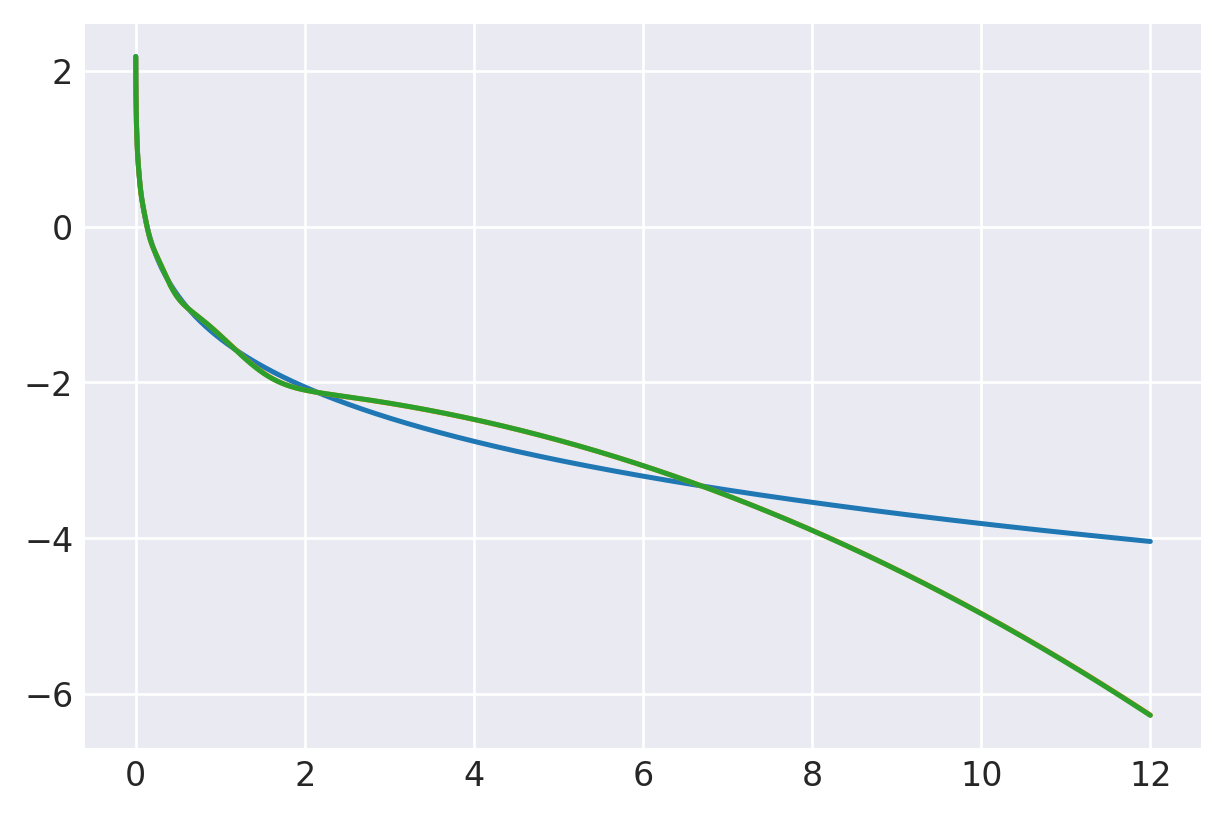

5.95: (
    normalize(np.array([ 4.5930324364e-01, 2.8615906153e-01, 1.5171551484e-01, 6.7210914818e-02, 2.5221453476e-02, 7.9387809516e-03, 2.0279406193e-03, 4.2309012027e-04) ]),
    np.array([ 3.1836001067e+00, 6.8228554861e-01, 2.1648171730e-01, 7.6609357247e-02, 2.7951411353e-02, 1.0034768534e-02, 3.3848408399e-03, 9.4239133579e-04 ]),
),
prev.  chisq = -3.02834378409864


Optimization terminated successfully.
         Current function value: -3.178454
         Iterations: 19
         Function evaluations: 476
         Gradient evaluations: 28
-3.1784541187225095


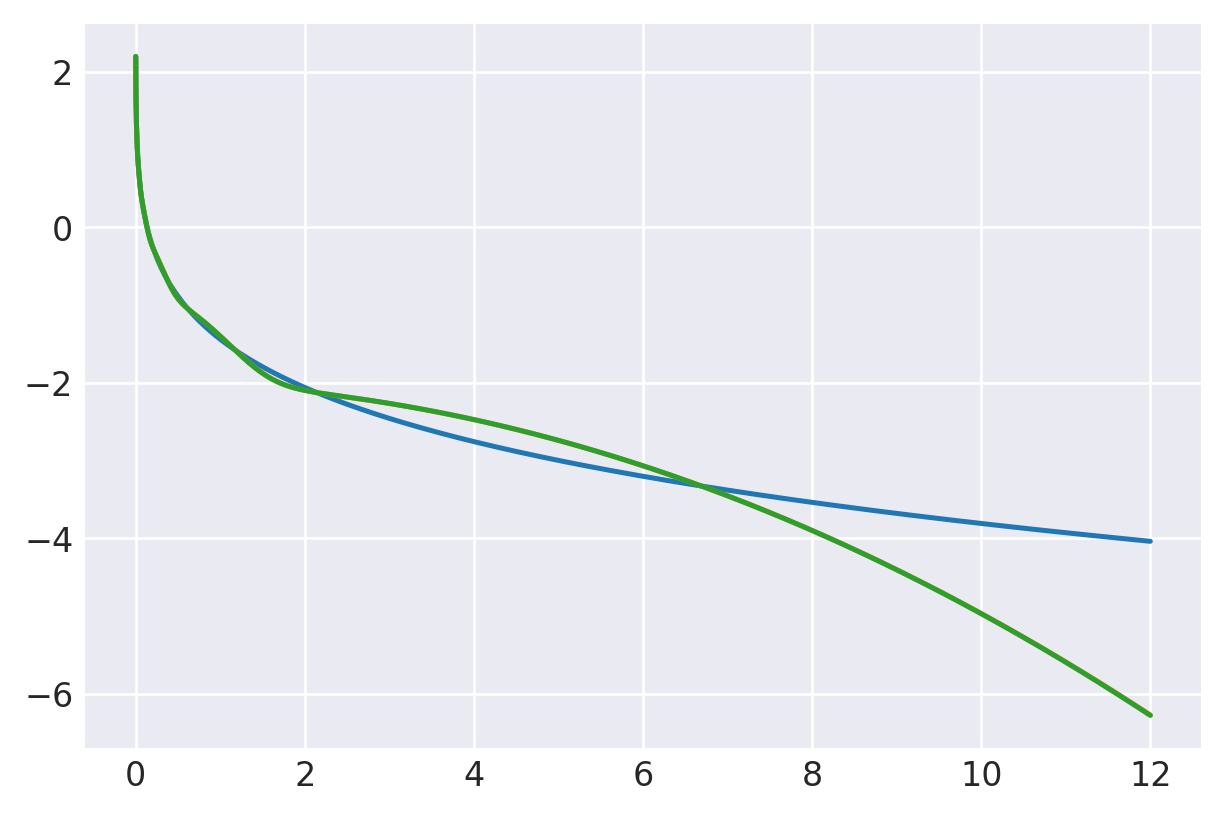

6.0: (
    normalize(np.array([ 4.6076465182e-01, 2.8533508326e-01, 1.5113909248e-01, 6.7043648527e-02, 2.5238279496e-02, 7.9858754299e-03, 2.0570981544e-03, 4.3627083654e-04) ]),
    np.array([ 3.1810537803e+00, 6.7760377793e-01, 2.1443906259e-01, 7.5780978890e-02, 2.7636975616e-02, 9.9285608879e-03, 3.3569087172e-03, 9.3863341561e-04 ]),
),
prev.  chisq = -3.0186272476261866


Optimization terminated successfully.
         Current function value: -3.168812
         Iterations: 19
         Function evaluations: 510
         Gradient evaluations: 30
-3.1688119010246316


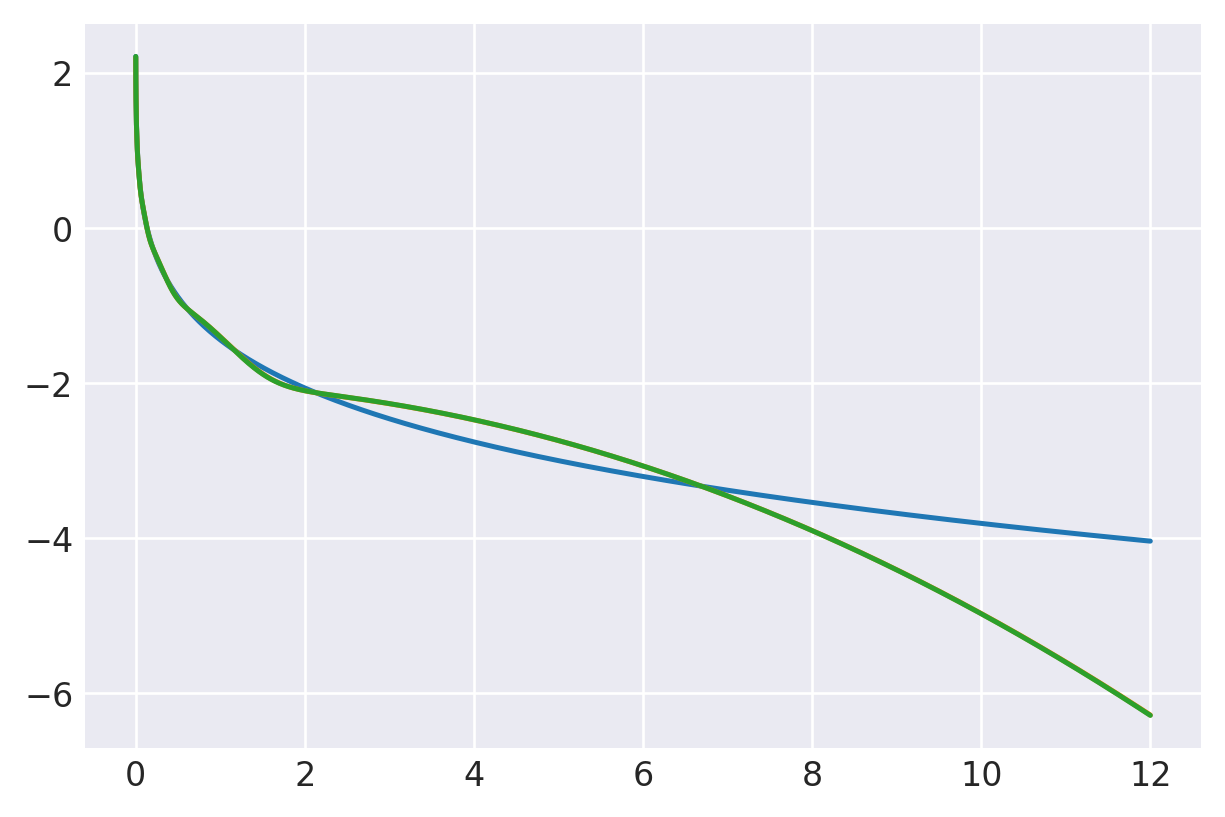

6.05: (
    normalize(np.array([ 4.6219996876e-01, 2.8451948266e-01, 1.5057253668e-01, 6.6881141914e-02, 2.5256828261e-02, 8.0336458631e-03, 2.0866351565e-03, 4.4976070595e-04) ]),
    np.array([ 3.1785623912e+00, 6.7299678633e-01, 2.1243706233e-01, 7.4971796592e-02, 2.7330672365e-02, 9.8253246410e-03, 3.3298090513e-03, 9.3498728989e-04 ]),
),
prev.  chisq = -3.0090353937834267


Optimization terminated successfully.
         Current function value: -3.159330
         Iterations: 20
         Function evaluations: 493
         Gradient evaluations: 29
-3.1593300419636217


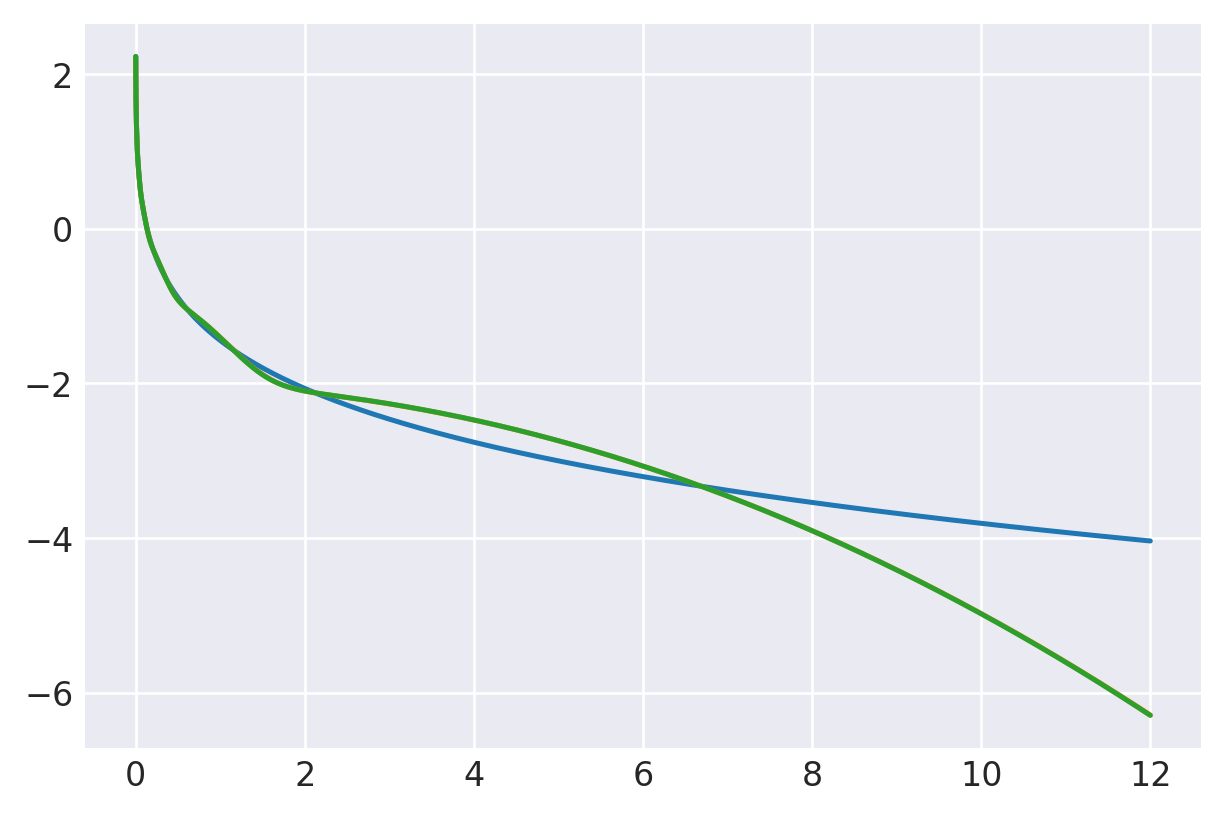

6.1: (
    normalize(np.array([ 4.6361138860e-01, 2.8370953117e-01, 1.5001602533e-01, 6.6723768411e-02, 2.5277125625e-02, 8.0820518683e-03, 2.1165465814e-03, 4.6356241905e-04) ]),
    np.array([ 3.1761031112e+00, 6.6846305430e-01, 2.1047598049e-01, 7.4181541191e-02, 2.7032223463e-02, 9.7249356352e-03, 3.3035078193e-03, 9.3144774207e-04 ]),
),
prev.  chisq = -2.9995656634353116


Optimization terminated successfully.
         Current function value: -3.150005
         Iterations: 20
         Function evaluations: 493
         Gradient evaluations: 29
-3.150004764571055


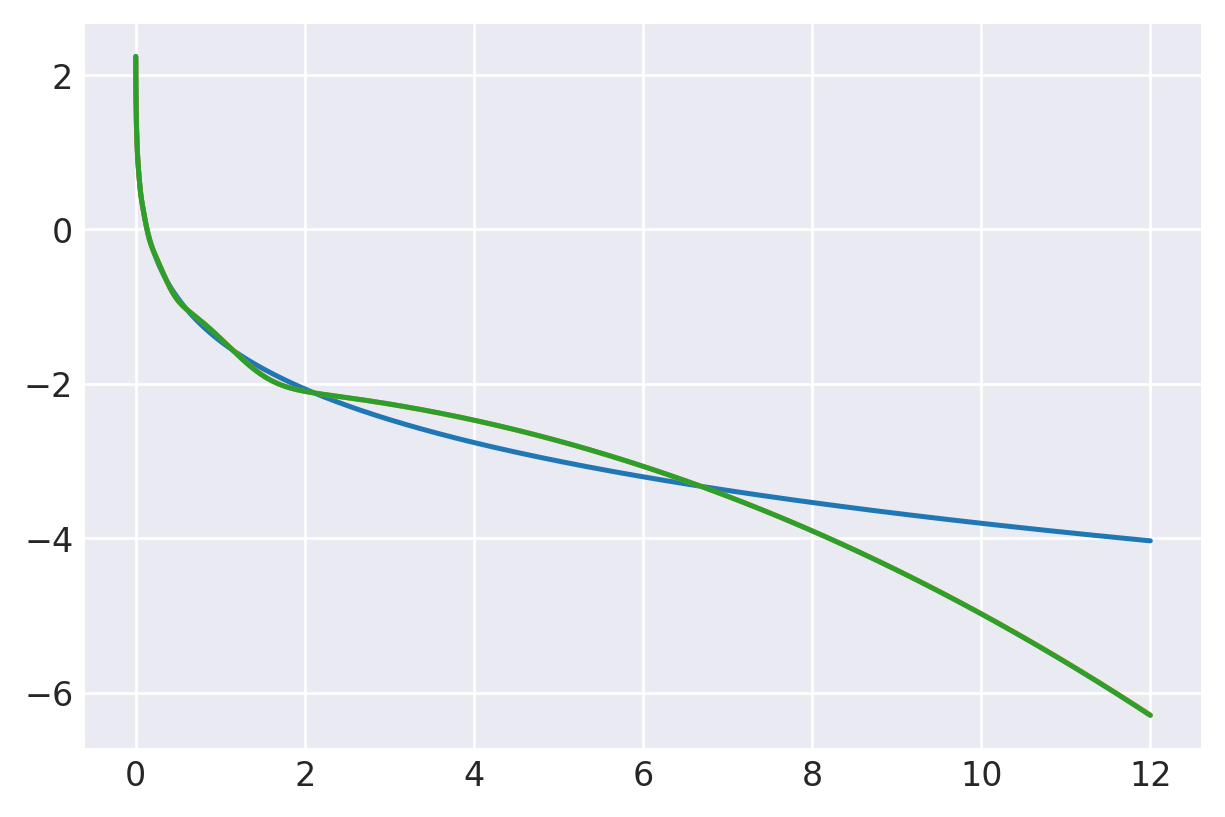

6.15: (
    normalize(np.array([ 4.6499876450e-01, 2.8290639827e-01, 1.4946907238e-01, 6.6571116246e-02, 2.5299066876e-02, 8.1310764079e-03, 2.1468275554e-03, 4.7767776157e-04) ]),
    np.array([ 3.1736854161e+00, 6.6400078730e-01, 2.0855403268e-01, 7.3409460263e-02, 2.6741345692e-02, 9.6272869030e-03, 3.2779702240e-03, 9.2800925049e-04 ]),
),
prev.  chisq = -2.9902161394432714


Optimization terminated successfully.
         Current function value: -3.140832
         Iterations: 20
         Function evaluations: 493
         Gradient evaluations: 29
-3.140832416926396


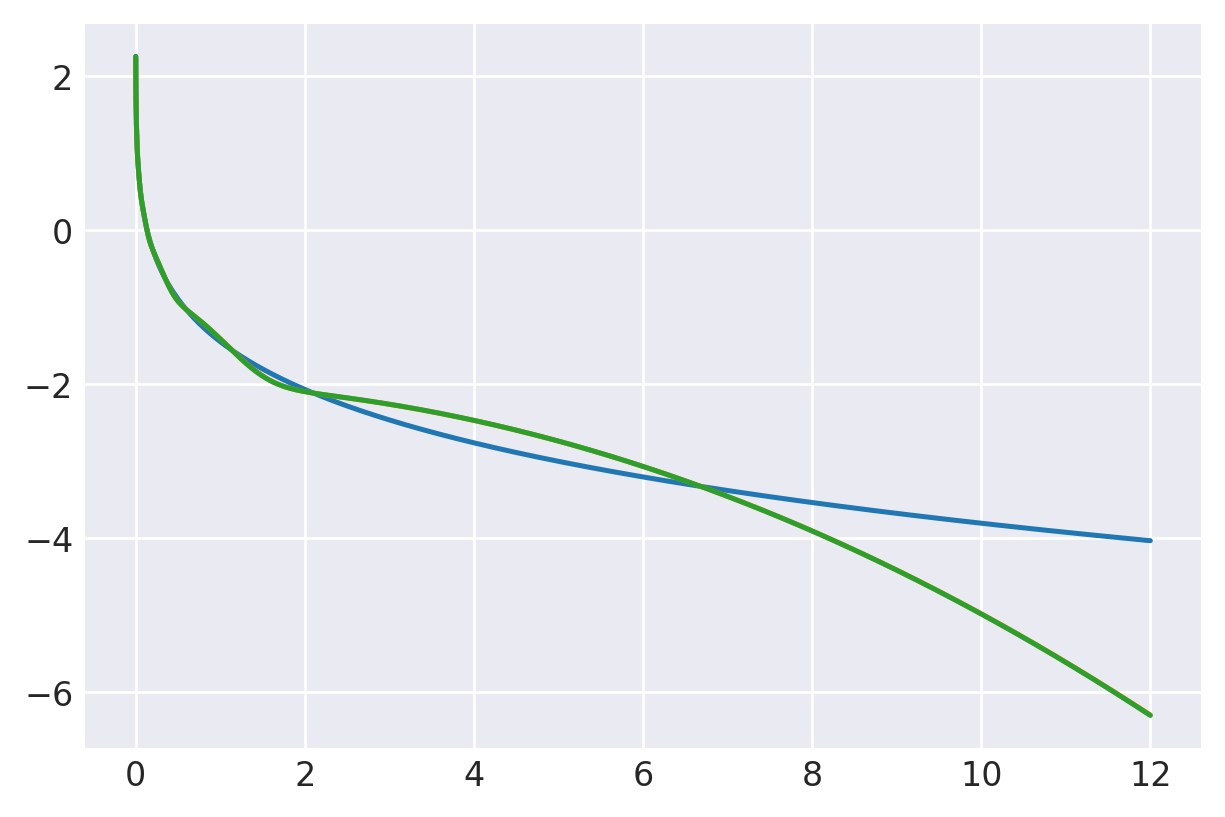

6.2: (
    normalize(np.array([ 4.6636278998e-01, 2.8210985558e-01, 1.4893141354e-01, 6.6423057367e-02, 2.5322601603e-02, 8.1807003545e-03, 2.1774727870e-03, 4.9210878096e-04) ]),
    np.array([ 3.1713067172e+00, 6.5960826278e-01, 2.0667021015e-01, 7.2655014682e-02, 2.6457782619e-02, 9.5322744157e-03, 3.2531638359e-03, 9.2466692970e-04 ]),
),
prev.  chisq = -2.9809846592401295


Optimization terminated successfully.
         Current function value: -3.131809
         Iterations: 21
         Function evaluations: 510
         Gradient evaluations: 30
-3.1318094662701954


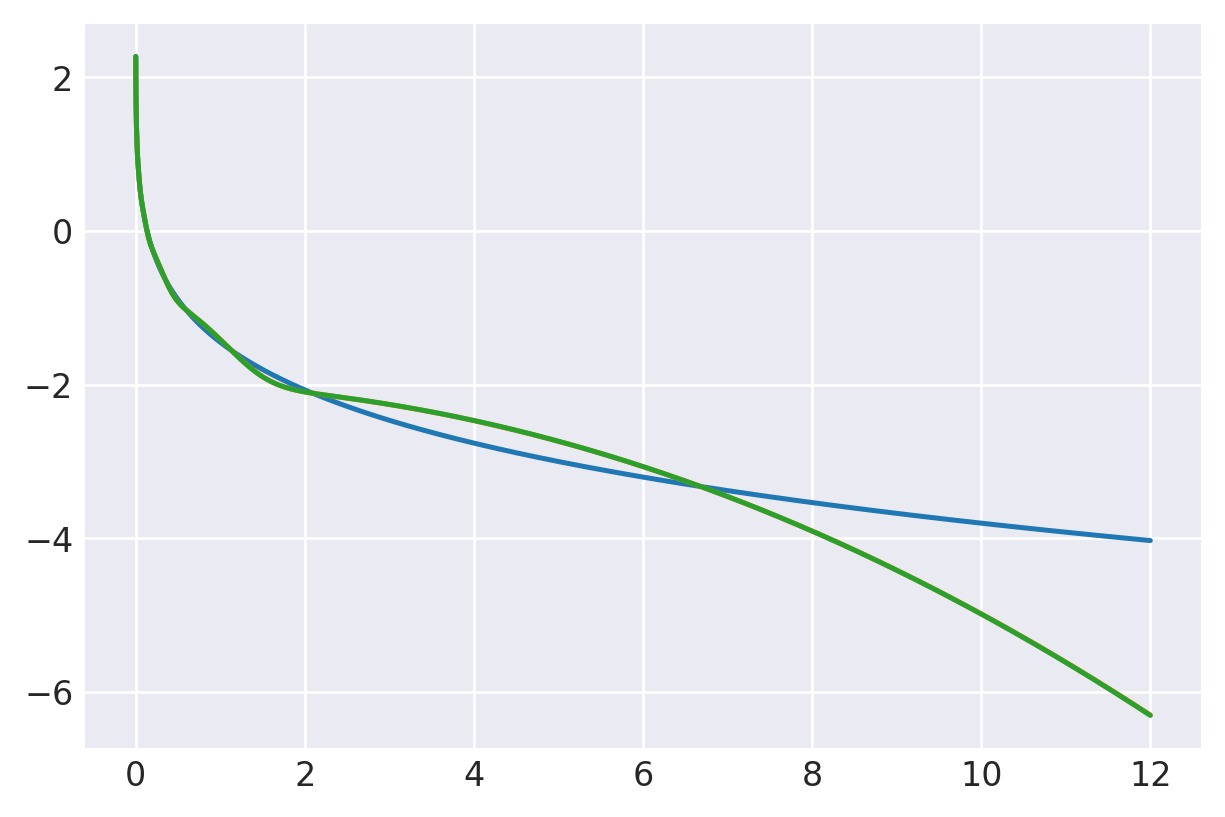

6.25: (
    normalize(np.array([ 4.6770384669e-01, 2.8131982853e-01, 1.4840293441e-01, 6.6279489128e-02, 2.5347662163e-02, 8.2309030641e-03, 2.2084777382e-03, 5.0685826895e-04) ]),
    np.array([ 3.1689687633e+00, 6.5528446091e-01, 2.0482362265e-01, 7.1917665108e-02, 2.6181279181e-02, 9.4398003182e-03, 3.2290602798e-03, 9.2141681224e-04 ]),
),
prev.  chisq = -2.9718690704881032


Optimization terminated successfully.
         Current function value: -3.122932
         Iterations: 20
         Function evaluations: 527
         Gradient evaluations: 31
-3.1229324935376708


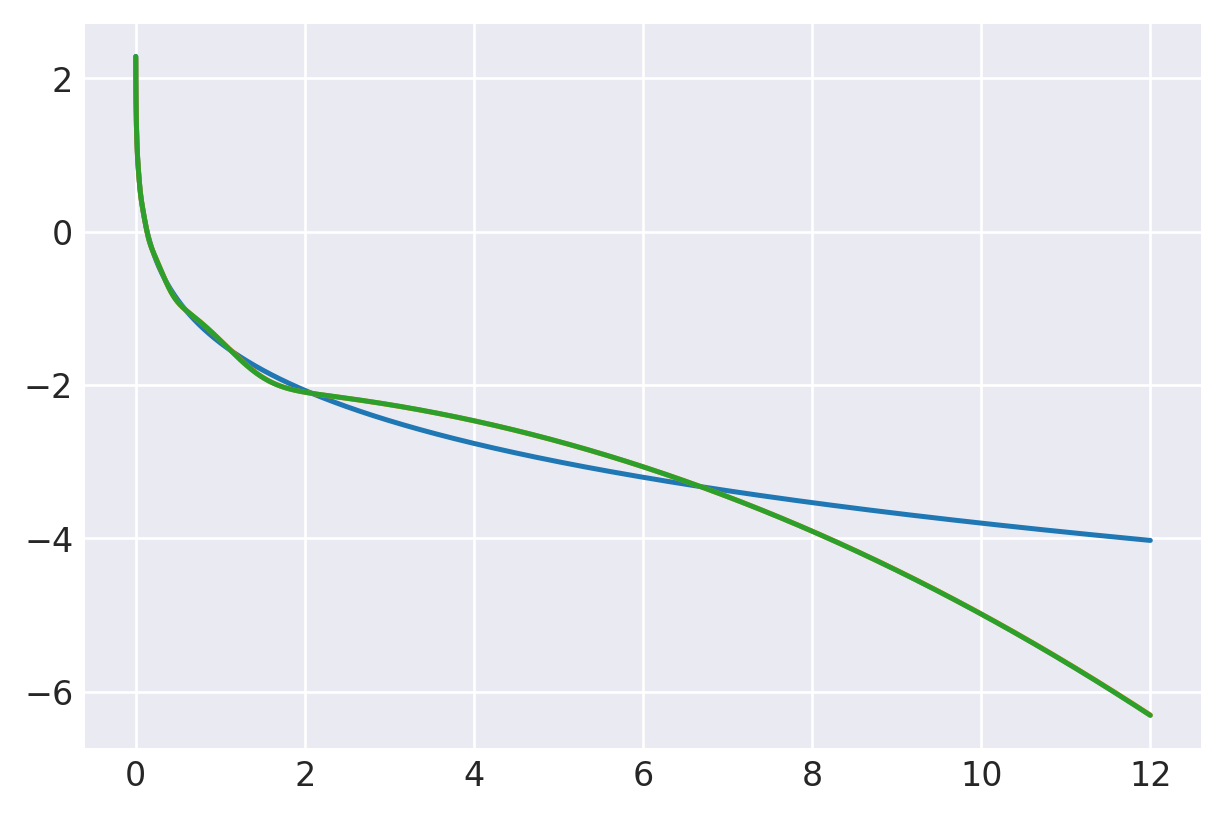

6.3: (
    normalize(np.array([ 4.6902224858e-01, 2.8053649511e-01, 1.4788343152e-01, 6.6140225396e-02, 2.5374170433e-02, 8.2816623114e-03, 2.2398383058e-03, 5.2192833656e-04) ]),
    np.array([ 3.1666736978e+00, 6.5102807773e-01, 2.0301317370e-01, 7.1196838516e-02, 2.5911584488e-02, 9.3497703144e-03, 3.2056314065e-03, 9.1825470159e-04 ]),
),


In [4]:
#nvals = np.arange(0.55, 0.631, step=0.05)
nvals = [
    (
        np.array([0.5005]),
        (
            normalize(np.array([0.999, 1e-3])),
            np.array([1.00052323e+00, 6.73227271e-01]),
        ),
    ),
    (
        np.array([0.5028]),
        (
            normalize(np.array([0.982, 1.7e-2, 2.8e-4])),
            np.array([1.00445665e+00, 7.93714230e-01, 3.67450599e-01]),
        ),
    ),
    (
        np.array([0.511]),
        (
            normalize(np.array([0.93, 7e-2, 2e-3, 8e-5])),
            np.array([1.015, 0.855, 4.87450599e-01, 0.215]),
        ),
    ),
    (
        np.array([0.531]),
        (
            normalize(np.array([0.7, 2.6e-1, 2e-2, 1e-3, 5e-5])),
            np.array([1.06, 0.855, 4.87450599e-01, 0.215, 0.1]),
        ),
    ),
    (
        np.array([0.565]),
        (
            normalize(np.array([0.55, 0.4, 5e-2, 5e-3, 4e-4, 2e-5])),
            np.array([1.12, 0.92, 0.6, 0.4, 0.2, 0.1]),
        ),
    ),
    (
        np.array([0.6]),
        (
            normalize(np.array([0.4, 0.5, 1e-1, 1e-2, 2e-3, 2e-4, 1e-5])),
            np.array([1.2, 0.97, 0.7, 0.4, 0.2, 0.1, 0.05]),
        ),
    ),
    (
        np.array([0.65]),
        (
            normalize(np.array([0.27, 0.5, 0.15, 3.5e-2, 6e-3, 8e-4, 1e-4, 1e-5])),
            np.array([1.3, 1.04, 0.7, 0.5, 0.3, 0.17, 0.09, 0.04]),
        ),
    ),
    (
        np.array([
            0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00,
            1.05, 1.10, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45,
            1.50, 1.55, 1.60, 1.65, 1.70, 1.75, 1.80, 1.85, 1.90,
            1.95, 2.00, 2.05, 2.10, 2.15, 2.20, 2.25, 2.30, 2.35,
            2.40, 2.45, 2.50, 2.55, 2.60, 2.65, 2.70, 2.75, 2.80,
            2.85, 2.90, 2.95, 3.00, 3.05, 3.10, 3.15, 3.20, 3.25,
            3.30, 3.35, 3.40, 3.45, 3.50, 3.55, 3.60, 3.65, 3.70,
            3.75, 3.80, 3.85, 3.90, 3.95, 4.00, 4.05, 4.10, 4.15,
            4.20, 4.25, 4.30, 4.35, 4.40, 4.45, 4.50, 4.55, 4.60,
            4.65, 4.70, 4.75, 4.80, 4.85, 4.90, 4.95, 5.00, 5.05,
            5.10, 5.15, 5.20, 5.25, 5.30, 5.35, 5.40, 5.45, 5.50,
            5.55, 5.60, 5.65, 5.70, 5.75, 5.80, 5.85, 5.90, 5.95,
            6.00, 6.05, 6.10, 6.15, 6.20, 6.25, 6.3
        ]),
        (
            normalize(np.array([0.27, 0.5, 0.15, 3.5e-2, 6e-3, 8e-4, 1e-4, 1e-5])),
            np.array([1.3, 1.04, 0.7, 0.5, 0.3, 0.17, 0.09, 0.04]),
        ),
    )
]

fitweights(nvals)

/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10
/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


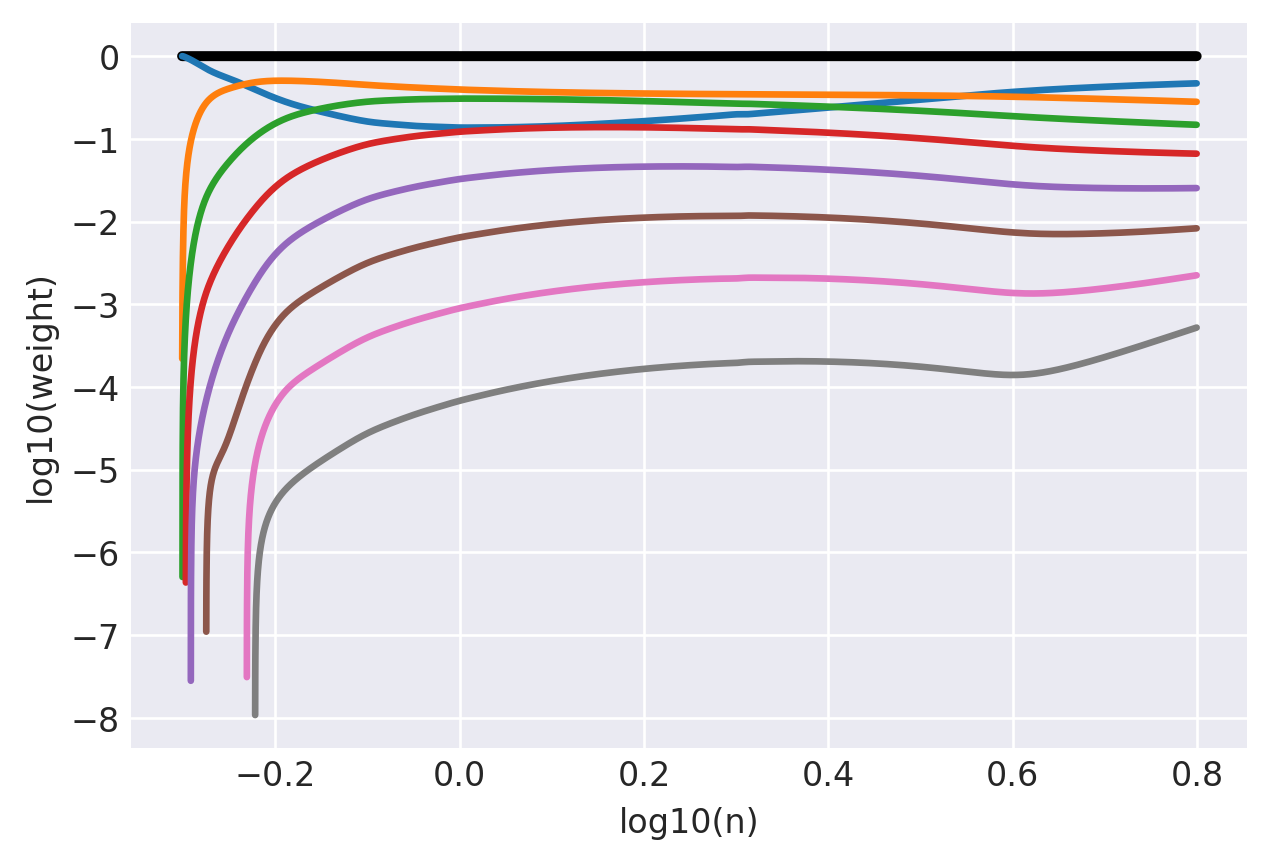

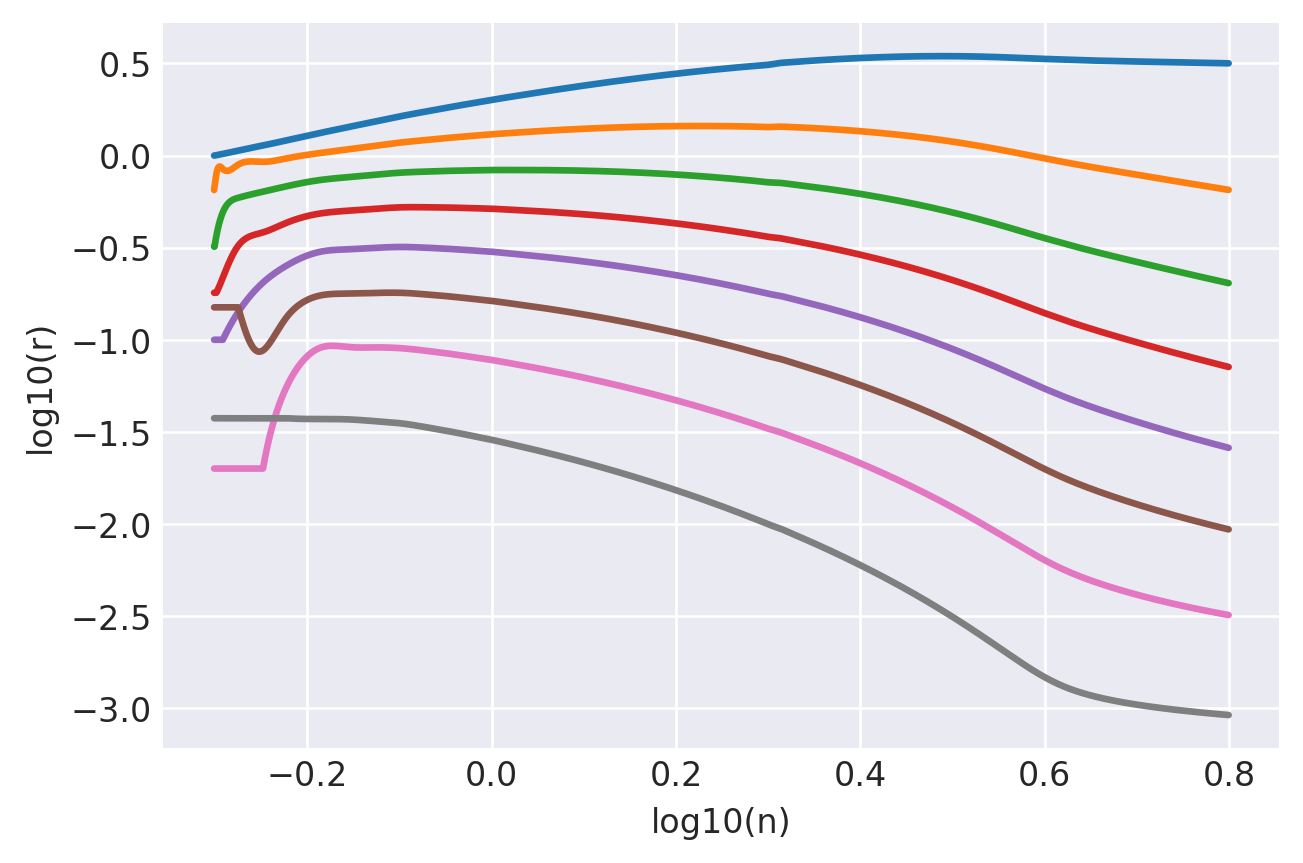

/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in log10
/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10


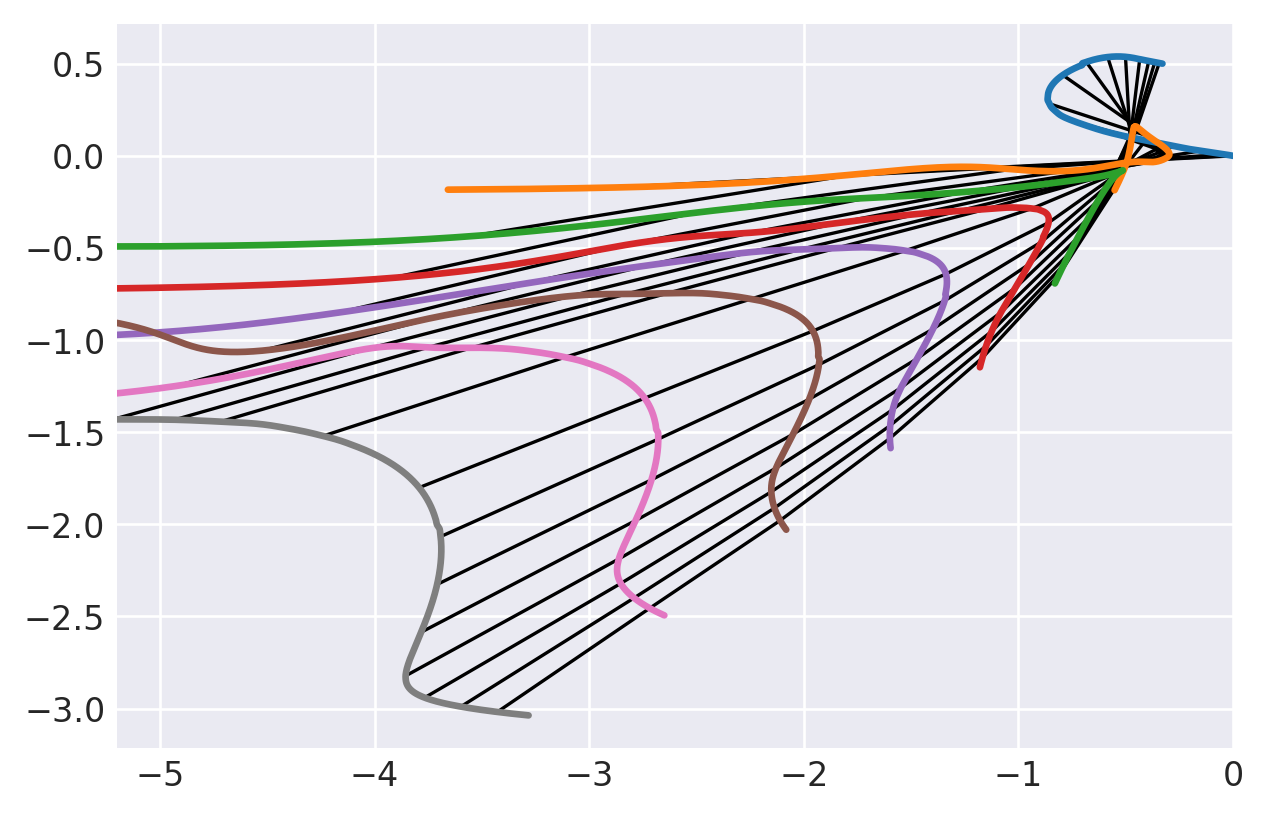

In [9]:
# Check out the resulting splines once implemented in MultiProfit

import scipy.interpolate as spinterp

order = 8
weightvars = mpfobj.MultiGaussianApproximationProfile.weights['sersic'][order]

weightsplines = []
sigmasplines = []
indices = np.log10(np.array(list(weightvars.keys())))
weightvalues = np.array(list(weightvars.values()))
for i in range(order):
    # Weights we want to ignore are flagged by negative radii
    # you might want a spline knot at r=0 and weight=0, although there is a danger of getting r < 0
    isweight = np.array([value[1][i] >= 0 for value in weightvalues])
    weightvaluestouse = weightvalues[isweight]
    for j, (splines, ext) in enumerate([(weightsplines, 'zeros'), (sigmasplines, 'const')]):
        splines.append(spinterp.InterpolatedUnivariateSpline(
            indices[isweight], [values[j][i] for values in weightvaluestouse], ext=ext))
            
nsers = np.linspace(np.log10(0.5), np.log10(6.3), 10000)

weightsums = [np.sum(np.array([weightsplines[i](nserlog) for i in range(order)])) for nserlog in nsers]
plt.plot(nsers, np.log10(weightsums), 'k-', linewidth=3)
for i in range(order):
    plt.plot(nsers, np.log10(weightsplines[i](nsers)), linewidth=2)
    
plt.xlabel('log10(n)')
plt.ylabel('log10(weight)')
plt.show()

for i in range(order):
    plt.plot(nsers, np.log10(sigmasplines[i](nsers)), linewidth=2)
plt.xlabel('log10(n)')
plt.ylabel('log10(r)')
plt.show()

for idxn, nser in enumerate(indices):
    if idxn < 10 or idxn % 12 == 1:
        plt.plot(
            np.log10(np.array([weightsplines[i](nser) for i in range(order)
                               if weightvalues[idxn][0][i] > 1e-12])),
            np.log10(np.array([sigmasplines[i](nser) for i in range(order)
                               if weightvalues[idxn][0][i] > 1e-12])),
            'k-', linewidth=1)

for i in range(order):
    plt.plot(np.log10(weightsplines[i](nsers)), np.log10(sigmasplines[i](nsers)), linewidth=2)

plt.xlim([-5.2, 0])

plt.show()